In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

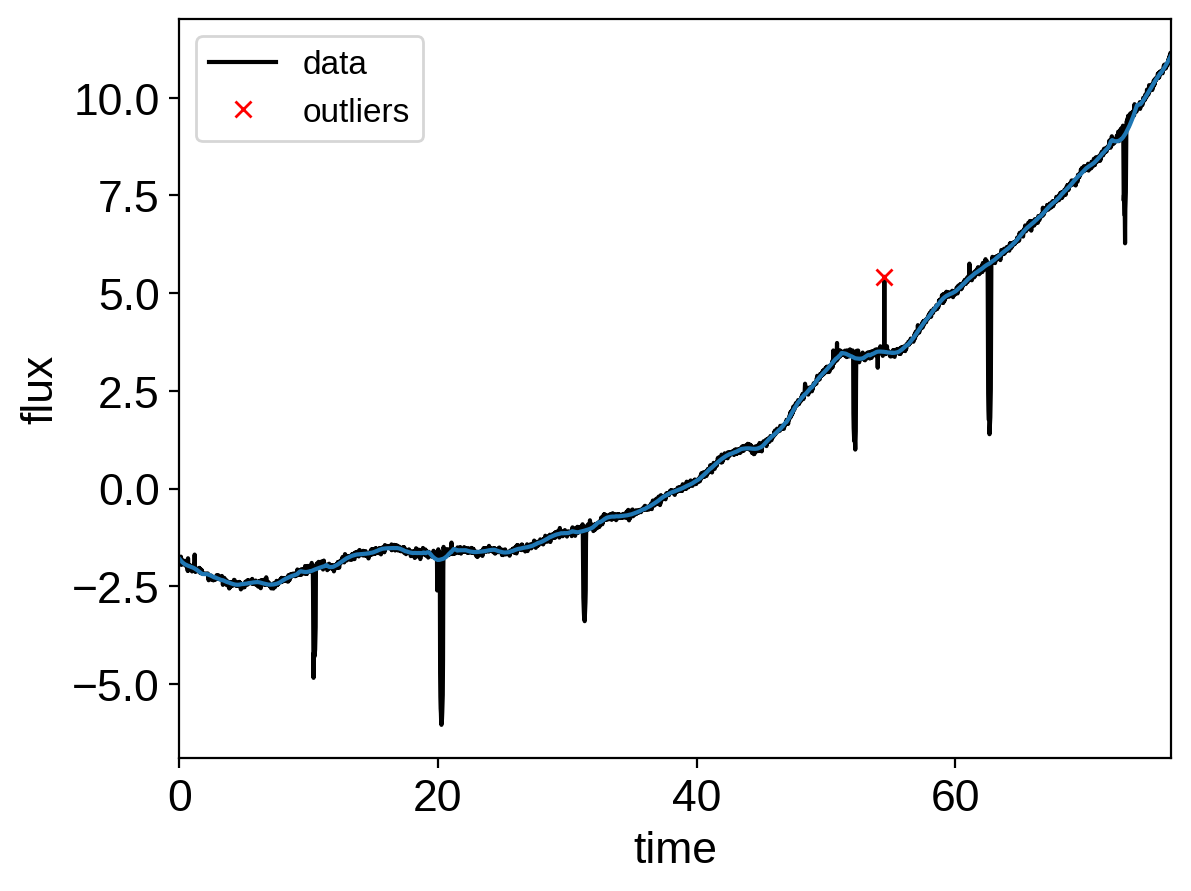

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

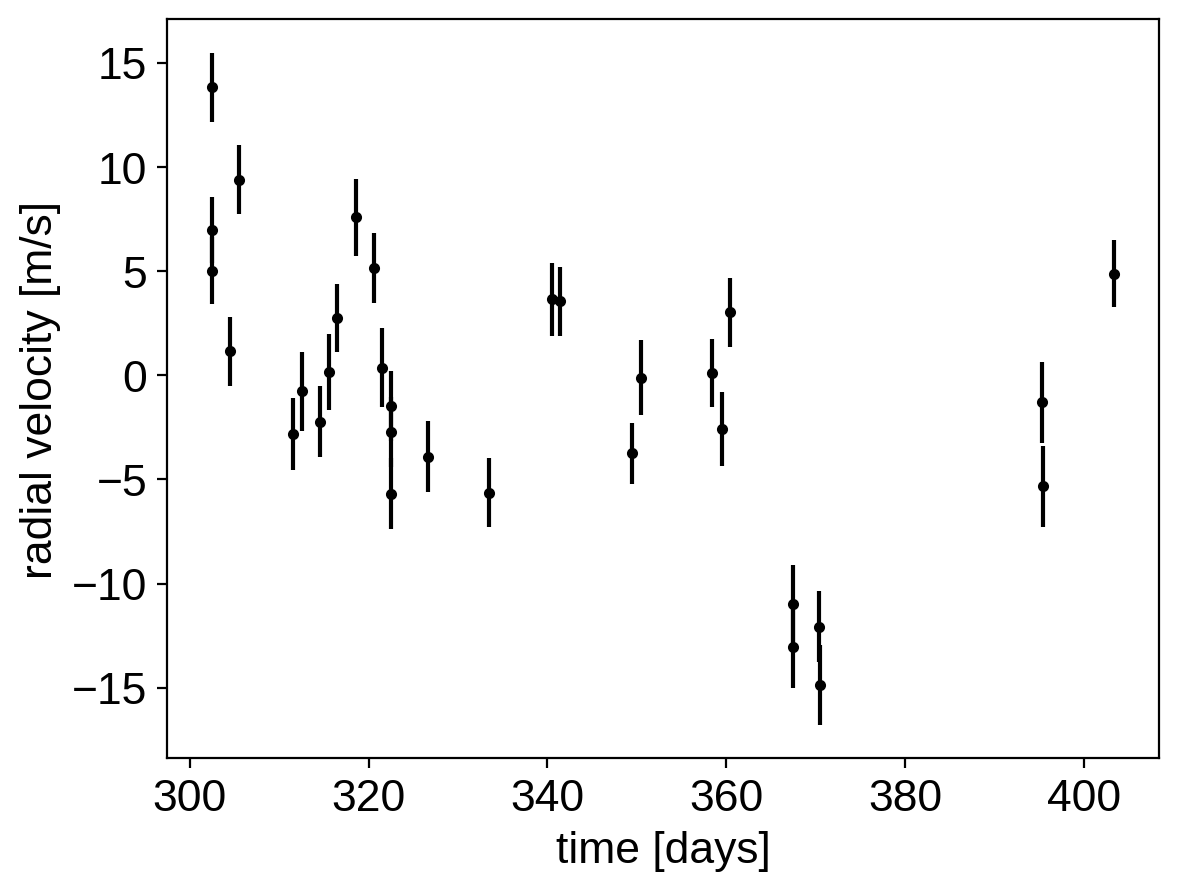

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

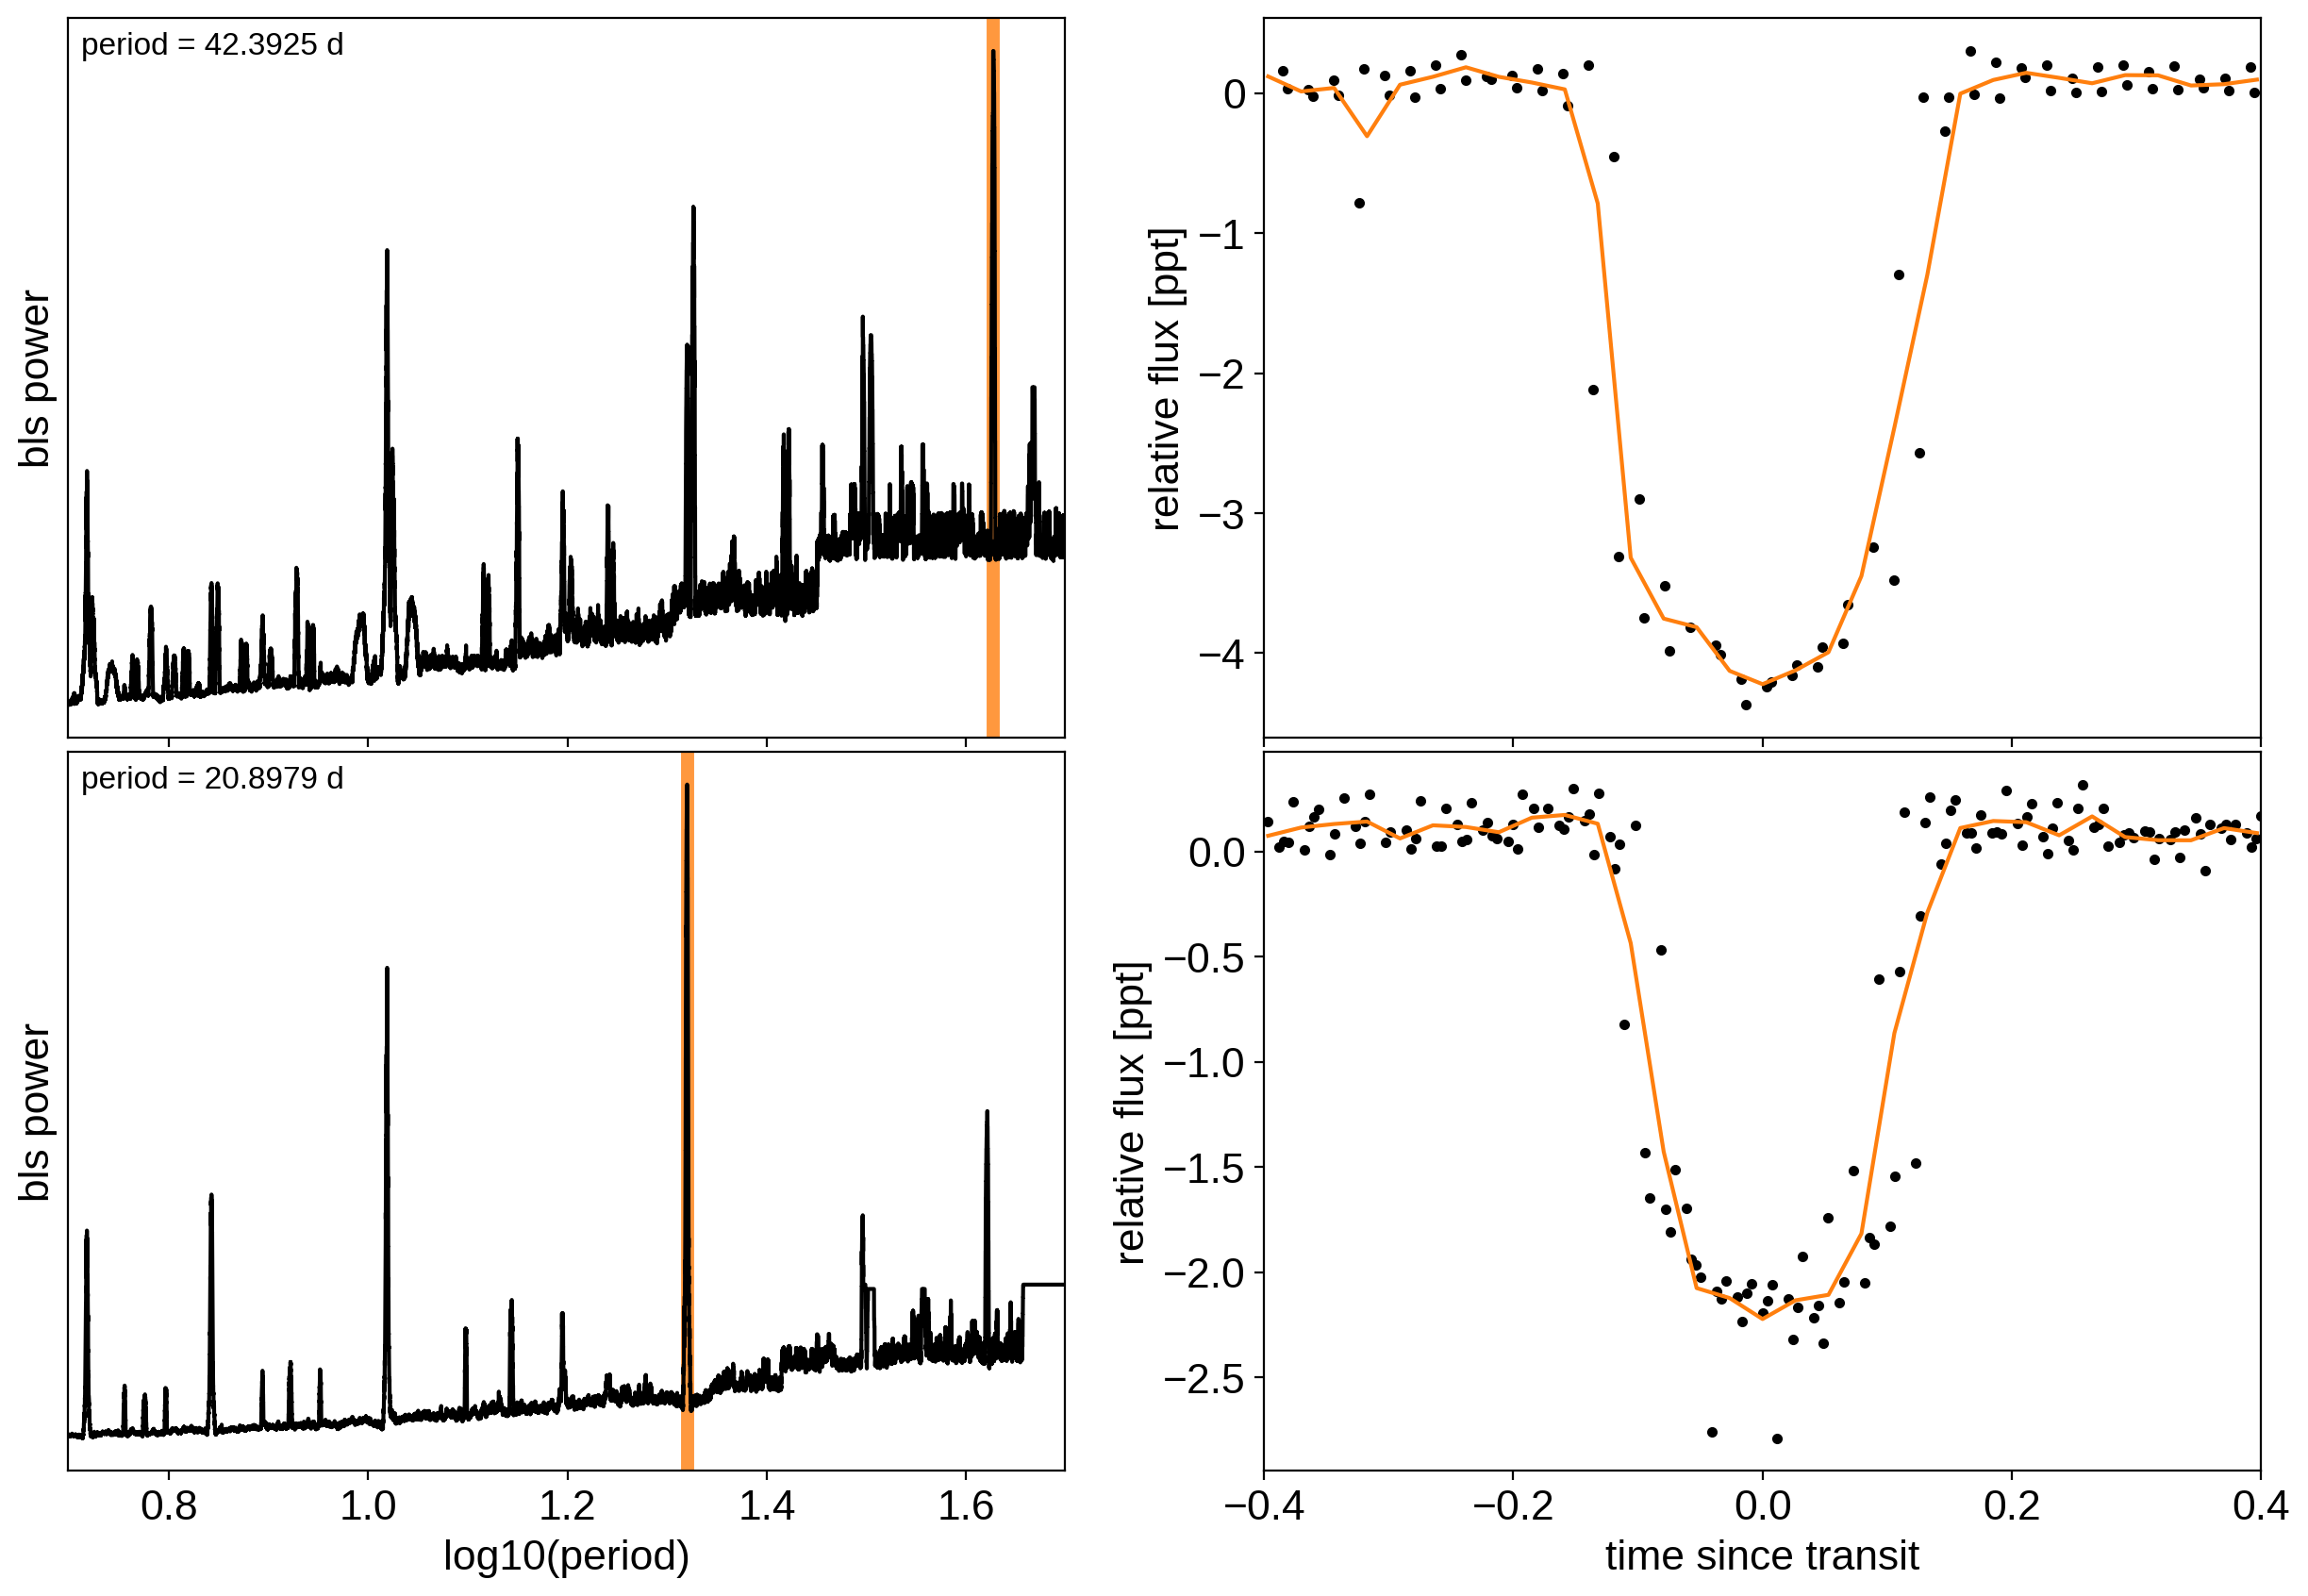

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.ImpactParameter("b", ror=ror, shape=2)

        ecs = xo.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19("ecc_prior", multi=True, shape=2, observed=ecc)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        def mean_model(t):
            light_curves = pm.Deterministic(
                "light_curves",
                xo.LimbDarkLightCurve(u_star).get_light_curve(
                    orbit=orbit, r=r_pl, t=t, texp=texp
                )
                * 1e3,
            )
            return pm.math.sum(light_curves, axis=-1) + mean

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(
            kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), mean=mean_model
        )
        gp.marginal("transit_obs", observed=y[mask])
        pm.Deterministic("gp_pred", gp.predict())

        # And then include the RVs as in the RV tutorial
        x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())

        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_rv_ref, 3)
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.282570e+03]

1it [00:00, 125.27it/s, logp=-8.282570e+03]

2it [00:00, 181.43it/s, logp=-8.282570e+03]

3it [00:00, 218.73it/s, logp=-5.396766e+06]

4it [00:00, 247.12it/s, logp=-8.282310e+03]

5it [00:00, 267.18it/s, logp=-8.281807e+03]

6it [00:00, 284.09it/s, logp=-8.280230e+03]

7it [00:00, 296.15it/s, logp=-8.276461e+03]

8it [00:00, 306.95it/s, logp=-8.270940e+03]

9it [00:00, 315.33it/s, logp=-8.269538e+03]

10it [00:00, 323.05it/s, logp=-8.269538e+03]

11it [00:00, 329.40it/s, logp=-8.269538e+03]

12it [00:13,  1.13s/it, logp=-8.269538e+03] 


message: Optimization terminated successfully.
logp: -8282.57015224409 -> -8269.537627952766


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.269538e+03]

1it [00:00, 118.88it/s, logp=-8.269538e+03]

2it [00:00, 164.08it/s, logp=-8.269538e+03]

3it [00:00, 186.19it/s, logp=-6.546399e+03]

4it [00:00, 201.68it/s, logp=-5.158326e+01]

5it [00:00, 211.91it/s, logp=-3.542397e+05]

6it [00:00, 219.80it/s, logp=1.191602e+02] 

7it [00:00, 225.23it/s, logp=1.770672e+03]

8it [00:00, 229.11it/s, logp=1.852615e+03]

9it [00:00, 233.36it/s, logp=1.995596e+03]

10it [00:00, 234.78it/s, logp=2.108774e+03]

11it [00:00, 236.51it/s, logp=2.117537e+03]

12it [00:00, 238.65it/s, logp=2.117857e+03]

13it [00:00, 240.43it/s, logp=2.117857e+03]

14it [00:00, 241.87it/s, logp=2.117857e+03]

15it [00:01,  8.29it/s, logp=2.117857e+03] 


message: Optimization terminated successfully.
logp: -8269.537627952766 -> 2117.8573435796625


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.117857e+03]

1it [00:00, 133.72it/s, logp=2.117857e+03]

2it [00:00, 180.79it/s, logp=2.117857e+03]

3it [00:00, 207.93it/s, logp=-3.329302e+04]

4it [00:00, 224.53it/s, logp=2.605150e+03] 

5it [00:00, 236.69it/s, logp=1.043564e+02]

6it [00:00, 246.04it/s, logp=2.613717e+03]

7it [00:00, 252.26it/s, logp=2.625068e+03]

8it [00:00, 258.71it/s, logp=2.632251e+03]

9it [00:00, 266.50it/s, logp=2.634707e+03]

10it [00:00, 272.05it/s, logp=2.638709e+03]

11it [00:00, 276.62it/s, logp=2.643221e+03]

12it [00:00, 281.28it/s, logp=2.644818e+03]

13it [00:00, 286.14it/s, logp=2.646322e+03]

14it [00:00, 286.71it/s, logp=2.648624e+03]

15it [00:00, 287.82it/s, logp=2.650278e+03]

16it [00:00, 283.32it/s, logp=2.652850e+03]

17it [00:00, 277.98it/s, logp=2.652902e+03]

18it [00:00, 273.34it/s, logp=2.654227e+03]

19it [00:00, 268.95it/s, logp=2.656489e+03]

20it [00:00, 267.24it/s, logp=2.659707e+03]

21it [00:00, 268.47it/s, logp=2.664800e+03]

22it [00:00, 269.37it/s, logp=2.672599e+03]

23it [00:00, 269.53it/s, logp=2.674744e+03]

24it [00:00, 271.03it/s, logp=2.677564e+03]

25it [00:00, 272.38it/s, logp=2.684600e+03]

26it [00:00, 271.78it/s, logp=2.692404e+03]

27it [00:00, 272.35it/s, logp=2.694286e+03]

28it [00:00, 273.15it/s, logp=2.696434e+03]

29it [00:00, 281.18it/s, logp=2.696434e+03]

29it [00:00, 281.18it/s, logp=2.696793e+03]

30it [00:00, 281.18it/s, logp=2.696792e+03]

31it [00:00, 281.18it/s, logp=2.696815e+03]

32it [00:00, 281.18it/s, logp=2.696822e+03]

33it [00:00, 281.18it/s, logp=2.696822e+03]

34it [00:00, 281.18it/s, logp=2.696822e+03]

35it [00:00, 281.18it/s, logp=2.696822e+03]

36it [00:00, 281.18it/s, logp=2.696822e+03]

37it [00:00, 281.18it/s, logp=2.696822e+03]

38it [00:02, 18.84it/s, logp=2.696822e+03] 


message: Optimization terminated successfully.
logp: 2117.8573435796625 -> 2696.8220532480464


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.696822e+03]

1it [00:00, 141.16it/s, logp=2.696822e+03]

2it [00:00, 200.26it/s, logp=2.696822e+03]

3it [00:00, 228.64it/s, logp=-5.025110e+03]

4it [00:00, 249.87it/s, logp=-1.578971e+02]

5it [00:00, 265.67it/s, logp=-8.006002e+02]

6it [00:00, 277.88it/s, logp=-9.547575e+02]

7it [00:00, 287.19it/s, logp=-6.251277e+02]

8it [00:00, 295.21it/s, logp=9.127022e+02] 

9it [00:00, 300.83it/s, logp=2.893315e+03]

10it [00:00, 305.24it/s, logp=-5.152372e+01]

11it [00:00, 309.41it/s, logp=2.891616e+03] 

12it [00:00, 310.15it/s, logp=2.895660e+03]

13it [00:00, 303.58it/s, logp=2.900379e+03]

14it [00:00, 299.65it/s, logp=2.918882e+03]

15it [00:00, 300.67it/s, logp=2.986599e+03]

16it [00:00, 303.71it/s, logp=3.135572e+03]

17it [00:00, 304.71it/s, logp=3.218986e+03]

18it [00:00, 305.86it/s, logp=3.247635e+03]

19it [00:00, 305.07it/s, logp=3.251831e+03]

20it [00:00, 305.22it/s, logp=3.251921e+03]

21it [00:00, 305.48it/s, logp=3.251922e+03]

22it [00:00, 306.63it/s, logp=3.251922e+03]

23it [00:00, 307.71it/s, logp=3.251922e+03]

24it [00:00, 306.47it/s, logp=3.251922e+03]

25it [00:00, 307.93it/s, logp=3.251922e+03]

26it [00:00, 308.17it/s, logp=3.251922e+03]

27it [00:00, 308.80it/s, logp=3.251922e+03]

28it [00:00, 308.87it/s, logp=3.251922e+03]

29it [00:00, 308.61it/s, logp=3.251922e+03]

30it [00:00, 309.88it/s, logp=3.251922e+03]

31it [00:00, 302.58it/s, logp=3.251922e+03]

32it [00:00, 311.05it/s, logp=3.251922e+03]

32it [00:00, 311.05it/s, logp=3.251922e+03]

33it [00:00, 311.05it/s, logp=3.251922e+03]

34it [00:00, 311.05it/s, logp=3.251922e+03]

35it [00:00, 311.05it/s, logp=3.251922e+03]

36it [00:00, 311.05it/s, logp=3.251922e+03]

37it [00:00, 311.05it/s, logp=3.251922e+03]

38it [00:00, 311.05it/s, logp=3.251922e+03]

39it [00:00, 311.05it/s, logp=3.251922e+03]

40it [00:00, 311.05it/s, logp=3.251922e+03]

41it [00:00, 311.05it/s, logp=3.251922e+03]

42it [00:00, 311.05it/s, logp=3.251922e+03]

43it [00:00, 311.05it/s, logp=3.251922e+03]

44it [00:00, 311.05it/s, logp=3.251922e+03]

45it [00:00, 311.05it/s, logp=3.251922e+03]

46it [00:00, 311.05it/s, logp=3.251922e+03]

47it [00:00, 311.05it/s, logp=3.251922e+03]

48it [00:00, 311.05it/s, logp=3.251922e+03]

49it [00:00, 311.05it/s, logp=3.251922e+03]

50it [00:00, 311.05it/s, logp=3.251922e+03]

51it [00:00, 311.05it/s, logp=3.251922e+03]

52it [00:00, 311.05it/s, logp=3.251922e+03]

53it [00:00, 311.05it/s, logp=3.251922e+03]

54it [00:00, 311.05it/s, logp=3.251922e+03]

55it [00:00, 311.05it/s, logp=3.251922e+03]

56it [00:00, 311.05it/s, logp=3.251922e+03]

57it [00:00, 311.05it/s, logp=3.251922e+03]

58it [00:00, 311.05it/s, logp=3.251922e+03]

59it [00:00, 311.05it/s, logp=3.251922e+03]

60it [00:00, 311.05it/s, logp=3.251922e+03]

61it [00:00, 311.05it/s, logp=3.251922e+03]

62it [00:00, 311.05it/s, logp=3.251922e+03]

63it [00:00, 311.05it/s, logp=3.251922e+03]

64it [00:00, 311.05it/s, logp=3.251922e+03]

65it [00:00, 311.05it/s, logp=3.251922e+03]

66it [00:00, 317.24it/s, logp=3.251922e+03]

66it [00:00, 317.24it/s, logp=3.251922e+03]

67it [00:00, 317.24it/s, logp=3.251922e+03]

68it [00:00, 317.24it/s, logp=3.251922e+03]

69it [00:00, 317.24it/s, logp=3.251922e+03]

70it [00:00, 317.24it/s, logp=3.251922e+03]

71it [00:00, 317.24it/s, logp=3.251922e+03]

72it [00:00, 317.24it/s, logp=3.251922e+03]

73it [00:00, 317.24it/s, logp=3.251922e+03]

74it [00:00, 317.24it/s, logp=3.251922e+03]

75it [00:00, 317.24it/s, logp=3.251922e+03]

76it [00:00, 317.24it/s, logp=3.251922e+03]

77it [00:00, 317.24it/s, logp=3.251922e+03]

78it [00:00, 317.24it/s, logp=3.251922e+03]

79it [00:00, 317.24it/s, logp=3.251922e+03]

80it [00:00, 317.24it/s, logp=3.251922e+03]

81it [00:00, 317.24it/s, logp=3.251922e+03]

82it [00:00, 317.24it/s, logp=3.251922e+03]

83it [00:00, 317.24it/s, logp=3.251922e+03]

84it [00:00, 317.24it/s, logp=3.251922e+03]

85it [00:00, 317.24it/s, logp=3.251922e+03]

86it [00:00, 317.24it/s, logp=3.251922e+03]

87it [00:00, 317.24it/s, logp=3.251922e+03]

88it [00:00, 317.24it/s, logp=3.251922e+03]

89it [00:00, 317.24it/s, logp=3.251922e+03]

90it [00:00, 317.24it/s, logp=3.251922e+03]

91it [00:00, 317.24it/s, logp=3.251922e+03]

92it [00:00, 317.24it/s, logp=3.251922e+03]

93it [00:00, 301.27it/s, logp=3.251922e+03]

93it [00:00, 301.27it/s, logp=3.251922e+03]

94it [00:00, 301.27it/s, logp=3.251922e+03]

95it [00:00, 301.27it/s, logp=3.251922e+03]

96it [00:00, 301.27it/s, logp=3.251922e+03]

97it [00:00, 301.27it/s, logp=3.251922e+03]

98it [00:00, 301.27it/s, logp=3.251922e+03]

99it [00:00, 301.27it/s, logp=3.251922e+03]

100it [00:00, 301.27it/s, logp=3.251922e+03]

101it [00:00, 301.27it/s, logp=3.251922e+03]

102it [00:00, 301.27it/s, logp=3.251922e+03]

103it [00:00, 301.27it/s, logp=3.251922e+03]

104it [00:00, 301.27it/s, logp=3.251922e+03]

105it [00:00, 301.27it/s, logp=3.251922e+03]

106it [00:00, 301.27it/s, logp=3.251922e+03]

107it [00:00, 301.27it/s, logp=3.251922e+03]

108it [00:00, 301.27it/s, logp=3.251922e+03]

109it [00:00, 301.27it/s, logp=3.251922e+03]

110it [00:00, 301.27it/s, logp=3.251922e+03]

111it [00:00, 301.27it/s, logp=3.251922e+03]

112it [00:00, 301.27it/s, logp=3.251922e+03]

113it [00:00, 301.27it/s, logp=3.251922e+03]

114it [00:00, 301.27it/s, logp=3.251922e+03]

115it [00:00, 301.27it/s, logp=3.251922e+03]

116it [00:00, 301.27it/s, logp=3.251922e+03]

117it [00:00, 301.27it/s, logp=3.251922e+03]

118it [00:00, 301.27it/s, logp=3.251922e+03]

119it [00:00, 301.27it/s, logp=3.251922e+03]

120it [00:00, 301.27it/s, logp=3.251922e+03]

121it [00:00, 301.27it/s, logp=3.251922e+03]

122it [00:00, 301.27it/s, logp=3.251922e+03]

123it [00:00, 301.27it/s, logp=3.251922e+03]

124it [00:00, 302.31it/s, logp=3.251922e+03]

124it [00:00, 302.31it/s, logp=3.251922e+03]

125it [00:00, 302.31it/s, logp=3.251922e+03]

126it [00:00, 302.31it/s, logp=3.251922e+03]

127it [00:00, 302.31it/s, logp=3.251922e+03]

128it [00:00, 302.31it/s, logp=3.251922e+03]

129it [00:00, 302.31it/s, logp=3.251922e+03]

130it [00:00, 302.31it/s, logp=3.251922e+03]

131it [00:00, 302.31it/s, logp=3.251922e+03]

132it [00:00, 302.31it/s, logp=3.251922e+03]

133it [00:00, 302.31it/s, logp=3.251922e+03]

134it [00:02, 58.07it/s, logp=3.251922e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2696.8220532480464 -> 3251.9220705309353


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.251922e+03]

1it [00:00, 145.40it/s, logp=3.251922e+03]

2it [00:00, 199.46it/s, logp=3.251922e+03]

3it [00:00, 226.93it/s, logp=3.750351e+03]

4it [00:00, 242.04it/s, logp=-4.142749e+03]

5it [00:00, 258.97it/s, logp=3.902669e+03] 

6it [00:00, 270.38it/s, logp=3.905053e+03]

7it [00:00, 273.34it/s, logp=3.906091e+03]

8it [00:00, 281.15it/s, logp=3.906092e+03]

9it [00:00, 284.68it/s, logp=3.906093e+03]

10it [00:00, 290.29it/s, logp=3.906093e+03]

11it [00:00, 291.52it/s, logp=3.906093e+03]

12it [00:00, 292.62it/s, logp=3.906093e+03]

13it [00:00, 297.41it/s, logp=3.906093e+03]

14it [00:00, 299.28it/s, logp=3.906093e+03]

15it [00:00, 302.93it/s, logp=3.906093e+03]

16it [00:00, 304.69it/s, logp=3.906093e+03]

17it [00:00, 305.95it/s, logp=3.906093e+03]

18it [00:00, 308.61it/s, logp=3.906093e+03]

19it [00:00, 310.66it/s, logp=3.906093e+03]

20it [00:00, 311.38it/s, logp=3.906093e+03]

21it [00:00, 312.18it/s, logp=3.906093e+03]

22it [00:00, 314.40it/s, logp=3.906093e+03]

23it [00:00, 316.15it/s, logp=3.906093e+03]

24it [00:00, 316.17it/s, logp=3.906093e+03]

25it [00:00, 317.98it/s, logp=3.906093e+03]

26it [00:00, 318.54it/s, logp=3.906093e+03]

27it [00:00, 319.43it/s, logp=3.906093e+03]

28it [00:00, 320.54it/s, logp=3.906093e+03]

29it [00:00, 320.86it/s, logp=3.906093e+03]

30it [00:00, 321.42it/s, logp=3.906093e+03]

31it [00:00, 321.93it/s, logp=3.906093e+03]

32it [00:00, 322.17it/s, logp=3.906093e+03]

33it [00:00, 329.87it/s, logp=3.906093e+03]

33it [00:00, 329.87it/s, logp=3.906093e+03]

34it [00:00, 329.87it/s, logp=3.906093e+03]

35it [00:00, 329.87it/s, logp=3.906093e+03]

36it [00:00, 329.87it/s, logp=3.906093e+03]

37it [00:00, 329.87it/s, logp=3.906093e+03]

38it [00:00, 329.87it/s, logp=3.906093e+03]

39it [00:00, 329.87it/s, logp=3.906093e+03]

40it [00:00, 329.87it/s, logp=3.906093e+03]

41it [00:00, 329.87it/s, logp=3.906093e+03]

42it [00:00, 329.87it/s, logp=3.906093e+03]

43it [00:00, 329.87it/s, logp=3.906093e+03]

44it [00:00, 329.87it/s, logp=3.906093e+03]

45it [00:00, 329.87it/s, logp=3.906093e+03]

46it [00:00, 329.87it/s, logp=3.906093e+03]

47it [00:00, 329.87it/s, logp=3.906093e+03]

48it [00:00, 329.87it/s, logp=3.906093e+03]

49it [00:00, 329.87it/s, logp=3.906093e+03]

50it [00:00, 329.87it/s, logp=3.906093e+03]

51it [00:00, 329.87it/s, logp=3.906093e+03]

52it [00:00, 329.87it/s, logp=3.906093e+03]

53it [00:00, 329.87it/s, logp=3.906093e+03]

54it [00:00, 329.87it/s, logp=3.906093e+03]

55it [00:00, 329.87it/s, logp=3.906093e+03]

56it [00:00, 329.87it/s, logp=3.906093e+03]

57it [00:00, 329.87it/s, logp=3.906093e+03]

58it [00:00, 329.87it/s, logp=3.906093e+03]

59it [00:00, 329.87it/s, logp=3.906093e+03]

60it [00:00, 329.87it/s, logp=3.906093e+03]

61it [00:00, 329.87it/s, logp=3.906093e+03]

62it [00:00, 329.87it/s, logp=3.906093e+03]

63it [00:00, 329.87it/s, logp=3.906093e+03]

64it [00:00, 329.87it/s, logp=3.906093e+03]

65it [00:00, 329.87it/s, logp=3.906093e+03]

66it [00:00, 329.87it/s, logp=3.906093e+03]

67it [00:00, 331.07it/s, logp=3.906093e+03]

67it [00:00, 331.07it/s, logp=3.906093e+03]

68it [00:00, 331.07it/s, logp=3.906093e+03]

69it [00:00, 331.07it/s, logp=3.906093e+03]

70it [00:00, 331.07it/s, logp=3.906093e+03]

71it [00:00, 331.07it/s, logp=3.906093e+03]

72it [00:00, 331.07it/s, logp=3.906093e+03]

73it [00:00, 331.07it/s, logp=3.906093e+03]

74it [00:00, 331.07it/s, logp=3.906093e+03]

75it [00:00, 331.07it/s, logp=3.906093e+03]

76it [00:00, 331.07it/s, logp=3.906093e+03]

77it [00:00, 331.07it/s, logp=3.906093e+03]

78it [00:00, 331.07it/s, logp=3.906093e+03]

79it [00:00, 331.07it/s, logp=3.906093e+03]

80it [00:00, 331.07it/s, logp=3.906093e+03]

81it [00:00, 331.07it/s, logp=3.906093e+03]

82it [00:00, 331.07it/s, logp=3.906093e+03]

83it [00:00, 331.07it/s, logp=3.906093e+03]

84it [00:00, 331.07it/s, logp=3.906093e+03]

85it [00:00, 331.07it/s, logp=3.906093e+03]

86it [00:00, 331.07it/s, logp=3.906093e+03]

87it [00:00, 331.07it/s, logp=3.906093e+03]

88it [00:00, 331.07it/s, logp=3.906093e+03]

89it [00:00, 331.07it/s, logp=3.906093e+03]

90it [00:00, 331.07it/s, logp=3.906093e+03]

91it [00:00, 331.07it/s, logp=3.906093e+03]

92it [00:00, 331.07it/s, logp=3.906093e+03]

93it [00:00, 331.07it/s, logp=3.906093e+03]

94it [00:00, 331.07it/s, logp=3.906093e+03]

95it [00:00, 331.07it/s, logp=3.906093e+03]

96it [00:00, 331.07it/s, logp=3.906093e+03]

97it [00:00, 331.07it/s, logp=3.906093e+03]

98it [00:00, 321.32it/s, logp=3.906093e+03]

98it [00:00, 321.32it/s, logp=3.906093e+03]

99it [00:00, 321.32it/s, logp=3.906093e+03]

100it [00:00, 321.32it/s, logp=3.906093e+03]

101it [00:00, 321.32it/s, logp=3.906093e+03]

102it [00:00, 321.32it/s, logp=3.906093e+03]

103it [00:00, 321.32it/s, logp=3.906093e+03]

104it [00:00, 321.32it/s, logp=3.906093e+03]

105it [00:00, 321.32it/s, logp=3.906093e+03]

106it [00:00, 321.32it/s, logp=3.906093e+03]

107it [00:00, 321.32it/s, logp=3.906093e+03]

108it [00:00, 321.32it/s, logp=3.906093e+03]

109it [00:00, 321.32it/s, logp=3.906093e+03]

110it [00:00, 321.32it/s, logp=3.906093e+03]

111it [00:00, 321.32it/s, logp=3.906093e+03]

112it [00:00, 321.32it/s, logp=3.906093e+03]

113it [00:00, 321.32it/s, logp=3.906093e+03]

114it [00:00, 321.32it/s, logp=3.906093e+03]

115it [00:00, 321.32it/s, logp=3.906093e+03]

116it [00:00, 321.32it/s, logp=3.906093e+03]

117it [00:00, 321.32it/s, logp=3.906093e+03]

118it [00:00, 321.32it/s, logp=3.906093e+03]

119it [00:00, 321.32it/s, logp=3.906093e+03]

120it [00:00, 321.32it/s, logp=3.906093e+03]

121it [00:00, 321.32it/s, logp=3.906093e+03]

122it [00:00, 321.32it/s, logp=3.906093e+03]

123it [00:00, 321.32it/s, logp=3.906093e+03]

124it [00:00, 321.32it/s, logp=3.906093e+03]

125it [00:00, 321.32it/s, logp=3.906093e+03]

126it [00:00, 321.32it/s, logp=3.906093e+03]

127it [00:00, 321.32it/s, logp=3.906093e+03]

128it [00:00, 312.16it/s, logp=3.906093e+03]

128it [00:00, 312.16it/s, logp=3.906093e+03]

129it [00:00, 312.16it/s, logp=3.906093e+03]

130it [00:00, 312.16it/s, logp=3.906093e+03]

131it [00:02, 57.40it/s, logp=3.906093e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 3251.922070530933 -> 3906.092568184921


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.906093e+03]

1it [00:00, 129.12it/s, logp=3.906093e+03]

2it [00:00, 176.32it/s, logp=3.906093e+03]

3it [00:00, 200.81it/s, logp=4.009198e+03]

4it [00:00, 215.33it/s, logp=4.009404e+03]

5it [00:00, 226.97it/s, logp=4.010104e+03]

6it [00:00, 236.45it/s, logp=4.010129e+03]

7it [00:00, 232.58it/s, logp=4.010545e+03]

8it [00:00, 231.65it/s, logp=4.010571e+03]

9it [00:00, 229.61it/s, logp=4.010575e+03]

10it [00:00, 231.81it/s, logp=4.010575e+03]

11it [00:00, 236.17it/s, logp=4.010575e+03]

12it [00:01,  6.23it/s, logp=4.010575e+03] 


message: Optimization terminated successfully.
logp: 3906.092568184921 -> 4010.575080730371


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.010575e+03]

1it [00:00, 98.15it/s, logp=4.010575e+03]

2it [00:00, 143.29it/s, logp=4.010575e+03]

3it [00:00, 168.86it/s, logp=-5.648716e+03]

4it [00:00, 187.76it/s, logp=-8.077767e+03]

5it [00:00, 200.74it/s, logp=-1.148771e+04]

6it [00:00, 210.80it/s, logp=3.996128e+03] 

7it [00:00, 218.65it/s, logp=4.010674e+03]

8it [00:00, 222.86it/s, logp=4.006483e+03]

9it [00:00, 228.37it/s, logp=4.010677e+03]

10it [00:00, 231.30it/s, logp=4.010681e+03]

11it [00:00, 235.13it/s, logp=4.010701e+03]

12it [00:00, 237.74it/s, logp=4.010777e+03]

13it [00:00, 239.56it/s, logp=4.011078e+03]

14it [00:00, 241.89it/s, logp=4.012201e+03]

15it [00:00, 243.11it/s, logp=4.015035e+03]

16it [00:00, 244.08it/s, logp=4.020604e+03]

17it [00:00, 245.67it/s, logp=4.039674e+03]

18it [00:00, 246.73it/s, logp=4.059294e+03]

19it [00:00, 247.44it/s, logp=3.954586e+03]

20it [00:00, 249.11it/s, logp=4.061974e+03]

21it [00:00, 249.67it/s, logp=4.067140e+03]

22it [00:00, 250.74it/s, logp=4.082740e+03]

23it [00:00, 251.18it/s, logp=4.122560e+03]

24it [00:00, 251.41it/s, logp=4.196767e+03]

25it [00:00, 251.99it/s, logp=4.295353e+03]

26it [00:00, 252.35it/s, logp=4.389364e+03]

27it [00:00, 260.70it/s, logp=4.389364e+03]

27it [00:00, 260.70it/s, logp=3.946451e+03]

28it [00:00, 260.70it/s, logp=4.404683e+03]

29it [00:00, 260.70it/s, logp=4.424397e+03]

30it [00:00, 260.70it/s, logp=4.448485e+03]

31it [00:00, 260.70it/s, logp=4.469955e+03]

32it [00:00, 260.70it/s, logp=4.484363e+03]

33it [00:00, 260.70it/s, logp=4.506999e+03]

34it [00:00, 260.70it/s, logp=4.385908e+03]

35it [00:00, 260.70it/s, logp=4.512442e+03]

36it [00:00, 260.70it/s, logp=4.521653e+03]

37it [00:00, 260.70it/s, logp=4.538413e+03]

38it [00:00, 260.70it/s, logp=4.557672e+03]

39it [00:00, 260.70it/s, logp=4.579036e+03]

40it [00:00, 260.70it/s, logp=4.601594e+03]

41it [00:00, 260.70it/s, logp=4.604420e+03]

42it [00:00, 260.70it/s, logp=4.609730e+03]

43it [00:00, 260.70it/s, logp=4.618268e+03]

44it [00:00, 260.70it/s, logp=4.627015e+03]

45it [00:00, 228.10it/s, logp=4.627015e+03]

45it [00:00, 228.10it/s, logp=4.638103e+03]

46it [00:00, 228.10it/s, logp=4.634427e+03]

47it [00:00, 228.10it/s, logp=4.641840e+03]

48it [00:00, 228.10it/s, logp=4.647894e+03]

49it [00:00, 228.10it/s, logp=4.657568e+03]

50it [00:00, 228.10it/s, logp=4.665155e+03]

51it [00:00, 228.10it/s, logp=4.675746e+03]

52it [00:00, 228.10it/s, logp=4.680753e+03]

53it [00:00, 228.10it/s, logp=4.687043e+03]

54it [00:00, 228.10it/s, logp=4.693320e+03]

55it [00:00, 228.10it/s, logp=4.697477e+03]

56it [00:00, 228.10it/s, logp=4.703138e+03]

57it [00:00, 228.10it/s, logp=4.706266e+03]

58it [00:00, 228.10it/s, logp=4.709462e+03]

59it [00:00, 228.10it/s, logp=4.711735e+03]

60it [00:00, 228.10it/s, logp=4.713150e+03]

61it [00:00, 228.10it/s, logp=4.712489e+03]

62it [00:00, 228.10it/s, logp=4.713723e+03]

63it [00:00, 228.10it/s, logp=4.714329e+03]

64it [00:00, 228.10it/s, logp=4.714660e+03]

65it [00:00, 228.10it/s, logp=4.715059e+03]

66it [00:00, 228.10it/s, logp=4.715420e+03]

67it [00:00, 224.40it/s, logp=4.715420e+03]

67it [00:00, 224.40it/s, logp=4.715831e+03]

68it [00:00, 224.40it/s, logp=4.716255e+03]

69it [00:00, 224.40it/s, logp=4.716816e+03]

70it [00:00, 224.40it/s, logp=4.717297e+03]

71it [00:00, 224.40it/s, logp=4.717773e+03]

72it [00:00, 224.40it/s, logp=4.718298e+03]

73it [00:00, 224.40it/s, logp=4.718673e+03]

74it [00:00, 224.40it/s, logp=4.718961e+03]

75it [00:00, 224.40it/s, logp=4.719254e+03]

76it [00:00, 224.40it/s, logp=4.719496e+03]

77it [00:00, 224.40it/s, logp=4.719679e+03]

78it [00:00, 224.40it/s, logp=4.719762e+03]

79it [00:00, 224.40it/s, logp=4.719871e+03]

80it [00:00, 224.40it/s, logp=4.720053e+03]

81it [00:00, 224.40it/s, logp=4.720370e+03]

82it [00:00, 224.40it/s, logp=4.720913e+03]

83it [00:00, 224.40it/s, logp=4.720948e+03]

84it [00:00, 224.40it/s, logp=4.721212e+03]

85it [00:00, 224.40it/s, logp=4.721699e+03]

86it [00:00, 210.87it/s, logp=4.721699e+03]

86it [00:00, 210.87it/s, logp=4.722278e+03]

87it [00:00, 210.87it/s, logp=4.723214e+03]

88it [00:00, 210.87it/s, logp=4.724894e+03]

89it [00:00, 210.87it/s, logp=4.727753e+03]

90it [00:00, 210.87it/s, logp=4.731058e+03]

91it [00:00, 210.87it/s, logp=4.731766e+03]

92it [00:00, 210.87it/s, logp=4.732773e+03]

93it [00:00, 210.87it/s, logp=4.734315e+03]

94it [00:00, 210.87it/s, logp=4.735246e+03]

95it [00:00, 210.87it/s, logp=4.735668e+03]

96it [00:00, 210.87it/s, logp=4.735918e+03]

97it [00:00, 210.87it/s, logp=4.736141e+03]

98it [00:00, 210.87it/s, logp=4.736236e+03]

99it [00:00, 210.87it/s, logp=4.736279e+03]

100it [00:00, 210.87it/s, logp=4.736293e+03]

101it [00:00, 210.87it/s, logp=4.736297e+03]

102it [00:00, 210.87it/s, logp=4.736304e+03]

103it [00:00, 210.87it/s, logp=4.736315e+03]

104it [00:00, 210.87it/s, logp=4.736336e+03]

105it [00:00, 210.87it/s, logp=4.736369e+03]

106it [00:00, 210.87it/s, logp=4.736414e+03]

107it [00:00, 210.87it/s, logp=4.736445e+03]

108it [00:00, 210.87it/s, logp=4.736461e+03]

109it [00:00, 210.16it/s, logp=4.736461e+03]

109it [00:00, 210.16it/s, logp=4.736472e+03]

110it [00:00, 210.16it/s, logp=4.736476e+03]

111it [00:00, 210.16it/s, logp=4.736479e+03]

112it [00:00, 210.16it/s, logp=4.736484e+03]

113it [00:00, 210.16it/s, logp=4.736491e+03]

114it [00:00, 210.16it/s, logp=4.736504e+03]

115it [00:00, 210.16it/s, logp=4.736524e+03]

116it [00:00, 210.16it/s, logp=4.736556e+03]

117it [00:00, 210.16it/s, logp=4.736591e+03]

118it [00:00, 210.16it/s, logp=4.736628e+03]

119it [00:00, 210.16it/s, logp=4.736663e+03]

120it [00:00, 210.16it/s, logp=4.736687e+03]

121it [00:00, 210.16it/s, logp=4.736719e+03]

122it [00:00, 210.16it/s, logp=4.736702e+03]

123it [00:00, 210.16it/s, logp=4.736727e+03]

124it [00:00, 210.16it/s, logp=4.736740e+03]

125it [00:00, 210.16it/s, logp=4.736749e+03]

126it [00:00, 210.16it/s, logp=4.736753e+03]

127it [00:00, 210.16it/s, logp=4.736756e+03]

128it [00:00, 210.16it/s, logp=4.736760e+03]

129it [00:00, 210.16it/s, logp=4.736764e+03]

130it [00:00, 210.16it/s, logp=4.736769e+03]

131it [00:00, 210.16it/s, logp=4.736771e+03]

132it [00:00, 214.25it/s, logp=4.736771e+03]

132it [00:00, 214.25it/s, logp=4.736774e+03]

133it [00:00, 214.25it/s, logp=4.736779e+03]

134it [00:00, 214.25it/s, logp=4.736786e+03]

135it [00:00, 214.25it/s, logp=4.736792e+03]

136it [00:00, 214.25it/s, logp=4.736792e+03]

137it [00:00, 214.25it/s, logp=4.736795e+03]

138it [00:00, 214.25it/s, logp=4.736799e+03]

139it [00:00, 214.25it/s, logp=4.736806e+03]

140it [00:00, 214.25it/s, logp=4.736819e+03]

141it [00:00, 214.25it/s, logp=4.736842e+03]

142it [00:00, 214.25it/s, logp=4.736864e+03]

143it [00:00, 214.25it/s, logp=4.736863e+03]

144it [00:00, 214.25it/s, logp=4.736841e+03]

145it [00:00, 214.25it/s, logp=4.736871e+03]

146it [00:00, 214.25it/s, logp=4.736886e+03]

147it [00:00, 214.25it/s, logp=4.736912e+03]

148it [00:00, 214.25it/s, logp=4.736954e+03]

149it [00:00, 214.25it/s, logp=4.736980e+03]

150it [00:00, 214.25it/s, logp=4.737015e+03]

151it [00:00, 214.25it/s, logp=4.737041e+03]

152it [00:00, 214.25it/s, logp=4.737074e+03]

153it [00:00, 214.25it/s, logp=4.737096e+03]

154it [00:00, 214.25it/s, logp=4.737102e+03]

155it [00:00, 218.24it/s, logp=4.737102e+03]

155it [00:00, 218.24it/s, logp=4.737107e+03]

156it [00:00, 218.24it/s, logp=4.737113e+03]

157it [00:00, 218.24it/s, logp=4.737110e+03]

158it [00:00, 218.24it/s, logp=4.737115e+03]

159it [00:00, 218.24it/s, logp=4.737118e+03]

160it [00:00, 218.24it/s, logp=4.737120e+03]

161it [00:00, 218.24it/s, logp=4.737121e+03]

162it [00:00, 218.24it/s, logp=4.737123e+03]

163it [00:00, 218.24it/s, logp=4.737125e+03]

164it [00:00, 218.24it/s, logp=4.737128e+03]

165it [00:00, 218.24it/s, logp=4.737132e+03]

166it [00:00, 218.24it/s, logp=4.737134e+03]

167it [00:00, 218.24it/s, logp=4.737135e+03]

168it [00:00, 218.24it/s, logp=4.737136e+03]

169it [00:00, 218.24it/s, logp=4.737136e+03]

170it [00:00, 218.24it/s, logp=4.737136e+03]

171it [00:00, 218.24it/s, logp=4.737136e+03]

172it [00:00, 218.24it/s, logp=4.737136e+03]

173it [00:00, 218.24it/s, logp=4.737137e+03]

174it [00:00, 218.24it/s, logp=4.737060e+03]

175it [00:00, 218.24it/s, logp=4.737138e+03]

176it [00:00, 218.24it/s, logp=4.736639e+03]

177it [00:00, 218.24it/s, logp=4.737137e+03]

178it [00:00, 218.24it/s, logp=4.737138e+03]

179it [00:00, 218.24it/s, logp=4.737138e+03]

180it [00:00, 226.85it/s, logp=4.737138e+03]

180it [00:00, 226.85it/s, logp=4.737138e+03]

181it [00:00, 226.85it/s, logp=4.737140e+03]

182it [00:00, 226.85it/s, logp=4.737143e+03]

183it [00:00, 226.85it/s, logp=4.737148e+03]

184it [00:00, 226.85it/s, logp=4.737158e+03]

185it [00:00, 226.85it/s, logp=4.737175e+03]

186it [00:00, 226.85it/s, logp=4.737194e+03]

187it [00:00, 226.85it/s, logp=4.737162e+03]

188it [00:00, 226.85it/s, logp=4.737197e+03]

189it [00:00, 226.85it/s, logp=4.737198e+03]

190it [00:00, 226.85it/s, logp=4.737198e+03]

191it [00:00, 226.85it/s, logp=4.737198e+03]

192it [00:00, 226.85it/s, logp=4.737198e+03]

193it [00:00, 226.85it/s, logp=4.737198e+03]

194it [00:00, 226.85it/s, logp=4.737198e+03]

195it [00:00, 226.85it/s, logp=4.737198e+03]

196it [00:00, 226.85it/s, logp=4.737198e+03]

197it [00:00, 226.85it/s, logp=4.737198e+03]

198it [00:00, 226.85it/s, logp=4.737198e+03]

199it [00:00, 226.85it/s, logp=4.737198e+03]

200it [00:00, 226.85it/s, logp=4.737198e+03]

201it [00:00, 226.85it/s, logp=4.737198e+03]

202it [00:00, 226.85it/s, logp=4.737198e+03]

203it [00:00, 226.85it/s, logp=4.737198e+03]

204it [00:00, 226.85it/s, logp=4.737199e+03]

205it [00:00, 230.87it/s, logp=4.737199e+03]

205it [00:00, 230.87it/s, logp=4.737199e+03]

206it [00:00, 230.87it/s, logp=4.737199e+03]

207it [00:00, 230.87it/s, logp=4.737199e+03]

208it [00:00, 230.87it/s, logp=4.737199e+03]

209it [00:00, 230.87it/s, logp=4.737199e+03]

210it [00:00, 230.87it/s, logp=4.737199e+03]

211it [00:00, 230.87it/s, logp=4.737199e+03]

212it [00:00, 230.87it/s, logp=4.737199e+03]

213it [00:00, 230.87it/s, logp=4.737199e+03]

214it [00:00, 230.87it/s, logp=4.737199e+03]

215it [00:00, 230.87it/s, logp=4.737199e+03]

216it [00:00, 230.87it/s, logp=4.737199e+03]

217it [00:00, 230.87it/s, logp=4.737199e+03]

218it [00:00, 230.87it/s, logp=4.737199e+03]

219it [00:00, 230.87it/s, logp=4.737199e+03]

220it [00:00, 230.87it/s, logp=4.737199e+03]

221it [00:00, 230.87it/s, logp=4.737199e+03]

222it [00:01, 230.87it/s, logp=4.737199e+03]

223it [00:01, 230.87it/s, logp=4.737199e+03]

224it [00:01, 230.87it/s, logp=4.737199e+03]

225it [00:01, 230.87it/s, logp=4.737199e+03]

226it [00:01, 230.87it/s, logp=4.737199e+03]

227it [00:01, 230.87it/s, logp=4.737199e+03]

228it [00:01, 230.87it/s, logp=4.737199e+03]

229it [00:01, 230.87it/s, logp=4.737199e+03]

230it [00:01, 230.87it/s, logp=4.737199e+03]

231it [00:01, 236.81it/s, logp=4.737199e+03]

231it [00:01, 236.81it/s, logp=4.737199e+03]

232it [00:01, 236.81it/s, logp=4.737199e+03]

233it [00:01, 236.81it/s, logp=4.737199e+03]

234it [00:01, 236.81it/s, logp=4.737199e+03]

235it [00:01, 236.81it/s, logp=4.737199e+03]

236it [00:01, 236.81it/s, logp=4.737199e+03]

237it [00:01, 236.81it/s, logp=4.737199e+03]

238it [00:01, 236.81it/s, logp=4.737199e+03]

239it [00:01, 236.81it/s, logp=4.737199e+03]

240it [00:01, 236.81it/s, logp=4.737199e+03]

241it [00:01, 236.81it/s, logp=4.737199e+03]

242it [00:01, 236.81it/s, logp=4.737199e+03]

243it [00:01, 236.81it/s, logp=4.737199e+03]

244it [00:01, 236.81it/s, logp=4.737199e+03]

245it [00:01, 236.81it/s, logp=4.737199e+03]

246it [00:01, 236.81it/s, logp=4.737199e+03]

247it [00:01, 236.81it/s, logp=4.737199e+03]

248it [00:01, 236.81it/s, logp=4.737199e+03]

249it [00:01, 236.81it/s, logp=4.737199e+03]

250it [00:01, 236.81it/s, logp=4.737199e+03]

251it [00:01, 236.81it/s, logp=4.737199e+03]

252it [00:01, 236.81it/s, logp=4.737199e+03]

253it [00:01, 236.81it/s, logp=4.737199e+03]

254it [00:01, 236.81it/s, logp=4.737199e+03]

255it [00:01, 236.81it/s, logp=4.737199e+03]

256it [00:01, 236.81it/s, logp=4.737199e+03]

257it [00:01, 236.81it/s, logp=4.737199e+03]

258it [00:01, 236.81it/s, logp=4.737199e+03]

259it [00:01, 236.81it/s, logp=4.737199e+03]

260it [00:01, 248.91it/s, logp=4.737199e+03]

260it [00:01, 248.91it/s, logp=4.737199e+03]

261it [00:01, 248.91it/s, logp=4.737199e+03]

262it [00:01, 248.91it/s, logp=4.737199e+03]

263it [00:01, 248.91it/s, logp=4.737199e+03]

264it [00:01, 248.91it/s, logp=4.737199e+03]

265it [00:01, 248.91it/s, logp=4.737199e+03]

266it [00:01, 248.91it/s, logp=4.737199e+03]

267it [00:01, 248.91it/s, logp=4.737199e+03]

268it [00:01, 248.91it/s, logp=4.737199e+03]

269it [00:01, 248.91it/s, logp=4.737199e+03]

270it [00:01, 248.91it/s, logp=4.737199e+03]

271it [00:01, 248.91it/s, logp=4.737199e+03]

272it [00:01, 248.91it/s, logp=4.737199e+03]

273it [00:01, 248.91it/s, logp=4.737199e+03]

274it [00:01, 248.91it/s, logp=4.737199e+03]

275it [00:01, 248.91it/s, logp=4.737199e+03]

276it [00:01, 248.91it/s, logp=4.737199e+03]

277it [00:01, 248.91it/s, logp=4.737199e+03]

278it [00:01, 248.91it/s, logp=4.737199e+03]

279it [00:01, 248.91it/s, logp=4.737199e+03]

280it [00:01, 248.91it/s, logp=4.737199e+03]

281it [00:01, 248.91it/s, logp=4.737199e+03]

282it [00:01, 248.91it/s, logp=4.737199e+03]

283it [00:01, 248.91it/s, logp=4.737199e+03]

284it [00:01, 248.91it/s, logp=4.737199e+03]

285it [00:01, 242.58it/s, logp=4.737199e+03]

285it [00:01, 242.58it/s, logp=4.737199e+03]

286it [00:01, 242.58it/s, logp=4.737199e+03]

287it [00:01, 242.58it/s, logp=4.737199e+03]

288it [00:01, 242.58it/s, logp=4.737199e+03]

289it [00:01, 242.58it/s, logp=4.737199e+03]

290it [00:01, 242.58it/s, logp=4.737199e+03]

291it [00:01, 242.58it/s, logp=4.737199e+03]

292it [00:01, 242.58it/s, logp=4.737199e+03]

293it [00:01, 242.58it/s, logp=4.737199e+03]

294it [00:01, 242.58it/s, logp=4.737199e+03]

295it [00:01, 242.58it/s, logp=4.737199e+03]

296it [00:01, 242.58it/s, logp=4.737199e+03]

297it [00:01, 242.58it/s, logp=4.737199e+03]

298it [00:01, 242.58it/s, logp=4.737199e+03]

299it [00:01, 242.58it/s, logp=4.737199e+03]

300it [00:01, 242.58it/s, logp=4.737199e+03]

301it [00:01, 242.58it/s, logp=4.737199e+03]

302it [00:01, 242.58it/s, logp=4.737199e+03]

303it [00:01, 242.58it/s, logp=4.737199e+03]

304it [00:01, 242.58it/s, logp=4.737199e+03]

305it [00:01, 242.58it/s, logp=4.737199e+03]

306it [00:01, 242.58it/s, logp=4.737199e+03]

307it [00:01, 242.58it/s, logp=4.737199e+03]

308it [00:01, 242.58it/s, logp=4.737199e+03]

309it [00:01, 242.58it/s, logp=4.737199e+03]

310it [00:01, 234.73it/s, logp=4.737199e+03]

310it [00:01, 234.73it/s, logp=4.737199e+03]

311it [00:01, 234.73it/s, logp=4.737199e+03]

312it [00:01, 234.73it/s, logp=4.737199e+03]

313it [00:01, 234.73it/s, logp=4.737199e+03]

314it [00:01, 234.73it/s, logp=4.737199e+03]

315it [00:01, 234.73it/s, logp=4.737199e+03]

316it [00:01, 234.73it/s, logp=4.737199e+03]

317it [00:01, 234.73it/s, logp=4.737199e+03]

318it [00:03, 90.53it/s, logp=4.737199e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 4010.5750807303757 -> 4737.198746481699


Now let's plot the map radial velocity model.

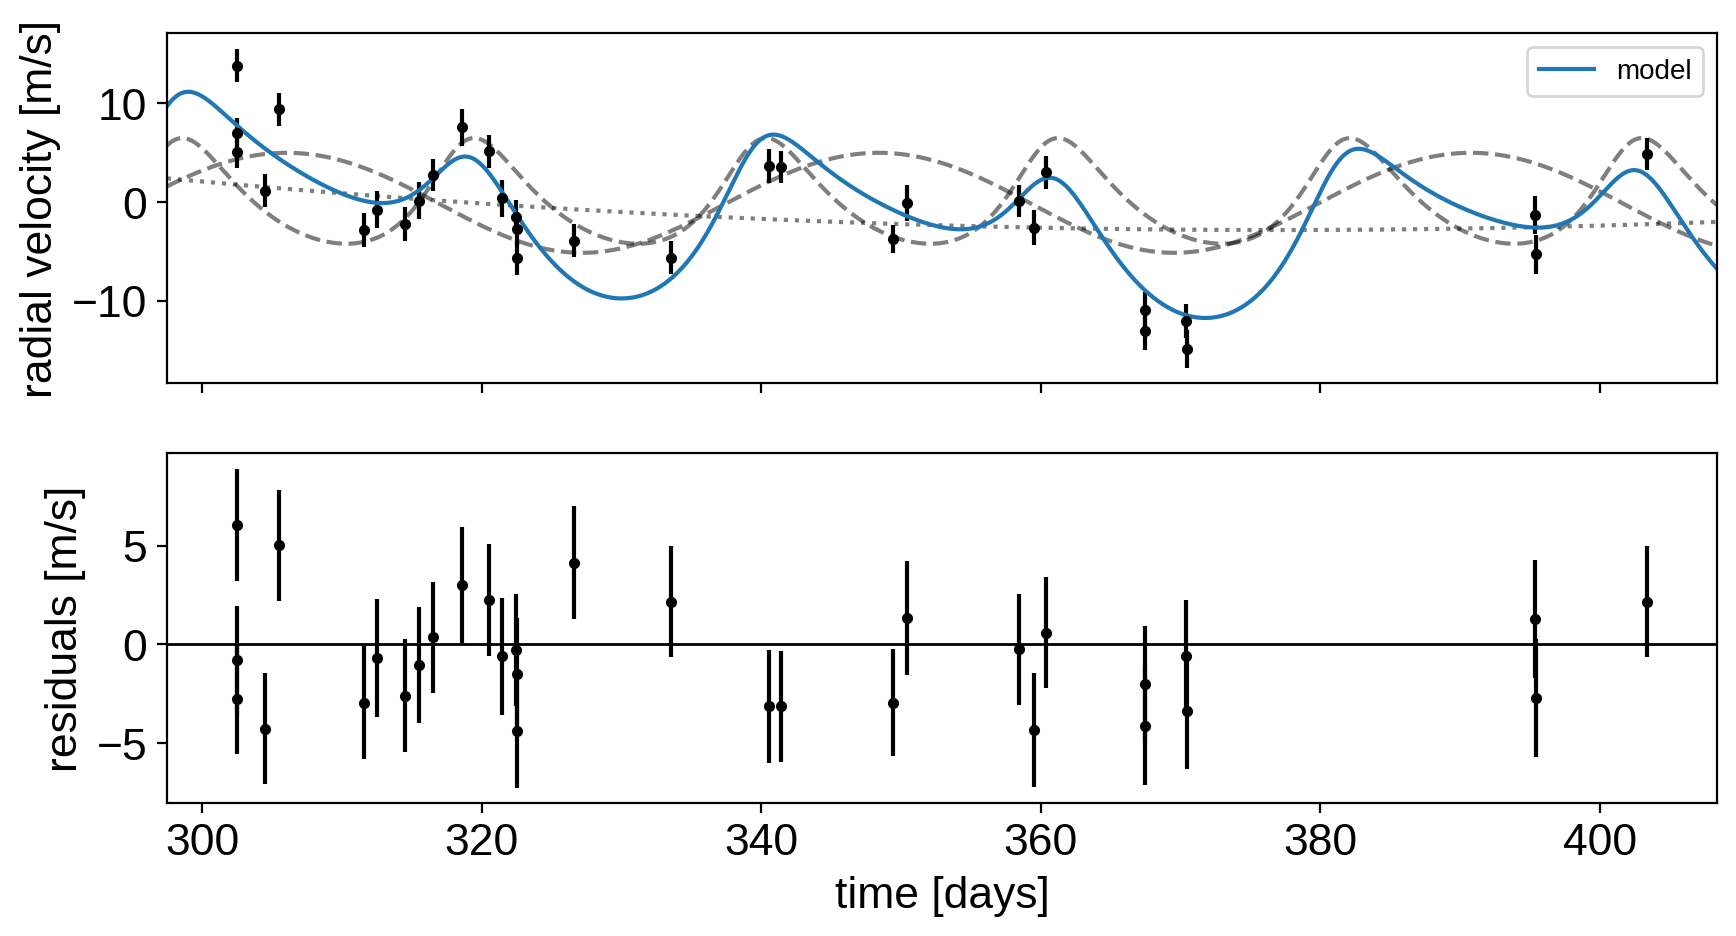

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

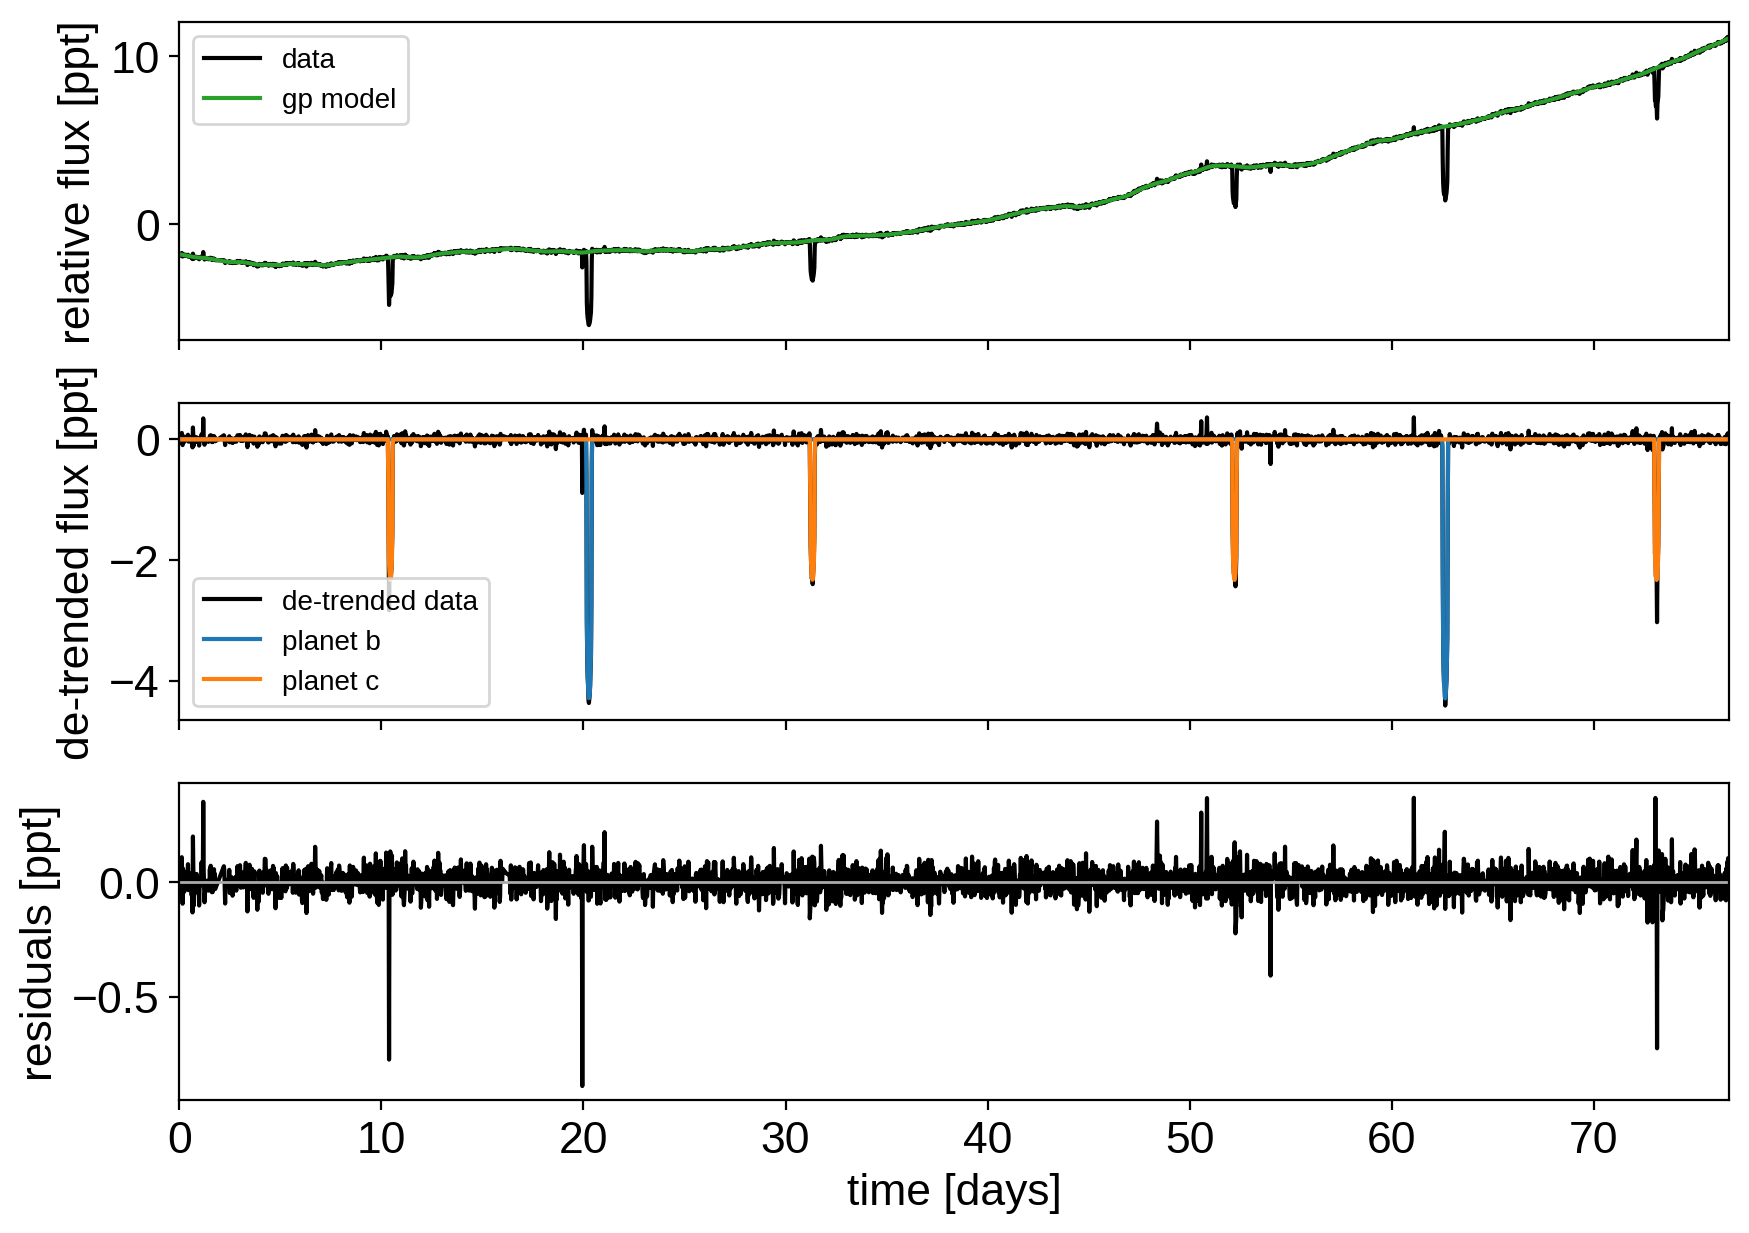

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

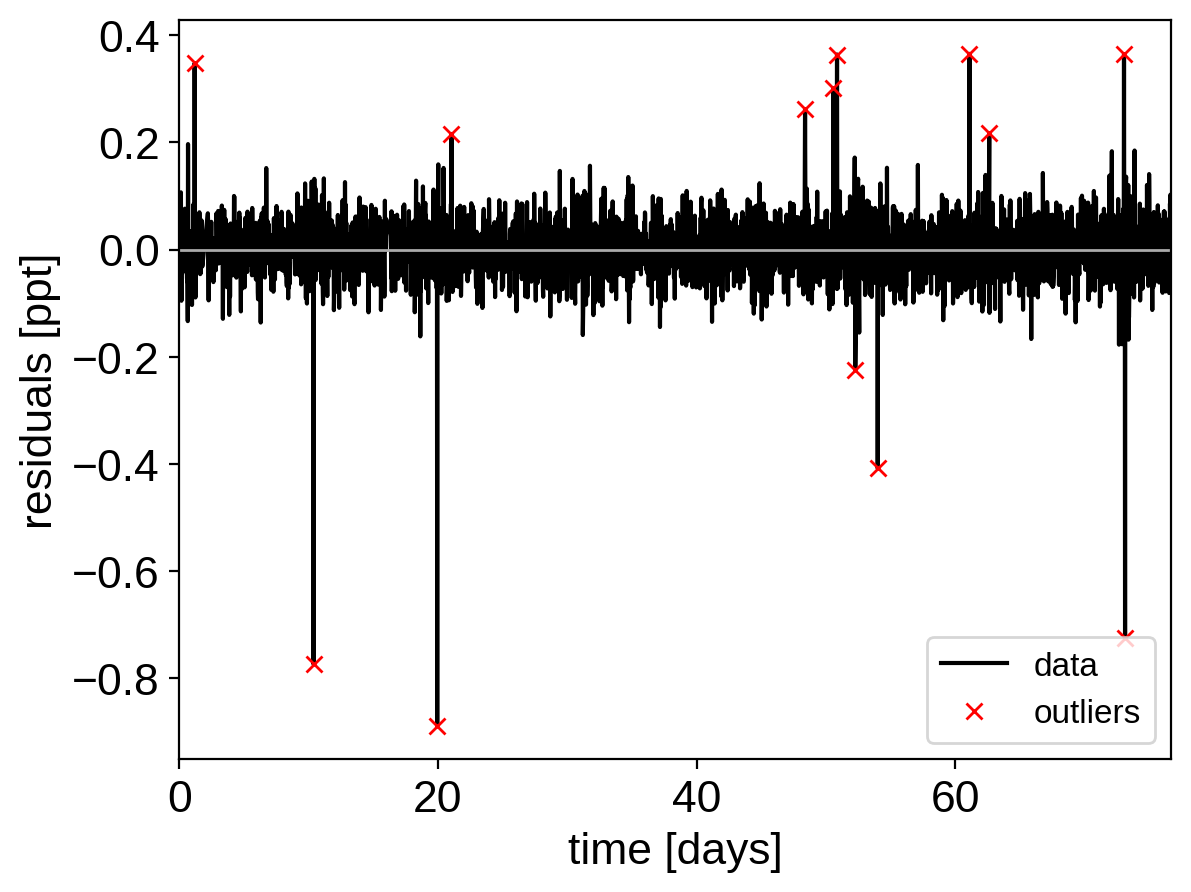

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.187170e+03]

1it [00:00, 152.15it/s, logp=5.187170e+03]

2it [00:00, 202.44it/s, logp=5.187170e+03]

3it [00:00, 230.14it/s, logp=5.184582e+03]

4it [00:00, 255.16it/s, logp=5.187170e+03]

5it [00:01,  2.75it/s, logp=5.187170e+03] 


message: Optimization terminated successfully.
logp: 5187.169972104779 -> 5187.169972104779


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.187170e+03]

1it [00:00, 164.09it/s, logp=5.187170e+03]

2it [00:00, 226.87it/s, logp=5.187170e+03]

3it [00:00, 259.71it/s, logp=4.799455e+03]

4it [00:00, 280.85it/s, logp=5.268757e+03]

5it [00:00, 294.82it/s, logp=5.269243e+03]

6it [00:00, 304.07it/s, logp=5.269258e+03]

7it [00:00, 312.72it/s, logp=5.269258e+03]

8it [00:00, 318.78it/s, logp=5.269258e+03]

9it [00:02,  4.30it/s, logp=5.269258e+03] 


message: Optimization terminated successfully.
logp: 5187.169972104779 -> 5269.258081228617


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.269258e+03]

1it [00:00, 159.95it/s, logp=5.269258e+03]

2it [00:00, 226.22it/s, logp=5.269258e+03]

3it [00:00, 252.41it/s, logp=-5.785905e+04]

4it [00:00, 272.85it/s, logp=5.272880e+03] 

5it [00:00, 285.89it/s, logp=5.209373e+03]

6it [00:00, 296.86it/s, logp=5.273077e+03]

7it [00:00, 300.68it/s, logp=5.273269e+03]

8it [00:00, 284.17it/s, logp=5.273558e+03]

9it [00:00, 281.45it/s, logp=5.274168e+03]

10it [00:00, 280.89it/s, logp=5.274984e+03]

11it [00:00, 282.50it/s, logp=5.275160e+03]

12it [00:00, 281.67it/s, logp=5.277683e+03]

13it [00:00, 277.08it/s, logp=4.929549e+03]

14it [00:00, 281.87it/s, logp=5.277864e+03]

15it [00:00, 282.58it/s, logp=5.278214e+03]

16it [00:00, 281.91it/s, logp=5.279301e+03]

17it [00:00, 280.23it/s, logp=5.280050e+03]

18it [00:00, 279.96it/s, logp=5.280094e+03]

19it [00:00, 279.32it/s, logp=5.280172e+03]

20it [00:00, 277.31it/s, logp=5.280126e+03]

21it [00:00, 267.90it/s, logp=5.280224e+03]

22it [00:00, 257.92it/s, logp=5.280223e+03]

23it [00:00, 252.45it/s, logp=5.280229e+03]

24it [00:00, 248.07it/s, logp=5.280231e+03]

25it [00:00, 247.51it/s, logp=5.280231e+03]

26it [00:00, 255.90it/s, logp=5.280231e+03]

26it [00:00, 255.90it/s, logp=5.280231e+03]

27it [00:00, 255.90it/s, logp=5.280231e+03]

28it [00:00, 255.90it/s, logp=5.280231e+03]

29it [00:00, 255.90it/s, logp=5.280231e+03]

30it [00:00, 255.90it/s, logp=5.280231e+03]

31it [00:00, 255.90it/s, logp=5.280231e+03]

32it [00:00, 255.90it/s, logp=5.280231e+03]

33it [00:00, 255.90it/s, logp=5.280231e+03]

34it [00:01, 17.45it/s, logp=5.280231e+03] 


message: Optimization terminated successfully.
logp: 5269.258081228617 -> 5280.231230124337


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.280231e+03]

1it [00:00, 171.56it/s, logp=5.280231e+03]

2it [00:00, 236.09it/s, logp=5.280231e+03]

3it [00:00, 254.88it/s, logp=-9.216501e+04]

4it [00:00, 270.21it/s, logp=-7.964204e+04]

5it [00:00, 283.30it/s, logp=-3.809930e+04]

6it [00:00, 291.95it/s, logp=5.227414e+03] 

7it [00:00, 301.11it/s, logp=5.280689e+03]

8it [00:00, 299.97it/s, logp=5.113912e+03]

9it [00:00, 305.46it/s, logp=5.280690e+03]

10it [00:00, 304.21it/s, logp=5.280692e+03]

11it [00:00, 311.66it/s, logp=5.280701e+03]

12it [00:00, 315.98it/s, logp=5.280736e+03]

13it [00:00, 320.58it/s, logp=5.280868e+03]

14it [00:00, 323.77it/s, logp=5.280610e+03]

15it [00:00, 326.51it/s, logp=5.280920e+03]

16it [00:00, 328.56it/s, logp=5.281020e+03]

17it [00:00, 330.94it/s, logp=5.281339e+03]

18it [00:00, 332.12it/s, logp=5.281600e+03]

19it [00:00, 333.58it/s, logp=5.281602e+03]

20it [00:00, 335.32it/s, logp=5.281602e+03]

21it [00:00, 336.32it/s, logp=5.281602e+03]

22it [00:00, 337.83it/s, logp=5.281602e+03]

23it [00:00, 338.90it/s, logp=5.281602e+03]

24it [00:00, 340.15it/s, logp=5.281602e+03]

25it [00:00, 341.17it/s, logp=5.281602e+03]

26it [00:00, 341.56it/s, logp=5.281602e+03]

27it [00:00, 342.81it/s, logp=5.281602e+03]

28it [00:00, 343.69it/s, logp=5.281602e+03]

29it [00:00, 344.99it/s, logp=5.281602e+03]

30it [00:00, 345.92it/s, logp=5.281602e+03]

31it [00:00, 346.67it/s, logp=5.281602e+03]

32it [00:00, 348.10it/s, logp=5.281602e+03]

33it [00:00, 349.60it/s, logp=5.281602e+03]

34it [00:00, 349.56it/s, logp=5.281602e+03]

35it [00:00, 350.81it/s, logp=5.281602e+03]

36it [00:00, 358.89it/s, logp=5.281602e+03]

36it [00:00, 358.89it/s, logp=5.281602e+03]

37it [00:00, 358.89it/s, logp=5.281602e+03]

38it [00:00, 358.89it/s, logp=5.281602e+03]

39it [00:00, 358.89it/s, logp=5.281602e+03]

40it [00:00, 358.89it/s, logp=5.281602e+03]

41it [00:00, 358.89it/s, logp=5.281602e+03]

42it [00:00, 358.89it/s, logp=5.281602e+03]

43it [00:00, 358.89it/s, logp=5.281602e+03]

44it [00:00, 358.89it/s, logp=5.281602e+03]

45it [00:00, 358.89it/s, logp=5.281602e+03]

46it [00:00, 358.89it/s, logp=5.281602e+03]

47it [00:00, 358.89it/s, logp=5.281602e+03]

48it [00:00, 358.89it/s, logp=5.281602e+03]

49it [00:00, 358.89it/s, logp=5.281602e+03]

50it [00:00, 358.89it/s, logp=5.281602e+03]

51it [00:00, 358.89it/s, logp=5.281602e+03]

52it [00:00, 358.89it/s, logp=5.281602e+03]

53it [00:00, 358.89it/s, logp=5.281602e+03]

54it [00:00, 358.89it/s, logp=5.281602e+03]

55it [00:00, 358.89it/s, logp=5.281602e+03]

56it [00:00, 358.89it/s, logp=5.281602e+03]

57it [00:00, 358.89it/s, logp=5.281602e+03]

58it [00:00, 358.89it/s, logp=5.281602e+03]

59it [00:00, 358.89it/s, logp=5.281602e+03]

60it [00:00, 358.89it/s, logp=5.281602e+03]

61it [00:00, 358.89it/s, logp=5.281602e+03]

62it [00:00, 358.89it/s, logp=5.281602e+03]

63it [00:00, 358.89it/s, logp=5.281602e+03]

64it [00:00, 358.89it/s, logp=5.281602e+03]

65it [00:00, 358.89it/s, logp=5.281602e+03]

66it [00:00, 358.89it/s, logp=5.281602e+03]

67it [00:00, 358.89it/s, logp=5.281602e+03]

68it [00:00, 358.89it/s, logp=5.281602e+03]

69it [00:00, 358.89it/s, logp=5.281602e+03]

70it [00:00, 358.89it/s, logp=5.281602e+03]

71it [00:00, 358.89it/s, logp=5.281602e+03]

72it [00:00, 358.89it/s, logp=5.281602e+03]

73it [00:00, 361.37it/s, logp=5.281602e+03]

73it [00:00, 361.37it/s, logp=5.281602e+03]

74it [00:00, 361.37it/s, logp=5.281602e+03]

75it [00:00, 361.37it/s, logp=5.281602e+03]

76it [00:00, 361.37it/s, logp=5.281602e+03]

77it [00:01, 46.29it/s, logp=5.281602e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5280.231230124337 -> 5281.601991110998


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.281602e+03]

1it [00:00, 189.77it/s, logp=5.281602e+03]

2it [00:00, 257.05it/s, logp=5.281602e+03]

3it [00:00, 290.32it/s, logp=4.587147e+03]

4it [00:00, 310.56it/s, logp=5.281683e+03]

5it [00:00, 321.97it/s, logp=5.281837e+03]

6it [00:00, 330.87it/s, logp=5.282099e+03]

7it [00:00, 338.99it/s, logp=5.282332e+03]

8it [00:00, 343.02it/s, logp=5.282332e+03]

9it [00:00, 346.41it/s, logp=5.282332e+03]

10it [00:01,  5.55it/s, logp=5.282332e+03]


message: Optimization terminated successfully.
logp: 5281.601991111005 -> 5282.331526068319


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.282332e+03]

1it [00:00, 137.27it/s, logp=5.282332e+03]

2it [00:00, 181.03it/s, logp=5.282332e+03]

3it [00:00, 190.13it/s, logp=5.247376e+03]

4it [00:00, 172.91it/s, logp=5.282218e+03]

5it [00:00, 165.69it/s, logp=5.282366e+03]

6it [00:00, 166.36it/s, logp=5.282366e+03]

7it [00:00, 168.82it/s, logp=5.282366e+03]

8it [00:00, 173.34it/s, logp=5.282366e+03]

9it [00:01,  5.05it/s, logp=5.282366e+03] 


message: Optimization terminated successfully.
logp: 5282.331526068319 -> 5282.365625613341


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.282366e+03]

1it [00:00, 122.79it/s, logp=5.282366e+03]

2it [00:00, 160.88it/s, logp=5.282366e+03]

3it [00:00, 176.72it/s, logp=-1.189649e+05]

4it [00:00, 189.05it/s, logp=2.133685e+03] 

5it [00:00, 198.01it/s, logp=5.282366e+03]

6it [00:00, 201.54it/s, logp=5.282343e+03]

7it [00:00, 206.75it/s, logp=5.282366e+03]

8it [00:00, 208.64it/s, logp=5.282366e+03]

9it [00:00, 211.07it/s, logp=5.282366e+03]

10it [00:00, 213.30it/s, logp=5.282366e+03]

11it [00:00, 216.41it/s, logp=5.282366e+03]

12it [00:00, 217.39it/s, logp=5.282366e+03]

13it [00:00, 212.67it/s, logp=5.282367e+03]

14it [00:00, 208.83it/s, logp=5.282370e+03]

15it [00:00, 208.07it/s, logp=5.282364e+03]

16it [00:00, 207.13it/s, logp=5.282371e+03]

17it [00:00, 207.02it/s, logp=5.282373e+03]

18it [00:00, 205.98it/s, logp=5.282367e+03]

19it [00:00, 203.94it/s, logp=5.282373e+03]

20it [00:00, 201.92it/s, logp=5.282374e+03]

21it [00:00, 202.38it/s, logp=5.282376e+03]

22it [00:00, 210.78it/s, logp=5.282376e+03]

22it [00:00, 210.78it/s, logp=5.282381e+03]

23it [00:00, 210.78it/s, logp=5.282391e+03]

24it [00:00, 210.78it/s, logp=5.282428e+03]

25it [00:00, 210.78it/s, logp=5.282488e+03]

26it [00:00, 210.78it/s, logp=5.282605e+03]

27it [00:00, 210.78it/s, logp=5.282985e+03]

28it [00:00, 210.78it/s, logp=5.270852e+03]

29it [00:00, 210.78it/s, logp=5.283004e+03]

30it [00:00, 210.78it/s, logp=5.283038e+03]

31it [00:00, 210.78it/s, logp=5.283091e+03]

32it [00:00, 210.78it/s, logp=5.283169e+03]

33it [00:00, 210.78it/s, logp=5.283311e+03]

34it [00:00, 210.78it/s, logp=5.283468e+03]

35it [00:00, 210.78it/s, logp=5.283449e+03]

36it [00:00, 210.78it/s, logp=5.283553e+03]

37it [00:00, 210.78it/s, logp=5.283599e+03]

38it [00:00, 210.78it/s, logp=5.283658e+03]

39it [00:00, 210.78it/s, logp=5.283758e+03]

40it [00:00, 210.78it/s, logp=5.283800e+03]

41it [00:00, 210.78it/s, logp=5.283828e+03]

42it [00:00, 210.78it/s, logp=5.283860e+03]

43it [00:00, 210.78it/s, logp=5.283915e+03]

44it [00:00, 210.78it/s, logp=5.283778e+03]

45it [00:00, 214.32it/s, logp=5.283778e+03]

45it [00:00, 214.32it/s, logp=5.283928e+03]

46it [00:00, 214.32it/s, logp=5.283950e+03]

47it [00:00, 214.32it/s, logp=5.283967e+03]

48it [00:00, 214.32it/s, logp=5.283974e+03]

49it [00:00, 214.32it/s, logp=5.283984e+03]

50it [00:00, 214.32it/s, logp=5.283990e+03]

51it [00:00, 214.32it/s, logp=5.283992e+03]

52it [00:00, 214.32it/s, logp=5.283996e+03]

53it [00:00, 214.32it/s, logp=5.284012e+03]

54it [00:00, 214.32it/s, logp=5.284023e+03]

55it [00:00, 214.32it/s, logp=5.284044e+03]

56it [00:00, 214.32it/s, logp=5.284085e+03]

57it [00:00, 214.32it/s, logp=5.284092e+03]

58it [00:00, 214.32it/s, logp=5.284129e+03]

59it [00:00, 214.32it/s, logp=5.283942e+03]

60it [00:00, 214.32it/s, logp=5.284172e+03]

61it [00:00, 214.32it/s, logp=5.284176e+03]

62it [00:00, 214.32it/s, logp=5.284196e+03]

63it [00:00, 214.32it/s, logp=5.284231e+03]

64it [00:00, 214.32it/s, logp=5.284215e+03]

65it [00:00, 214.32it/s, logp=5.284244e+03]

66it [00:00, 214.32it/s, logp=5.284257e+03]

67it [00:00, 214.32it/s, logp=5.284260e+03]

68it [00:00, 217.07it/s, logp=5.284260e+03]

68it [00:00, 217.07it/s, logp=5.284266e+03]

69it [00:00, 217.07it/s, logp=5.284275e+03]

70it [00:00, 217.07it/s, logp=5.284281e+03]

71it [00:00, 217.07it/s, logp=5.284284e+03]

72it [00:00, 217.07it/s, logp=5.284287e+03]

73it [00:00, 217.07it/s, logp=5.284288e+03]

74it [00:00, 217.07it/s, logp=5.284289e+03]

75it [00:00, 217.07it/s, logp=5.284289e+03]

76it [00:00, 217.07it/s, logp=5.284289e+03]

77it [00:00, 217.07it/s, logp=5.284290e+03]

78it [00:00, 217.07it/s, logp=5.284290e+03]

79it [00:00, 217.07it/s, logp=5.284290e+03]

80it [00:00, 217.07it/s, logp=5.284290e+03]

81it [00:00, 217.07it/s, logp=5.284290e+03]

82it [00:00, 217.07it/s, logp=5.284290e+03]

83it [00:00, 217.07it/s, logp=5.284290e+03]

84it [00:00, 217.07it/s, logp=5.284290e+03]

85it [00:00, 217.07it/s, logp=5.284290e+03]

86it [00:00, 217.07it/s, logp=5.284290e+03]

87it [00:00, 217.07it/s, logp=5.284290e+03]

88it [00:00, 217.07it/s, logp=5.284290e+03]

89it [00:00, 217.07it/s, logp=5.284290e+03]

90it [00:00, 217.60it/s, logp=5.284290e+03]

90it [00:00, 217.60it/s, logp=5.284290e+03]

91it [00:00, 217.60it/s, logp=5.284290e+03]

92it [00:00, 217.60it/s, logp=5.284290e+03]

93it [00:00, 217.60it/s, logp=5.284290e+03]

94it [00:00, 217.60it/s, logp=5.284290e+03]

95it [00:00, 217.60it/s, logp=5.284290e+03]

96it [00:00, 217.60it/s, logp=5.284290e+03]

97it [00:00, 217.60it/s, logp=5.284290e+03]

98it [00:00, 217.60it/s, logp=5.284290e+03]

99it [00:00, 217.60it/s, logp=5.284290e+03]

100it [00:00, 217.60it/s, logp=5.284290e+03]

101it [00:00, 217.60it/s, logp=5.284290e+03]

102it [00:00, 217.60it/s, logp=5.284290e+03]

103it [00:00, 217.60it/s, logp=5.284290e+03]

104it [00:00, 217.60it/s, logp=5.284290e+03]

105it [00:00, 217.60it/s, logp=5.284290e+03]

106it [00:00, 217.60it/s, logp=5.284290e+03]

107it [00:00, 217.60it/s, logp=5.284290e+03]

108it [00:00, 217.60it/s, logp=5.284290e+03]

109it [00:00, 217.60it/s, logp=5.284290e+03]

110it [00:00, 217.60it/s, logp=5.284290e+03]

111it [00:00, 217.60it/s, logp=5.284290e+03]

112it [00:00, 217.60it/s, logp=5.284290e+03]

113it [00:00, 219.33it/s, logp=5.284290e+03]

113it [00:00, 219.33it/s, logp=5.284290e+03]

114it [00:00, 219.33it/s, logp=5.284290e+03]

115it [00:00, 219.33it/s, logp=5.284290e+03]

116it [00:00, 219.33it/s, logp=5.284290e+03]

117it [00:00, 219.33it/s, logp=5.284290e+03]

118it [00:00, 219.33it/s, logp=5.284290e+03]

119it [00:00, 219.33it/s, logp=5.284290e+03]

120it [00:00, 219.33it/s, logp=5.284290e+03]

121it [00:00, 219.33it/s, logp=5.284290e+03]

122it [00:00, 219.33it/s, logp=5.284290e+03]

123it [00:00, 219.33it/s, logp=5.284290e+03]

124it [00:00, 219.33it/s, logp=5.284290e+03]

125it [00:00, 219.33it/s, logp=5.284290e+03]

126it [00:00, 219.33it/s, logp=5.284290e+03]

127it [00:00, 219.33it/s, logp=5.284290e+03]

128it [00:00, 219.33it/s, logp=5.284290e+03]

129it [00:00, 219.33it/s, logp=5.284290e+03]

130it [00:00, 219.33it/s, logp=5.284290e+03]

131it [00:00, 219.33it/s, logp=5.284290e+03]

132it [00:00, 219.33it/s, logp=5.284290e+03]

133it [00:00, 219.33it/s, logp=5.284290e+03]

134it [00:00, 219.33it/s, logp=5.284290e+03]

135it [00:00, 218.29it/s, logp=5.284290e+03]

135it [00:00, 218.29it/s, logp=5.284290e+03]

136it [00:00, 218.29it/s, logp=5.284290e+03]

137it [00:00, 218.29it/s, logp=5.284290e+03]

138it [00:00, 218.29it/s, logp=5.284290e+03]

139it [00:00, 218.29it/s, logp=5.284290e+03]

140it [00:00, 218.29it/s, logp=5.284290e+03]

141it [00:00, 218.29it/s, logp=5.284290e+03]

142it [00:00, 218.29it/s, logp=5.284290e+03]

143it [00:00, 218.29it/s, logp=5.284290e+03]

144it [00:00, 218.29it/s, logp=5.284290e+03]

145it [00:00, 218.29it/s, logp=5.284290e+03]

146it [00:00, 218.29it/s, logp=5.284290e+03]

147it [00:00, 218.29it/s, logp=5.284290e+03]

148it [00:00, 218.29it/s, logp=5.284290e+03]

149it [00:00, 218.29it/s, logp=5.284290e+03]

150it [00:00, 218.29it/s, logp=5.284290e+03]

151it [00:00, 218.29it/s, logp=5.284290e+03]

152it [00:00, 218.29it/s, logp=5.284290e+03]

153it [00:00, 218.29it/s, logp=5.284290e+03]

154it [00:00, 218.29it/s, logp=5.284290e+03]

155it [00:02, 58.66it/s, logp=5.284290e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5282.365625613334 -> 5284.289992339934


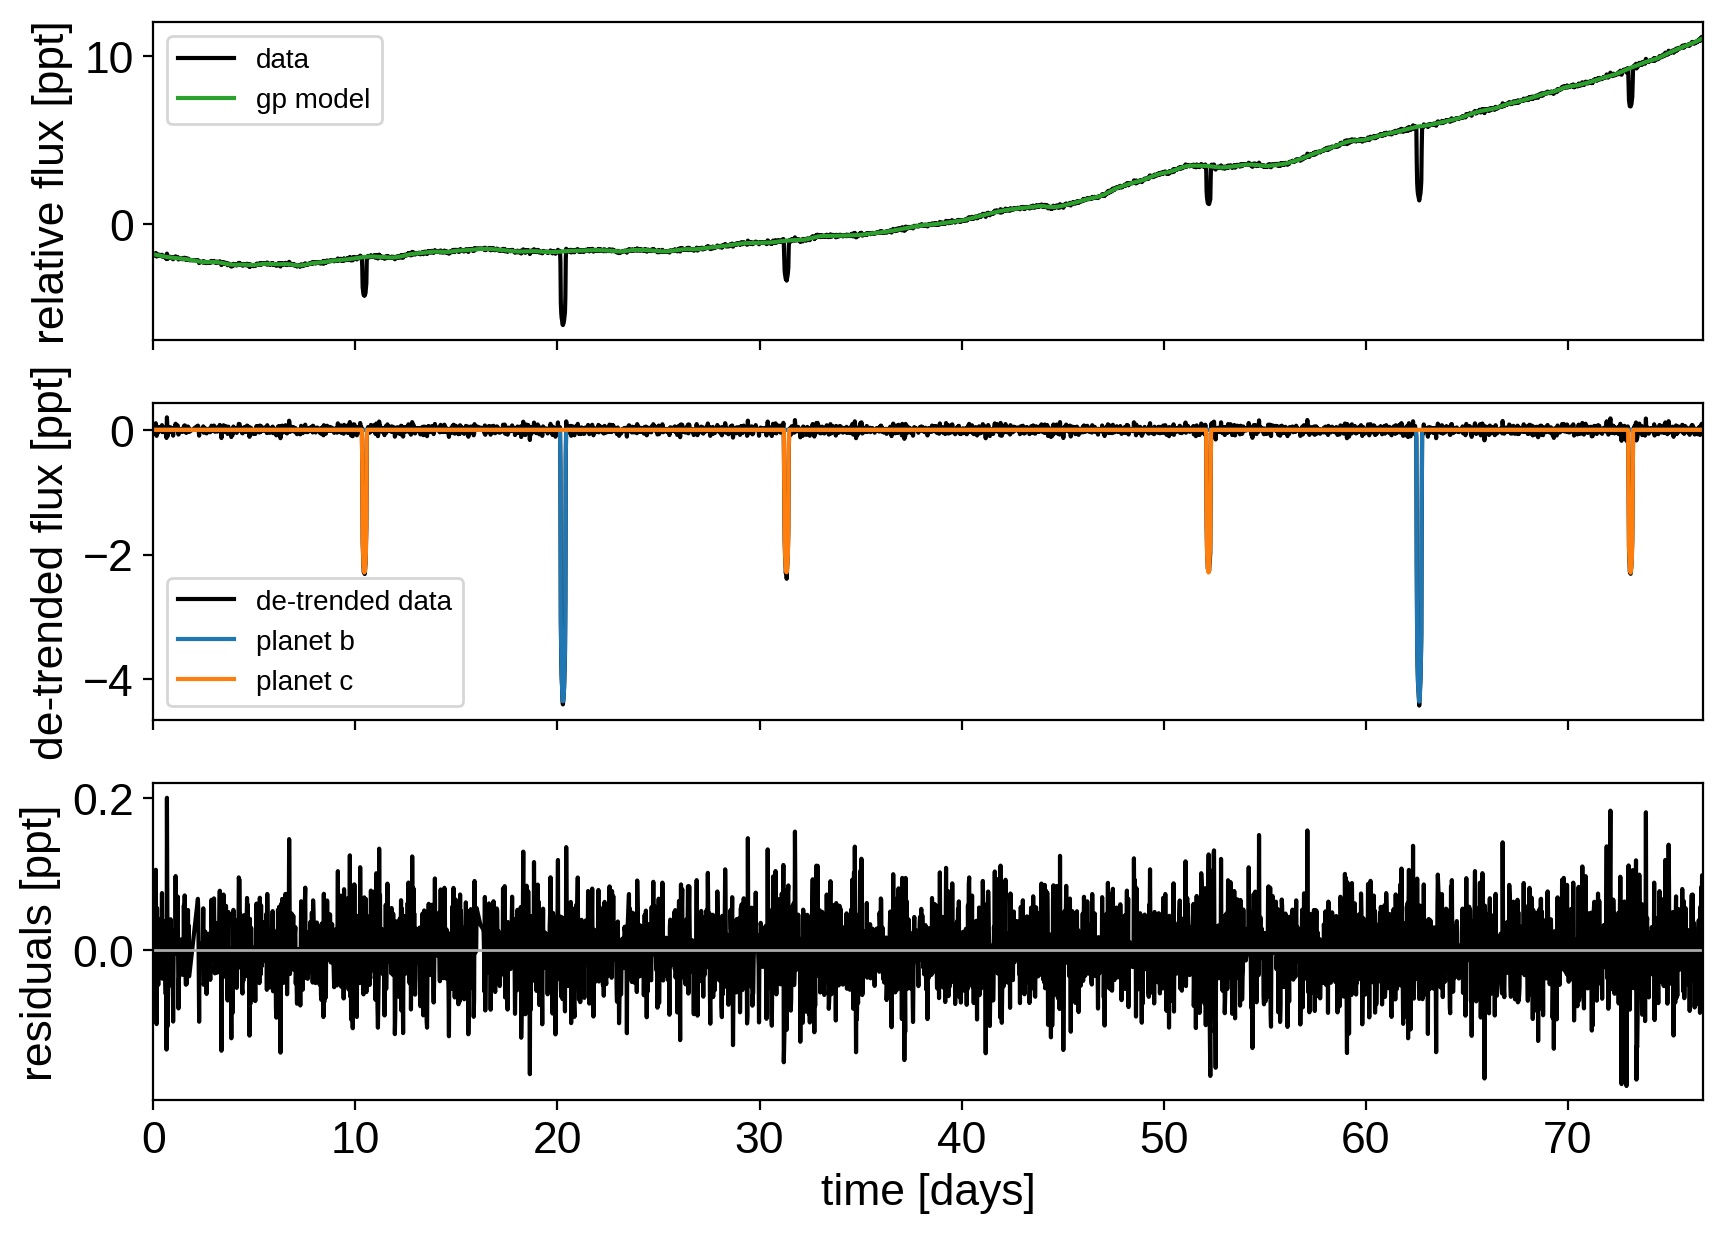

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(203771098)
with model:
    trace = xo.sample(
        tune=3500, draws=3000, start=map_soln, chains=4, target_accept=0.95
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, ecc_prior_frac, ecc_prior_sigma_rayleigh, ecc_prior_sigma_gauss, ecs, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 17/26000 [00:00<21:59, 19.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 20/26000 [00:00<19:51, 21.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 22/26000 [00:01<1:03:55,  6.77draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 24/26000 [00:01<56:30,  7.66draws/s]  

Sampling 4 chains, 0 divergences:   0%|          | 26/26000 [00:02<1:21:52,  5.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 27/26000 [00:02<1:12:47,  5.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:03<1:33:01,  4.65draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 31/26000 [00:03<1:19:48,  5.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/26000 [00:03<1:10:01,  6.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:04<1:55:37,  3.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 35/26000 [00:04<1:31:29,  4.73draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/26000 [00:04<1:17:36,  5.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/26000 [00:04<2:03:24,  3.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/26000 [00:05<1:42:44,  4.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/26000 [00:05<1:30:11,  4.80draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:05<2:02:41,  3.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/26000 [00:06<1:37:10,  4.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 44/26000 [00:06<1:40:41,  4.30draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:06<2:00:54,  3.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:06<1:41:44,  4.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/26000 [00:07<1:34:07,  4.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/26000 [00:07<1:53:16,  3.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 50/26000 [00:07<1:33:15,  4.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/26000 [00:07<1:53:37,  3.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/26000 [00:08<1:42:10,  4.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/26000 [00:08<1:28:10,  4.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/26000 [00:08<1:47:44,  4.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:09<1:51:18,  3.88draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/26000 [00:09<1:33:32,  4.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/26000 [00:09<1:46:30,  4.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:09<1:52:33,  3.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:10<1:35:10,  4.54draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/26000 [00:10<1:42:26,  4.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:10<1:52:45,  3.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:10<1:37:28,  4.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:11<1:24:16,  5.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:11<1:27:49,  4.92draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:11<1:51:04,  3.89draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:11<1:30:52,  4.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:11<1:24:37,  5.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 71/26000 [00:12<1:31:51,  4.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:12<1:43:00,  4.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:12<1:48:12,  3.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/26000 [00:12<1:32:10,  4.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:13<1:42:48,  4.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:13<1:47:17,  4.03draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:13<1:36:10,  4.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/26000 [00:13<1:23:41,  5.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:14<1:34:42,  4.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:14<1:40:02,  4.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:14<1:32:31,  4.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 83/26000 [00:14<1:25:45,  5.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:15<1:40:54,  4.28draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:15<1:39:39,  4.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:15<1:26:36,  4.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [00:15<1:27:25,  4.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 88/26000 [00:15<1:44:06,  4.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 89/26000 [00:16<1:32:09,  4.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:16<1:26:30,  4.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [00:16<1:46:03,  4.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [00:16<1:29:11,  4.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:17<1:26:21,  5.00draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:17<1:45:17,  4.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:17<1:35:47,  4.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:18<1:33:39,  4.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:18<1:42:56,  4.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [00:18<1:26:05,  5.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:19<1:31:46,  4.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:19<1:42:59,  4.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:20<1:45:20,  4.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:20<1:20:12,  5.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:20<1:37:46,  4.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:20<1:24:06,  5.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:21<1:15:01,  5.75draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 114/26000 [00:21<1:07:03,  6.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [00:21<1:41:29,  4.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:21<1:28:33,  4.87draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:22<1:35:11,  4.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [00:22<1:31:33,  4.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:22<1:29:43,  4.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 121/26000 [00:22<1:39:08,  4.35draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [00:23<1:44:18,  4.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:23<1:27:14,  4.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:23<1:52:27,  3.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:24<1:49:13,  3.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:24<1:27:57,  4.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [00:24<2:05:03,  3.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:24<1:52:14,  3.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:24<1:25:42,  5.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [00:25<2:08:43,  3.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:25<2:03:03,  3.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:26<1:50:48,  3.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:26<1:48:33,  3.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [00:27<1:42:05,  4.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:27<1:41:45,  4.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/26000 [00:27<1:24:43,  5.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:28<1:53:03,  3.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:28<1:45:53,  4.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/26000 [00:28<1:28:03,  4.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [00:28<1:51:22,  3.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:29<1:48:34,  3.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/26000 [00:29<1:27:36,  4.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [00:29<1:53:21,  3.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:29<1:57:34,  3.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/26000 [00:30<1:31:39,  4.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [00:30<2:01:31,  3.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:30<1:55:24,  3.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/26000 [00:31<1:38:58,  4.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [00:31<1:54:46,  3.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:31<1:40:04,  4.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [00:31<1:23:32,  5.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:31<1:29:27,  4.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/26000 [00:32<1:56:34,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [00:32<1:33:15,  4.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:32<1:38:31,  4.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [00:33<1:56:48,  3.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [00:33<1:33:56,  4.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [00:33<1:48:12,  3.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [00:33<1:44:06,  4.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:34<1:35:37,  4.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:34<1:33:47,  4.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/26000 [00:34<1:37:55,  4.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:34<1:21:48,  5.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:35<1:28:13,  4.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 181/26000 [00:35<1:29:14,  4.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:35<1:23:17,  5.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [00:36<1:24:22,  5.10draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [00:36<1:46:14,  4.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [00:36<1:31:51,  4.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [00:37<1:50:48,  3.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [00:37<1:26:17,  4.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [00:37<1:40:13,  4.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [00:37<1:51:03,  3.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 194/26000 [00:38<1:31:39,  4.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [00:38<1:31:58,  4.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [00:38<1:34:25,  4.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:38<1:15:33,  5.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [00:39<1:09:31,  6.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 203/26000 [00:39<1:23:43,  5.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [00:39<1:14:20,  5.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [00:40<1:12:02,  5.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 207/26000 [00:40<1:28:38,  4.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [00:40<1:17:17,  5.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 211/26000 [00:40<1:05:42,  6.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [00:41<1:07:49,  6.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [00:41<1:06:51,  6.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [00:41<1:01:41,  6.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 217/26000 [00:41<1:24:34,  5.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [00:41<1:17:09,  5.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [00:42<1:10:13,  6.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [00:42<1:34:50,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [00:42<1:20:51,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [00:42<1:10:46,  6.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [00:43<1:47:54,  3.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [00:43<1:24:50,  5.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [00:43<1:37:46,  4.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [00:44<1:17:27,  5.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 233/26000 [00:44<1:34:42,  4.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [00:44<1:13:19,  5.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [00:45<1:32:02,  4.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [00:45<1:08:52,  6.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [00:46<1:29:44,  4.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 244/26000 [00:46<1:09:39,  6.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [00:46<1:28:16,  4.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 248/26000 [00:47<1:09:50,  6.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [00:47<1:26:59,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 252/26000 [00:47<1:08:44,  6.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [00:48<1:26:11,  4.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [00:49<1:27:02,  4.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [00:49<1:14:39,  5.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 260/26000 [00:49<58:58,  7.27draws/s]  

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [00:49<1:21:48,  5.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [00:49<1:04:49,  6.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [00:50<1:24:35,  5.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [00:50<1:08:18,  6.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [00:51<1:24:52,  5.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [00:51<1:07:20,  6.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [00:52<1:25:37,  5.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [00:52<1:07:15,  6.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [00:52<1:26:06,  4.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [00:52<1:09:27,  6.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [00:53<1:25:21,  5.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [00:53<1:08:08,  6.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [00:53<1:03:09,  6.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 287/26000 [00:54<1:27:43,  4.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [00:54<1:16:52,  5.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [00:54<1:22:37,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 291/26000 [00:54<1:21:21,  5.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [00:55<1:16:27,  5.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [00:55<1:15:34,  5.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 295/26000 [00:55<1:17:40,  5.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [00:55<1:20:21,  5.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [00:56<1:13:30,  5.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [00:56<1:22:29,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [00:56<1:27:22,  4.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [00:56<1:20:28,  5.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [00:57<1:20:08,  5.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [00:57<1:30:29,  4.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [00:57<1:24:04,  5.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [00:57<1:17:45,  5.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 308/26000 [00:58<1:24:47,  5.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [00:58<1:10:30,  6.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [00:58<1:20:24,  5.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 314/26000 [00:58<1:15:30,  5.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [00:59<1:32:07,  4.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [00:59<1:20:47,  5.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [00:59<1:18:59,  5.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [01:00<1:13:04,  5.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 324/26000 [01:00<1:32:12,  4.64draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [01:00<1:19:27,  5.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [01:01<1:14:51,  5.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [01:01<1:34:10,  4.54draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [01:01<1:22:03,  5.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [01:01<1:12:49,  5.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [01:02<1:33:50,  4.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [01:02<1:23:02,  5.15draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [01:02<1:26:06,  4.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [01:03<1:18:34,  5.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 340/26000 [01:03<1:22:25,  5.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 342/26000 [01:03<1:16:45,  5.57draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [01:04<1:11:49,  5.95draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 347/26000 [01:04<1:08:49,  6.21draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [01:04<1:15:57,  5.63draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 351/26000 [01:05<1:10:19,  6.08draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [01:05<1:06:28,  6.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [01:05<1:17:33,  5.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 355/26000 [01:05<1:09:21,  6.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [01:06<1:11:50,  5.95draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [01:06<1:14:59,  5.70draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [01:06<1:13:19,  5.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [01:06<1:13:16,  5.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [01:07<1:13:01,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [01:07<1:12:09,  5.92draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [01:07<1:03:36,  6.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [01:07<1:03:49,  6.69draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [01:07<59:16,  7.21draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [01:08<1:21:49,  5.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [01:08<1:16:46,  5.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [01:08<1:17:50,  5.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [01:09<1:16:46,  5.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [01:09<1:04:08,  6.66draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 377/26000 [01:09<1:05:50,  6.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 378/26000 [01:09<1:14:57,  5.70draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [01:09<1:08:00,  6.28draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [01:09<1:07:43,  6.30draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [01:10<57:55,  7.37draws/s]  

Sampling 4 chains, 0 divergences:   1%|▏         | 383/26000 [01:10<1:21:15,  5.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [01:10<1:12:36,  5.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [01:10<1:05:42,  6.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 387/26000 [01:11<1:33:19,  4.57draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [01:11<1:20:18,  5.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [01:11<1:12:21,  5.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 392/26000 [01:11<1:23:35,  5.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [01:12<1:11:25,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [01:12<1:18:38,  5.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [01:12<1:28:23,  4.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 397/26000 [01:12<1:16:30,  5.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [01:12<1:14:02,  5.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/26000 [01:12<1:10:43,  6.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 401/26000 [01:13<1:00:52,  7.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [01:13<53:51,  7.92draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 404/26000 [01:13<51:30,  8.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 405/26000 [01:13<51:26,  8.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 406/26000 [01:13<1:28:40,  4.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [01:14<1:16:37,  5.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [01:14<1:14:55,  5.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 415/26000 [01:14<59:41,  7.14draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [01:15<1:12:29,  5.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 420/26000 [01:15<1:01:35,  6.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [01:16<1:13:21,  5.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [01:16<1:03:16,  6.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [01:16<1:02:43,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [01:16<1:17:29,  5.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 430/26000 [01:17<1:00:42,  7.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [01:17<1:08:44,  6.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [01:17<1:05:04,  6.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [01:17<53:20,  7.99draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 438/26000 [01:18<1:08:34,  6.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [01:18<1:02:40,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [01:18<58:42,  7.26draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [01:18<49:29,  8.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [01:19<1:12:10,  5.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [01:19<59:04,  7.21draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 448/26000 [01:19<1:11:23,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [01:20<1:11:32,  5.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [01:20<57:42,  7.38draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 454/26000 [01:20<1:18:44,  5.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [01:20<1:02:38,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [01:21<1:21:13,  5.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [01:21<1:05:32,  6.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [01:22<1:21:33,  5.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [01:22<1:07:46,  6.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 466/26000 [01:22<1:10:19,  6.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 468/26000 [01:23<1:12:16,  5.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 469/26000 [01:23<1:06:48,  6.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [01:23<1:01:35,  6.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [01:23<1:29:07,  4.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [01:23<1:24:09,  5.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [01:24<1:11:40,  5.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [01:24<1:01:44,  6.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [01:24<1:11:57,  5.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [01:24<1:06:24,  6.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [01:24<53:44,  7.91draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [01:25<53:34,  7.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [01:25<1:02:31,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [01:25<1:12:52,  5.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 487/26000 [01:25<1:25:36,  4.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [01:26<1:10:03,  6.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [01:26<1:51:40,  3.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [01:26<1:29:53,  4.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [01:27<2:00:04,  3.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 498/26000 [01:27<1:38:14,  4.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [01:27<1:49:27,  3.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 501/26000 [01:28<1:24:40,  5.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [01:28<1:43:24,  4.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [01:28<1:46:37,  3.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [01:28<1:21:53,  5.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [01:29<1:47:27,  3.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [01:29<1:44:57,  4.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [01:29<1:19:58,  5.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [01:29<1:24:06,  5.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [01:30<1:18:15,  5.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 513/26000 [01:30<1:11:21,  5.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [01:30<56:14,  7.55draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 518/26000 [01:30<58:40,  7.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [01:30<48:02,  8.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [01:31<1:02:01,  6.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [01:31<56:08,  7.56draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [01:31<56:35,  7.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 528/26000 [01:31<53:50,  7.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 529/26000 [01:32<1:00:06,  7.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [01:32<1:02:10,  6.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [01:32<1:07:03,  6.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 536/26000 [01:33<55:39,  7.63draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 537/26000 [01:33<55:45,  7.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [01:33<1:23:12,  5.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [01:33<1:09:36,  6.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [01:34<1:32:03,  4.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [01:34<1:11:03,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [01:34<1:08:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [01:34<1:00:42,  6.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [01:34<53:13,  7.97draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [01:35<1:01:30,  6.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 554/26000 [01:35<55:00,  7.71draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [01:35<1:01:57,  6.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [01:35<55:24,  7.65draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [01:36<1:02:20,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [01:36<54:12,  7.82draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [01:36<51:36,  8.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 564/26000 [01:36<47:50,  8.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [01:36<53:17,  7.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [01:36<47:54,  8.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 569/26000 [01:37<45:37,  9.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [01:37<54:43,  7.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 572/26000 [01:37<1:11:47,  5.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 574/26000 [01:37<57:38,  7.35draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 576/26000 [01:38<1:05:34,  6.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 578/26000 [01:38<54:19,  7.80draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [01:38<54:49,  7.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 582/26000 [01:38<50:54,  8.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 584/26000 [01:39<47:58,  8.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 585/26000 [01:39<55:44,  7.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 588/26000 [01:39<45:51,  9.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 590/26000 [01:39<44:46,  9.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [01:39<53:36,  7.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 595/26000 [01:40<46:39,  9.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [01:40<1:02:45,  6.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 600/26000 [01:41<1:02:45,  6.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 601/26000 [01:41<1:07:10,  6.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [01:41<56:38,  7.47draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 606/26000 [01:41<44:56,  9.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 608/26000 [01:41<43:18,  9.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [01:41<41:56, 10.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [01:42<41:00, 10.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 614/26000 [01:42<43:39,  9.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 616/26000 [01:42<50:03,  8.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [01:42<43:37,  9.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [01:42<37:31, 11.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 624/26000 [01:43<44:10,  9.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [01:43<38:30, 10.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 629/26000 [01:43<42:08, 10.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 632/26000 [01:43<37:00, 11.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [01:44<41:25, 10.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [01:44<36:41, 11.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 638/26000 [01:44<41:32, 10.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 640/26000 [01:44<43:29,  9.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 642/26000 [01:45<54:10,  7.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 644/26000 [01:45<50:00,  8.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 646/26000 [01:45<42:45,  9.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 648/26000 [01:45<58:36,  7.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [01:46<1:02:25,  6.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [01:46<57:05,  7.40draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [01:46<55:49,  7.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 654/26000 [01:46<53:41,  7.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [01:46<45:06,  9.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [01:47<49:07,  8.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 660/26000 [01:47<1:08:16,  6.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 662/26000 [01:47<1:00:03,  7.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 664/26000 [01:47<53:54,  7.83draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [01:47<45:39,  9.25draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 670/26000 [01:48<39:41, 10.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [01:48<39:10, 10.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [01:48<44:38,  9.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 676/26000 [01:48<46:00,  9.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 678/26000 [01:48<40:11, 10.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [01:49<37:40, 11.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 683/26000 [01:49<32:46, 12.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [01:49<32:35, 12.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 688/26000 [01:49<30:47, 13.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 690/26000 [01:49<32:22, 13.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [01:49<29:38, 14.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 694/26000 [01:50<36:59, 11.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [01:50<39:14, 10.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [01:50<48:04,  8.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [01:50<38:18, 11.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [01:50<34:31, 12.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [01:51<44:06,  9.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 707/26000 [01:51<48:31,  8.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [01:51<44:04,  9.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 711/26000 [01:52<1:01:24,  6.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 714/26000 [01:52<51:23,  8.20draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 716/26000 [01:52<42:58,  9.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [01:52<41:33, 10.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [01:52<42:49,  9.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [01:53<40:06, 10.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [01:53<35:12, 11.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 727/26000 [01:53<37:58, 11.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 729/26000 [01:53<36:01, 11.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 731/26000 [01:53<47:41,  8.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 733/26000 [01:54<47:14,  8.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [01:54<38:45, 10.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 738/26000 [01:54<38:24, 10.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [01:54<38:05, 11.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 742/26000 [01:54<47:28,  8.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 745/26000 [01:55<41:02, 10.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 747/26000 [01:55<41:26, 10.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [01:55<33:21, 12.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [01:55<31:53, 13.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [01:55<29:32, 14.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 756/26000 [01:55<31:43, 13.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 758/26000 [01:56<33:30, 12.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 760/26000 [01:56<29:56, 14.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 762/26000 [01:56<28:12, 14.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [01:56<44:51,  9.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [01:56<51:23,  8.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [01:57<47:35,  8.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 770/26000 [01:57<45:41,  9.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 772/26000 [01:57<48:22,  8.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [01:57<45:39,  9.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 776/26000 [01:57<43:17,  9.71draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 778/26000 [01:58<42:22,  9.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [01:58<37:02, 11.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [01:58<34:47, 12.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 784/26000 [01:58<35:34, 11.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 786/26000 [01:58<35:37, 11.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 788/26000 [01:59<40:49, 10.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 790/26000 [01:59<46:58,  8.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [01:59<50:48,  8.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 794/26000 [01:59<51:29,  8.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [02:00<1:00:27,  6.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 797/26000 [02:00<52:40,  7.98draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [02:00<47:54,  8.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [02:00<41:26, 10.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [02:00<46:36,  9.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [02:01<54:23,  7.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [02:01<49:26,  8.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 810/26000 [02:01<59:31,  7.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [02:01<53:42,  7.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [02:02<1:08:07,  6.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [02:02<1:26:24,  4.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [02:02<1:20:02,  5.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 817/26000 [02:02<1:25:38,  4.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 819/26000 [02:03<1:12:14,  5.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 821/26000 [02:03<1:09:02,  6.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [02:03<1:06:03,  6.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 823/26000 [02:03<1:18:55,  5.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 825/26000 [02:03<1:02:52,  6.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [02:04<1:07:52,  6.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 827/26000 [02:04<1:11:23,  5.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [02:04<54:30,  7.70draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 832/26000 [02:04<50:54,  8.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 834/26000 [02:05<1:01:23,  6.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [02:05<1:01:41,  6.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 837/26000 [02:05<1:14:55,  5.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [02:05<1:27:30,  4.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 839/26000 [02:06<1:26:12,  4.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [02:06<1:24:13,  4.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [02:06<1:11:24,  5.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [02:06<1:04:03,  6.54draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 846/26000 [02:06<56:54,  7.37draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 848/26000 [02:07<55:15,  7.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 849/26000 [02:07<56:21,  7.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [02:07<1:04:28,  6.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [02:07<52:30,  7.98draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 854/26000 [02:07<54:47,  7.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [02:08<1:00:53,  6.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 856/26000 [02:08<1:07:45,  6.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 858/26000 [02:08<1:00:08,  6.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [02:08<1:03:35,  6.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [02:08<58:37,  7.15draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [02:08<1:03:07,  6.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 864/26000 [02:09<53:07,  7.88draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 867/26000 [02:09<47:08,  8.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [02:09<1:03:57,  6.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 870/26000 [02:10<1:24:16,  4.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [02:10<1:12:57,  5.74draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [02:10<1:03:44,  6.57draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [02:10<1:09:09,  6.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 878/26000 [02:10<52:51,  7.92draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [02:11<46:01,  9.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [02:11<43:47,  9.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [02:11<36:57, 11.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 887/26000 [02:11<32:27, 12.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 889/26000 [02:11<44:41,  9.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [02:12<44:25,  9.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [02:12<42:22,  9.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [02:12<39:59, 10.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [02:12<39:38, 10.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [02:12<40:23, 10.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [02:12<41:17, 10.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 904/26000 [02:13<36:57, 11.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 906/26000 [02:13<37:05, 11.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 908/26000 [02:13<39:36, 10.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 910/26000 [02:13<39:51, 10.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 913/26000 [02:13<36:38, 11.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 915/26000 [02:14<32:56, 12.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [02:14<29:30, 14.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 920/26000 [02:14<32:44, 12.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 922/26000 [02:14<32:45, 12.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [02:14<34:29, 12.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [02:15<44:30,  9.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 929/26000 [02:15<45:06,  9.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [02:15<45:42,  9.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 932/26000 [02:15<51:03,  8.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 933/26000 [02:16<1:04:47,  6.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 934/26000 [02:16<1:04:25,  6.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [02:16<54:38,  7.64draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 938/26000 [02:16<56:48,  7.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 940/26000 [02:16<51:53,  8.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [02:17<1:05:13,  6.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [02:17<1:04:49,  6.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 944/26000 [02:17<52:21,  7.97draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 946/26000 [02:17<55:06,  7.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [02:17<1:00:05,  6.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [02:17<54:50,  7.61draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 950/26000 [02:18<57:06,  7.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [02:18<47:24,  8.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 955/26000 [02:18<48:21,  8.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 957/26000 [02:18<40:39, 10.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 959/26000 [02:18<45:02,  9.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 961/26000 [02:19<39:50, 10.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 963/26000 [02:19<34:29, 12.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 965/26000 [02:19<42:25,  9.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 967/26000 [02:19<41:29, 10.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 969/26000 [02:19<40:57, 10.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 971/26000 [02:19<40:09, 10.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 973/26000 [02:20<39:22, 10.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [02:20<35:16, 11.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [02:20<36:08, 11.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [02:20<31:38, 13.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 985/26000 [02:20<27:48, 14.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 987/26000 [02:20<26:29, 15.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 989/26000 [02:21<30:00, 13.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 991/26000 [02:21<32:23, 12.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 993/26000 [02:21<39:38, 10.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [02:21<36:10, 11.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 997/26000 [02:21<38:35, 10.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 999/26000 [02:22<38:59, 10.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1001/26000 [02:22<39:20, 10.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1003/26000 [02:22<33:50, 12.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1005/26000 [02:22<39:02, 10.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1007/26000 [02:22<36:38, 11.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1009/26000 [02:23<44:57,  9.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1011/26000 [02:23<38:32, 10.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [02:23<37:53, 10.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1017/26000 [02:23<31:18, 13.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1020/26000 [02:23<32:54, 12.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1022/26000 [02:24<35:54, 11.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1024/26000 [02:24<34:07, 12.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [02:24<31:38, 13.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1028/26000 [02:24<33:57, 12.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1030/26000 [02:24<34:06, 12.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [02:24<36:18, 11.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [02:25<36:47, 11.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [02:25<35:44, 11.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [02:25<31:54, 13.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [02:25<34:43, 11.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1047/26000 [02:26<30:40, 13.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1049/26000 [02:26<35:55, 11.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [02:26<38:30, 10.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [02:26<40:02, 10.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1056/26000 [02:26<35:04, 11.85draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1058/26000 [02:27<38:23, 10.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1060/26000 [02:27<36:40, 11.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1062/26000 [02:27<37:32, 11.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1064/26000 [02:27<39:01, 10.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1067/26000 [02:27<36:41, 11.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1069/26000 [02:28<35:45, 11.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1072/26000 [02:28<34:05, 12.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1074/26000 [02:28<33:48, 12.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1076/26000 [02:28<37:38, 11.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1078/26000 [02:28<37:23, 11.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [02:28<34:02, 12.20draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1083/26000 [02:29<46:25,  8.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1085/26000 [02:29<39:42, 10.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1087/26000 [02:29<35:22, 11.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [02:29<35:25, 11.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1091/26000 [02:29<36:11, 11.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [02:30<36:14, 11.46draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1095/26000 [02:30<36:20, 11.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [02:30<40:45, 10.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [02:30<37:29, 11.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [02:30<35:59, 11.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [02:30<31:59, 12.97draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [02:31<35:59, 11.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [02:31<39:50, 10.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [02:31<39:21, 10.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1112/26000 [02:31<35:32, 11.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [02:31<33:10, 12.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [02:32<30:13, 13.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1121/26000 [02:32<27:33, 15.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1123/26000 [02:32<36:30, 11.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1126/26000 [02:32<35:02, 11.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1130/26000 [02:32<30:00, 13.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [02:33<27:04, 15.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1138/26000 [02:33<24:44, 16.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [02:33<23:40, 17.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1142/26000 [02:33<26:38, 15.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [02:33<24:30, 16.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1147/26000 [02:34<31:33, 13.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1150/26000 [02:34<27:44, 14.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [02:34<32:23, 12.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1154/26000 [02:34<30:59, 13.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1157/26000 [02:34<29:12, 14.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1159/26000 [02:34<33:14, 12.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1163/26000 [02:35<31:01, 13.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1165/26000 [02:35<32:57, 12.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [02:35<31:10, 13.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1171/26000 [02:35<29:36, 13.98draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1174/26000 [02:35<30:02, 13.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1178/26000 [02:36<24:08, 17.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1181/26000 [02:36<33:45, 12.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1183/26000 [02:36<36:00, 11.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1185/26000 [02:36<40:10, 10.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [02:36<33:22, 12.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [02:37<31:22, 13.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1192/26000 [02:37<39:16, 10.53draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1194/26000 [02:37<36:00, 11.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1196/26000 [02:37<34:47, 11.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [02:37<37:10, 11.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [02:38<36:46, 11.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1203/26000 [02:38<29:57, 13.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1205/26000 [02:38<36:24, 11.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1207/26000 [02:38<36:19, 11.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1209/26000 [02:38<38:01, 10.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1211/26000 [02:38<35:28, 11.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1214/26000 [02:39<32:18, 12.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1216/26000 [02:39<34:09, 12.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1220/26000 [02:39<29:51, 13.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1222/26000 [02:39<32:48, 12.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1225/26000 [02:39<30:25, 13.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1227/26000 [02:40<32:28, 12.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [02:40<28:30, 14.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1233/26000 [02:40<30:57, 13.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1236/26000 [02:40<29:27, 14.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1238/26000 [02:40<26:48, 15.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1241/26000 [02:40<30:18, 13.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [02:41<28:41, 14.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1246/26000 [02:41<29:59, 13.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [02:41<26:04, 15.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1251/26000 [02:41<24:31, 16.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1253/26000 [02:41<27:23, 15.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1255/26000 [02:41<26:01, 15.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [02:41<22:26, 18.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1261/26000 [02:42<28:36, 14.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [02:42<30:13, 13.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [02:42<27:36, 14.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1269/26000 [02:42<29:30, 13.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1271/26000 [02:42<27:55, 14.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1274/26000 [02:43<23:58, 17.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1276/26000 [02:43<37:46, 10.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1278/26000 [02:43<43:56,  9.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1281/26000 [02:43<40:47, 10.10draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1283/26000 [02:44<37:22, 11.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [02:44<33:56, 12.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1288/26000 [02:44<36:39, 11.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [02:44<36:02, 11.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1293/26000 [02:44<32:37, 12.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1295/26000 [02:45<34:27, 11.95draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [02:45<34:03, 12.09draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [02:45<34:22, 11.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1303/26000 [02:45<29:40, 13.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1305/26000 [02:45<33:19, 12.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1307/26000 [02:45<32:20, 12.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [02:46<30:55, 13.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1313/26000 [02:46<31:07, 13.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1316/26000 [02:46<26:51, 15.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1319/26000 [02:46<24:37, 16.70draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1321/26000 [02:46<27:53, 14.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1323/26000 [02:46<29:14, 14.07draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [02:47<32:02, 12.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [02:47<29:59, 13.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [02:47<29:00, 14.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1333/26000 [02:47<30:29, 13.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1337/26000 [02:47<26:34, 15.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1339/26000 [02:47<30:24, 13.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1343/26000 [02:48<27:49, 14.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1345/26000 [02:48<28:11, 14.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1349/26000 [02:48<25:06, 16.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1352/26000 [02:48<24:54, 16.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1356/26000 [02:48<22:55, 17.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1358/26000 [02:49<29:43, 13.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1360/26000 [02:49<28:32, 14.38draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1362/26000 [02:49<30:52, 13.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1364/26000 [02:49<29:51, 13.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1366/26000 [02:49<35:25, 11.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1368/26000 [02:49<34:47, 11.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1371/26000 [02:50<28:42, 14.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1373/26000 [02:50<30:39, 13.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1375/26000 [02:50<28:20, 14.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1377/26000 [02:50<34:28, 11.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1380/26000 [02:50<30:15, 13.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1382/26000 [02:50<32:57, 12.45draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1384/26000 [02:51<34:57, 11.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1386/26000 [02:51<34:16, 11.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1389/26000 [02:51<31:55, 12.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1391/26000 [02:51<32:53, 12.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1393/26000 [02:51<33:09, 12.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1395/26000 [02:51<34:34, 11.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1398/26000 [02:52<30:13, 13.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1400/26000 [02:52<33:41, 12.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1402/26000 [02:52<31:25, 13.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1405/26000 [02:52<30:57, 13.24draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1407/26000 [02:52<31:11, 13.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1410/26000 [02:52<26:10, 15.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1412/26000 [02:53<34:09, 11.99draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1414/26000 [02:53<30:35, 13.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1418/26000 [02:53<29:36, 13.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1420/26000 [02:53<27:04, 15.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1423/26000 [02:53<26:53, 15.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1426/26000 [02:54<26:32, 15.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1428/26000 [02:54<29:26, 13.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [02:54<27:46, 14.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1434/26000 [02:54<26:43, 15.32draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1437/26000 [02:54<26:05, 15.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1441/26000 [02:55<29:02, 14.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1445/26000 [02:55<25:31, 16.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1449/26000 [02:55<23:29, 17.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1452/26000 [02:55<21:01, 19.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1455/26000 [02:55<24:39, 16.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1459/26000 [02:55<21:33, 18.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1462/26000 [02:56<24:22, 16.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [02:56<23:46, 17.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1469/26000 [02:56<23:04, 17.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1472/26000 [02:56<24:20, 16.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1474/26000 [02:56<29:56, 13.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [02:57<28:26, 14.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [02:57<33:12, 12.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1482/26000 [02:57<31:12, 13.09draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1484/26000 [02:57<38:12, 10.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1486/26000 [02:58<38:22, 10.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [02:58<37:53, 10.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1492/26000 [02:58<32:05, 12.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1494/26000 [02:58<28:47, 14.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1496/26000 [02:58<26:30, 15.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1500/26000 [02:58<24:42, 16.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1502/26000 [02:58<28:19, 14.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1505/26000 [02:59<27:37, 14.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1508/26000 [02:59<26:58, 15.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1511/26000 [02:59<26:37, 15.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1513/26000 [02:59<29:12, 13.97draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1518/26000 [02:59<24:58, 16.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1520/26000 [03:00<28:18, 14.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [03:00<25:09, 16.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1527/26000 [03:00<24:53, 16.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1531/26000 [03:00<28:10, 14.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1535/26000 [03:00<25:23, 16.05draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1537/26000 [03:01<28:03, 14.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1540/26000 [03:01<27:06, 15.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1542/26000 [03:01<29:08, 13.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1544/26000 [03:01<27:01, 15.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [03:01<30:32, 13.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [03:01<28:50, 14.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [03:02<32:09, 12.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1554/26000 [03:02<29:54, 13.63draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1558/26000 [03:02<27:11, 14.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1560/26000 [03:02<29:14, 13.93draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1563/26000 [03:02<28:08, 14.47draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1566/26000 [03:03<26:47, 15.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1570/26000 [03:03<25:59, 15.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1572/26000 [03:03<25:31, 15.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1575/26000 [03:03<28:47, 14.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1578/26000 [03:03<25:17, 16.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1581/26000 [03:03<24:04, 16.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [03:04<32:24, 12.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [03:04<31:17, 13.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1588/26000 [03:04<32:43, 12.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1592/26000 [03:05<34:49, 11.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1596/26000 [03:05<30:57, 13.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1598/26000 [03:05<30:46, 13.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1600/26000 [03:05<34:41, 11.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1602/26000 [03:05<32:38, 12.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1604/26000 [03:05<35:29, 11.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1606/26000 [03:06<33:13, 12.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [03:06<31:14, 13.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1611/26000 [03:06<29:41, 13.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1613/26000 [03:06<30:29, 13.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1615/26000 [03:06<30:47, 13.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1617/26000 [03:07<43:52,  9.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [03:07<44:10,  9.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1622/26000 [03:07<57:49,  7.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1625/26000 [03:08<53:31,  7.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1628/26000 [03:08<50:17,  8.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1631/26000 [03:08<50:47,  8.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1635/26000 [03:09<42:06,  9.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1637/26000 [03:09<40:59,  9.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1639/26000 [03:09<39:34, 10.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1641/26000 [03:09<38:29, 10.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1644/26000 [03:09<34:25, 11.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1646/26000 [03:10<34:51, 11.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1648/26000 [03:10<45:05,  9.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1652/26000 [03:10<38:09, 10.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1654/26000 [03:10<38:02, 10.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1656/26000 [03:10<34:31, 11.75draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1658/26000 [03:11<38:28, 10.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1661/26000 [03:11<31:39, 12.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1663/26000 [03:11<32:32, 12.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1665/26000 [03:11<30:33, 13.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [03:11<27:17, 14.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1670/26000 [03:11<30:21, 13.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1674/26000 [03:12<26:55, 15.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1677/26000 [03:12<26:25, 15.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1681/26000 [03:12<24:11, 16.76draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [03:12<28:07, 14.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1686/26000 [03:12<27:07, 14.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1688/26000 [03:12<30:15, 13.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1691/26000 [03:13<25:26, 15.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1693/26000 [03:13<25:54, 15.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [03:13<26:56, 15.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1698/26000 [03:13<26:27, 15.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [03:13<23:24, 17.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [03:13<21:11, 19.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1707/26000 [03:13<22:28, 18.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1710/26000 [03:14<20:23, 19.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1713/26000 [03:14<29:04, 13.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1716/26000 [03:14<28:32, 14.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [03:14<31:28, 12.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1720/26000 [03:14<29:18, 13.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1722/26000 [03:15<34:34, 11.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1725/26000 [03:15<28:49, 14.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1727/26000 [03:15<30:37, 13.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1729/26000 [03:15<29:46, 13.59draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1731/26000 [03:15<27:03, 14.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1733/26000 [03:15<25:24, 15.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1735/26000 [03:15<28:10, 14.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1739/26000 [03:16<24:57, 16.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [03:16<24:47, 16.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [03:16<27:59, 14.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1746/26000 [03:16<26:22, 15.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1748/26000 [03:16<26:03, 15.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1750/26000 [03:16<24:58, 16.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1752/26000 [03:17<28:03, 14.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1754/26000 [03:17<30:17, 13.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1756/26000 [03:17<30:43, 13.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1758/26000 [03:17<29:22, 13.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [03:17<27:40, 14.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1763/26000 [03:17<30:33, 13.22draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1766/26000 [03:18<29:30, 13.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1768/26000 [03:18<30:37, 13.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [03:18<25:32, 15.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [03:18<33:00, 12.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1776/26000 [03:18<28:05, 14.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1778/26000 [03:18<34:08, 11.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1781/26000 [03:19<29:40, 13.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1783/26000 [03:19<33:27, 12.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [03:19<28:11, 14.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1788/26000 [03:19<28:09, 14.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [03:19<31:00, 13.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1792/26000 [03:19<30:33, 13.20draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [03:20<28:10, 14.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [03:20<29:27, 13.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1798/26000 [03:20<31:45, 12.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1801/26000 [03:20<27:46, 14.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1803/26000 [03:20<33:04, 12.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1805/26000 [03:20<31:45, 12.70draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1807/26000 [03:21<34:52, 11.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1809/26000 [03:21<34:31, 11.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1811/26000 [03:21<35:32, 11.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [03:21<35:39, 11.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [03:21<35:27, 11.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1817/26000 [03:21<31:35, 12.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1819/26000 [03:22<33:33, 12.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1822/26000 [03:22<31:09, 12.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1824/26000 [03:22<33:19, 12.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1826/26000 [03:22<34:49, 11.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [03:22<35:38, 11.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1831/26000 [03:23<32:48, 12.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1833/26000 [03:23<32:43, 12.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1836/26000 [03:23<29:54, 13.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1839/26000 [03:23<26:14, 15.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1842/26000 [03:23<25:35, 15.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1845/26000 [03:23<25:13, 15.96draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1847/26000 [03:24<28:51, 13.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1850/26000 [03:24<24:49, 16.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1852/26000 [03:24<25:32, 15.76draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1854/26000 [03:24<25:15, 15.94draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1857/26000 [03:24<25:02, 16.07draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1860/26000 [03:24<25:07, 16.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1862/26000 [03:24<25:30, 15.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1866/26000 [03:25<25:32, 15.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1868/26000 [03:25<28:59, 13.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1870/26000 [03:25<37:39, 10.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1874/26000 [03:25<32:17, 12.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1876/26000 [03:26<35:10, 11.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1878/26000 [03:26<42:49,  9.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1881/26000 [03:26<44:09,  9.10draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [03:26<41:15,  9.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [03:27<37:13, 10.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1889/26000 [03:27<31:31, 12.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1891/26000 [03:27<30:14, 13.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1893/26000 [03:27<32:36, 12.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1895/26000 [03:27<31:04, 12.93draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1897/26000 [03:27<32:25, 12.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1899/26000 [03:28<33:25, 12.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1901/26000 [03:28<33:59, 11.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1905/26000 [03:28<29:19, 13.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1908/26000 [03:28<27:44, 14.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1912/26000 [03:28<27:13, 14.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [03:29<30:07, 13.33draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1916/26000 [03:29<42:44,  9.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1919/26000 [03:29<38:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1921/26000 [03:29<40:40,  9.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1923/26000 [03:30<38:21, 10.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1926/26000 [03:30<31:47, 12.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1928/26000 [03:30<28:41, 13.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1930/26000 [03:30<35:25, 11.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1932/26000 [03:30<44:07,  9.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1935/26000 [03:30<38:12, 10.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1937/26000 [03:31<37:55, 10.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [03:31<34:09, 11.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1942/26000 [03:31<37:34, 10.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [03:31<31:56, 12.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1947/26000 [03:31<28:54, 13.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1949/26000 [03:32<31:19, 12.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1951/26000 [03:32<32:50, 12.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1953/26000 [03:32<33:17, 12.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1957/26000 [03:32<28:58, 13.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1959/26000 [03:32<32:34, 12.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [03:32<30:01, 13.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1964/26000 [03:33<33:36, 11.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1967/26000 [03:33<31:55, 12.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1970/26000 [03:33<30:13, 13.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1973/26000 [03:33<30:11, 13.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [03:34<30:24, 13.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1978/26000 [03:34<32:40, 12.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [03:34<30:21, 13.18draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1982/26000 [03:34<31:44, 12.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1985/26000 [03:34<29:56, 13.37draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1988/26000 [03:34<28:23, 14.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1991/26000 [03:35<28:04, 14.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1993/26000 [03:35<29:26, 13.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1997/26000 [03:35<26:14, 15.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2000/26000 [03:35<26:24, 15.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2004/26000 [03:35<23:36, 16.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2006/26000 [03:35<22:34, 17.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2008/26000 [03:36<27:32, 14.52draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2011/26000 [03:36<29:43, 13.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2013/26000 [03:36<30:59, 12.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2016/26000 [03:36<29:08, 13.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2018/26000 [03:36<26:26, 15.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2020/26000 [03:37<34:16, 11.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2022/26000 [03:37<35:27, 11.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2024/26000 [03:37<38:35, 10.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2026/26000 [03:37<33:08, 12.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2028/26000 [03:37<29:22, 13.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2030/26000 [03:37<36:21, 10.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2032/26000 [03:38<32:39, 12.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2034/26000 [03:38<37:33, 10.63draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2036/26000 [03:38<34:13, 11.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2038/26000 [03:38<35:19, 11.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2041/26000 [03:38<36:36, 10.91draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2043/26000 [03:39<31:43, 12.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [03:39<32:28, 12.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2047/26000 [03:39<34:13, 11.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2050/26000 [03:39<31:53, 12.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2052/26000 [03:39<31:42, 12.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2055/26000 [03:40<31:08, 12.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [03:40<26:54, 14.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [03:40<25:33, 15.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2063/26000 [03:40<25:34, 15.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2067/26000 [03:40<23:25, 17.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2069/26000 [03:40<29:53, 13.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2072/26000 [03:40<25:34, 15.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2075/26000 [03:41<25:35, 15.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2078/26000 [03:41<25:28, 15.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2081/26000 [03:41<25:21, 15.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2084/26000 [03:41<25:17, 15.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2086/26000 [03:41<29:11, 13.66draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2089/26000 [03:42<27:17, 14.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2092/26000 [03:42<26:27, 15.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2095/26000 [03:42<25:45, 15.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2098/26000 [03:42<26:48, 14.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2101/26000 [03:42<24:30, 16.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2103/26000 [03:43<30:29, 13.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2106/26000 [03:43<27:01, 14.74draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2109/26000 [03:43<26:05, 15.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2113/26000 [03:43<25:58, 15.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2115/26000 [03:43<24:30, 16.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2117/26000 [03:43<23:08, 17.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2120/26000 [03:44<23:43, 16.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2122/26000 [03:44<23:51, 16.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [03:44<23:02, 17.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2127/26000 [03:44<23:38, 16.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2129/26000 [03:44<25:58, 15.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2132/26000 [03:44<25:51, 15.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2136/26000 [03:44<23:49, 16.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2138/26000 [03:45<30:01, 13.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2140/26000 [03:45<30:22, 13.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2144/26000 [03:45<27:56, 14.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2146/26000 [03:45<29:25, 13.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2149/26000 [03:45<27:36, 14.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2153/26000 [03:46<24:28, 16.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [03:46<30:38, 12.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2158/26000 [03:46<26:29, 15.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2162/26000 [03:46<23:45, 16.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2164/26000 [03:46<31:38, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2167/26000 [03:46<26:08, 15.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2169/26000 [03:47<25:06, 15.82draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2171/26000 [03:47<29:05, 13.65draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2174/26000 [03:47<26:55, 14.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2177/26000 [03:47<26:10, 15.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [03:47<23:56, 16.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2184/26000 [03:48<25:24, 15.62draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [03:48<22:58, 17.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2191/26000 [03:48<23:44, 16.71draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [03:48<23:00, 17.24draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2197/26000 [03:48<24:49, 15.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [03:48<22:42, 17.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2203/26000 [03:49<19:58, 19.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2206/26000 [03:49<20:23, 19.45draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2209/26000 [03:49<21:44, 18.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2212/26000 [03:49<22:23, 17.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2215/26000 [03:49<23:21, 16.97draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2219/26000 [03:49<21:59, 18.03draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2221/26000 [03:50<26:49, 14.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2224/26000 [03:50<26:02, 15.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2226/26000 [03:50<29:19, 13.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2229/26000 [03:50<28:03, 14.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2231/26000 [03:50<29:12, 13.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2235/26000 [03:51<25:36, 15.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [03:51<25:06, 15.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2240/26000 [03:51<26:41, 14.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [03:51<30:02, 13.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2245/26000 [03:51<28:17, 13.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2247/26000 [03:51<27:07, 14.59draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [03:52<25:22, 15.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2252/26000 [03:52<29:50, 13.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2255/26000 [03:52<27:50, 14.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [03:52<25:25, 15.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2262/26000 [03:52<25:09, 15.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [03:52<24:51, 15.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2268/26000 [03:53<24:32, 16.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2271/26000 [03:53<24:09, 16.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2274/26000 [03:53<24:02, 16.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2278/26000 [03:53<22:06, 17.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2280/26000 [03:53<26:07, 15.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2282/26000 [03:54<26:35, 14.86draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2284/26000 [03:54<29:51, 13.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2287/26000 [03:54<26:00, 15.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2290/26000 [03:54<24:26, 16.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [03:54<28:32, 13.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2295/26000 [03:54<30:12, 13.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [03:55<25:53, 15.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2301/26000 [03:55<27:23, 14.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2303/26000 [03:55<27:45, 14.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2306/26000 [03:55<27:28, 14.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2308/26000 [03:55<29:49, 13.24draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2312/26000 [03:56<26:07, 15.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2314/26000 [03:56<28:47, 13.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2317/26000 [03:56<24:48, 15.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2320/26000 [03:56<24:47, 15.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2322/26000 [03:56<24:14, 16.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2324/26000 [03:56<23:20, 16.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [03:56<26:30, 14.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2328/26000 [03:57<29:31, 13.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2331/26000 [03:57<25:54, 15.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2333/26000 [03:57<31:26, 12.55draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [03:57<26:03, 15.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [03:57<31:52, 12.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [03:57<26:55, 14.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [03:58<26:03, 15.13draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [03:58<27:53, 14.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2348/26000 [03:58<30:25, 12.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2350/26000 [03:58<30:52, 12.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2352/26000 [03:58<29:24, 13.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2354/26000 [03:58<27:11, 14.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2356/26000 [03:58<29:32, 13.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2358/26000 [03:59<30:47, 12.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2360/26000 [03:59<30:44, 12.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2362/26000 [03:59<29:58, 13.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [03:59<29:48, 13.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [03:59<28:14, 13.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2370/26000 [04:00<33:19, 11.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2373/26000 [04:00<32:40, 12.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2375/26000 [04:00<34:12, 11.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2379/26000 [04:00<30:17, 13.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2381/26000 [04:00<31:51, 12.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2384/26000 [04:01<30:16, 13.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2386/26000 [04:01<29:24, 13.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [04:01<24:31, 16.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2392/26000 [04:01<21:51, 18.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2395/26000 [04:01<23:44, 16.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2398/26000 [04:01<23:34, 16.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [04:02<27:01, 14.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [04:02<24:20, 16.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2406/26000 [04:02<27:44, 14.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2409/26000 [04:02<26:22, 14.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2411/26000 [04:02<28:49, 13.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2415/26000 [04:02<25:20, 15.52draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2417/26000 [04:03<28:04, 14.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [04:03<24:53, 15.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [04:03<27:56, 14.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2426/26000 [04:03<24:01, 16.35draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [04:03<24:50, 15.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2430/26000 [04:03<27:28, 14.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2433/26000 [04:04<24:09, 16.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [04:04<27:18, 14.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2437/26000 [04:04<25:27, 15.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [04:04<25:21, 15.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2443/26000 [04:04<23:00, 17.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2445/26000 [04:04<22:31, 17.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2447/26000 [04:04<25:06, 15.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2450/26000 [04:05<24:15, 16.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2452/26000 [04:05<28:14, 13.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2455/26000 [04:05<23:57, 16.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2457/26000 [04:05<23:59, 16.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2459/26000 [04:05<27:35, 14.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2461/26000 [04:05<28:43, 13.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2463/26000 [04:06<31:04, 12.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2467/26000 [04:06<27:16, 14.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2469/26000 [04:06<30:20, 12.92draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2471/26000 [04:06<30:11, 12.99draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2475/26000 [04:06<27:39, 14.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2479/26000 [04:06<24:49, 15.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2482/26000 [04:07<24:39, 15.90draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2486/26000 [04:07<22:45, 17.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2489/26000 [04:07<23:18, 16.81draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2493/26000 [04:07<22:02, 17.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [04:07<22:10, 17.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [04:08<20:41, 18.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2504/26000 [04:08<20:34, 19.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2507/26000 [04:08<20:07, 19.45draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2509/26000 [04:08<20:38, 18.97draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2511/26000 [04:08<21:10, 18.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2513/26000 [04:08<26:03, 15.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2515/26000 [04:08<25:25, 15.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2518/26000 [04:09<23:39, 16.54draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2520/26000 [04:09<27:49, 14.06draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2523/26000 [04:09<27:08, 14.42draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2525/26000 [04:09<29:21, 13.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2528/26000 [04:09<25:20, 15.44draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [04:10<27:23, 14.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2533/26000 [04:10<25:37, 15.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2536/26000 [04:10<22:10, 17.63draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2538/26000 [04:10<24:31, 15.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2540/26000 [04:10<24:29, 15.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2542/26000 [04:10<23:17, 16.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2544/26000 [04:10<24:35, 15.90draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2546/26000 [04:10<24:26, 16.00draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2548/26000 [04:11<24:11, 16.16draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2550/26000 [04:11<24:35, 15.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2552/26000 [04:11<24:15, 16.11draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2555/26000 [04:11<22:06, 17.67draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2558/26000 [04:11<20:25, 19.13draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2560/26000 [04:11<21:04, 18.54draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2563/26000 [04:11<20:20, 19.20draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2565/26000 [04:11<20:52, 18.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2567/26000 [04:12<21:26, 18.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2570/26000 [04:12<20:52, 18.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2572/26000 [04:12<20:43, 18.84draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2574/26000 [04:12<21:40, 18.02draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2577/26000 [04:12<20:57, 18.62draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2580/26000 [04:12<22:03, 17.70draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [04:12<22:54, 17.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [04:13<27:10, 14.36draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2589/26000 [04:13<24:42, 15.79draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2592/26000 [04:13<24:50, 15.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2596/26000 [04:13<23:05, 16.89draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2599/26000 [04:13<23:49, 16.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2602/26000 [04:14<24:25, 15.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2605/26000 [04:14<24:06, 16.17draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2609/26000 [04:14<22:19, 17.47draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2611/26000 [04:14<26:11, 14.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2615/26000 [04:14<23:37, 16.49draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2617/26000 [04:15<29:08, 13.37draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2619/26000 [04:15<28:56, 13.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2621/26000 [04:15<33:32, 11.61draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2625/26000 [04:15<29:36, 13.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2627/26000 [04:15<30:10, 12.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [04:15<27:20, 14.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [04:16<28:17, 13.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2636/26000 [04:16<28:20, 13.74draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2638/26000 [04:16<30:12, 12.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [04:16<27:19, 14.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2643/26000 [04:16<28:48, 13.52draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2645/26000 [04:17<30:45, 12.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2648/26000 [04:17<30:12, 12.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2651/26000 [04:17<28:44, 13.54draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2654/26000 [04:17<27:39, 14.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2657/26000 [04:17<26:55, 14.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2660/26000 [04:18<25:43, 15.12draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [04:18<25:31, 15.23draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [04:18<23:37, 16.46draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2669/26000 [04:18<27:51, 13.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2673/26000 [04:18<25:07, 15.48draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2675/26000 [04:19<27:48, 13.98draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2679/26000 [04:19<25:30, 15.24draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2681/26000 [04:19<27:28, 14.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2684/26000 [04:19<26:59, 14.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2686/26000 [04:19<29:14, 13.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2689/26000 [04:19<28:13, 13.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2692/26000 [04:20<26:24, 14.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2694/26000 [04:20<27:59, 13.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2697/26000 [04:20<27:42, 14.02draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2699/26000 [04:20<30:05, 12.91draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2703/26000 [04:20<26:27, 14.68draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2706/26000 [04:21<25:42, 15.10draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2710/26000 [04:21<24:28, 15.86draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2712/26000 [04:21<26:24, 14.70draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2716/26000 [04:21<24:31, 15.82draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2719/26000 [04:21<23:48, 16.30draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2723/26000 [04:22<22:49, 16.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [04:22<22:43, 17.07draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2729/26000 [04:22<23:44, 16.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2732/26000 [04:22<23:14, 16.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [04:22<21:44, 17.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2739/26000 [04:23<24:10, 16.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2742/26000 [04:23<24:12, 16.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2744/26000 [04:23<28:53, 13.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2746/26000 [04:23<26:58, 14.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [04:23<29:01, 13.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2752/26000 [04:23<24:37, 15.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2754/26000 [04:23<23:28, 16.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2756/26000 [04:24<26:37, 14.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2758/26000 [04:24<34:16, 11.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [04:24<37:13, 10.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [04:24<36:10, 10.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [04:25<36:59, 10.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2766/26000 [04:25<35:39, 10.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2768/26000 [04:25<39:23,  9.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2770/26000 [04:25<49:14,  7.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2772/26000 [04:26<49:28,  7.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2774/26000 [04:26<45:55,  8.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [04:26<56:01,  6.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2777/26000 [04:26<49:32,  7.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2778/26000 [04:26<49:47,  7.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2779/26000 [04:26<48:19,  8.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2781/26000 [04:27<40:59,  9.44draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2783/26000 [04:27<47:10,  8.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2784/26000 [04:27<49:51,  7.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2786/26000 [04:27<49:31,  7.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [04:27<44:12,  8.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2789/26000 [04:28<48:01,  8.05draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2791/26000 [04:28<47:45,  8.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2794/26000 [04:28<39:02,  9.91draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2796/26000 [04:28<39:40,  9.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2798/26000 [04:28<38:13, 10.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [04:29<37:13, 10.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2803/26000 [04:29<32:56, 11.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2805/26000 [04:29<33:31, 11.53draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [04:29<29:25, 13.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2809/26000 [04:29<31:28, 12.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2813/26000 [04:29<29:06, 13.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [04:30<28:05, 13.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [04:30<27:53, 13.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2821/26000 [04:30<26:18, 14.69draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2824/26000 [04:30<24:55, 15.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2827/26000 [04:30<24:40, 15.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2829/26000 [04:30<27:37, 13.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2831/26000 [04:31<25:17, 15.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2833/26000 [04:31<32:31, 11.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2835/26000 [04:31<29:26, 13.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2837/26000 [04:31<37:18, 10.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2839/26000 [04:31<33:36, 11.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2841/26000 [04:32<33:48, 11.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2843/26000 [04:32<33:08, 11.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [04:32<30:28, 12.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2848/26000 [04:32<27:09, 14.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2850/26000 [04:32<25:43, 15.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2852/26000 [04:32<27:21, 14.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2854/26000 [04:32<28:46, 13.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [04:33<28:34, 13.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2859/26000 [04:33<27:19, 14.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2863/26000 [04:33<24:44, 15.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2865/26000 [04:33<27:29, 14.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2869/26000 [04:33<24:19, 15.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [04:34<28:59, 13.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2873/26000 [04:34<27:55, 13.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2875/26000 [04:34<31:17, 12.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2879/26000 [04:34<28:42, 13.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2881/26000 [04:34<31:55, 12.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2884/26000 [04:35<30:12, 12.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2886/26000 [04:35<32:43, 11.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2888/26000 [04:35<29:25, 13.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [04:35<26:01, 14.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2894/26000 [04:35<30:09, 12.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2897/26000 [04:35<27:21, 14.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2899/26000 [04:36<29:47, 12.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2902/26000 [04:36<27:59, 13.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2905/26000 [04:36<26:47, 14.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2910/26000 [04:36<23:13, 16.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2913/26000 [04:36<23:32, 16.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [04:37<26:05, 14.74draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2918/26000 [04:37<26:30, 14.51draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2920/26000 [04:37<29:31, 13.03draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [04:37<30:04, 12.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2926/26000 [04:37<29:37, 12.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2929/26000 [04:37<24:42, 15.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2931/26000 [04:38<37:17, 10.31draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2934/26000 [04:38<30:57, 12.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2936/26000 [04:38<32:45, 11.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2940/26000 [04:38<28:29, 13.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2942/26000 [04:39<31:04, 12.37draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2946/26000 [04:39<27:18, 14.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2949/26000 [04:39<26:34, 14.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2952/26000 [04:39<26:01, 14.76draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2954/26000 [04:39<29:25, 13.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2957/26000 [04:40<28:00, 13.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2959/26000 [04:40<31:04, 12.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2961/26000 [04:40<30:49, 12.46draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2963/26000 [04:40<31:58, 12.01draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2967/26000 [04:40<27:46, 13.82draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2969/26000 [04:40<30:19, 12.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2973/26000 [04:41<26:40, 14.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2976/26000 [04:41<25:46, 14.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2980/26000 [04:41<23:27, 16.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2983/26000 [04:41<23:41, 16.19draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2986/26000 [04:41<27:10, 14.11draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [04:42<23:57, 16.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2992/26000 [04:42<22:13, 17.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2994/26000 [04:42<26:19, 14.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2996/26000 [04:42<24:53, 15.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2998/26000 [04:42<24:00, 15.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3001/26000 [04:42<22:19, 17.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3003/26000 [04:42<22:38, 16.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3006/26000 [04:43<19:53, 19.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3009/26000 [04:43<19:42, 19.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3012/26000 [04:43<22:19, 17.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3015/26000 [04:43<21:26, 17.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3017/26000 [04:43<21:37, 17.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3019/26000 [04:43<21:36, 17.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3022/26000 [04:43<21:02, 18.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3024/26000 [04:44<23:01, 16.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3026/26000 [04:44<22:24, 17.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3028/26000 [04:44<24:48, 15.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3030/26000 [04:44<26:35, 14.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3033/26000 [04:44<26:45, 14.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [04:44<24:12, 15.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3039/26000 [04:44<22:00, 17.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3041/26000 [04:45<27:07, 14.10draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3043/26000 [04:45<26:20, 14.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3045/26000 [04:45<26:48, 14.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3047/26000 [04:45<25:36, 14.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3049/26000 [04:45<25:53, 14.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3051/26000 [04:45<29:55, 12.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3055/26000 [04:46<27:15, 14.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3057/26000 [04:46<30:10, 12.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3060/26000 [04:46<28:58, 13.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3062/26000 [04:46<30:54, 12.37draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3065/26000 [04:46<29:32, 12.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [04:47<29:22, 13.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [04:47<25:51, 14.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [04:47<23:56, 15.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3075/26000 [04:47<27:46, 13.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3077/26000 [04:47<27:05, 14.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3079/26000 [04:47<30:09, 12.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [04:47<26:56, 14.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3083/26000 [04:48<26:58, 14.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3085/26000 [04:48<26:49, 14.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3088/26000 [04:48<25:07, 15.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3090/26000 [04:48<28:20, 13.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3094/26000 [04:48<25:07, 15.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3096/26000 [04:48<28:10, 13.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [04:49<23:35, 16.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3101/26000 [04:49<27:24, 13.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [04:49<27:44, 13.76draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3106/26000 [04:49<24:04, 15.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3108/26000 [04:49<23:11, 16.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3110/26000 [04:49<25:36, 14.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3112/26000 [04:50<30:05, 12.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3114/26000 [04:50<31:08, 12.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3117/26000 [04:50<26:42, 14.28draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3119/26000 [04:50<26:46, 14.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3121/26000 [04:50<31:00, 12.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [04:50<30:54, 12.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3125/26000 [04:51<31:10, 12.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3128/26000 [04:51<26:25, 14.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3131/26000 [04:51<25:31, 14.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3135/26000 [04:51<23:16, 16.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3138/26000 [04:51<23:32, 16.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3142/26000 [04:51<19:21, 19.68draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [04:51<20:08, 18.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3148/26000 [04:52<27:19, 13.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3150/26000 [04:52<31:24, 12.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3152/26000 [04:52<30:13, 12.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3154/26000 [04:52<28:01, 13.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [04:52<26:58, 14.12draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3158/26000 [04:53<29:05, 13.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3160/26000 [04:53<31:10, 12.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3162/26000 [04:53<27:57, 13.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [04:53<29:08, 13.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3166/26000 [04:53<26:25, 14.40draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3168/26000 [04:53<29:23, 12.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3170/26000 [04:54<31:25, 12.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3172/26000 [04:54<32:53, 11.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3174/26000 [04:54<32:40, 11.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [04:54<30:57, 12.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [04:54<32:23, 11.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3181/26000 [04:55<33:32, 11.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3183/26000 [04:55<29:13, 13.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3186/26000 [04:55<31:09, 12.20draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [04:55<27:29, 13.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3191/26000 [04:55<31:29, 12.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3193/26000 [04:55<28:23, 13.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3195/26000 [04:56<33:45, 11.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3197/26000 [04:56<31:19, 12.13draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3200/26000 [04:56<25:58, 14.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3202/26000 [04:56<24:57, 15.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3204/26000 [04:56<27:07, 14.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3206/26000 [04:56<29:55, 12.70draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3208/26000 [04:57<31:17, 12.14draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3210/26000 [04:57<31:25, 12.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3214/26000 [04:57<27:24, 13.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3218/26000 [04:57<25:25, 14.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3220/26000 [04:57<28:42, 13.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3222/26000 [04:57<31:14, 12.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3224/26000 [04:58<32:13, 11.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3226/26000 [04:58<33:27, 11.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3228/26000 [04:58<34:14, 11.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3230/26000 [04:58<34:33, 10.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3234/26000 [04:58<29:39, 12.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3237/26000 [04:59<27:58, 13.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3239/26000 [04:59<32:39, 11.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3241/26000 [04:59<41:46,  9.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3244/26000 [04:59<36:21, 10.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3246/26000 [05:00<36:13, 10.47draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3248/26000 [05:00<35:59, 10.54draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3251/26000 [05:00<32:20, 11.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3254/26000 [05:00<29:42, 12.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [05:00<32:39, 11.60draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [05:01<32:12, 11.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [05:01<28:23, 13.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [05:01<30:53, 12.27draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [05:01<28:11, 13.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3266/26000 [05:01<30:35, 12.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3269/26000 [05:01<25:14, 15.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [05:01<27:43, 13.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [05:02<31:01, 12.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3275/26000 [05:02<32:23, 11.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3277/26000 [05:02<34:55, 10.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3279/26000 [05:02<44:46,  8.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3282/26000 [05:03<38:59,  9.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [05:03<37:33, 10.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3286/26000 [05:03<47:46,  7.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3287/26000 [05:03<54:29,  6.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3290/26000 [05:03<45:40,  8.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [05:04<42:54,  8.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3294/26000 [05:04<50:09,  7.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [05:04<45:32,  8.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3301/26000 [05:05<38:56,  9.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3303/26000 [05:05<44:08,  8.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3305/26000 [05:05<37:55,  9.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3307/26000 [05:05<34:57, 10.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3310/26000 [05:05<28:55, 13.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3312/26000 [05:05<31:12, 12.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3314/26000 [05:06<31:02, 12.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3316/26000 [05:06<30:04, 12.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3319/26000 [05:06<28:20, 13.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3322/26000 [05:06<27:07, 13.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3325/26000 [05:06<26:15, 14.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3328/26000 [05:07<25:36, 14.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3331/26000 [05:07<25:04, 15.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3333/26000 [05:07<28:13, 13.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3337/26000 [05:07<25:12, 14.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3340/26000 [05:07<24:47, 15.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3342/26000 [05:07<23:34, 16.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3344/26000 [05:08<27:31, 13.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3347/26000 [05:08<26:37, 14.18draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3349/26000 [05:08<32:38, 11.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3351/26000 [05:08<31:02, 12.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3354/26000 [05:08<29:56, 12.61draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3357/26000 [05:09<25:38, 14.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3359/26000 [05:09<24:18, 15.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3361/26000 [05:09<25:46, 14.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3363/26000 [05:09<29:07, 12.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3366/26000 [05:09<27:50, 13.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3368/26000 [05:09<30:36, 12.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [05:10<27:07, 13.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [05:10<29:42, 12.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [05:10<25:00, 15.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3379/26000 [05:10<24:18, 15.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3381/26000 [05:10<26:57, 13.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [05:11<37:19, 10.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [05:11<37:05, 10.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3387/26000 [05:11<36:57, 10.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3389/26000 [05:11<37:09, 10.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3391/26000 [05:11<38:06,  9.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3393/26000 [05:12<38:32,  9.78draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3395/26000 [05:12<44:55,  8.39draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3396/26000 [05:12<56:42,  6.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [05:12<47:13,  7.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3399/26000 [05:13<1:00:24,  6.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3401/26000 [05:13<49:11,  7.66draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3403/26000 [05:13<49:05,  7.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3405/26000 [05:13<40:15,  9.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3407/26000 [05:13<44:57,  8.38draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3410/26000 [05:14<41:07,  9.15draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [05:14<41:41,  9.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [05:14<52:08,  7.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3417/26000 [05:14<43:23,  8.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3420/26000 [05:15<38:32,  9.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3422/26000 [05:15<32:59, 11.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3424/26000 [05:15<33:45, 11.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3426/26000 [05:15<31:33, 11.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3428/26000 [05:15<34:01, 11.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3430/26000 [05:15<35:11, 10.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [05:16<30:19, 12.40draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3434/26000 [05:16<31:19, 12.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3436/26000 [05:16<30:06, 12.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [05:16<32:55, 11.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3441/26000 [05:16<31:27, 11.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [05:17<29:43, 12.64draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3447/26000 [05:17<28:49, 13.04draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3450/26000 [05:17<28:16, 13.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [05:17<27:11, 13.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3455/26000 [05:17<29:39, 12.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [05:18<31:27, 11.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3460/26000 [05:18<29:10, 12.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3464/26000 [05:18<26:03, 14.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3468/26000 [05:18<23:28, 16.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [05:18<24:19, 15.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3474/26000 [05:18<22:05, 16.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3477/26000 [05:19<25:20, 14.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [05:19<30:42, 12.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [05:19<33:16, 11.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3483/26000 [05:19<29:12, 12.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [05:19<28:51, 13.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3487/26000 [05:20<36:36, 10.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3489/26000 [05:20<31:22, 11.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3491/26000 [05:20<34:01, 11.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3493/26000 [05:20<31:02, 12.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3495/26000 [05:20<36:32, 10.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3497/26000 [05:21<34:01, 11.02draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3499/26000 [05:21<35:33, 10.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3501/26000 [05:21<39:08,  9.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3503/26000 [05:21<36:43, 10.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3505/26000 [05:21<38:41,  9.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3509/26000 [05:22<33:09, 11.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3512/26000 [05:22<31:45, 11.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3514/26000 [05:22<34:38, 10.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3516/26000 [05:22<36:09, 10.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3518/26000 [05:22<32:13, 11.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3520/26000 [05:23<35:17, 10.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3522/26000 [05:23<42:35,  8.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3523/26000 [05:23<47:07,  7.95draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3524/26000 [05:23<1:05:42,  5.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3526/26000 [05:24<55:38,  6.73draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▎        | 3527/26000 [05:24<1:01:23,  6.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [05:24<52:02,  7.20draws/s]  

Sampling 4 chains, 0 divergences:  14%|█▎        | 3532/26000 [05:24<45:11,  8.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3535/26000 [05:24<39:24,  9.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3537/26000 [05:25<39:50,  9.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3539/26000 [05:25<37:27, 10.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [05:25<34:57, 10.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [05:25<37:14, 10.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [05:25<31:58, 11.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [05:26<33:17, 11.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3550/26000 [05:26<30:19, 12.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3552/26000 [05:26<37:17, 10.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [05:26<33:48, 11.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3558/26000 [05:26<34:41, 10.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3561/26000 [05:27<28:24, 13.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3563/26000 [05:27<37:44,  9.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3567/26000 [05:27<32:30, 11.50draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3569/26000 [05:27<36:20, 10.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3573/26000 [05:28<31:47, 11.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3576/26000 [05:28<28:40, 13.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3579/26000 [05:28<23:50, 15.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3581/26000 [05:28<27:53, 13.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3583/26000 [05:28<28:05, 13.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3585/26000 [05:28<31:44, 11.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3588/26000 [05:29<28:54, 12.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3591/26000 [05:29<24:06, 15.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3593/26000 [05:29<24:45, 15.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [05:29<27:14, 13.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3597/26000 [05:29<26:05, 14.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3599/26000 [05:29<25:04, 14.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3601/26000 [05:29<29:25, 12.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3604/26000 [05:30<27:18, 13.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3606/26000 [05:30<29:15, 12.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3609/26000 [05:30<27:15, 13.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3611/26000 [05:30<29:11, 12.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3615/26000 [05:30<23:45, 15.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3617/26000 [05:30<27:20, 13.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [05:31<26:49, 13.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3622/26000 [05:31<25:29, 14.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3625/26000 [05:31<24:32, 15.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [05:31<23:51, 15.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [05:31<21:42, 17.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3634/26000 [05:31<21:10, 17.60draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3636/26000 [05:32<20:33, 18.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [05:32<20:17, 18.36draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3644/26000 [05:32<19:41, 18.92draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3647/26000 [05:32<20:56, 17.79draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [05:32<24:30, 15.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3652/26000 [05:33<26:10, 14.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3654/26000 [05:33<26:55, 13.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3656/26000 [05:33<29:29, 12.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3658/26000 [05:33<31:16, 11.90draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [05:33<29:05, 12.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3665/26000 [05:33<25:48, 14.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3668/26000 [05:34<25:16, 14.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3672/26000 [05:34<24:37, 15.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [05:34<27:26, 13.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3676/26000 [05:34<27:40, 13.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3678/26000 [05:34<28:44, 12.94draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [05:35<24:04, 15.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [05:35<27:30, 13.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [05:35<29:00, 12.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [05:35<26:41, 13.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3689/26000 [05:35<27:01, 13.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3691/26000 [05:35<25:19, 14.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3693/26000 [05:35<27:01, 13.76draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [05:36<26:50, 13.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [05:36<28:22, 13.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3701/26000 [05:36<27:30, 13.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3703/26000 [05:36<29:09, 12.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3706/26000 [05:36<27:33, 13.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3709/26000 [05:37<26:21, 14.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3712/26000 [05:37<25:33, 14.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3715/26000 [05:37<26:24, 14.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3717/26000 [05:37<28:02, 13.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3720/26000 [05:37<27:22, 13.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [05:38<26:27, 14.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3726/26000 [05:38<26:28, 14.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3730/26000 [05:38<25:14, 14.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [05:38<25:32, 14.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3735/26000 [05:38<25:53, 14.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [05:39<24:58, 14.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3740/26000 [05:39<23:07, 16.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3742/26000 [05:39<25:30, 14.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [05:39<26:27, 14.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3746/26000 [05:39<32:24, 11.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3749/26000 [05:40<31:25, 11.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3751/26000 [05:40<30:27, 12.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3754/26000 [05:40<28:08, 13.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3756/26000 [05:40<29:51, 12.42draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3760/26000 [05:40<26:03, 14.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3764/26000 [05:40<23:25, 15.82draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3767/26000 [05:41<23:01, 16.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3770/26000 [05:41<20:28, 18.10draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3773/26000 [05:41<19:24, 19.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3776/26000 [05:41<22:37, 16.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [05:41<27:55, 13.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [05:41<27:38, 13.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3783/26000 [05:42<32:08, 11.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3785/26000 [05:42<28:14, 13.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3787/26000 [05:42<30:50, 12.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3790/26000 [05:42<26:02, 14.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3792/26000 [05:42<26:21, 14.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3794/26000 [05:43<30:39, 12.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [05:43<29:33, 12.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3798/26000 [05:43<32:54, 11.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [05:43<31:11, 11.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3802/26000 [05:43<32:13, 11.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [05:43<32:41, 11.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3807/26000 [05:44<29:56, 12.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3809/26000 [05:44<31:07, 11.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [05:44<28:41, 12.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3815/26000 [05:44<26:58, 13.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [05:44<25:46, 14.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [05:45<24:58, 14.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3824/26000 [05:45<24:21, 15.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3826/26000 [05:45<27:06, 13.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3829/26000 [05:45<25:50, 14.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [05:45<24:58, 14.80draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3834/26000 [05:45<23:17, 15.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [05:46<21:28, 17.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3839/26000 [05:46<25:51, 14.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3841/26000 [05:46<24:17, 15.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [05:46<28:45, 12.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3845/26000 [05:46<27:31, 13.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [05:46<24:46, 14.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3851/26000 [05:47<24:27, 15.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3855/26000 [05:47<24:32, 15.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3857/26000 [05:47<28:12, 13.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3860/26000 [05:47<27:40, 13.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3862/26000 [05:47<29:49, 12.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3864/26000 [05:48<26:37, 13.86draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3866/26000 [05:48<28:39, 12.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [05:48<27:46, 13.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3871/26000 [05:48<30:02, 12.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3875/26000 [05:48<26:53, 13.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [05:49<29:08, 12.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3880/26000 [05:49<27:14, 13.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3882/26000 [05:49<29:15, 12.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3884/26000 [05:49<26:01, 14.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3886/26000 [05:49<27:19, 13.49draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3888/26000 [05:49<26:20, 13.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3891/26000 [05:49<23:04, 15.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [05:50<30:41, 12.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3896/26000 [05:50<25:56, 14.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3898/26000 [05:50<34:02, 10.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3902/26000 [05:50<29:15, 12.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3904/26000 [05:50<32:28, 11.34draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3907/26000 [05:51<36:12, 10.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3911/26000 [05:51<30:42, 11.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3913/26000 [05:51<32:22, 11.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3916/26000 [05:51<29:41, 12.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [05:52<31:39, 11.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3921/26000 [05:52<28:29, 12.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3924/26000 [05:52<27:58, 13.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3926/26000 [05:52<27:45, 13.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3928/26000 [05:52<31:51, 11.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3931/26000 [05:53<27:31, 13.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [05:53<32:08, 11.44draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3936/26000 [05:53<27:41, 13.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3939/26000 [05:53<28:12, 13.03draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [05:53<24:42, 14.87draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3944/26000 [05:53<23:20, 15.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3946/26000 [05:54<27:07, 13.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3949/26000 [05:54<24:07, 15.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3951/26000 [05:54<27:34, 13.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3955/26000 [05:54<22:32, 16.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3958/26000 [05:54<29:48, 12.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3961/26000 [05:55<27:25, 13.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [05:55<29:10, 12.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3966/26000 [05:55<28:14, 13.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3970/26000 [05:55<26:43, 13.73draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [05:55<24:07, 15.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3976/26000 [05:56<27:35, 13.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3978/26000 [05:56<27:52, 13.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3980/26000 [05:56<32:50, 11.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3983/26000 [05:56<29:00, 12.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3985/26000 [05:56<27:35, 13.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3987/26000 [05:57<27:42, 13.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3989/26000 [05:57<28:38, 12.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3991/26000 [05:57<30:52, 11.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3993/26000 [05:57<31:46, 11.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3996/26000 [05:57<26:11, 14.00draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3998/26000 [05:57<24:49, 14.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4000/26000 [05:57<23:01, 15.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4003/26000 [05:58<22:53, 16.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4007/26000 [05:58<21:40, 16.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4010/26000 [05:58<21:35, 16.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4014/26000 [05:58<20:24, 17.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [05:58<19:55, 18.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4022/26000 [05:59<18:25, 19.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4025/26000 [05:59<19:56, 18.37draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4029/26000 [05:59<19:40, 18.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4032/26000 [05:59<23:14, 15.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4035/26000 [05:59<22:56, 15.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4039/26000 [06:00<21:24, 17.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4042/26000 [06:00<23:33, 15.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4045/26000 [06:00<25:10, 14.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4048/26000 [06:00<24:17, 15.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4052/26000 [06:00<22:57, 15.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4055/26000 [06:01<23:26, 15.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4059/26000 [06:01<22:07, 16.53draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4061/26000 [06:01<27:16, 13.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4064/26000 [06:01<28:32, 12.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4066/26000 [06:02<27:57, 13.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4068/26000 [06:02<29:46, 12.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4070/26000 [06:02<26:44, 13.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [06:02<24:35, 14.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4075/26000 [06:02<22:50, 16.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4077/26000 [06:02<24:34, 14.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4079/26000 [06:02<23:46, 15.37draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4082/26000 [06:03<24:04, 15.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4085/26000 [06:03<23:19, 15.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4087/26000 [06:03<22:09, 16.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4089/26000 [06:03<23:55, 15.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [06:03<23:10, 15.76draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4094/26000 [06:03<20:00, 18.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4096/26000 [06:03<22:31, 16.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [06:04<23:38, 15.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4101/26000 [06:04<25:27, 14.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4103/26000 [06:04<28:12, 12.94draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4106/26000 [06:04<23:52, 15.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4110/26000 [06:04<23:48, 15.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4113/26000 [06:04<20:52, 17.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4117/26000 [06:05<19:46, 18.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4121/26000 [06:05<18:57, 19.24draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [06:05<20:07, 18.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [06:05<16:51, 21.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [06:05<18:57, 19.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4134/26000 [06:05<20:32, 17.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4137/26000 [06:06<21:29, 16.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4139/26000 [06:06<23:08, 15.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4142/26000 [06:06<23:29, 15.51draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4145/26000 [06:06<24:28, 14.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4149/26000 [06:06<23:18, 15.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4152/26000 [06:07<21:30, 16.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4156/26000 [06:07<20:14, 17.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4158/26000 [06:07<24:32, 14.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4163/26000 [06:07<22:16, 16.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4166/26000 [06:07<20:34, 17.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4169/26000 [06:07<18:11, 20.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [06:08<19:36, 18.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [06:08<20:27, 17.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4177/26000 [06:08<24:42, 14.72draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [06:08<21:48, 16.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4183/26000 [06:08<21:58, 16.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4186/26000 [06:08<19:48, 18.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [06:09<21:34, 16.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4190/26000 [06:09<21:07, 17.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4193/26000 [06:09<18:44, 19.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [06:09<19:10, 18.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4199/26000 [06:09<20:42, 17.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4202/26000 [06:09<20:51, 17.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4204/26000 [06:09<20:25, 17.79draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4206/26000 [06:10<19:47, 18.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4209/26000 [06:10<20:10, 18.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4211/26000 [06:10<19:54, 18.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [06:10<17:44, 20.47draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [06:10<19:23, 18.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4219/26000 [06:10<21:41, 16.73draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4222/26000 [06:10<19:30, 18.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4225/26000 [06:11<17:48, 20.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4228/26000 [06:11<22:03, 16.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4231/26000 [06:11<19:47, 18.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [06:11<23:13, 15.62draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4236/26000 [06:11<22:59, 15.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4239/26000 [06:12<25:08, 14.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [06:12<24:38, 14.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4244/26000 [06:12<26:03, 13.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4246/26000 [06:12<25:39, 14.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4249/26000 [06:12<24:55, 14.55draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4251/26000 [06:12<24:44, 14.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4253/26000 [06:12<23:07, 15.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4255/26000 [06:13<24:52, 14.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4257/26000 [06:13<23:30, 15.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4259/26000 [06:13<29:50, 12.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4262/26000 [06:13<25:44, 14.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4264/26000 [06:13<30:44, 11.79draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4267/26000 [06:14<26:59, 13.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [06:14<26:37, 13.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4273/26000 [06:14<24:54, 14.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [06:14<21:40, 16.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [06:14<20:38, 17.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4280/26000 [06:14<25:44, 14.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4282/26000 [06:14<24:09, 14.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [06:15<22:46, 15.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4286/26000 [06:15<24:04, 15.03draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4288/26000 [06:15<24:34, 14.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [06:15<21:29, 16.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4293/26000 [06:15<22:09, 16.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4295/26000 [06:15<24:46, 14.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4298/26000 [06:15<21:36, 16.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4300/26000 [06:16<22:40, 15.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4302/26000 [06:16<26:07, 13.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4305/26000 [06:16<23:58, 15.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4308/26000 [06:16<24:15, 14.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [06:16<23:13, 15.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4313/26000 [06:16<21:42, 16.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4316/26000 [06:17<22:13, 16.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4319/26000 [06:17<22:32, 16.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4322/26000 [06:17<22:47, 15.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [06:17<22:32, 16.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [06:17<28:54, 12.49draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4329/26000 [06:17<27:33, 13.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4331/26000 [06:18<30:54, 11.69draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4334/26000 [06:18<27:26, 13.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [06:18<30:55, 11.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [06:18<27:22, 13.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4341/26000 [06:18<30:11, 11.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4344/26000 [06:19<27:19, 13.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [06:19<29:14, 12.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4348/26000 [06:19<26:53, 13.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4351/26000 [06:19<30:37, 11.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4353/26000 [06:19<28:14, 12.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4356/26000 [06:20<29:51, 12.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [06:20<26:31, 13.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4360/26000 [06:20<28:22, 12.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [06:20<27:12, 13.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4365/26000 [06:20<27:17, 13.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4367/26000 [06:20<27:06, 13.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4370/26000 [06:21<25:08, 14.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4373/26000 [06:21<25:03, 14.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [06:21<27:05, 13.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [06:21<29:26, 12.24draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4380/26000 [06:21<24:23, 14.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4383/26000 [06:22<27:07, 13.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4387/26000 [06:22<24:00, 15.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4389/26000 [06:22<26:37, 13.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4392/26000 [06:22<22:30, 16.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4395/26000 [06:22<22:33, 15.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4397/26000 [06:22<21:14, 16.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4399/26000 [06:23<25:08, 14.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4401/26000 [06:23<25:07, 14.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [06:23<24:06, 14.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4407/26000 [06:23<21:58, 16.37draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4409/26000 [06:23<21:54, 16.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4411/26000 [06:23<20:45, 17.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4413/26000 [06:23<20:50, 17.26draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [06:24<21:32, 16.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4419/26000 [06:24<21:01, 17.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4422/26000 [06:24<21:35, 16.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4425/26000 [06:24<20:55, 17.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4428/26000 [06:24<21:13, 16.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [06:24<21:31, 16.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4435/26000 [06:25<20:13, 17.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4437/26000 [06:25<24:16, 14.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4441/26000 [06:25<22:08, 16.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4443/26000 [06:25<25:41, 13.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4446/26000 [06:25<21:58, 16.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [06:26<29:43, 12.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4451/26000 [06:26<25:23, 14.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4453/26000 [06:26<28:33, 12.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4455/26000 [06:26<27:57, 12.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [06:26<25:53, 13.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4460/26000 [06:26<28:14, 12.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4464/26000 [06:27<24:51, 14.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4467/26000 [06:27<24:54, 14.41draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4470/26000 [06:27<23:26, 15.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [06:27<22:11, 16.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4474/26000 [06:27<23:40, 15.16draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [06:27<22:51, 15.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4479/26000 [06:28<23:57, 14.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4482/26000 [06:28<22:16, 16.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4485/26000 [06:28<23:35, 15.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4488/26000 [06:28<21:59, 16.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4491/26000 [06:28<22:09, 16.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4494/26000 [06:28<23:17, 15.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4497/26000 [06:29<20:21, 17.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4499/26000 [06:29<28:54, 12.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4502/26000 [06:29<25:36, 13.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4504/26000 [06:29<25:06, 14.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4506/26000 [06:29<27:25, 13.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4508/26000 [06:29<26:01, 13.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4511/26000 [06:30<27:16, 13.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4514/26000 [06:30<23:34, 15.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4516/26000 [06:30<29:33, 12.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4519/26000 [06:30<25:38, 13.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4521/26000 [06:30<23:25, 15.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4523/26000 [06:31<26:27, 13.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [06:31<23:01, 15.55draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4528/26000 [06:31<26:06, 13.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4530/26000 [06:31<24:05, 14.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4533/26000 [06:31<21:48, 16.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4535/26000 [06:31<25:18, 14.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4537/26000 [06:31<24:05, 14.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4539/26000 [06:32<25:50, 13.84draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4541/26000 [06:32<26:48, 13.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4543/26000 [06:32<24:23, 14.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4545/26000 [06:32<32:05, 11.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4548/26000 [06:32<29:45, 12.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4550/26000 [06:32<30:15, 11.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4552/26000 [06:33<31:23, 11.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4554/26000 [06:33<32:21, 11.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [06:33<32:16, 11.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [06:33<33:12, 10.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4560/26000 [06:33<32:03, 11.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [06:34<34:20, 10.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [06:34<31:31, 11.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4566/26000 [06:34<29:30, 12.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4568/26000 [06:34<30:47, 11.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4570/26000 [06:34<27:12, 13.12draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4573/26000 [06:34<28:48, 12.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4575/26000 [06:35<26:01, 13.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4578/26000 [06:35<27:58, 12.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4580/26000 [06:35<25:13, 14.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4584/26000 [06:35<24:59, 14.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4586/26000 [06:35<24:34, 14.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4589/26000 [06:36<24:09, 14.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [06:36<26:02, 13.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4594/26000 [06:36<23:55, 14.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4596/26000 [06:36<26:51, 13.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4600/26000 [06:36<23:49, 14.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4603/26000 [06:36<23:23, 15.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4605/26000 [06:37<26:24, 13.50draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [06:37<25:09, 14.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4612/26000 [06:37<22:41, 15.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4615/26000 [06:37<22:33, 15.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [06:37<19:26, 18.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4621/26000 [06:38<23:26, 15.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4624/26000 [06:38<20:26, 17.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4627/26000 [06:38<23:28, 15.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [06:38<21:02, 16.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4633/26000 [06:38<22:26, 15.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4636/26000 [06:39<22:34, 15.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4639/26000 [06:39<22:40, 15.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4643/26000 [06:39<21:01, 16.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4646/26000 [06:39<21:25, 16.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4649/26000 [06:39<21:26, 16.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4652/26000 [06:39<22:10, 16.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [06:40<24:30, 14.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4657/26000 [06:40<23:40, 15.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4661/26000 [06:40<22:41, 15.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4663/26000 [06:40<25:14, 14.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4666/26000 [06:40<24:45, 14.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4668/26000 [06:41<26:48, 13.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4671/26000 [06:41<26:11, 13.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [06:41<28:36, 12.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4676/26000 [06:41<24:24, 14.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4678/26000 [06:41<26:36, 13.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4682/26000 [06:42<24:11, 14.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4684/26000 [06:42<25:23, 13.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4687/26000 [06:42<21:28, 16.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4689/26000 [06:42<29:03, 12.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4692/26000 [06:42<24:48, 14.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4694/26000 [06:42<24:00, 14.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4696/26000 [06:42<23:21, 15.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4698/26000 [06:43<25:03, 14.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4700/26000 [06:43<23:08, 15.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4702/26000 [06:43<21:56, 16.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4704/26000 [06:43<25:11, 14.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4706/26000 [06:43<24:25, 14.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4709/26000 [06:43<24:47, 14.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4712/26000 [06:43<23:13, 15.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4715/26000 [06:44<24:21, 14.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4718/26000 [06:44<22:34, 15.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4721/26000 [06:44<23:44, 14.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4724/26000 [06:44<22:28, 15.77draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4727/26000 [06:44<23:09, 15.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4730/26000 [06:45<22:41, 15.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4734/26000 [06:45<20:54, 16.95draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4737/26000 [06:45<21:16, 16.65draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [06:45<18:32, 19.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4743/26000 [06:45<23:46, 14.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [06:46<20:21, 17.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4749/26000 [06:46<19:36, 18.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4752/26000 [06:46<18:45, 18.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4755/26000 [06:46<19:21, 18.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4758/26000 [06:46<19:14, 18.39draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4760/26000 [06:46<18:55, 18.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4762/26000 [06:46<19:23, 18.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4765/26000 [06:47<19:55, 17.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [06:47<18:06, 19.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4771/26000 [06:47<17:51, 19.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4774/26000 [06:47<17:16, 20.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4777/26000 [06:47<18:48, 18.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4779/26000 [06:47<19:48, 17.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4782/26000 [06:47<17:31, 20.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4785/26000 [06:48<18:02, 19.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [06:48<19:16, 18.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4791/26000 [06:48<18:45, 18.85draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [06:48<18:20, 19.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4798/26000 [06:48<19:48, 17.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4802/26000 [06:48<18:58, 18.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4805/26000 [06:49<20:08, 17.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4809/26000 [06:49<18:55, 18.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4812/26000 [06:49<20:40, 17.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4814/26000 [06:49<20:12, 17.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4816/26000 [06:49<21:07, 16.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4818/26000 [06:49<20:45, 17.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4820/26000 [06:50<20:51, 16.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [06:50<21:29, 16.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4826/26000 [06:50<21:39, 16.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4830/26000 [06:50<20:03, 17.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4832/26000 [06:50<19:40, 17.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [06:50<22:11, 15.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4836/26000 [06:50<22:32, 15.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4838/26000 [06:51<25:49, 13.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [06:51<26:33, 13.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [06:51<30:01, 11.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4844/26000 [06:51<29:28, 11.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4846/26000 [06:51<30:48, 11.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [06:52<28:03, 12.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4851/26000 [06:52<30:17, 11.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4855/26000 [06:52<28:29, 12.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4858/26000 [06:52<28:13, 12.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4862/26000 [06:53<25:16, 13.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [06:53<22:30, 15.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4867/26000 [06:53<22:50, 15.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4869/26000 [06:53<23:57, 14.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4872/26000 [06:53<24:50, 14.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4874/26000 [06:53<28:12, 12.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [06:53<25:02, 14.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [06:54<32:10, 10.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4880/26000 [06:54<28:10, 12.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4882/26000 [06:54<27:32, 12.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4884/26000 [06:54<30:07, 11.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [06:54<28:59, 12.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4888/26000 [06:54<25:43, 13.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4890/26000 [06:55<30:32, 11.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [06:55<27:42, 12.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4894/26000 [06:55<25:33, 13.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [06:55<27:18, 12.88draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4899/26000 [06:55<22:52, 15.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4901/26000 [06:55<24:07, 14.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4903/26000 [06:56<24:39, 14.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4905/26000 [06:56<29:24, 11.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4909/26000 [06:56<28:14, 12.44draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4912/26000 [06:56<26:08, 13.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4915/26000 [06:56<24:25, 14.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4918/26000 [06:57<21:48, 16.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4920/26000 [06:57<27:38, 12.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4922/26000 [06:57<29:59, 11.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4924/26000 [06:57<30:55, 11.36draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4926/26000 [06:57<27:35, 12.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4928/26000 [06:57<30:47, 11.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4930/26000 [06:58<29:42, 11.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4932/26000 [06:58<27:48, 12.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4934/26000 [06:58<31:02, 11.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4936/26000 [06:58<31:09, 11.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [06:58<27:57, 12.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4942/26000 [06:59<28:13, 12.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4946/26000 [06:59<25:54, 13.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [06:59<26:08, 13.42draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4952/26000 [06:59<22:32, 15.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4954/26000 [06:59<31:53, 11.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4956/26000 [07:00<27:39, 12.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4958/26000 [07:00<27:17, 12.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4960/26000 [07:00<30:23, 11.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4962/26000 [07:00<26:42, 13.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4964/26000 [07:00<26:40, 13.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4966/26000 [07:00<30:49, 11.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4968/26000 [07:01<31:26, 11.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4970/26000 [07:01<28:09, 12.45draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4972/26000 [07:01<27:47, 12.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4974/26000 [07:01<27:36, 12.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [07:01<24:02, 14.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4979/26000 [07:01<28:10, 12.43draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4981/26000 [07:02<31:02, 11.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4984/26000 [07:02<27:30, 12.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4986/26000 [07:02<28:49, 12.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4988/26000 [07:02<29:08, 12.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4990/26000 [07:02<26:48, 13.06draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4992/26000 [07:02<24:39, 14.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4994/26000 [07:03<28:54, 12.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4996/26000 [07:03<29:19, 11.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4998/26000 [07:03<29:20, 11.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5000/26000 [07:03<29:54, 11.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [07:03<25:19, 13.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5005/26000 [07:04<31:57, 10.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5007/26000 [07:04<35:01,  9.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5009/26000 [07:04<36:26,  9.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5011/26000 [07:04<31:44, 11.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [07:04<31:01, 11.27draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5015/26000 [07:04<31:59, 10.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5017/26000 [07:05<33:08, 10.55draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [07:05<33:25, 10.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5023/26000 [07:05<32:04, 10.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5026/26000 [07:05<30:48, 11.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5029/26000 [07:06<28:21, 12.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5032/26000 [07:06<30:00, 11.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5034/26000 [07:06<32:57, 10.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5037/26000 [07:06<31:16, 11.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5040/26000 [07:07<30:00, 11.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5042/26000 [07:07<32:33, 10.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5045/26000 [07:07<28:39, 12.19draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5047/26000 [07:07<26:22, 13.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5049/26000 [07:07<25:56, 13.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5051/26000 [07:07<25:36, 13.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5053/26000 [07:08<27:31, 12.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5055/26000 [07:08<26:06, 13.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5057/26000 [07:08<29:28, 11.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5059/26000 [07:08<32:50, 10.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5062/26000 [07:08<27:27, 12.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5064/26000 [07:08<27:15, 12.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5066/26000 [07:09<28:21, 12.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5068/26000 [07:09<25:08, 13.88draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5070/26000 [07:09<27:40, 12.60draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5072/26000 [07:09<26:56, 12.95draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [07:09<24:12, 14.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5076/26000 [07:09<26:43, 13.05draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5079/26000 [07:09<22:50, 15.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5081/26000 [07:10<21:38, 16.11draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [07:10<24:40, 14.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5085/26000 [07:10<24:24, 14.28draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5088/26000 [07:10<21:00, 16.59draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5090/26000 [07:10<23:51, 14.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5092/26000 [07:10<22:56, 15.19draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [07:11<25:06, 13.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [07:11<29:11, 11.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5099/26000 [07:11<25:41, 13.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [07:11<27:25, 12.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5103/26000 [07:11<27:22, 12.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5106/26000 [07:11<27:04, 12.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5110/26000 [07:12<25:58, 13.40draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5112/26000 [07:12<27:46, 12.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5115/26000 [07:12<26:29, 13.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5117/26000 [07:12<24:59, 13.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5119/26000 [07:12<28:22, 12.26draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5122/26000 [07:13<25:12, 13.80draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5124/26000 [07:13<25:17, 13.76draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5126/26000 [07:13<29:42, 11.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [07:13<25:26, 13.67draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [07:13<28:37, 12.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5133/26000 [07:13<26:26, 13.16draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5135/26000 [07:14<27:32, 12.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5137/26000 [07:14<31:23, 11.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5140/26000 [07:14<26:51, 12.94draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5142/26000 [07:14<26:06, 13.32draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5144/26000 [07:14<31:25, 11.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5147/26000 [07:15<31:01, 11.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [07:15<30:16, 11.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5153/26000 [07:15<29:57, 11.60draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [07:15<29:16, 11.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [07:16<31:48, 10.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5160/26000 [07:16<33:51, 10.26draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5164/26000 [07:16<30:38, 11.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5167/26000 [07:16<29:48, 11.65draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5170/26000 [07:17<29:02, 11.95draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5173/26000 [07:17<28:09, 12.32draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5177/26000 [07:17<25:59, 13.36draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5179/26000 [07:17<32:24, 10.71draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5181/26000 [07:18<41:51,  8.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5183/26000 [07:18<35:09,  9.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5185/26000 [07:18<43:19,  8.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5187/26000 [07:18<43:13,  8.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5189/26000 [07:19<42:28,  8.16draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5191/26000 [07:19<36:57,  9.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5193/26000 [07:19<33:01, 10.50draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5195/26000 [07:19<42:58,  8.07draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5197/26000 [07:19<35:45,  9.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5199/26000 [07:20<37:37,  9.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [07:20<32:54, 10.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5203/26000 [07:20<44:12,  7.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5205/26000 [07:20<37:44,  9.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [07:21<48:44,  7.11draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5210/26000 [07:21<37:40,  9.20draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5212/26000 [07:21<45:58,  7.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5214/26000 [07:22<48:27,  7.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [07:22<45:52,  7.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5219/26000 [07:22<40:18,  8.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5221/26000 [07:22<42:35,  8.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [07:22<46:55,  7.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5223/26000 [07:23<58:38,  5.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5226/26000 [07:23<45:26,  7.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [07:23<51:50,  6.68draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5231/26000 [07:23<41:06,  8.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5233/26000 [07:24<51:43,  6.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5235/26000 [07:24<55:46,  6.21draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5237/26000 [07:25<56:48,  6.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5238/26000 [07:25<52:23,  6.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5239/26000 [07:25<50:03,  6.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [07:25<47:47,  7.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [07:25<44:40,  7.74draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5244/26000 [07:25<43:52,  7.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5245/26000 [07:26<50:07,  6.90draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5246/26000 [07:26<53:03,  6.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5247/26000 [07:26<54:51,  6.31draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5248/26000 [07:26<54:17,  6.37draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5250/26000 [07:26<49:54,  6.93draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5251/26000 [07:26<49:13,  7.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [07:27<55:24,  6.24draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5255/26000 [07:27<44:57,  7.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5256/26000 [07:27<49:13,  7.02draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5257/26000 [07:27<55:55,  6.18draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5258/26000 [07:27<50:52,  6.80draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5259/26000 [07:28<58:59,  5.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5261/26000 [07:28<46:49,  7.38draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5263/26000 [07:28<56:17,  6.14draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5265/26000 [07:28<46:25,  7.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5267/26000 [07:29<49:01,  7.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5268/26000 [07:29<50:39,  6.82draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5269/26000 [07:29<56:32,  6.11draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [07:29<57:47,  5.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5272/26000 [07:29<48:19,  7.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5273/26000 [07:29<44:14,  7.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5275/26000 [07:30<43:31,  7.94draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5276/26000 [07:30<42:32,  8.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5278/26000 [07:30<36:35,  9.44draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [07:30<37:58,  9.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5281/26000 [07:30<38:28,  8.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5282/26000 [07:30<39:34,  8.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5285/26000 [07:31<38:08,  9.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5287/26000 [07:31<38:42,  8.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5290/26000 [07:31<35:08,  9.82draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [07:31<35:43,  9.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5294/26000 [07:32<35:59,  9.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5296/26000 [07:32<36:30,  9.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [07:32<34:19, 10.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5301/26000 [07:32<36:19,  9.50draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5304/26000 [07:33<34:19, 10.05draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5307/26000 [07:33<30:36, 11.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5309/26000 [07:33<36:35,  9.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5311/26000 [07:33<32:03, 10.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5313/26000 [07:33<32:20, 10.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [07:34<35:17,  9.77draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5317/26000 [07:34<30:00, 11.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [07:34<33:28, 10.30draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5321/26000 [07:34<34:52,  9.88draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5324/26000 [07:34<30:43, 11.22draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5326/26000 [07:35<34:02, 10.12draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5328/26000 [07:35<29:55, 11.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5330/26000 [07:35<32:50, 10.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5332/26000 [07:35<30:57, 11.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5335/26000 [07:35<28:35, 12.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5337/26000 [07:36<30:47, 11.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5339/26000 [07:36<32:22, 10.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5341/26000 [07:36<36:07,  9.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5343/26000 [07:36<31:35, 10.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5345/26000 [07:36<27:21, 12.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5347/26000 [07:36<30:44, 11.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5349/26000 [07:37<33:14, 10.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5351/26000 [07:37<34:16, 10.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5353/26000 [07:37<30:45, 11.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5356/26000 [07:37<29:32, 11.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5358/26000 [07:37<27:47, 12.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5360/26000 [07:38<32:10, 10.69draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5363/26000 [07:38<29:28, 11.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5365/26000 [07:38<27:35, 12.47draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5367/26000 [07:38<31:51, 10.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5369/26000 [07:38<28:27, 12.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5371/26000 [07:39<29:44, 11.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5373/26000 [07:39<29:35, 11.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5375/26000 [07:39<33:34, 10.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5377/26000 [07:39<29:49, 11.52draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5379/26000 [07:39<35:49,  9.59draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5382/26000 [07:40<30:43, 11.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5384/26000 [07:40<37:29,  9.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5387/26000 [07:40<30:33, 11.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [07:40<35:52,  9.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5392/26000 [07:40<29:01, 11.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5394/26000 [07:41<32:29, 10.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5396/26000 [07:41<33:23, 10.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [07:41<30:21, 11.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [07:41<32:09, 10.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5403/26000 [07:41<33:10, 10.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5405/26000 [07:42<30:18, 11.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5407/26000 [07:42<27:37, 12.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5409/26000 [07:42<31:47, 10.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5411/26000 [07:42<33:49, 10.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5414/26000 [07:42<32:38, 10.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5416/26000 [07:43<34:57,  9.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5419/26000 [07:43<33:43, 10.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5421/26000 [07:43<32:53, 10.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5423/26000 [07:43<29:32, 11.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5425/26000 [07:44<40:13,  8.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5428/26000 [07:44<37:18,  9.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5430/26000 [07:44<37:27,  9.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5433/26000 [07:44<30:51, 11.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5435/26000 [07:45<36:51,  9.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5437/26000 [07:45<31:52, 10.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5439/26000 [07:45<30:43, 11.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5441/26000 [07:45<29:19, 11.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5443/26000 [07:45<31:42, 10.80draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5445/26000 [07:45<30:59, 11.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5447/26000 [07:46<30:57, 11.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [07:46<28:42, 11.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5451/26000 [07:46<28:21, 12.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5453/26000 [07:46<27:23, 12.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5455/26000 [07:46<31:02, 11.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5457/26000 [07:46<33:32, 10.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5459/26000 [07:47<36:24,  9.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [07:47<31:04, 11.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5465/26000 [07:47<33:32, 10.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5467/26000 [07:47<29:13, 11.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5469/26000 [07:47<26:26, 12.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5471/26000 [07:48<29:43, 11.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5473/26000 [07:48<35:29,  9.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5475/26000 [07:48<37:41,  9.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5477/26000 [07:48<36:18,  9.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5479/26000 [07:48<32:59, 10.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5481/26000 [07:49<34:41,  9.86draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5483/26000 [07:49<34:31,  9.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5485/26000 [07:49<37:42,  9.07draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5486/26000 [07:49<43:09,  7.92draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [07:50<39:11,  8.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [07:50<37:33,  9.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5492/26000 [07:50<37:51,  9.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5494/26000 [07:50<38:52,  8.79draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5496/26000 [07:50<32:59, 10.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [07:50<35:20,  9.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5500/26000 [07:51<34:21,  9.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [07:51<37:56,  9.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5504/26000 [07:51<36:12,  9.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5506/26000 [07:51<33:30, 10.19draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5508/26000 [07:51<34:57,  9.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5510/26000 [07:52<30:37, 11.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5512/26000 [07:52<27:30, 12.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5514/26000 [07:52<32:35, 10.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5516/26000 [07:52<32:38, 10.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [07:52<30:45, 11.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5522/26000 [07:53<32:05, 10.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [07:53<34:01, 10.03draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [07:53<37:21,  9.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5527/26000 [07:53<40:58,  8.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5529/26000 [07:53<34:19,  9.94draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5531/26000 [07:54<43:42,  7.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5533/26000 [07:54<36:52,  9.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5535/26000 [07:54<40:35,  8.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [07:54<38:00,  8.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [07:55<39:46,  8.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5540/26000 [07:55<38:25,  8.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [07:55<43:52,  7.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5542/26000 [07:55<57:00,  5.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5545/26000 [07:55<45:41,  7.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5547/26000 [07:56<47:33,  7.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [07:56<52:10,  6.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5551/26000 [07:56<47:03,  7.24draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5552/26000 [07:56<51:12,  6.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5555/26000 [07:57<41:06,  8.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5557/26000 [07:57<47:35,  7.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5558/26000 [07:57<45:26,  7.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5559/26000 [07:57<1:05:49,  5.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [07:58<51:01,  6.68draws/s]  

Sampling 4 chains, 0 divergences:  21%|██▏       | 5564/26000 [07:58<56:50,  5.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5566/26000 [07:58<50:58,  6.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5567/26000 [07:58<59:16,  5.75draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5570/26000 [07:59<46:51,  7.27draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5572/26000 [07:59<38:47,  8.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5574/26000 [07:59<41:54,  8.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5576/26000 [07:59<38:27,  8.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5578/26000 [08:00<49:08,  6.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5580/26000 [08:00<44:13,  7.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5581/26000 [08:00<48:46,  6.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5583/26000 [08:00<47:40,  7.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5585/26000 [08:00<44:37,  7.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [08:01<42:31,  8.00draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5587/26000 [08:01<56:57,  5.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [08:01<46:59,  7.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [08:01<48:42,  6.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5593/26000 [08:02<51:08,  6.65draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5594/26000 [08:02<50:23,  6.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5597/26000 [08:02<40:57,  8.30draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5601/26000 [08:02<43:32,  7.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [08:03<39:49,  8.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5606/26000 [08:03<37:29,  9.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [08:03<44:40,  7.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [08:03<41:54,  8.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [08:04<41:06,  8.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5615/26000 [08:04<39:10,  8.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [08:04<44:46,  7.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5618/26000 [08:04<43:36,  7.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [08:05<40:26,  8.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5623/26000 [08:05<38:37,  8.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5624/26000 [08:05<40:50,  8.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [08:05<36:48,  9.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5629/26000 [08:06<36:52,  9.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5632/26000 [08:06<34:12,  9.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5634/26000 [08:06<35:55,  9.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [08:06<34:09,  9.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5639/26000 [08:07<36:52,  9.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5641/26000 [08:07<34:52,  9.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5643/26000 [08:07<36:19,  9.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5646/26000 [08:07<31:20, 10.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5648/26000 [08:07<36:03,  9.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [08:07<30:51, 10.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [08:08<38:51,  8.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5654/26000 [08:08<32:50, 10.33draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [08:08<28:56, 11.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5658/26000 [08:08<32:35, 10.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5660/26000 [08:08<29:09, 11.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5662/26000 [08:09<29:20, 11.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [08:09<34:58,  9.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [08:09<29:40, 11.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [08:09<31:43, 10.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5670/26000 [08:09<32:42, 10.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5672/26000 [08:10<36:22,  9.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5674/26000 [08:10<36:24,  9.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5676/26000 [08:10<33:29, 10.12draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [08:10<32:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [08:10<31:12, 10.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [08:11<29:28, 11.49draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5684/26000 [08:11<32:19, 10.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [08:11<30:24, 11.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5690/26000 [08:11<31:23, 10.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5692/26000 [08:11<29:12, 11.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5695/26000 [08:12<27:57, 12.11draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5697/26000 [08:12<32:34, 10.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5699/26000 [08:12<32:02, 10.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [08:12<33:08, 10.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5703/26000 [08:13<34:40,  9.76draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [08:13<40:10,  8.42draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5708/26000 [08:13<33:22, 10.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5710/26000 [08:13<36:00,  9.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5712/26000 [08:13<32:12, 10.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5714/26000 [08:14<40:38,  8.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [08:14<35:13,  9.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [08:14<35:35,  9.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5721/26000 [08:14<37:01,  9.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5723/26000 [08:15<36:33,  9.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5725/26000 [08:15<33:32, 10.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5728/26000 [08:15<31:28, 10.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [08:15<37:15,  9.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5734/26000 [08:16<33:28, 10.09draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5736/26000 [08:16<34:22,  9.82draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5739/26000 [08:16<35:53,  9.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5741/26000 [08:16<30:32, 11.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5743/26000 [08:17<32:38, 10.34draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5745/26000 [08:17<34:13,  9.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5747/26000 [08:17<43:49,  7.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5750/26000 [08:17<42:40,  7.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5751/26000 [08:18<42:10,  8.00draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5753/26000 [08:18<42:50,  7.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [08:18<37:41,  8.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5757/26000 [08:18<44:40,  7.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5760/26000 [08:18<34:48,  9.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [08:19<46:24,  7.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5766/26000 [08:19<38:41,  8.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5768/26000 [08:19<38:33,  8.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5770/26000 [08:20<38:19,  8.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5772/26000 [08:20<37:40,  8.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5775/26000 [08:20<33:08, 10.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5777/26000 [08:20<35:34,  9.47draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5779/26000 [08:20<33:56,  9.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5781/26000 [08:20<31:09, 10.81draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5783/26000 [08:21<29:38, 11.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5785/26000 [08:21<32:33, 10.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5787/26000 [08:21<42:51,  7.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5790/26000 [08:21<33:24, 10.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5792/26000 [08:22<33:39, 10.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5794/26000 [08:22<33:09, 10.16draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5796/26000 [08:22<32:11, 10.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5798/26000 [08:22<35:19,  9.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5800/26000 [08:22<30:19, 11.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5802/26000 [08:22<28:12, 11.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5804/26000 [08:23<27:51, 12.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5806/26000 [08:23<31:28, 10.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5809/26000 [08:23<31:04, 10.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5813/26000 [08:23<28:38, 11.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [08:24<27:48, 12.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5819/26000 [08:24<26:27, 12.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5821/26000 [08:24<26:10, 12.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5823/26000 [08:24<27:06, 12.40draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [08:24<25:40, 13.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5827/26000 [08:25<29:25, 11.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5829/26000 [08:25<28:46, 11.68draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [08:25<32:22, 10.38draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [08:25<33:46,  9.95draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5837/26000 [08:25<30:11, 11.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5840/26000 [08:26<29:36, 11.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5844/26000 [08:26<26:16, 12.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5846/26000 [08:26<25:00, 13.43draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5848/26000 [08:26<25:19, 13.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5851/26000 [08:26<22:16, 15.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [08:26<24:37, 13.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5855/26000 [08:27<24:29, 13.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5857/26000 [08:27<22:41, 14.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5859/26000 [08:27<27:43, 12.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5861/26000 [08:27<29:08, 11.52draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5864/26000 [08:27<28:01, 11.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5866/26000 [08:28<26:10, 12.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5868/26000 [08:28<33:21, 10.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5870/26000 [08:28<33:46,  9.94draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5872/26000 [08:28<32:15, 10.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5874/26000 [08:28<30:55, 10.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5876/26000 [08:29<34:35,  9.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [08:29<28:35, 11.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5881/26000 [08:29<31:18, 10.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5883/26000 [08:29<33:04, 10.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5886/26000 [08:29<28:07, 11.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5888/26000 [08:30<31:24, 10.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5890/26000 [08:30<28:22, 11.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5892/26000 [08:30<27:27, 12.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5894/26000 [08:30<31:50, 10.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5897/26000 [08:30<28:18, 11.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [08:30<26:29, 12.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5901/26000 [08:31<30:22, 11.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5903/26000 [08:31<28:13, 11.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5905/26000 [08:31<27:47, 12.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5907/26000 [08:31<29:21, 11.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5909/26000 [08:31<28:37, 11.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5911/26000 [08:31<28:10, 11.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5913/26000 [08:32<25:53, 12.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5915/26000 [08:32<30:21, 11.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5917/26000 [08:32<27:25, 12.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5919/26000 [08:32<24:35, 13.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5921/26000 [08:32<29:14, 11.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5923/26000 [08:33<31:44, 10.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5925/26000 [08:33<34:31,  9.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5927/26000 [08:33<35:51,  9.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5929/26000 [08:33<31:00, 10.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5931/26000 [08:33<33:05, 10.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5933/26000 [08:34<31:54, 10.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5935/26000 [08:34<37:46,  8.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5937/26000 [08:34<34:11,  9.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5939/26000 [08:34<34:01,  9.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5941/26000 [08:34<36:48,  9.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5942/26000 [08:35<46:10,  7.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5944/26000 [08:35<40:42,  8.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5946/26000 [08:35<33:50,  9.88draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5948/26000 [08:35<33:01, 10.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5950/26000 [08:35<33:40,  9.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5952/26000 [08:35<30:57, 10.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [08:36<32:53, 10.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5956/26000 [08:36<35:45,  9.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5958/26000 [08:36<33:20, 10.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5960/26000 [08:36<29:17, 11.40draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5962/26000 [08:37<35:17,  9.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [08:37<37:47,  8.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5968/26000 [08:37<33:38,  9.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [08:37<32:21, 10.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5973/26000 [08:38<32:42, 10.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [08:38<30:37, 10.90draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5977/26000 [08:38<26:59, 12.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5979/26000 [08:38<37:31,  8.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5982/26000 [08:38<33:05, 10.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5985/26000 [08:39<27:15, 12.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5987/26000 [08:39<30:57, 10.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5989/26000 [08:39<33:03, 10.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5991/26000 [08:39<40:08,  8.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5994/26000 [08:39<31:29, 10.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5996/26000 [08:40<33:49,  9.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5998/26000 [08:40<29:17, 11.38draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [08:40<27:34, 12.09draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6002/26000 [08:40<37:48,  8.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6004/26000 [08:41<37:29,  8.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6006/26000 [08:41<35:45,  9.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6008/26000 [08:41<44:06,  7.55draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6009/26000 [08:41<56:16,  5.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6010/26000 [08:42<59:10,  5.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6012/26000 [08:42<49:29,  6.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [08:42<44:54,  7.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6014/26000 [08:42<55:48,  5.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6015/26000 [08:42<1:02:54,  5.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6017/26000 [08:43<58:04,  5.73draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 6019/26000 [08:43<52:57,  6.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6022/26000 [08:43<52:57,  6.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6023/26000 [08:43<47:44,  6.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [08:44<39:02,  8.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6027/26000 [08:44<45:31,  7.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6029/26000 [08:44<43:02,  7.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [08:44<53:30,  6.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [08:45<49:22,  6.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6034/26000 [08:45<46:54,  7.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6036/26000 [08:45<45:01,  7.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6038/26000 [08:45<44:09,  7.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6040/26000 [08:46<43:10,  7.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [08:46<35:19,  9.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6044/26000 [08:46<36:06,  9.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6046/26000 [08:46<35:37,  9.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [08:46<37:16,  8.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6049/26000 [08:46<40:08,  8.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6050/26000 [08:47<40:24,  8.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6052/26000 [08:47<33:58,  9.79draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [08:47<34:33,  9.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6056/26000 [08:47<36:36,  9.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6058/26000 [08:47<36:31,  9.10draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6060/26000 [08:48<36:50,  9.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6063/26000 [08:48<32:57, 10.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6065/26000 [08:48<34:38,  9.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6067/26000 [08:48<30:26, 10.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6069/26000 [08:48<34:43,  9.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6071/26000 [08:49<37:07,  8.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6072/26000 [08:49<49:35,  6.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6074/26000 [08:49<45:09,  7.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6076/26000 [08:49<43:44,  7.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6077/26000 [08:50<44:47,  7.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6080/26000 [08:50<39:54,  8.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6082/26000 [08:50<41:21,  8.03draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6085/26000 [08:50<38:10,  8.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6087/26000 [08:51<36:03,  9.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6089/26000 [08:51<33:03, 10.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6091/26000 [08:51<28:50, 11.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [08:51<31:02, 10.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6095/26000 [08:51<38:51,  8.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [08:51<32:15, 10.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [08:52<31:16, 10.61draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6101/26000 [08:52<35:37,  9.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [08:52<36:19,  9.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6105/26000 [08:52<37:11,  8.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6107/26000 [08:53<33:43,  9.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6109/26000 [08:53<38:59,  8.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6112/26000 [08:53<32:25, 10.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [08:53<40:37,  8.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [08:54<37:51,  8.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6119/26000 [08:54<38:59,  8.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6121/26000 [08:54<39:12,  8.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [08:54<38:59,  8.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [08:55<33:35,  9.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [08:55<40:43,  8.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6130/26000 [08:55<36:26,  9.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6132/26000 [08:55<40:18,  8.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6135/26000 [08:56<36:01,  9.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6137/26000 [08:56<36:31,  9.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [08:56<44:59,  7.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [08:56<39:10,  8.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6141/26000 [08:56<41:04,  8.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [08:57<33:27,  9.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6146/26000 [08:57<30:38, 10.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6148/26000 [08:57<35:06,  9.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6150/26000 [08:57<32:04, 10.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6152/26000 [08:57<36:53,  8.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6155/26000 [08:58<31:18, 10.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6157/26000 [08:58<38:17,  8.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6159/26000 [08:58<36:40,  9.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6161/26000 [08:58<33:15,  9.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6163/26000 [08:58<31:23, 10.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6165/26000 [08:59<32:33, 10.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6167/26000 [08:59<34:41,  9.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6169/26000 [08:59<36:38,  9.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6171/26000 [08:59<39:26,  8.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6172/26000 [09:00<45:30,  7.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6173/26000 [09:00<41:46,  7.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6174/26000 [09:00<53:04,  6.23draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6176/26000 [09:00<46:30,  7.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6178/26000 [09:00<40:55,  8.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6179/26000 [09:00<47:05,  7.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6182/26000 [09:01<42:31,  7.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6184/26000 [09:01<38:01,  8.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6187/26000 [09:01<41:33,  7.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6189/26000 [09:01<35:42,  9.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6191/26000 [09:02<41:23,  7.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [09:02<34:41,  9.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [09:02<36:36,  9.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6197/26000 [09:02<37:42,  8.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6198/26000 [09:03<38:47,  8.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6199/26000 [09:03<50:27,  6.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6200/26000 [09:03<47:39,  6.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6202/26000 [09:03<41:21,  7.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6204/26000 [09:03<45:04,  7.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [09:04<41:13,  8.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6208/26000 [09:04<36:14,  9.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6210/26000 [09:04<41:57,  7.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6211/26000 [09:04<55:27,  5.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6212/26000 [09:05<1:02:42,  5.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [09:05<50:35,  6.52draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6216/26000 [09:05<1:04:52,  5.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6217/26000 [09:05<1:00:40,  5.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6218/26000 [09:06<1:14:20,  4.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6220/26000 [09:06<1:01:21,  5.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6222/26000 [09:06<56:40,  5.82draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6223/26000 [09:06<1:05:16,  5.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [09:06<56:04,  5.88draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [09:07<49:52,  6.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6229/26000 [09:07<48:21,  6.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [09:07<53:41,  6.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6232/26000 [09:07<48:05,  6.85draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [09:08<39:57,  8.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6236/26000 [09:08<44:12,  7.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6238/26000 [09:08<37:19,  8.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6240/26000 [09:08<40:36,  8.11draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6243/26000 [09:08<33:45,  9.76draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6245/26000 [09:09<35:57,  9.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6249/26000 [09:09<30:29, 10.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6252/26000 [09:09<29:11, 11.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6254/26000 [09:09<27:07, 12.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [09:09<26:13, 12.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [09:10<31:50, 10.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6261/26000 [09:10<29:31, 11.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [09:10<32:24, 10.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6266/26000 [09:10<27:21, 12.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6268/26000 [09:11<28:28, 11.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6270/26000 [09:11<29:25, 11.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6272/26000 [09:11<34:41,  9.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [09:11<33:34,  9.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6277/26000 [09:11<28:02, 11.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6279/26000 [09:12<32:22, 10.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6281/26000 [09:12<32:50, 10.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6284/26000 [09:12<27:34, 11.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [09:12<41:46,  7.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6288/26000 [09:13<46:40,  7.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [09:13<41:40,  7.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6292/26000 [09:13<42:24,  7.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6294/26000 [09:13<43:27,  7.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6296/26000 [09:14<41:17,  7.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6300/26000 [09:14<34:32,  9.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6302/26000 [09:14<35:54,  9.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [09:14<34:40,  9.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [09:15<38:35,  8.50draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6307/26000 [09:15<41:18,  7.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [09:15<33:42,  9.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [09:15<38:00,  8.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [09:16<41:21,  7.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [09:16<41:44,  7.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6320/26000 [09:16<34:53,  9.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6323/26000 [09:16<33:59,  9.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6325/26000 [09:16<28:44, 11.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [09:17<26:54, 12.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [09:17<26:45, 12.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6331/26000 [09:17<32:10, 10.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6333/26000 [09:17<30:34, 10.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6335/26000 [09:17<30:02, 10.91draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6337/26000 [09:18<29:05, 11.27draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6339/26000 [09:18<34:25,  9.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6341/26000 [09:18<34:49,  9.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6343/26000 [09:18<43:15,  7.57draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [09:19<47:03,  6.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6346/26000 [09:19<37:52,  8.65draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6348/26000 [09:19<45:10,  7.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6350/26000 [09:19<41:33,  7.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6352/26000 [09:19<38:49,  8.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6354/26000 [09:20<35:31,  9.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [09:20<30:01, 10.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6358/26000 [09:20<31:37, 10.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6360/26000 [09:20<33:12,  9.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [09:20<34:46,  9.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6364/26000 [09:21<35:41,  9.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6366/26000 [09:21<32:17, 10.14draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6368/26000 [09:21<28:58, 11.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6370/26000 [09:21<26:55, 12.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6372/26000 [09:22<43:01,  7.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6374/26000 [09:22<41:56,  7.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6375/26000 [09:22<39:15,  8.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6377/26000 [09:22<38:30,  8.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6378/26000 [09:22<39:06,  8.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6379/26000 [09:22<44:05,  7.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [09:23<38:00,  8.60draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6382/26000 [09:23<1:04:17,  5.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6386/26000 [09:23<57:40,  5.67draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6388/26000 [09:24<48:03,  6.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6389/26000 [09:24<1:01:46,  5.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6391/26000 [09:24<50:22,  6.49draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6392/26000 [09:24<45:43,  7.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [09:24<44:50,  7.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [09:25<37:22,  8.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6398/26000 [09:25<37:44,  8.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6400/26000 [09:25<38:40,  8.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6401/26000 [09:25<51:25,  6.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6403/26000 [09:25<41:10,  7.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [09:26<37:22,  8.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [09:26<48:21,  6.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6409/26000 [09:26<39:06,  8.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [09:26<42:25,  7.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [09:27<39:12,  8.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6416/26000 [09:27<36:03,  9.05draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6419/26000 [09:27<32:22, 10.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6421/26000 [09:27<34:08,  9.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6423/26000 [09:27<31:28, 10.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [09:28<30:06, 10.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6427/26000 [09:28<29:49, 10.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6429/26000 [09:28<28:05, 11.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6431/26000 [09:28<31:49, 10.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [09:28<30:22, 10.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [09:29<31:04, 10.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [09:29<29:21, 11.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6441/26000 [09:29<26:29, 12.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6443/26000 [09:29<24:51, 13.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6445/26000 [09:29<24:57, 13.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [09:29<24:02, 13.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6449/26000 [09:30<25:55, 12.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [09:30<26:49, 12.15draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6453/26000 [09:30<30:52, 10.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [09:30<32:42,  9.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6457/26000 [09:30<29:53, 10.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6460/26000 [09:31<26:10, 12.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6462/26000 [09:31<26:32, 12.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6464/26000 [09:31<24:50, 13.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [09:31<22:43, 14.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [09:31<24:08, 13.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6470/26000 [09:31<28:18, 11.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6472/26000 [09:32<28:32, 11.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6474/26000 [09:32<27:16, 11.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6476/26000 [09:32<25:24, 12.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6478/26000 [09:32<26:14, 12.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6480/26000 [09:32<25:27, 12.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6482/26000 [09:32<26:15, 12.39draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6484/26000 [09:33<29:49, 10.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6486/26000 [09:33<28:05, 11.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6488/26000 [09:33<31:37, 10.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6490/26000 [09:33<28:37, 11.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6492/26000 [09:33<32:12, 10.10draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6494/26000 [09:34<33:47,  9.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6496/26000 [09:34<36:31,  8.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6498/26000 [09:34<36:28,  8.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6500/26000 [09:34<31:57, 10.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6502/26000 [09:35<37:16,  8.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6504/26000 [09:35<38:20,  8.47draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6506/26000 [09:35<36:07,  8.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [09:35<40:52,  7.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [09:35<36:52,  8.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6511/26000 [09:35<31:48, 10.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [09:36<45:38,  7.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [09:36<51:05,  6.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [09:36<41:46,  7.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [09:37<40:29,  8.02draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6520/26000 [09:37<38:06,  8.52draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6521/26000 [09:37<42:10,  7.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6522/26000 [09:37<59:08,  5.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6523/26000 [09:37<1:03:13,  5.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6525/26000 [09:38<49:23,  6.57draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6527/26000 [09:38<53:58,  6.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6528/26000 [09:38<1:09:30,  4.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6529/26000 [09:38<1:02:00,  5.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6531/26000 [09:39<52:46,  6.15draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▌       | 6532/26000 [09:39<50:16,  6.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6533/26000 [09:39<47:39,  6.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6534/26000 [09:39<56:39,  5.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6535/26000 [09:39<52:21,  6.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6536/26000 [09:39<47:18,  6.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6537/26000 [09:39<45:07,  7.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6538/26000 [09:40<55:48,  5.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6541/26000 [09:40<45:50,  7.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6543/26000 [09:40<45:06,  7.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6545/26000 [09:40<40:45,  7.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6547/26000 [09:41<34:34,  9.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6549/26000 [09:41<37:59,  8.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6552/26000 [09:41<31:57, 10.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [09:41<34:47,  9.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6556/26000 [09:42<40:40,  7.97draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6557/26000 [09:42<44:30,  7.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [09:42<42:12,  7.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [09:42<35:43,  9.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6562/26000 [09:42<41:31,  7.80draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6564/26000 [09:42<35:00,  9.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6566/26000 [09:43<39:25,  8.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6568/26000 [09:43<46:19,  6.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6570/26000 [09:43<38:50,  8.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6572/26000 [09:43<38:33,  8.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6573/26000 [09:44<40:46,  7.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [09:44<33:34,  9.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6577/26000 [09:44<34:49,  9.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6579/26000 [09:44<35:17,  9.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6581/26000 [09:44<34:31,  9.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6584/26000 [09:45<32:25,  9.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [09:45<30:52, 10.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6589/26000 [09:45<34:20,  9.42draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6591/26000 [09:45<30:12, 10.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6593/26000 [09:45<26:52, 12.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6595/26000 [09:46<41:31,  7.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6597/26000 [09:46<41:42,  7.75draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6599/26000 [09:46<35:53,  9.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [09:46<31:36, 10.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6603/26000 [09:47<36:20,  8.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6605/26000 [09:47<34:44,  9.30draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6607/26000 [09:47<35:36,  9.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6609/26000 [09:47<31:20, 10.31draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [09:47<27:26, 11.78draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6613/26000 [09:48<29:02, 11.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [09:48<25:55, 12.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [09:48<29:13, 11.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [09:48<31:06, 10.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [09:48<28:47, 11.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6624/26000 [09:49<30:51, 10.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6626/26000 [09:49<29:33, 10.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6628/26000 [09:49<33:53,  9.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6630/26000 [09:49<35:16,  9.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6633/26000 [09:49<32:09, 10.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6635/26000 [09:50<30:09, 10.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6637/26000 [09:50<26:12, 12.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6639/26000 [09:50<28:51, 11.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6641/26000 [09:50<31:23, 10.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [09:50<28:25, 11.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [09:50<26:12, 12.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [09:51<39:33,  8.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6650/26000 [09:51<35:26,  9.10draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6652/26000 [09:51<37:41,  8.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6655/26000 [09:52<32:42,  9.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6657/26000 [09:52<34:23,  9.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6659/26000 [09:52<35:27,  9.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6661/26000 [09:52<35:28,  9.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6665/26000 [09:53<30:41, 10.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6667/26000 [09:53<32:47,  9.83draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6669/26000 [09:53<32:11, 10.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6671/26000 [09:53<35:57,  8.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6675/26000 [09:53<31:20, 10.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6677/26000 [09:54<33:36,  9.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6679/26000 [09:54<32:28,  9.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6681/26000 [09:54<35:30,  9.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6684/26000 [09:54<32:29,  9.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [09:55<32:08, 10.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6688/26000 [09:55<28:45, 11.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6690/26000 [09:55<32:39,  9.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6692/26000 [09:55<32:35,  9.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6694/26000 [09:55<36:10,  8.90draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6697/26000 [09:56<34:59,  9.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6700/26000 [09:56<32:20,  9.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6702/26000 [09:56<34:05,  9.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6705/26000 [09:56<27:20, 11.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6707/26000 [09:57<33:03,  9.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6710/26000 [09:57<32:05, 10.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6712/26000 [09:57<33:38,  9.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6715/26000 [09:57<28:21, 11.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6717/26000 [09:57<25:58, 12.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6719/26000 [09:58<29:14, 10.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6721/26000 [09:58<29:52, 10.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6724/26000 [09:58<28:14, 11.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6726/26000 [09:58<24:58, 12.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6728/26000 [09:58<24:27, 13.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6732/26000 [09:59<24:26, 13.14draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6735/26000 [09:59<25:32, 12.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6737/26000 [09:59<29:15, 10.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6739/26000 [09:59<25:23, 12.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6741/26000 [09:59<23:18, 13.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6743/26000 [10:00<27:10, 11.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6745/26000 [10:00<29:18, 10.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6748/26000 [10:00<28:32, 11.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6750/26000 [10:00<31:12, 10.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6752/26000 [10:00<28:58, 11.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6754/26000 [10:01<27:58, 11.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6756/26000 [10:01<26:32, 12.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6758/26000 [10:01<30:56, 10.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [10:01<26:37, 12.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [10:01<26:42, 12.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6765/26000 [10:02<30:14, 10.60draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6768/26000 [10:02<30:02, 10.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6770/26000 [10:02<31:05, 10.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [10:02<25:45, 12.44draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6775/26000 [10:02<29:51, 10.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6777/26000 [10:03<33:34,  9.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [10:03<30:06, 10.64draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [10:03<26:48, 11.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [10:03<27:34, 11.61draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6786/26000 [10:03<31:45, 10.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6789/26000 [10:04<29:18, 10.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6792/26000 [10:04<27:44, 11.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6794/26000 [10:04<30:47, 10.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6796/26000 [10:04<27:19, 11.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6798/26000 [10:05<31:26, 10.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6800/26000 [10:05<29:02, 11.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6802/26000 [10:05<31:59, 10.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6804/26000 [10:05<33:28,  9.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6808/26000 [10:05<29:19, 10.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6810/26000 [10:06<30:14, 10.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6812/26000 [10:06<29:43, 10.76draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [10:06<37:31,  8.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6816/26000 [10:06<31:14, 10.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6818/26000 [10:06<30:32, 10.47draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6821/26000 [10:07<26:50, 11.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6823/26000 [10:07<36:35,  8.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [10:07<41:04,  7.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6826/26000 [10:07<40:32,  7.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [10:08<44:53,  7.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6828/26000 [10:08<42:53,  7.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6829/26000 [10:08<40:38,  7.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6830/26000 [10:08<49:14,  6.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6831/26000 [10:08<52:28,  6.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [10:08<43:04,  7.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6834/26000 [10:08<42:22,  7.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6835/26000 [10:09<45:52,  6.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6837/26000 [10:09<37:52,  8.43draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6839/26000 [10:09<40:36,  7.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [10:09<41:34,  7.68draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6842/26000 [10:09<34:19,  9.30draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6844/26000 [10:10<35:43,  8.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6846/26000 [10:10<36:54,  8.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6847/26000 [10:10<45:35,  7.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6849/26000 [10:10<42:59,  7.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [10:10<37:38,  8.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6853/26000 [10:11<53:13,  5.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [10:11<48:36,  6.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [10:11<45:23,  7.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [10:11<38:58,  8.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [10:12<39:12,  8.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6866/26000 [10:12<33:24,  9.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [10:12<34:34,  9.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6870/26000 [10:12<31:19, 10.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6872/26000 [10:12<29:53, 10.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6874/26000 [10:13<34:20,  9.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6876/26000 [10:13<34:24,  9.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6877/26000 [10:13<38:12,  8.34draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6879/26000 [10:13<40:09,  7.94draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6882/26000 [10:14<36:35,  8.71draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [10:14<31:43, 10.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6886/26000 [10:14<29:19, 10.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6888/26000 [10:14<33:49,  9.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6890/26000 [10:14<35:13,  9.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6892/26000 [10:15<39:18,  8.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6895/26000 [10:15<35:16,  9.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6897/26000 [10:15<30:17, 10.51draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6899/26000 [10:15<33:33,  9.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6901/26000 [10:16<38:43,  8.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [10:16<38:11,  8.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6906/26000 [10:16<34:17,  9.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6908/26000 [10:16<30:38, 10.38draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [10:17<34:49,  9.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6912/26000 [10:17<34:06,  9.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6914/26000 [10:17<35:17,  9.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6917/26000 [10:17<31:06, 10.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [10:18<30:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6923/26000 [10:18<27:28, 11.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [10:18<28:42, 11.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6928/26000 [10:18<31:20, 10.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [10:18<29:35, 10.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [10:19<32:39,  9.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6936/26000 [10:19<31:18, 10.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [10:19<31:17, 10.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [10:19<29:35, 10.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [10:20<30:55, 10.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6944/26000 [10:20<30:18, 10.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6946/26000 [10:20<41:27,  7.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [10:20<34:07,  9.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [10:20<33:33,  9.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6952/26000 [10:21<31:49,  9.98draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6954/26000 [10:21<28:45, 11.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6956/26000 [10:21<32:54,  9.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6958/26000 [10:21<36:22,  8.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6960/26000 [10:21<32:28,  9.77draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6962/26000 [10:22<40:37,  7.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6964/26000 [10:22<36:57,  8.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6965/26000 [10:22<36:01,  8.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [10:22<42:25,  7.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [10:23<39:49,  7.97draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6970/26000 [10:23<39:28,  8.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6971/26000 [10:23<43:10,  7.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6973/26000 [10:23<38:13,  8.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6974/26000 [10:23<37:20,  8.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6975/26000 [10:23<42:05,  7.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6978/26000 [10:24<35:13,  9.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6981/26000 [10:24<33:26,  9.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6983/26000 [10:24<34:41,  9.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [10:24<33:04,  9.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [10:25<31:56,  9.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6991/26000 [10:25<33:20,  9.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6992/26000 [10:25<34:07,  9.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6994/26000 [10:25<32:38,  9.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6996/26000 [10:25<36:15,  8.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6998/26000 [10:26<33:04,  9.57draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [10:26<28:52, 10.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7004/26000 [10:26<27:16, 11.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7006/26000 [10:26<32:50,  9.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7008/26000 [10:26<29:54, 10.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7010/26000 [10:27<32:19,  9.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7012/26000 [10:27<30:59, 10.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7015/26000 [10:27<31:20, 10.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7018/26000 [10:27<31:22, 10.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7020/26000 [10:28<29:31, 10.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7022/26000 [10:28<27:56, 11.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7025/26000 [10:28<27:05, 11.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7028/26000 [10:28<27:03, 11.69draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7031/26000 [10:29<25:52, 12.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7033/26000 [10:29<29:20, 10.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7037/26000 [10:29<28:45, 10.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [10:29<29:00, 10.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7041/26000 [10:30<30:33, 10.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7043/26000 [10:30<32:11,  9.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7047/26000 [10:30<28:56, 10.91draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7049/26000 [10:30<30:37, 10.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7052/26000 [10:30<28:53, 10.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [10:31<30:20, 10.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7056/26000 [10:31<26:40, 11.83draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7058/26000 [10:31<23:37, 13.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7060/26000 [10:31<27:35, 11.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7062/26000 [10:31<30:32, 10.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7064/26000 [10:32<34:00,  9.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [10:32<28:59, 10.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [10:32<30:15, 10.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [10:32<30:18, 10.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7075/26000 [10:33<30:14, 10.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7077/26000 [10:33<32:47,  9.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7080/26000 [10:33<31:17, 10.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7083/26000 [10:33<28:11, 11.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7085/26000 [10:33<25:17, 12.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7087/26000 [10:34<29:17, 10.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7089/26000 [10:34<31:30, 10.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7091/26000 [10:34<29:04, 10.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7094/26000 [10:34<28:24, 11.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7097/26000 [10:35<30:35, 10.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [10:35<32:51,  9.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7101/26000 [10:35<27:50, 11.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7103/26000 [10:35<29:36, 10.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [10:35<30:16, 10.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7107/26000 [10:36<32:11,  9.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7109/26000 [10:36<34:09,  9.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7111/26000 [10:36<34:20,  9.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7114/26000 [10:36<32:06,  9.80draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7116/26000 [10:37<34:40,  9.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7118/26000 [10:37<34:22,  9.16draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7120/26000 [10:37<32:41,  9.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7122/26000 [10:37<27:57, 11.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7124/26000 [10:37<33:08,  9.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7126/26000 [10:38<34:38,  9.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7128/26000 [10:38<31:13, 10.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7130/26000 [10:38<26:41, 11.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7132/26000 [10:38<30:41, 10.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7134/26000 [10:38<31:48,  9.89draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7136/26000 [10:39<31:55,  9.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7138/26000 [10:39<29:35, 10.63draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [10:39<27:53, 11.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7142/26000 [10:39<31:40,  9.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7144/26000 [10:39<33:58,  9.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [10:40<34:03,  9.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7147/26000 [10:40<33:39,  9.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7148/26000 [10:40<36:43,  8.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7150/26000 [10:40<31:41,  9.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [10:40<36:19,  8.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7153/26000 [10:40<37:41,  8.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7154/26000 [10:41<42:13,  7.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [10:41<41:08,  7.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7159/26000 [10:41<36:31,  8.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7161/26000 [10:41<37:22,  8.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [10:42<34:21,  9.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [10:42<32:06,  9.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7168/26000 [10:42<27:16, 11.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7170/26000 [10:42<26:58, 11.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7172/26000 [10:42<24:10, 12.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [10:42<31:26,  9.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7176/26000 [10:43<27:54, 11.24draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [10:43<29:10, 10.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7180/26000 [10:43<31:13, 10.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7183/26000 [10:43<28:44, 10.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7185/26000 [10:43<30:49, 10.17draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7187/26000 [10:44<28:22, 11.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [10:44<29:33, 10.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7192/26000 [10:44<35:20,  8.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7193/26000 [10:44<38:57,  8.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7196/26000 [10:44<31:14, 10.03draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7198/26000 [10:45<28:52, 10.85draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [10:45<29:35, 10.59draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7202/26000 [10:45<31:34,  9.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7205/26000 [10:45<29:57, 10.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7208/26000 [10:46<29:11, 10.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7211/26000 [10:46<28:18, 11.06draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7214/26000 [10:46<27:30, 11.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7217/26000 [10:46<26:23, 11.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [10:46<24:19, 12.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7221/26000 [10:47<26:50, 11.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [10:47<24:47, 12.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7225/26000 [10:47<23:59, 13.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [10:47<27:22, 11.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [10:47<25:18, 12.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7231/26000 [10:47<24:18, 12.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7233/26000 [10:48<29:30, 10.60draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7235/26000 [10:48<27:05, 11.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7237/26000 [10:48<27:13, 11.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7240/26000 [10:48<25:16, 12.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7242/26000 [10:48<22:23, 13.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7244/26000 [10:48<24:55, 12.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7246/26000 [10:49<27:26, 11.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7248/26000 [10:49<28:13, 11.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7251/26000 [10:49<27:40, 11.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7255/26000 [10:49<25:10, 12.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7257/26000 [10:50<28:06, 11.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7259/26000 [10:50<24:59, 12.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [10:50<27:46, 11.25draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7263/26000 [10:50<26:01, 12.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7265/26000 [10:50<23:56, 13.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7267/26000 [10:50<23:49, 13.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7269/26000 [10:50<21:55, 14.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7271/26000 [10:51<26:15, 11.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [10:51<24:59, 12.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [10:51<29:10, 10.69draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7278/26000 [10:51<26:34, 11.74draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [10:52<28:18, 11.02draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [10:52<26:39, 11.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7285/26000 [10:52<33:13,  9.39draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7287/26000 [10:52<31:52,  9.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [10:52<34:06,  9.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7292/26000 [10:53<30:16, 10.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7294/26000 [10:53<29:15, 10.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7296/26000 [10:53<26:24, 11.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7298/26000 [10:53<24:37, 12.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7300/26000 [10:53<30:11, 10.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7302/26000 [10:54<31:39,  9.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7306/26000 [10:54<30:54, 10.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7308/26000 [10:54<28:28, 10.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7310/26000 [10:54<27:00, 11.53draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [10:55<32:21,  9.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [10:55<34:34,  9.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7316/26000 [10:55<30:00, 10.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [10:55<28:34, 10.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [10:55<30:21, 10.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7322/26000 [10:55<26:53, 11.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7324/26000 [10:56<25:10, 12.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7327/26000 [10:56<29:53, 10.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7330/26000 [10:56<25:03, 12.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7332/26000 [10:56<26:39, 11.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7334/26000 [10:57<28:43, 10.83draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7336/26000 [10:57<29:54, 10.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7338/26000 [10:57<26:47, 11.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7340/26000 [10:57<30:58, 10.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7343/26000 [10:57<25:25, 12.23draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [10:57<25:59, 11.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [10:58<29:11, 10.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [10:58<30:44, 10.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7351/26000 [10:58<33:25,  9.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7354/26000 [10:58<31:04, 10.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7357/26000 [10:59<30:03, 10.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7359/26000 [10:59<25:57, 11.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7361/26000 [10:59<25:42, 12.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7363/26000 [10:59<27:56, 11.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7366/26000 [10:59<26:52, 11.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7369/26000 [11:00<25:55, 11.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7372/26000 [11:00<23:32, 13.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [11:00<25:38, 12.11draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7377/26000 [11:00<23:04, 13.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7379/26000 [11:00<22:21, 13.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7381/26000 [11:00<25:40, 12.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7383/26000 [11:01<30:27, 10.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7386/26000 [11:01<28:33, 10.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7390/26000 [11:01<26:14, 11.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7392/26000 [11:01<28:44, 10.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7396/26000 [11:02<26:19, 11.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [11:02<25:40, 12.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7403/26000 [11:02<24:14, 12.78draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7406/26000 [11:02<24:52, 12.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7409/26000 [11:03<25:18, 12.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7411/26000 [11:03<25:18, 12.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7415/26000 [11:03<24:34, 12.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7417/26000 [11:03<24:13, 12.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7420/26000 [11:04<23:50, 12.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7423/26000 [11:04<26:26, 11.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [11:04<27:36, 11.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7427/26000 [11:04<25:41, 12.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7429/26000 [11:05<31:29,  9.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [11:05<30:29, 10.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7433/26000 [11:05<34:22,  9.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7434/26000 [11:05<33:53,  9.13draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7436/26000 [11:05<29:45, 10.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7438/26000 [11:05<32:04,  9.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [11:06<34:01,  9.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7442/26000 [11:06<28:28, 10.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7444/26000 [11:06<32:59,  9.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [11:06<33:22,  9.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7448/26000 [11:07<35:32,  8.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7450/26000 [11:07<33:08,  9.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [11:07<36:52,  8.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7454/26000 [11:07<33:17,  9.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7457/26000 [11:07<30:28, 10.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7459/26000 [11:08<26:55, 11.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7461/26000 [11:08<24:36, 12.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7463/26000 [11:08<30:25, 10.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7465/26000 [11:08<27:54, 11.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7468/26000 [11:08<30:58,  9.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7470/26000 [11:09<30:04, 10.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7472/26000 [11:09<30:31, 10.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7474/26000 [11:09<32:29,  9.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7477/26000 [11:09<29:58, 10.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7479/26000 [11:10<32:00,  9.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7482/26000 [11:10<33:03,  9.34draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [11:10<37:31,  8.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7486/26000 [11:10<29:34, 10.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [11:10<33:46,  9.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [11:11<37:52,  8.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [11:11<33:40,  9.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [11:11<34:33,  8.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7496/26000 [11:11<31:34,  9.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7498/26000 [11:12<32:20,  9.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7500/26000 [11:12<33:22,  9.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7502/26000 [11:12<38:00,  8.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [11:12<33:53,  9.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [11:12<34:54,  8.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7507/26000 [11:13<35:43,  8.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7509/26000 [11:13<37:16,  8.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7511/26000 [11:13<36:44,  8.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7514/26000 [11:13<33:43,  9.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7515/26000 [11:14<47:43,  6.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7517/26000 [11:14<44:48,  6.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [11:14<44:43,  6.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7519/26000 [11:14<40:43,  7.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7520/26000 [11:14<40:48,  7.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7521/26000 [11:14<40:05,  7.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [11:15<49:56,  6.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7523/26000 [11:15<51:40,  5.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7524/26000 [11:15<46:02,  6.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [11:15<46:28,  6.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7527/26000 [11:15<50:47,  6.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7528/26000 [11:16<1:05:50,  4.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7530/26000 [11:16<53:07,  5.79draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [11:16<49:01,  6.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [11:16<1:02:39,  4.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7534/26000 [11:17<57:56,  5.31draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [11:17<55:52,  5.51draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7536/26000 [11:17<51:38,  5.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7538/26000 [11:17<48:49,  6.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [11:17<55:56,  5.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7540/26000 [11:18<51:51,  5.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [11:18<49:04,  6.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7543/26000 [11:18<40:34,  7.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7545/26000 [11:18<36:42,  8.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [11:18<38:24,  8.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7549/26000 [11:19<37:51,  8.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7551/26000 [11:19<37:09,  8.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7552/26000 [11:19<46:49,  6.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7554/26000 [11:19<37:31,  8.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7556/26000 [11:19<40:28,  7.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7557/26000 [11:20<40:29,  7.59draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7558/26000 [11:20<45:34,  6.74draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7560/26000 [11:20<43:25,  7.08draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7564/26000 [11:20<36:14,  8.48draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7566/26000 [11:20<36:19,  8.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [11:21<36:08,  8.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [11:21<36:16,  8.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7573/26000 [11:21<33:13,  9.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7574/26000 [11:21<33:24,  9.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7576/26000 [11:21<28:45, 10.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7578/26000 [11:22<25:20, 12.12draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7580/26000 [11:22<34:28,  8.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7583/26000 [11:22<27:46, 11.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [11:22<37:01,  8.29draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7588/26000 [11:23<33:25,  9.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7590/26000 [11:23<33:58,  9.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7592/26000 [11:23<29:29, 10.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7594/26000 [11:23<28:55, 10.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7596/26000 [11:23<33:42,  9.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7598/26000 [11:24<36:42,  8.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7599/26000 [11:24<36:15,  8.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7600/26000 [11:24<38:50,  7.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7603/26000 [11:24<30:39, 10.00draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7605/26000 [11:24<32:41,  9.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7607/26000 [11:25<31:34,  9.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7610/26000 [11:25<31:00,  9.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7612/26000 [11:25<29:45, 10.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7614/26000 [11:25<32:31,  9.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [11:25<30:59,  9.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7618/26000 [11:26<27:05, 11.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7620/26000 [11:26<32:04,  9.55draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7622/26000 [11:26<32:34,  9.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [11:26<33:39,  9.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7625/26000 [11:27<39:08,  7.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [11:27<30:35, 10.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [11:27<41:15,  7.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [11:27<39:25,  7.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [11:28<38:11,  8.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7637/26000 [11:28<33:36,  9.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7639/26000 [11:28<34:44,  8.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7642/26000 [11:28<31:52,  9.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7644/26000 [11:29<35:17,  8.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7646/26000 [11:29<38:24,  7.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [11:29<35:35,  8.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7651/26000 [11:29<35:20,  8.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7653/26000 [11:29<30:41,  9.96draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7655/26000 [11:30<28:15, 10.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7657/26000 [11:30<33:03,  9.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7659/26000 [11:30<30:22, 10.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [11:30<34:25,  8.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7663/26000 [11:30<29:22, 10.40draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7665/26000 [11:31<32:51,  9.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7667/26000 [11:31<33:47,  9.04draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7669/26000 [11:31<33:52,  9.02draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [11:31<34:05,  8.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7674/26000 [11:32<30:04, 10.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7676/26000 [11:32<30:53,  9.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [11:32<31:55,  9.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7680/26000 [11:32<33:04,  9.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7683/26000 [11:33<30:08, 10.13draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7685/26000 [11:33<27:45, 11.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7687/26000 [11:33<27:11, 11.22draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [11:33<28:30, 10.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7692/26000 [11:33<27:50, 10.96draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7694/26000 [11:34<30:23, 10.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7698/26000 [11:34<26:32, 11.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [11:34<24:44, 12.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [11:34<27:41, 11.01draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7705/26000 [11:34<26:16, 11.60draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [11:35<26:27, 11.52draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [11:35<23:14, 13.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7711/26000 [11:35<23:52, 12.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7713/26000 [11:35<30:34,  9.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7716/26000 [11:35<30:26, 10.01draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [11:36<28:36, 10.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7720/26000 [11:36<26:35, 11.46draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [11:36<28:01, 10.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7726/26000 [11:36<26:48, 11.36draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [11:36<29:10, 10.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [11:37<27:05, 11.24draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [11:37<32:45,  9.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7736/26000 [11:37<29:22, 10.36draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7738/26000 [11:37<32:37,  9.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [11:38<27:52, 10.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7743/26000 [11:38<25:45, 11.81draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7745/26000 [11:38<26:04, 11.67draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7748/26000 [11:38<26:49, 11.34draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7750/26000 [11:38<28:14, 10.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [11:39<27:32, 11.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7755/26000 [11:39<29:13, 10.40draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7757/26000 [11:39<26:05, 11.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7759/26000 [11:39<25:15, 12.04draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7761/26000 [11:39<29:31, 10.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [11:40<31:35,  9.62draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [11:40<29:26, 10.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7768/26000 [11:40<29:56, 10.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7771/26000 [11:40<26:21, 11.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [11:41<27:41, 10.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [11:41<28:40, 10.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7777/26000 [11:41<24:40, 12.31draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [11:41<28:58, 10.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7781/26000 [11:41<28:19, 10.72draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7784/26000 [11:41<23:01, 13.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [11:42<25:57, 11.70draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [11:42<26:32, 11.43draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7792/26000 [11:42<24:41, 12.29draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7794/26000 [11:42<26:38, 11.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7796/26000 [11:42<24:05, 12.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7798/26000 [11:43<29:18, 10.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [11:43<27:02, 11.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7803/26000 [11:43<30:44,  9.86draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7807/26000 [11:43<27:16, 11.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7809/26000 [11:44<32:19,  9.38draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7811/26000 [11:44<28:09, 10.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7813/26000 [11:44<32:40,  9.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7815/26000 [11:44<33:06,  9.15draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7817/26000 [11:45<36:12,  8.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [11:45<33:25,  9.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7820/26000 [11:45<43:54,  6.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7823/26000 [11:45<35:13,  8.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7825/26000 [11:45<32:11,  9.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7827/26000 [11:46<34:45,  8.71draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7829/26000 [11:46<30:57,  9.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7831/26000 [11:46<26:29, 11.43draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7833/26000 [11:46<29:26, 10.28draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [11:46<28:51, 10.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7837/26000 [11:46<26:12, 11.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7839/26000 [11:47<26:38, 11.36draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [11:47<24:18, 12.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7843/26000 [11:47<28:55, 10.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7846/26000 [11:47<27:34, 10.97draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [11:47<26:20, 11.48draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7852/26000 [11:48<22:21, 13.53draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7854/26000 [11:48<31:32,  9.59draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7856/26000 [11:48<27:11, 11.12draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [11:49<41:07,  7.35draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7862/26000 [11:49<36:07,  8.37draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7864/26000 [11:49<34:54,  8.66draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [11:49<29:33, 10.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [11:49<31:50,  9.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [11:50<30:32,  9.89draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7873/26000 [11:50<29:03, 10.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7875/26000 [11:50<30:44,  9.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7879/26000 [11:50<27:41, 10.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7881/26000 [11:51<29:43, 10.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7883/26000 [11:51<25:33, 11.82draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [11:51<28:44, 10.50draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7887/26000 [11:51<26:55, 11.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [11:51<25:20, 11.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7893/26000 [11:52<25:24, 11.87draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7895/26000 [11:52<25:49, 11.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [11:52<29:25, 10.25draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7901/26000 [11:52<26:06, 11.55draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [11:52<29:10, 10.34draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [11:53<24:35, 12.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7909/26000 [11:53<27:54, 10.80draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7912/26000 [11:53<26:46, 11.26draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7915/26000 [11:53<25:39, 11.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7918/26000 [11:54<24:31, 12.29draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7920/26000 [11:54<27:02, 11.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7922/26000 [11:54<26:52, 11.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7924/26000 [11:54<27:30, 10.95draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [11:54<24:30, 12.29draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7928/26000 [11:54<26:12, 11.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7930/26000 [11:55<29:23, 10.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7933/26000 [11:55<24:45, 12.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7935/26000 [11:55<27:34, 10.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7937/26000 [11:55<27:16, 11.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7939/26000 [11:55<26:49, 11.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7941/26000 [11:56<24:51, 12.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7943/26000 [11:56<25:19, 11.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [11:56<26:05, 11.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [11:56<23:56, 12.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7951/26000 [11:56<22:07, 13.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7953/26000 [11:56<22:09, 13.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7955/26000 [11:57<25:21, 11.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7958/26000 [11:57<24:27, 12.30draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [11:57<23:27, 12.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7963/26000 [11:57<21:39, 13.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7965/26000 [11:57<19:48, 15.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7967/26000 [11:58<22:28, 13.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [11:58<24:32, 12.24draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7972/26000 [11:58<20:13, 14.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7974/26000 [11:58<26:06, 11.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [11:58<25:30, 11.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7978/26000 [11:58<22:56, 13.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [11:59<24:07, 12.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [11:59<23:24, 12.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7984/26000 [11:59<23:20, 12.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7987/26000 [11:59<25:21, 11.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7990/26000 [11:59<25:02, 11.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7992/26000 [12:00<27:12, 11.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7994/26000 [12:00<26:00, 11.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7997/26000 [12:00<26:51, 11.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7999/26000 [12:00<25:50, 11.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8001/26000 [12:00<25:46, 11.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8004/26000 [12:00<21:52, 13.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [12:01<25:21, 11.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8008/26000 [12:01<27:37, 10.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8011/26000 [12:01<26:24, 11.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8013/26000 [12:01<29:51, 10.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8017/26000 [12:02<26:19, 11.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8019/26000 [12:02<30:40,  9.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8021/26000 [12:02<26:20, 11.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [12:02<31:23,  9.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [12:02<26:53, 11.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [12:03<31:45,  9.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8029/26000 [12:03<31:31,  9.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8031/26000 [12:03<34:28,  8.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8033/26000 [12:03<29:18, 10.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8035/26000 [12:04<36:09,  8.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8037/26000 [12:04<38:56,  7.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8039/26000 [12:04<34:52,  8.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8041/26000 [12:04<34:07,  8.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [12:04<33:23,  8.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8043/26000 [12:05<32:58,  9.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [12:05<29:46, 10.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8048/26000 [12:05<28:27, 10.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [12:05<26:34, 11.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [12:05<24:29, 12.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [12:06<29:19, 10.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8056/26000 [12:06<30:52,  9.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8059/26000 [12:06<28:47, 10.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8061/26000 [12:06<31:19,  9.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8063/26000 [12:06<26:34, 11.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8065/26000 [12:07<29:30, 10.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8067/26000 [12:07<31:52,  9.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8069/26000 [12:07<27:19, 10.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8071/26000 [12:07<27:59, 10.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [12:07<30:54,  9.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8075/26000 [12:08<30:32,  9.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8077/26000 [12:08<32:03,  9.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8080/26000 [12:08<29:07, 10.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8082/26000 [12:08<32:13,  9.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [12:08<29:52, 10.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8086/26000 [12:09<26:56, 11.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [12:09<24:20, 12.26draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8090/26000 [12:09<24:59, 11.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8092/26000 [12:09<31:03,  9.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [12:09<28:12, 10.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8097/26000 [12:10<31:28,  9.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8099/26000 [12:10<27:08, 10.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8101/26000 [12:10<29:39, 10.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [12:10<30:25,  9.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8105/26000 [12:11<32:59,  9.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8107/26000 [12:11<28:51, 10.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8109/26000 [12:11<25:25, 11.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8111/26000 [12:11<29:49, 10.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [12:11<27:42, 10.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [12:11<25:55, 11.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8117/26000 [12:12<29:36, 10.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [12:12<29:48, 10.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [12:12<25:11, 11.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8124/26000 [12:12<27:22, 10.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8126/26000 [12:12<29:04, 10.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8128/26000 [12:13<27:42, 10.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8130/26000 [12:13<30:30,  9.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8132/26000 [12:13<29:52,  9.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8135/26000 [12:13<24:06, 12.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [12:13<29:13, 10.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8139/26000 [12:14<27:25, 10.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8141/26000 [12:14<29:21, 10.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8143/26000 [12:14<31:37,  9.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8145/26000 [12:14<27:23, 10.86draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8147/26000 [12:14<24:31, 12.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [12:15<31:16,  9.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8151/26000 [12:15<29:09, 10.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8153/26000 [12:15<31:48,  9.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8155/26000 [12:15<28:42, 10.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8157/26000 [12:15<25:43, 11.56draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8159/26000 [12:16<30:33,  9.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8161/26000 [12:16<36:36,  8.12draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8162/26000 [12:16<41:20,  7.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8165/26000 [12:16<37:57,  7.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8168/26000 [12:17<34:13,  8.68draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8169/26000 [12:17<37:23,  7.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8172/26000 [12:17<35:09,  8.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8174/26000 [12:17<35:22,  8.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8178/26000 [12:18<30:16,  9.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8180/26000 [12:18<27:14, 10.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8182/26000 [12:18<29:42, 10.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8184/26000 [12:18<35:29,  8.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8185/26000 [12:18<37:01,  8.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8189/26000 [12:19<30:55,  9.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8191/26000 [12:19<28:38, 10.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8193/26000 [12:19<32:03,  9.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8195/26000 [12:19<29:52,  9.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [12:20<39:03,  7.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8198/26000 [12:20<41:23,  7.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [12:20<36:08,  8.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8202/26000 [12:20<38:12,  7.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8203/26000 [12:20<39:21,  7.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8205/26000 [12:20<34:41,  8.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8207/26000 [12:21<37:40,  7.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [12:21<32:39,  9.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [12:21<29:58,  9.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [12:21<28:08, 10.53draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8215/26000 [12:21<28:15, 10.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8217/26000 [12:22<27:37, 10.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8220/26000 [12:22<26:04, 11.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8222/26000 [12:22<23:48, 12.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8224/26000 [12:22<26:42, 11.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8226/26000 [12:22<31:21,  9.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8228/26000 [12:23<31:11,  9.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8231/26000 [12:23<28:49, 10.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8233/26000 [12:23<26:55, 11.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8235/26000 [12:23<26:10, 11.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8237/26000 [12:24<32:33,  9.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8240/26000 [12:24<26:40, 11.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8242/26000 [12:24<27:27, 10.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8244/26000 [12:24<32:44,  9.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8246/26000 [12:24<36:52,  8.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8247/26000 [12:25<47:07,  6.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8250/26000 [12:25<41:52,  7.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8253/26000 [12:25<36:27,  8.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [12:26<32:36,  9.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8259/26000 [12:26<33:11,  8.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8261/26000 [12:26<28:21, 10.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8263/26000 [12:26<27:41, 10.68draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8265/26000 [12:26<29:32, 10.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8267/26000 [12:27<27:16, 10.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8269/26000 [12:27<31:04,  9.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8272/26000 [12:27<30:07,  9.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8274/26000 [12:27<34:03,  8.67draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8276/26000 [12:28<31:07,  9.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8278/26000 [12:28<26:24, 11.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8280/26000 [12:28<30:02,  9.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [12:28<28:12, 10.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [12:28<29:20, 10.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [12:28<24:59, 11.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8289/26000 [12:29<27:28, 10.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8291/26000 [12:29<30:17,  9.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8293/26000 [12:29<34:03,  8.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8294/26000 [12:29<44:07,  6.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8296/26000 [12:30<37:28,  7.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8298/26000 [12:30<41:36,  7.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8300/26000 [12:30<46:06,  6.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8301/26000 [12:30<41:28,  7.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8302/26000 [12:31<48:56,  6.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8304/26000 [12:31<40:59,  7.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8305/26000 [12:31<40:42,  7.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [12:31<39:21,  7.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8308/26000 [12:31<37:10,  7.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8309/26000 [12:31<36:58,  7.97draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8310/26000 [12:32<40:34,  7.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8313/26000 [12:32<31:59,  9.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8315/26000 [12:32<31:36,  9.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8317/26000 [12:32<33:43,  8.74draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8319/26000 [12:32<29:08, 10.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8321/26000 [12:33<36:42,  8.03draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8323/26000 [12:33<36:35,  8.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8325/26000 [12:33<40:17,  7.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8327/26000 [12:34<38:52,  7.58draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8329/26000 [12:34<36:44,  8.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8331/26000 [12:34<38:17,  7.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [12:34<34:38,  8.50draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8336/26000 [12:34<28:42, 10.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8338/26000 [12:35<33:02,  8.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8340/26000 [12:35<28:42, 10.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8342/26000 [12:35<29:46,  9.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8344/26000 [12:35<31:15,  9.41draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8347/26000 [12:36<31:14,  9.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8349/26000 [12:36<27:59, 10.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8351/26000 [12:36<26:31, 11.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8353/26000 [12:36<32:04,  9.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8355/26000 [12:36<35:00,  8.40draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [12:37<39:19,  7.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8358/26000 [12:37<33:04,  8.89draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8360/26000 [12:37<36:39,  8.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8361/26000 [12:37<39:25,  7.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8362/26000 [12:37<37:42,  7.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8364/26000 [12:37<33:17,  8.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8366/26000 [12:38<28:29, 10.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8368/26000 [12:38<30:54,  9.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [12:38<34:02,  8.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8371/26000 [12:38<34:28,  8.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [12:38<36:21,  8.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8374/26000 [12:39<35:09,  8.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8376/26000 [12:39<38:57,  7.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8378/26000 [12:39<33:07,  8.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [12:39<39:48,  7.38draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [12:40<36:25,  8.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8383/26000 [12:40<41:36,  7.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8384/26000 [12:40<40:30,  7.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8387/26000 [12:40<36:39,  8.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8389/26000 [12:40<33:38,  8.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8390/26000 [12:41<32:59,  8.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8391/26000 [12:41<47:11,  6.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [12:41<42:11,  6.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8393/26000 [12:41<42:13,  6.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8396/26000 [12:41<39:11,  7.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8397/26000 [12:42<47:06,  6.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8399/26000 [12:42<44:22,  6.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [12:42<49:34,  5.92draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8403/26000 [12:42<42:30,  6.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8405/26000 [12:43<39:55,  7.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8408/26000 [12:43<36:38,  8.00draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8409/26000 [12:43<42:45,  6.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8412/26000 [12:43<39:39,  7.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8413/26000 [12:44<42:46,  6.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8414/26000 [12:44<39:29,  7.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8415/26000 [12:44<44:45,  6.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8417/26000 [12:44<37:16,  7.86draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8418/26000 [12:44<36:57,  7.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [12:44<47:39,  6.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [12:45<44:49,  6.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [12:45<43:05,  6.80draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8425/26000 [12:45<40:12,  7.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [12:45<42:55,  6.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8429/26000 [12:46<50:11,  5.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8431/26000 [12:46<44:02,  6.65draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8432/26000 [12:46<44:59,  6.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8433/26000 [12:46<44:56,  6.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8434/26000 [12:47<55:10,  5.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8437/26000 [12:47<47:00,  6.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8438/26000 [12:47<56:11,  5.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [12:48<46:55,  6.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8442/26000 [12:48<53:04,  5.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [12:48<48:08,  6.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [12:48<39:18,  7.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [12:48<34:44,  8.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8451/26000 [12:49<38:41,  7.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8452/26000 [12:49<38:48,  7.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8454/26000 [12:49<42:37,  6.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8456/26000 [12:49<37:23,  7.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8458/26000 [12:50<42:10,  6.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [12:50<36:15,  8.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8461/26000 [12:50<49:11,  5.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [12:50<43:39,  6.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8465/26000 [12:51<39:10,  7.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8466/26000 [12:51<47:42,  6.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8468/26000 [12:51<38:46,  7.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8470/26000 [12:51<42:49,  6.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8472/26000 [12:51<36:08,  8.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8474/26000 [12:52<43:26,  6.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8475/26000 [12:52<39:36,  7.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8477/26000 [12:52<35:44,  8.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [12:52<40:25,  7.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8479/26000 [12:53<42:27,  6.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8480/26000 [12:53<40:06,  7.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [12:53<40:37,  7.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8483/26000 [12:53<33:08,  8.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8485/26000 [12:53<39:09,  7.46draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8486/26000 [12:53<37:00,  7.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8488/26000 [12:54<35:01,  8.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8490/26000 [12:54<30:35,  9.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8492/26000 [12:54<38:07,  7.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8495/26000 [12:54<30:24,  9.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8497/26000 [12:54<31:25,  9.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8499/26000 [12:55<29:41,  9.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8501/26000 [12:55<30:23,  9.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8503/26000 [12:55<30:55,  9.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8505/26000 [12:55<32:05,  9.09draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8506/26000 [12:55<39:16,  7.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8508/26000 [12:56<33:36,  8.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8510/26000 [12:56<28:38, 10.18draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [12:56<30:52,  9.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8514/26000 [12:56<28:12, 10.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8516/26000 [12:56<24:25, 11.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8518/26000 [12:57<28:42, 10.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8520/26000 [12:57<26:40, 10.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8522/26000 [12:57<28:20, 10.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8524/26000 [12:57<29:03, 10.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8526/26000 [12:57<26:25, 11.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8528/26000 [12:57<29:27,  9.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [12:58<31:35,  9.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8531/26000 [12:58<38:25,  7.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8533/26000 [12:58<36:59,  7.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [12:58<37:37,  7.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8537/26000 [12:59<41:02,  7.09draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8539/26000 [12:59<34:33,  8.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8540/26000 [12:59<36:09,  8.05draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8541/26000 [12:59<40:38,  7.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8543/26000 [12:59<34:36,  8.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8545/26000 [13:00<37:40,  7.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8547/26000 [13:00<38:52,  7.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8548/26000 [13:00<42:45,  6.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8550/26000 [13:00<46:11,  6.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8553/26000 [13:01<40:33,  7.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8555/26000 [13:01<40:31,  7.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [13:01<35:33,  8.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8559/26000 [13:02<46:54,  6.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8562/26000 [13:02<40:44,  7.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [13:02<37:25,  7.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8566/26000 [13:02<36:59,  7.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8568/26000 [13:03<39:03,  7.44draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8570/26000 [13:03<33:57,  8.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [13:03<34:00,  8.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8573/26000 [13:03<35:08,  8.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8575/26000 [13:03<29:02, 10.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8577/26000 [13:04<35:04,  8.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8579/26000 [13:04<29:43,  9.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [13:04<36:27,  7.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8584/26000 [13:04<28:39, 10.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8586/26000 [13:05<36:36,  7.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8588/26000 [13:05<35:51,  8.09draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [13:05<36:14,  8.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [13:05<34:51,  8.32draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [13:06<37:12,  7.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8596/26000 [13:06<36:52,  7.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8597/26000 [13:06<52:45,  5.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8600/26000 [13:06<42:12,  6.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8601/26000 [13:07<58:41,  4.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [13:07<48:51,  5.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8604/26000 [13:07<48:16,  6.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [13:07<43:04,  6.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8607/26000 [13:07<49:54,  5.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8609/26000 [13:08<45:57,  6.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8611/26000 [13:08<42:51,  6.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8614/26000 [13:08<32:54,  8.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8616/26000 [13:08<41:39,  6.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8618/26000 [13:09<40:09,  7.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8620/26000 [13:09<37:07,  7.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8622/26000 [13:09<37:40,  7.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8624/26000 [13:09<35:14,  8.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [13:10<51:03,  5.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8628/26000 [13:10<40:15,  7.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [13:10<46:13,  6.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [13:11<47:05,  6.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8633/26000 [13:11<46:33,  6.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8636/26000 [13:11<37:22,  7.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8638/26000 [13:11<39:07,  7.40draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8640/26000 [13:11<37:23,  7.74draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8642/26000 [13:12<32:13,  8.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8644/26000 [13:12<27:47, 10.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8646/26000 [13:12<35:26,  8.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8649/26000 [13:12<33:46,  8.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [13:13<33:15,  8.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [13:13<33:45,  8.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8654/26000 [13:13<37:35,  7.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [13:13<32:25,  8.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8658/26000 [13:13<38:06,  7.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8659/26000 [13:14<40:55,  7.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8661/26000 [13:14<37:05,  7.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8662/26000 [13:14<36:36,  7.89draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8663/26000 [13:14<44:08,  6.55draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8664/26000 [13:14<40:11,  7.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8665/26000 [13:14<39:23,  7.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8667/26000 [13:15<43:22,  6.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8669/26000 [13:15<40:35,  7.12draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8671/26000 [13:15<40:15,  7.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8673/26000 [13:16<39:55,  7.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8675/26000 [13:16<36:18,  7.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8678/26000 [13:16<38:00,  7.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8680/26000 [13:16<31:43,  9.10draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [13:17<37:03,  7.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8683/26000 [13:17<39:53,  7.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8685/26000 [13:17<39:42,  7.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8686/26000 [13:17<51:52,  5.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8688/26000 [13:18<45:15,  6.38draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8690/26000 [13:18<40:05,  7.20draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [13:18<37:22,  7.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8693/26000 [13:18<33:54,  8.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8695/26000 [13:18<37:36,  7.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [13:19<33:02,  8.73draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8698/26000 [13:19<36:37,  7.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [13:19<44:50,  6.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [13:19<42:40,  6.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8702/26000 [13:19<42:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8704/26000 [13:19<37:39,  7.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8706/26000 [13:20<31:10,  9.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8708/26000 [13:20<30:32,  9.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8710/26000 [13:20<27:42, 10.40draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8712/26000 [13:20<30:31,  9.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8714/26000 [13:20<29:20,  9.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8716/26000 [13:21<25:47, 11.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [13:21<33:17,  8.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8720/26000 [13:21<30:54,  9.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8722/26000 [13:21<36:53,  7.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [13:22<37:41,  7.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8725/26000 [13:22<31:07,  9.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8727/26000 [13:22<29:18,  9.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [13:22<32:43,  8.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [13:22<29:43,  9.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8734/26000 [13:23<31:11,  9.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [13:23<27:57, 10.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8738/26000 [13:23<29:09,  9.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8740/26000 [13:23<27:02, 10.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8742/26000 [13:23<32:10,  8.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8744/26000 [13:24<31:01,  9.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8745/26000 [13:24<31:13,  9.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8747/26000 [13:24<30:05,  9.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8749/26000 [13:24<25:55, 11.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [13:24<28:25, 10.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8753/26000 [13:24<29:32,  9.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8755/26000 [13:25<30:45,  9.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8757/26000 [13:25<30:20,  9.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8759/26000 [13:25<33:07,  8.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8761/26000 [13:25<27:34, 10.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8763/26000 [13:25<26:29, 10.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8765/26000 [13:26<28:29, 10.08draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8767/26000 [13:26<25:22, 11.32draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8769/26000 [13:26<28:49,  9.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [13:26<30:53,  9.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8774/26000 [13:27<28:53,  9.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8776/26000 [13:27<30:15,  9.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8779/26000 [13:27<28:22, 10.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8781/26000 [13:27<35:38,  8.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8783/26000 [13:28<31:45,  9.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8785/26000 [13:28<32:11,  8.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8787/26000 [13:28<31:10,  9.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8789/26000 [13:28<36:29,  7.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [13:29<38:48,  7.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8793/26000 [13:29<37:20,  7.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8794/26000 [13:29<37:58,  7.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8796/26000 [13:29<32:55,  8.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8797/26000 [13:29<37:12,  7.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8798/26000 [13:29<34:40,  8.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8800/26000 [13:30<33:11,  8.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8802/26000 [13:30<37:12,  7.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8804/26000 [13:30<36:32,  7.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8806/26000 [13:30<29:58,  9.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8808/26000 [13:30<29:18,  9.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [13:31<32:04,  8.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8812/26000 [13:31<32:50,  8.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8814/26000 [13:31<32:24,  8.84draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8816/26000 [13:31<28:39, 10.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8818/26000 [13:32<28:05, 10.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8820/26000 [13:32<28:53,  9.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [13:32<27:26, 10.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [13:32<29:44,  9.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [13:32<26:05, 10.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [13:33<29:35,  9.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [13:33<26:39, 10.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [13:33<27:05, 10.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [13:33<29:06,  9.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [13:33<28:36, 10.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [13:34<32:30,  8.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [13:34<30:32,  9.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8842/26000 [13:34<26:33, 10.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8844/26000 [13:34<30:00,  9.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8846/26000 [13:35<34:34,  8.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8848/26000 [13:35<34:15,  8.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8850/26000 [13:35<34:42,  8.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8852/26000 [13:35<38:56,  7.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8854/26000 [13:35<33:22,  8.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [13:36<30:57,  9.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8858/26000 [13:36<34:11,  8.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [13:36<32:56,  8.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8862/26000 [13:36<34:39,  8.24draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8865/26000 [13:37<28:46,  9.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8867/26000 [13:37<35:12,  8.11draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8869/26000 [13:37<33:31,  8.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8870/26000 [13:37<45:42,  6.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8873/26000 [13:37<35:03,  8.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8875/26000 [13:38<43:35,  6.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8878/26000 [13:38<38:39,  7.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8880/26000 [13:38<38:26,  7.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8881/26000 [13:39<52:11,  5.47draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8883/26000 [13:39<43:43,  6.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8886/26000 [13:39<40:59,  6.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8889/26000 [13:40<35:20,  8.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8891/26000 [13:40<34:22,  8.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8893/26000 [13:40<28:45,  9.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8895/26000 [13:40<31:41,  9.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8897/26000 [13:40<33:17,  8.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8899/26000 [13:41<34:04,  8.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [13:41<28:22, 10.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8904/26000 [13:41<27:18, 10.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8906/26000 [13:41<29:28,  9.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8908/26000 [13:41<29:53,  9.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8910/26000 [13:42<31:54,  8.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8914/26000 [13:42<27:40, 10.29draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [13:42<29:42,  9.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8918/26000 [13:42<25:46, 11.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [13:42<22:55, 12.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8922/26000 [13:43<26:14, 10.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8924/26000 [13:43<24:55, 11.42draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8926/26000 [13:43<21:48, 13.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8928/26000 [13:43<24:27, 11.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [13:43<28:43,  9.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8933/26000 [13:44<28:58,  9.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8935/26000 [13:44<27:55, 10.19draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8937/26000 [13:44<24:58, 11.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8939/26000 [13:44<32:00,  8.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [13:45<29:02,  9.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8944/26000 [13:45<30:16,  9.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8948/26000 [13:45<26:44, 10.63draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8950/26000 [13:45<31:19,  9.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8953/26000 [13:46<29:51,  9.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8955/26000 [13:46<30:31,  9.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8958/26000 [13:46<27:26, 10.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8961/26000 [13:46<26:38, 10.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8964/26000 [13:47<24:48, 11.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [13:47<24:03, 11.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8970/26000 [13:47<23:40, 11.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8972/26000 [13:47<22:34, 12.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8974/26000 [13:47<20:48, 13.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8976/26000 [13:48<24:18, 11.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8978/26000 [13:48<27:03, 10.49draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8980/26000 [13:48<28:19, 10.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8983/26000 [13:48<25:51, 10.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8985/26000 [13:48<27:14, 10.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8987/26000 [13:49<27:59, 10.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8989/26000 [13:49<30:42,  9.23draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [13:49<31:33,  8.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8991/26000 [13:49<31:31,  8.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [13:49<26:19, 10.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [13:50<33:01,  8.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8998/26000 [13:50<27:05, 10.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9000/26000 [13:50<37:12,  7.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9003/26000 [13:50<29:22,  9.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9005/26000 [13:50<27:08, 10.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9007/26000 [13:51<31:13,  9.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9009/26000 [13:51<26:41, 10.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9011/26000 [13:51<27:07, 10.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9013/26000 [13:51<31:20,  9.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9015/26000 [13:51<26:52, 10.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9017/26000 [13:52<27:48, 10.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9019/26000 [13:52<29:02,  9.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9021/26000 [13:52<26:56, 10.51draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9024/26000 [13:52<26:14, 10.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9026/26000 [13:53<28:24,  9.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9028/26000 [13:53<24:48, 11.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9030/26000 [13:53<24:14, 11.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9032/26000 [13:53<23:08, 12.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9034/26000 [13:53<22:00, 12.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [13:53<27:56, 10.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [13:54<30:59,  9.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [13:54<30:30,  9.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9042/26000 [13:54<27:27, 10.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9044/26000 [13:54<25:48, 10.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [13:54<28:26,  9.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9048/26000 [13:55<25:50, 10.93draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [13:55<30:17,  9.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [13:55<27:11, 10.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [13:55<23:30, 12.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [13:55<27:47, 10.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9058/26000 [13:56<28:42,  9.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9060/26000 [13:56<32:26,  8.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9063/26000 [13:56<27:53, 10.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9065/26000 [13:56<24:50, 11.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9067/26000 [13:56<30:10,  9.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9069/26000 [13:57<30:04,  9.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9071/26000 [13:57<25:26, 11.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9073/26000 [13:57<25:30, 11.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9075/26000 [13:57<25:55, 10.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9077/26000 [13:57<26:12, 10.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9079/26000 [13:58<29:50,  9.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [13:58<25:26, 11.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [13:58<34:07,  8.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9086/26000 [13:58<27:14, 10.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9088/26000 [13:58<26:23, 10.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9090/26000 [13:59<27:48, 10.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9093/26000 [13:59<26:22, 10.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9095/26000 [13:59<29:50,  9.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [13:59<29:20,  9.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [13:59<24:26, 11.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9102/26000 [14:00<25:23, 11.09draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9104/26000 [14:00<25:35, 11.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9106/26000 [14:00<22:28, 12.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9108/26000 [14:00<22:46, 12.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9111/26000 [14:00<22:45, 12.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9113/26000 [14:01<25:06, 11.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9116/26000 [14:01<26:15, 10.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9118/26000 [14:01<28:27,  9.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9121/26000 [14:01<24:34, 11.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9123/26000 [14:02<33:45,  8.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9125/26000 [14:02<39:10,  7.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9126/26000 [14:02<37:39,  7.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [14:02<31:21,  8.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [14:03<33:18,  8.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [14:03<34:57,  8.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9134/26000 [14:03<30:19,  9.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [14:03<31:55,  8.81draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9139/26000 [14:03<28:52,  9.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [14:04<31:49,  8.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [14:04<28:37,  9.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9146/26000 [14:04<34:23,  8.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [14:05<33:09,  8.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9150/26000 [14:05<30:40,  9.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9152/26000 [14:05<27:19, 10.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [14:05<30:06,  9.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9156/26000 [14:05<30:57,  9.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9158/26000 [14:05<27:57, 10.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9160/26000 [14:06<30:45,  9.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9161/26000 [14:06<32:00,  8.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [14:06<29:08,  9.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9165/26000 [14:06<30:59,  9.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9168/26000 [14:06<25:33, 10.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9170/26000 [14:07<28:01, 10.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9172/26000 [14:07<27:23, 10.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9174/26000 [14:07<32:10,  8.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9176/26000 [14:07<30:41,  9.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9179/26000 [14:07<24:54, 11.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9181/26000 [14:08<32:32,  8.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9184/26000 [14:08<26:23, 10.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9186/26000 [14:08<28:20,  9.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9188/26000 [14:08<28:05,  9.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9191/26000 [14:09<25:29, 10.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9193/26000 [14:09<28:37,  9.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9195/26000 [14:09<26:53, 10.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9197/26000 [14:09<25:44, 10.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9199/26000 [14:09<28:20,  9.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9202/26000 [14:10<25:16, 11.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9205/26000 [14:10<25:11, 11.11draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9207/26000 [14:10<26:57, 10.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9210/26000 [14:10<26:53, 10.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9212/26000 [14:11<32:07,  8.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9215/26000 [14:11<30:57,  9.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9216/26000 [14:11<39:36,  7.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9218/26000 [14:11<36:35,  7.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9219/26000 [14:12<38:08,  7.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9221/26000 [14:12<32:03,  8.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9223/26000 [14:12<37:30,  7.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [14:12<31:58,  8.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [14:12<32:47,  8.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [14:13<31:42,  8.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9232/26000 [14:13<30:37,  9.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9233/26000 [14:13<40:04,  6.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9235/26000 [14:13<39:42,  7.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9238/26000 [14:14<32:33,  8.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9240/26000 [14:14<41:11,  6.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9241/26000 [14:14<38:24,  7.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [14:14<44:23,  6.29draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9243/26000 [14:15<45:39,  6.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [14:15<36:43,  7.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [14:15<43:02,  6.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9250/26000 [14:15<36:30,  7.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9251/26000 [14:15<35:08,  7.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9252/26000 [14:16<34:52,  8.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9253/26000 [14:16<33:15,  8.39draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9255/26000 [14:16<32:21,  8.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9257/26000 [14:16<32:34,  8.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9258/26000 [14:16<33:51,  8.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9259/26000 [14:16<32:12,  8.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9261/26000 [14:16<27:54, 10.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [14:17<33:49,  8.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9265/26000 [14:17<29:59,  9.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [14:17<31:15,  8.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9270/26000 [14:18<31:21,  8.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9271/26000 [14:18<45:45,  6.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9273/26000 [14:18<39:02,  7.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [14:18<33:04,  8.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9277/26000 [14:19<39:34,  7.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9278/26000 [14:19<36:39,  7.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9280/26000 [14:19<35:51,  7.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9282/26000 [14:19<30:10,  9.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [14:19<30:39,  9.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9286/26000 [14:19<29:12,  9.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [14:20<26:56, 10.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [14:20<29:12,  9.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9293/26000 [14:20<26:25, 10.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9295/26000 [14:20<32:45,  8.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [14:21<26:50, 10.37draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [14:21<38:27,  7.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9302/26000 [14:21<43:18,  6.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [14:22<35:55,  7.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [14:22<38:07,  7.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9309/26000 [14:22<34:42,  8.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9310/26000 [14:22<33:20,  8.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9311/26000 [14:22<44:10,  6.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9314/26000 [14:23<34:24,  8.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9316/26000 [14:23<41:16,  6.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9319/26000 [14:23<39:38,  7.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9320/26000 [14:24<36:47,  7.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [14:24<31:32,  8.81draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9325/26000 [14:24<34:06,  8.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9328/26000 [14:24<32:38,  8.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9329/26000 [14:25<42:31,  6.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [14:25<35:36,  7.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9335/26000 [14:25<33:16,  8.35draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9336/26000 [14:25<34:43,  8.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9337/26000 [14:25<38:46,  7.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [14:26<33:41,  8.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9341/26000 [14:26<33:19,  8.33draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [14:26<34:50,  7.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9344/26000 [14:26<37:24,  7.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9346/26000 [14:26<32:29,  8.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9347/26000 [14:27<37:56,  7.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9349/26000 [14:27<34:49,  7.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [14:27<29:35,  9.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [14:27<37:27,  7.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9355/26000 [14:27<32:03,  8.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9357/26000 [14:28<32:04,  8.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9359/26000 [14:28<28:14,  9.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9361/26000 [14:28<27:39, 10.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9363/26000 [14:28<29:54,  9.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9365/26000 [14:28<26:43, 10.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9367/26000 [14:29<32:30,  8.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9368/26000 [14:29<32:35,  8.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9370/26000 [14:29<30:48,  9.00draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9372/26000 [14:29<28:45,  9.64draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9374/26000 [14:29<28:08,  9.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9376/26000 [14:30<27:50,  9.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9378/26000 [14:30<29:03,  9.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9380/26000 [14:30<29:34,  9.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9382/26000 [14:30<31:09,  8.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9384/26000 [14:31<34:03,  8.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9386/26000 [14:31<35:05,  7.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9389/26000 [14:31<28:49,  9.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9391/26000 [14:31<35:39,  7.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9394/26000 [14:32<34:43,  7.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9396/26000 [14:32<34:39,  7.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9399/26000 [14:32<31:06,  8.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9401/26000 [14:32<27:48,  9.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9403/26000 [14:33<31:57,  8.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9405/26000 [14:33<26:33, 10.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9407/26000 [14:33<33:04,  8.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9409/26000 [14:33<27:34, 10.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [14:34<41:08,  6.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9414/26000 [14:34<36:29,  7.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9416/26000 [14:34<31:33,  8.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9418/26000 [14:34<31:12,  8.86draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9420/26000 [14:35<34:51,  7.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [14:35<31:03,  8.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [14:35<27:18, 10.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9426/26000 [14:35<31:07,  8.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [14:35<28:51,  9.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9430/26000 [14:36<27:29, 10.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9432/26000 [14:36<27:25, 10.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9434/26000 [14:36<25:49, 10.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9436/26000 [14:36<22:13, 12.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9438/26000 [14:36<25:35, 10.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9440/26000 [14:37<28:01,  9.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9442/26000 [14:37<24:10, 11.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9444/26000 [14:37<23:12, 11.89draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9446/26000 [14:37<23:40, 11.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9448/26000 [14:37<22:35, 12.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9450/26000 [14:37<26:44, 10.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9452/26000 [14:38<29:46,  9.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9454/26000 [14:38<26:50, 10.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9456/26000 [14:38<29:55,  9.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [14:38<27:48,  9.91draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [14:38<26:11, 10.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9462/26000 [14:39<32:19,  8.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9463/26000 [14:39<34:36,  7.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9464/26000 [14:39<32:31,  8.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9467/26000 [14:39<29:05,  9.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9469/26000 [14:39<28:43,  9.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9471/26000 [14:40<29:29,  9.34draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9473/26000 [14:40<31:34,  8.73draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9477/26000 [14:40<27:03, 10.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9479/26000 [14:40<28:52,  9.53draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [14:41<25:19, 10.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [14:41<26:04, 10.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [14:41<27:38,  9.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [14:41<24:47, 11.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9489/26000 [14:41<27:42,  9.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9491/26000 [14:42<28:16,  9.73draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [14:42<28:29,  9.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9495/26000 [14:42<30:35,  8.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9497/26000 [14:42<27:32,  9.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9499/26000 [14:42<23:52, 11.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9501/26000 [14:43<32:15,  8.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9503/26000 [14:43<33:13,  8.27draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9505/26000 [14:43<31:10,  8.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9507/26000 [14:43<37:06,  7.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9509/26000 [14:44<30:37,  8.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9511/26000 [14:44<30:44,  8.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9513/26000 [14:44<34:14,  8.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9516/26000 [14:44<31:25,  8.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [14:45<28:30,  9.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [14:45<25:47, 10.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9522/26000 [14:45<32:20,  8.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9524/26000 [14:45<29:35,  9.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9526/26000 [14:45<26:31, 10.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9528/26000 [14:46<28:42,  9.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9530/26000 [14:46<25:07, 10.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9532/26000 [14:46<28:35,  9.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9534/26000 [14:46<28:05,  9.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [14:46<24:38, 11.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9539/26000 [14:47<27:18, 10.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [14:47<24:33, 11.17draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9543/26000 [14:47<27:02, 10.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9545/26000 [14:47<26:25, 10.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9548/26000 [14:47<26:36, 10.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [14:48<26:55, 10.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9552/26000 [14:48<25:05, 10.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [14:48<27:33,  9.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9557/26000 [14:48<22:29, 12.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9559/26000 [14:48<25:36, 10.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9561/26000 [14:49<28:50,  9.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9564/26000 [14:49<28:04,  9.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9567/26000 [14:49<25:38, 10.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9569/26000 [14:49<24:23, 11.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9571/26000 [14:50<28:04,  9.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9573/26000 [14:50<27:12, 10.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9575/26000 [14:50<29:05,  9.41draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [14:50<23:28, 11.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [14:50<27:53,  9.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9582/26000 [14:51<23:37, 11.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9584/26000 [14:51<26:07, 10.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9586/26000 [14:51<28:04,  9.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9588/26000 [14:51<28:56,  9.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [14:52<31:11,  8.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9592/26000 [14:52<35:31,  7.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9594/26000 [14:52<31:02,  8.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9596/26000 [14:52<34:14,  7.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9599/26000 [14:52<28:46,  9.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9601/26000 [14:53<32:21,  8.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9603/26000 [14:53<28:41,  9.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [14:53<32:03,  8.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [14:53<27:30,  9.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9609/26000 [14:54<32:41,  8.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9611/26000 [14:54<30:28,  8.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [14:54<25:36, 10.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9615/26000 [14:54<34:44,  7.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9618/26000 [14:55<32:06,  8.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9620/26000 [14:55<31:50,  8.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9623/26000 [14:55<29:32,  9.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9625/26000 [14:55<31:59,  8.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9627/26000 [14:56<29:55,  9.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9628/26000 [14:56<40:19,  6.77draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9631/26000 [14:56<31:41,  8.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9633/26000 [14:56<37:03,  7.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9635/26000 [14:56<33:58,  8.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9637/26000 [14:57<35:36,  7.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9639/26000 [14:57<29:26,  9.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9641/26000 [14:57<26:30, 10.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9643/26000 [14:57<29:32,  9.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9645/26000 [14:58<30:28,  8.94draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9648/26000 [14:58<27:37,  9.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9650/26000 [14:58<30:09,  9.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9653/26000 [14:58<27:46,  9.81draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9655/26000 [14:59<29:03,  9.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9659/26000 [14:59<25:14, 10.79draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9661/26000 [14:59<28:40,  9.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [14:59<26:31, 10.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [15:00<29:00,  9.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [15:00<29:16,  9.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9670/26000 [15:00<31:12,  8.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9672/26000 [15:00<26:19, 10.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9674/26000 [15:00<24:56, 10.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [15:01<29:01,  9.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9678/26000 [15:01<28:24,  9.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [15:01<26:46, 10.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9683/26000 [15:01<29:25,  9.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9686/26000 [15:02<28:33,  9.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [15:02<34:29,  7.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9690/26000 [15:02<32:02,  8.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9691/26000 [15:02<39:40,  6.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9694/26000 [15:02<30:35,  8.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9696/26000 [15:03<36:44,  7.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [15:03<35:27,  7.66draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [15:03<34:45,  7.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9704/26000 [15:03<27:51,  9.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9706/26000 [15:04<33:10,  8.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9709/26000 [15:04<26:53, 10.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9711/26000 [15:04<33:37,  8.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9713/26000 [15:04<29:31,  9.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9716/26000 [15:05<29:57,  9.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9719/26000 [15:05<24:29, 11.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9721/26000 [15:05<31:42,  8.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9724/26000 [15:05<25:12, 10.76draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9726/26000 [15:06<25:20, 10.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9728/26000 [15:06<28:37,  9.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9730/26000 [15:06<27:58,  9.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9732/26000 [15:06<29:41,  9.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9734/26000 [15:06<28:45,  9.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9736/26000 [15:07<25:19, 10.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9738/26000 [15:07<27:58,  9.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9740/26000 [15:07<26:05, 10.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9742/26000 [15:07<24:19, 11.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9744/26000 [15:07<23:49, 11.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [15:08<25:35, 10.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9749/26000 [15:08<23:36, 11.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [15:08<21:43, 12.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9753/26000 [15:08<23:59, 11.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9755/26000 [15:08<22:20, 12.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9757/26000 [15:08<24:28, 11.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9759/26000 [15:09<22:22, 12.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9761/26000 [15:09<24:00, 11.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9763/26000 [15:09<24:49, 10.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9766/26000 [15:09<25:03, 10.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [15:10<23:03, 11.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9772/26000 [15:10<24:02, 11.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9774/26000 [15:10<27:05,  9.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9777/26000 [15:10<25:46, 10.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9779/26000 [15:10<22:12, 12.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9781/26000 [15:11<25:02, 10.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [15:11<26:51, 10.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9785/26000 [15:11<27:51,  9.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9787/26000 [15:11<31:57,  8.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9789/26000 [15:12<29:56,  9.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [15:12<29:22,  9.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9792/26000 [15:12<26:01, 10.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9794/26000 [15:12<24:50, 10.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9796/26000 [15:12<26:00, 10.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9799/26000 [15:12<25:37, 10.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9801/26000 [15:13<27:38,  9.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9803/26000 [15:13<28:22,  9.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9804/26000 [15:13<36:35,  7.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9807/26000 [15:13<32:32,  8.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9809/26000 [15:14<34:29,  7.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9811/26000 [15:14<32:00,  8.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9813/26000 [15:14<34:34,  7.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9816/26000 [15:14<30:07,  8.95draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9818/26000 [15:15<30:45,  8.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9821/26000 [15:15<27:51,  9.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9823/26000 [15:15<28:01,  9.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9825/26000 [15:15<34:10,  7.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9826/26000 [15:16<37:00,  7.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9829/26000 [15:16<33:00,  8.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9832/26000 [15:16<29:03,  9.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9834/26000 [15:16<30:17,  8.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9836/26000 [15:16<25:43, 10.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9838/26000 [15:17<23:18, 11.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9840/26000 [15:17<26:58,  9.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9842/26000 [15:17<26:55, 10.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9844/26000 [15:17<25:03, 10.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9846/26000 [15:17<22:20, 12.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9848/26000 [15:17<20:36, 13.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9850/26000 [15:18<26:24, 10.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9852/26000 [15:18<24:18, 11.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9854/26000 [15:18<26:05, 10.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9856/26000 [15:18<26:20, 10.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9858/26000 [15:19<26:21, 10.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9860/26000 [15:19<27:06,  9.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9863/26000 [15:19<25:11, 10.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9865/26000 [15:19<29:54,  8.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9867/26000 [15:19<27:20,  9.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9869/26000 [15:20<28:42,  9.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9873/26000 [15:20<26:35, 10.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9875/26000 [15:20<26:12, 10.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9877/26000 [15:21<35:43,  7.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9881/26000 [15:21<29:46,  9.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9883/26000 [15:21<30:25,  8.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [15:21<27:21,  9.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9888/26000 [15:22<27:41,  9.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9890/26000 [15:22<26:07, 10.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9892/26000 [15:22<29:55,  8.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9893/26000 [15:22<37:24,  7.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9897/26000 [15:22<31:11,  8.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9899/26000 [15:23<31:33,  8.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9901/26000 [15:23<29:30,  9.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9903/26000 [15:23<25:34, 10.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9905/26000 [15:23<28:31,  9.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9907/26000 [15:23<24:55, 10.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9909/26000 [15:24<24:03, 11.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [15:24<26:35, 10.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9914/26000 [15:24<25:13, 10.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9916/26000 [15:24<27:39,  9.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9918/26000 [15:25<30:20,  8.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9920/26000 [15:25<28:36,  9.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9922/26000 [15:25<26:32, 10.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9924/26000 [15:25<32:56,  8.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9925/26000 [15:25<34:54,  7.68draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9926/26000 [15:26<45:43,  5.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9927/26000 [15:26<41:08,  6.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9929/26000 [15:26<34:19,  7.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9931/26000 [15:26<33:22,  8.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [15:26<32:15,  8.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9933/26000 [15:26<30:56,  8.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [15:27<34:41,  7.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [15:27<39:13,  6.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9938/26000 [15:27<32:10,  8.32draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9940/26000 [15:27<31:24,  8.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9941/26000 [15:27<35:43,  7.49draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9943/26000 [15:28<30:14,  8.85draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9945/26000 [15:28<33:21,  8.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9947/26000 [15:28<27:35,  9.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9949/26000 [15:28<28:02,  9.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9951/26000 [15:28<31:37,  8.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9953/26000 [15:29<29:00,  9.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9955/26000 [15:29<28:34,  9.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9957/26000 [15:29<28:03,  9.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9960/26000 [15:29<26:49,  9.96draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9962/26000 [15:30<28:54,  9.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9965/26000 [15:30<26:54,  9.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9967/26000 [15:30<28:41,  9.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9970/26000 [15:30<28:33,  9.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9971/26000 [15:31<34:54,  7.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [15:31<28:33,  9.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [15:31<30:18,  8.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [15:31<27:05,  9.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9979/26000 [15:31<24:25, 10.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9981/26000 [15:32<31:24,  8.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9984/26000 [15:32<26:30, 10.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9986/26000 [15:32<30:57,  8.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9988/26000 [15:32<29:15,  9.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9990/26000 [15:33<31:33,  8.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9993/26000 [15:33<29:25,  9.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9995/26000 [15:33<28:11,  9.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9997/26000 [15:33<32:59,  8.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9999/26000 [15:33<29:06,  9.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10001/26000 [15:34<36:50,  7.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [15:34<33:56,  7.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10003/26000 [15:34<39:14,  6.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10004/26000 [15:34<43:56,  6.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10006/26000 [15:34<35:07,  7.59draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10008/26000 [15:35<39:23,  6.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10010/26000 [15:35<36:10,  7.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10012/26000 [15:35<35:57,  7.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [15:35<34:40,  7.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10014/26000 [15:36<34:22,  7.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10015/26000 [15:36<34:12,  7.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10016/26000 [15:36<33:20,  7.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10017/26000 [15:36<39:07,  6.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10018/26000 [15:36<48:58,  5.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10020/26000 [15:36<40:58,  6.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10021/26000 [15:37<37:04,  7.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [15:37<34:36,  7.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10024/26000 [15:37<43:37,  6.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10026/26000 [15:37<39:32,  6.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10027/26000 [15:37<39:54,  6.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [15:38<37:44,  7.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10030/26000 [15:38<38:22,  6.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10032/26000 [15:38<34:24,  7.73draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10033/26000 [15:38<36:19,  7.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [15:38<38:46,  6.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10035/26000 [15:38<40:37,  6.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10037/26000 [15:39<39:02,  6.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10039/26000 [15:39<36:23,  7.31draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10041/26000 [15:39<35:19,  7.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10042/26000 [15:39<35:39,  7.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10044/26000 [15:40<30:34,  8.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10045/26000 [15:40<35:47,  7.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10047/26000 [15:40<32:46,  8.11draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10050/26000 [15:40<30:33,  8.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10053/26000 [15:40<26:11, 10.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10055/26000 [15:41<29:13,  9.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10058/26000 [15:41<26:48,  9.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10060/26000 [15:41<27:06,  9.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10062/26000 [15:41<29:44,  8.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10063/26000 [15:42<35:54,  7.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10065/26000 [15:42<29:22,  9.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [15:42<29:01,  9.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10069/26000 [15:42<32:21,  8.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [15:42<31:07,  8.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10072/26000 [15:43<33:14,  7.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10074/26000 [15:43<31:39,  8.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10076/26000 [15:43<31:49,  8.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10078/26000 [15:43<26:21, 10.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10080/26000 [15:43<25:49, 10.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10082/26000 [15:44<27:28,  9.66draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10084/26000 [15:44<27:39,  9.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10086/26000 [15:44<28:14,  9.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10088/26000 [15:44<24:19, 10.90draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10090/26000 [15:44<24:20, 10.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10092/26000 [15:45<28:01,  9.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [15:45<30:33,  8.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10097/26000 [15:45<26:11, 10.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [15:45<28:59,  9.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10102/26000 [15:45<24:19, 10.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10104/26000 [15:46<26:15, 10.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10106/26000 [15:46<25:17, 10.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [15:46<23:31, 11.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [15:46<25:51, 10.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10114/26000 [15:47<22:48, 11.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10116/26000 [15:47<27:16,  9.70draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10118/26000 [15:47<23:48, 11.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10120/26000 [15:47<25:45, 10.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10122/26000 [15:47<23:46, 11.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10124/26000 [15:47<21:41, 12.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10126/26000 [15:48<24:12, 10.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10128/26000 [15:48<20:55, 12.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10130/26000 [15:48<19:56, 13.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10132/26000 [15:48<24:18, 10.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10135/26000 [15:48<22:10, 11.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10137/26000 [15:48<20:25, 12.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10139/26000 [15:49<21:01, 12.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [15:49<22:23, 11.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10143/26000 [15:49<20:27, 12.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10145/26000 [15:49<20:44, 12.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10147/26000 [15:49<20:05, 13.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10149/26000 [15:49<20:59, 12.59draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10151/26000 [15:50<29:58,  8.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10153/26000 [15:50<26:23, 10.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10155/26000 [15:50<25:21, 10.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10157/26000 [15:50<23:43, 11.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [15:51<31:12,  8.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10161/26000 [15:51<27:14,  9.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10163/26000 [15:51<31:02,  8.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10165/26000 [15:51<28:00,  9.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10167/26000 [15:51<25:53, 10.20draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10169/26000 [15:52<29:40,  8.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [15:52<26:59,  9.77draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [15:52<27:51,  9.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10176/26000 [15:52<26:19, 10.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [15:53<26:58,  9.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10181/26000 [15:53<21:53, 12.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10183/26000 [15:53<25:40, 10.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10185/26000 [15:53<28:22,  9.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [15:53<25:39, 10.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10189/26000 [15:54<24:17, 10.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10192/26000 [15:54<22:15, 11.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10194/26000 [15:54<27:02,  9.74draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10196/26000 [15:54<24:41, 10.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10198/26000 [15:54<26:21,  9.99draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10200/26000 [15:55<23:40, 11.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10202/26000 [15:55<21:59, 11.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10204/26000 [15:55<24:01, 10.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10206/26000 [15:55<25:25, 10.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10208/26000 [15:55<22:16, 11.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10210/26000 [15:55<26:54,  9.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10212/26000 [15:56<30:54,  8.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10213/26000 [15:56<30:42,  8.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10214/26000 [15:56<30:17,  8.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10216/26000 [15:56<34:11,  7.69draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [15:57<31:54,  8.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10222/26000 [15:57<32:11,  8.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10224/26000 [15:57<29:31,  8.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10225/26000 [15:57<28:43,  9.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10226/26000 [15:57<30:39,  8.57draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10227/26000 [15:58<31:16,  8.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10229/26000 [15:58<28:20,  9.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10231/26000 [15:58<24:50, 10.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10233/26000 [15:58<23:04, 11.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [15:58<24:26, 10.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10237/26000 [15:58<26:21,  9.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10239/26000 [15:59<28:42,  9.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10241/26000 [15:59<30:24,  8.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10243/26000 [15:59<25:14, 10.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10245/26000 [15:59<33:40,  7.80draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10247/26000 [16:00<27:37,  9.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10249/26000 [16:00<29:53,  8.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10251/26000 [16:00<25:04, 10.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10253/26000 [16:00<26:32,  9.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [16:00<25:42, 10.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [16:01<29:46,  8.81draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10259/26000 [16:01<25:55, 10.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10261/26000 [16:01<31:24,  8.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10263/26000 [16:01<30:47,  8.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10265/26000 [16:02<32:42,  8.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10267/26000 [16:02<27:33,  9.51draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10269/26000 [16:02<33:35,  7.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [16:02<32:04,  8.17draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10274/26000 [16:03<28:26,  9.22draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [16:03<26:12, 10.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10278/26000 [16:03<30:41,  8.54draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10279/26000 [16:03<32:11,  8.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [16:03<34:38,  7.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10282/26000 [16:04<31:27,  8.33draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10283/26000 [16:04<31:28,  8.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10286/26000 [16:04<30:05,  8.70draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10288/26000 [16:04<26:51,  9.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10290/26000 [16:04<25:22, 10.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10292/26000 [16:05<32:56,  7.95draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [16:05<42:16,  6.19draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10295/26000 [16:05<33:59,  7.70draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10297/26000 [16:05<30:43,  8.52draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10299/26000 [16:05<29:54,  8.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10301/26000 [16:06<35:04,  7.46draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [16:06<39:28,  6.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10304/26000 [16:06<37:54,  6.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10306/26000 [16:06<30:58,  8.45draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [16:07<39:17,  6.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10311/26000 [16:07<34:38,  7.55draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10314/26000 [16:07<30:00,  8.71draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10316/26000 [16:08<32:19,  8.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10317/26000 [16:08<33:03,  7.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10318/26000 [16:08<44:59,  5.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10319/26000 [16:08<43:08,  6.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10320/26000 [16:08<38:22,  6.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10323/26000 [16:08<31:43,  8.24draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10325/26000 [16:09<32:14,  8.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [16:09<26:44,  9.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [16:09<32:46,  7.97draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [16:09<29:34,  8.83draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [16:10<32:19,  8.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10335/26000 [16:10<31:10,  8.37draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10337/26000 [16:10<26:20,  9.91draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10339/26000 [16:10<30:03,  8.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10341/26000 [16:10<25:49, 10.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [16:10<24:59, 10.44draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10345/26000 [16:11<26:43,  9.76draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10347/26000 [16:11<24:49, 10.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10349/26000 [16:11<29:24,  8.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10351/26000 [16:11<26:24,  9.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10353/26000 [16:11<25:00, 10.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10355/26000 [16:12<27:09,  9.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10358/26000 [16:12<25:59, 10.03draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10360/26000 [16:12<27:26,  9.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10362/26000 [16:12<23:38, 11.02draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10364/26000 [16:13<32:12,  8.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10366/26000 [16:13<28:14,  9.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10368/26000 [16:13<31:59,  8.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10369/26000 [16:13<30:39,  8.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10372/26000 [16:14<32:15,  8.08draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10374/26000 [16:14<27:56,  9.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10376/26000 [16:14<26:38,  9.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [16:14<27:56,  9.32draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [16:15<37:19,  6.97draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10382/26000 [16:15<31:49,  8.18draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10384/26000 [16:15<34:39,  7.51draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10385/26000 [16:15<34:01,  7.65draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10386/26000 [16:15<32:21,  8.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10387/26000 [16:16<40:27,  6.43draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10388/26000 [16:16<40:01,  6.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10391/26000 [16:16<36:20,  7.16draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10393/26000 [16:16<31:22,  8.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [16:16<30:02,  8.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [16:17<31:00,  8.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10397/26000 [16:17<33:01,  7.87draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10398/26000 [16:17<34:18,  7.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10400/26000 [16:17<34:41,  7.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [16:18<40:35,  6.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10404/26000 [16:18<32:21,  8.03draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [16:18<31:52,  8.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [16:18<31:13,  8.32draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10409/26000 [16:19<45:42,  5.69draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10410/26000 [16:19<47:45,  5.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10411/26000 [16:19<51:46,  5.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10413/26000 [16:19<44:17,  5.87draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10414/26000 [16:19<40:31,  6.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10416/26000 [16:20<39:49,  6.52draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10417/26000 [16:20<42:06,  6.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [16:20<39:27,  6.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10420/26000 [16:20<41:39,  6.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10422/26000 [16:20<40:53,  6.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10423/26000 [16:21<48:55,  5.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10424/26000 [16:21<51:20,  5.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10426/26000 [16:21<40:12,  6.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10427/26000 [16:21<46:08,  5.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10429/26000 [16:21<39:20,  6.60draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10431/26000 [16:22<38:43,  6.70draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10433/26000 [16:22<40:18,  6.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10434/26000 [16:22<46:19,  5.60draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10435/26000 [16:22<42:13,  6.14draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10436/26000 [16:23<39:20,  6.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10438/26000 [16:23<39:57,  6.49draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10439/26000 [16:23<40:32,  6.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10441/26000 [16:23<32:46,  7.91draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10443/26000 [16:24<35:37,  7.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [16:24<36:56,  7.02draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10446/26000 [16:24<38:32,  6.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10448/26000 [16:24<31:03,  8.35draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10450/26000 [16:24<30:48,  8.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10452/26000 [16:25<31:05,  8.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [16:25<39:28,  6.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10455/26000 [16:25<34:10,  7.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10459/26000 [16:25<29:32,  8.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [16:25<28:13,  9.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [16:26<22:45, 11.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10466/26000 [16:26<33:00,  7.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10469/26000 [16:26<26:50,  9.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10471/26000 [16:26<31:26,  8.23draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10474/26000 [16:27<27:31,  9.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10476/26000 [16:27<29:58,  8.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [16:27<26:17,  9.84draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [16:27<29:08,  8.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10482/26000 [16:28<27:41,  9.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10484/26000 [16:28<23:56, 10.80draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10486/26000 [16:28<22:14, 11.62draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10488/26000 [16:28<24:59, 10.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10490/26000 [16:28<21:26, 12.06draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [16:28<23:17, 11.10draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10494/26000 [16:29<25:39, 10.07draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [16:29<22:08, 11.67draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10499/26000 [16:29<29:52,  8.65draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10502/26000 [16:29<24:09, 10.69draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10504/26000 [16:30<31:36,  8.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10507/26000 [16:30<25:43, 10.04draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [16:30<32:32,  7.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10512/26000 [16:30<25:58,  9.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10514/26000 [16:31<28:05,  9.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10516/26000 [16:31<26:07,  9.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10518/26000 [16:31<24:06, 10.70draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10520/26000 [16:31<23:42, 10.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10522/26000 [16:31<25:20, 10.18draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [16:31<22:48, 11.31draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10526/26000 [16:32<29:24,  8.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [16:32<25:18, 10.19draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10530/26000 [16:32<22:28, 11.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [16:32<25:45, 10.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10534/26000 [16:33<28:35,  9.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10536/26000 [16:33<28:34,  9.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10537/26000 [16:33<35:51,  7.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [16:33<31:48,  8.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10541/26000 [16:33<34:29,  7.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10542/26000 [16:34<33:05,  7.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10543/26000 [16:34<32:33,  7.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10545/26000 [16:34<34:11,  7.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10548/26000 [16:34<30:02,  8.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10551/26000 [16:34<27:27,  9.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [16:35<28:08,  9.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10554/26000 [16:35<27:25,  9.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10556/26000 [16:35<24:32, 10.49draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10558/26000 [16:35<36:22,  7.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10561/26000 [16:36<31:26,  8.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10563/26000 [16:36<32:07,  8.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10564/26000 [16:36<30:36,  8.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [16:36<25:31, 10.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [16:36<28:30,  9.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [16:37<28:48,  8.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10573/26000 [16:37<24:34, 10.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10575/26000 [16:37<27:14,  9.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10577/26000 [16:37<24:11, 10.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10579/26000 [16:37<29:35,  8.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10581/26000 [16:38<29:05,  8.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10583/26000 [16:38<34:46,  7.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10585/26000 [16:38<29:50,  8.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10587/26000 [16:38<24:54, 10.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10589/26000 [16:39<32:35,  7.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10592/26000 [16:39<25:33, 10.05draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10594/26000 [16:39<34:26,  7.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10597/26000 [16:40<31:35,  8.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10599/26000 [16:40<31:10,  8.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [16:40<28:03,  9.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [16:40<30:09,  8.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10605/26000 [16:40<30:02,  8.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10608/26000 [16:41<27:34,  9.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10610/26000 [16:41<30:24,  8.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10612/26000 [16:41<30:34,  8.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10614/26000 [16:42<31:43,  8.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10616/26000 [16:42<30:02,  8.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10619/26000 [16:42<28:29,  9.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10621/26000 [16:42<28:23,  9.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10623/26000 [16:43<32:11,  7.96draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [16:43<28:23,  9.02draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10628/26000 [16:43<27:46,  9.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10630/26000 [16:43<26:38,  9.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [16:43<28:51,  8.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10633/26000 [16:44<34:57,  7.33draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10637/26000 [16:44<29:34,  8.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10639/26000 [16:44<29:57,  8.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10641/26000 [16:45<34:45,  7.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10644/26000 [16:45<27:50,  9.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [16:45<26:16,  9.74draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [16:45<30:44,  8.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10650/26000 [16:45<27:12,  9.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [16:46<27:56,  9.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [16:46<26:04,  9.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10656/26000 [16:46<28:54,  8.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [16:46<29:52,  8.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10658/26000 [16:46<30:38,  8.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10660/26000 [16:47<32:14,  7.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [16:47<30:28,  8.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10664/26000 [16:47<25:28, 10.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10666/26000 [16:47<29:59,  8.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10669/26000 [16:47<29:59,  8.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10671/26000 [16:48<29:04,  8.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10673/26000 [16:48<25:59,  9.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10675/26000 [16:48<30:01,  8.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10677/26000 [16:48<29:28,  8.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10679/26000 [16:49<26:06,  9.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [16:49<25:06, 10.17draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [16:49<29:35,  8.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10685/26000 [16:49<25:56,  9.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10687/26000 [16:49<25:36,  9.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10689/26000 [16:50<28:07,  9.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10690/26000 [16:50<29:15,  8.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10692/26000 [16:50<25:02, 10.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10694/26000 [16:50<33:57,  7.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [16:51<31:05,  8.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10699/26000 [16:51<30:15,  8.43draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [16:51<28:04,  9.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10703/26000 [16:51<29:22,  8.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10706/26000 [16:52<27:37,  9.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10707/26000 [16:52<28:12,  9.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [16:52<29:07,  8.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10711/26000 [16:52<26:28,  9.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10713/26000 [16:52<28:41,  8.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10715/26000 [16:52<27:59,  9.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [16:53<29:19,  8.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [16:53<25:19, 10.06draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10721/26000 [16:53<25:00, 10.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [16:53<26:22,  9.65draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10725/26000 [16:54<29:17,  8.69draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10727/26000 [16:54<30:07,  8.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [16:54<28:16,  9.00draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [16:54<27:23,  9.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [16:55<30:09,  8.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10735/26000 [16:55<29:34,  8.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10738/26000 [16:55<29:46,  8.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [16:55<34:50,  7.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10742/26000 [16:56<34:47,  7.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10744/26000 [16:56<28:19,  8.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10746/26000 [16:56<28:12,  9.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10748/26000 [16:56<30:46,  8.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [16:57<27:26,  9.26draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [16:57<27:49,  9.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [16:57<25:38,  9.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10758/26000 [16:57<24:38, 10.31draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [16:57<26:31,  9.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10762/26000 [16:58<26:50,  9.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10764/26000 [16:58<27:53,  9.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10767/26000 [16:58<26:37,  9.53draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10769/26000 [16:58<27:33,  9.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10771/26000 [16:58<24:03, 10.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [16:59<26:47,  9.47draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10775/26000 [16:59<23:07, 10.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10777/26000 [16:59<25:41,  9.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10779/26000 [16:59<28:16,  8.97draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10781/26000 [16:59<24:29, 10.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10783/26000 [17:00<24:34, 10.32draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [17:00<23:09, 10.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10787/26000 [17:00<29:56,  8.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10790/26000 [17:00<24:07, 10.51draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [17:01<27:27,  9.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10795/26000 [17:01<24:13, 10.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10797/26000 [17:01<22:38, 11.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10799/26000 [17:01<33:48,  7.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10802/26000 [17:02<30:56,  8.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10804/26000 [17:02<29:41,  8.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10807/26000 [17:02<26:54,  9.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10809/26000 [17:02<28:13,  8.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10811/26000 [17:03<23:46, 10.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [17:03<25:14, 10.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [17:03<21:41, 11.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10817/26000 [17:03<21:53, 11.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10819/26000 [17:03<27:10,  9.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10821/26000 [17:04<28:40,  8.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10823/26000 [17:04<33:33,  7.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10825/26000 [17:04<27:49,  9.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10827/26000 [17:04<29:03,  8.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10829/26000 [17:05<30:22,  8.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10830/26000 [17:05<35:57,  7.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10832/26000 [17:05<29:21,  8.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10834/26000 [17:05<30:15,  8.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10836/26000 [17:05<28:09,  8.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10838/26000 [17:06<28:27,  8.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [17:06<28:15,  8.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10840/26000 [17:06<32:12,  7.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10841/26000 [17:06<31:21,  8.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [17:06<30:21,  8.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10845/26000 [17:06<27:53,  9.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [17:06<31:20,  8.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [17:07<32:49,  7.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10849/26000 [17:07<32:02,  7.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10850/26000 [17:07<36:14,  6.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10851/26000 [17:07<35:09,  7.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10852/26000 [17:07<33:28,  7.54draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10855/26000 [17:08<29:22,  8.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [17:08<29:28,  8.56draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [17:08<30:00,  8.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [17:08<29:22,  8.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10863/26000 [17:08<26:18,  9.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10865/26000 [17:09<31:23,  8.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10867/26000 [17:09<28:17,  8.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10868/26000 [17:09<31:29,  8.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10869/26000 [17:09<38:31,  6.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [17:09<30:08,  8.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [17:10<38:09,  6.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10876/26000 [17:10<35:03,  7.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10877/26000 [17:10<42:55,  5.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10880/26000 [17:11<36:18,  6.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10882/26000 [17:11<37:25,  6.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [17:11<40:25,  6.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10885/26000 [17:11<38:56,  6.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10889/26000 [17:12<36:26,  6.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10891/26000 [17:12<29:55,  8.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10893/26000 [17:12<34:30,  7.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10895/26000 [17:12<30:11,  8.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10897/26000 [17:13<29:55,  8.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [17:13<29:58,  8.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10900/26000 [17:13<28:55,  8.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10902/26000 [17:13<27:42,  9.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [17:13<33:04,  7.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10904/26000 [17:14<37:20,  6.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10906/26000 [17:14<30:00,  8.38draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10908/26000 [17:14<37:11,  6.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10910/26000 [17:14<30:13,  8.32draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10912/26000 [17:15<37:13,  6.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10914/26000 [17:15<29:53,  8.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10916/26000 [17:15<36:20,  6.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10918/26000 [17:15<29:36,  8.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10920/26000 [17:16<33:18,  7.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10922/26000 [17:16<32:31,  7.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10923/26000 [17:16<31:28,  7.98draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10925/26000 [17:16<35:17,  7.12draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10927/26000 [17:17<31:40,  7.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10928/26000 [17:17<43:06,  5.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10930/26000 [17:17<36:13,  6.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10932/26000 [17:17<32:31,  7.72draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10933/26000 [17:17<34:09,  7.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10934/26000 [17:18<39:04,  6.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10936/26000 [17:18<39:48,  6.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10938/26000 [17:18<36:44,  6.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10940/26000 [17:18<35:39,  7.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [17:19<35:07,  7.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10944/26000 [17:19<36:29,  6.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10947/26000 [17:19<33:31,  7.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10949/26000 [17:19<29:39,  8.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10951/26000 [17:20<25:31,  9.82draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10953/26000 [17:20<32:25,  7.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10954/26000 [17:20<34:04,  7.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10955/26000 [17:20<43:30,  5.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10956/26000 [17:20<38:36,  6.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10958/26000 [17:21<33:27,  7.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10960/26000 [17:21<35:26,  7.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10962/26000 [17:21<31:56,  7.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10964/26000 [17:21<29:53,  8.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [17:21<33:29,  7.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10966/26000 [17:22<32:31,  7.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10968/26000 [17:22<28:50,  8.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10970/26000 [17:22<29:45,  8.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10972/26000 [17:22<25:38,  9.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [17:22<27:43,  9.03draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [17:23<26:50,  9.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10978/26000 [17:23<23:32, 10.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10980/26000 [17:23<27:54,  8.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10982/26000 [17:23<26:03,  9.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [17:24<32:20,  7.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10987/26000 [17:24<26:16,  9.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10989/26000 [17:24<33:32,  7.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10991/26000 [17:24<29:02,  8.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10993/26000 [17:25<31:42,  7.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10995/26000 [17:25<29:25,  8.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10997/26000 [17:25<32:56,  7.59draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [17:25<41:16,  6.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11001/26000 [17:26<34:52,  7.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11003/26000 [17:26<32:37,  7.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [17:26<30:39,  8.15draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11006/26000 [17:26<31:05,  8.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [17:26<34:33,  7.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11009/26000 [17:26<29:24,  8.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [17:27<27:55,  8.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11012/26000 [17:27<37:47,  6.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [17:27<32:55,  7.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11016/26000 [17:27<39:38,  6.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11017/26000 [17:28<35:14,  7.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11018/26000 [17:28<32:41,  7.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11021/26000 [17:28<29:42,  8.40draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [17:28<35:38,  7.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [17:28<32:43,  7.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [17:29<32:42,  7.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11030/26000 [17:29<25:43,  9.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11032/26000 [17:29<34:32,  7.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11034/26000 [17:29<28:47,  8.67draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11036/26000 [17:30<36:59,  6.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11039/26000 [17:30<29:57,  8.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [17:30<32:10,  7.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11043/26000 [17:30<29:14,  8.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11045/26000 [17:31<26:03,  9.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11047/26000 [17:31<28:23,  8.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11049/26000 [17:31<27:10,  9.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11051/26000 [17:32<36:35,  6.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11054/26000 [17:32<28:53,  8.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11056/26000 [17:32<35:21,  7.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11058/26000 [17:32<33:05,  7.52draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11060/26000 [17:33<33:50,  7.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11063/26000 [17:33<31:19,  7.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [17:33<31:11,  7.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11068/26000 [17:33<24:21, 10.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11070/26000 [17:33<26:57,  9.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [17:34<29:33,  8.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11074/26000 [17:34<30:24,  8.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11076/26000 [17:34<30:12,  8.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11078/26000 [17:35<30:01,  8.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [17:35<32:12,  7.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [17:35<28:00,  8.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [17:35<28:01,  8.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11089/26000 [17:36<27:04,  9.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11090/26000 [17:36<26:47,  9.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [17:36<24:07, 10.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [17:36<25:00,  9.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11096/26000 [17:36<25:44,  9.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [17:37<23:48, 10.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11101/26000 [17:37<25:55,  9.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11103/26000 [17:37<23:38, 10.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11105/26000 [17:37<31:31,  7.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11108/26000 [17:38<25:49,  9.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11110/26000 [17:38<28:50,  8.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11112/26000 [17:38<24:48, 10.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11114/26000 [17:38<27:13,  9.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11116/26000 [17:38<27:01,  9.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11119/26000 [17:39<23:42, 10.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11121/26000 [17:39<25:45,  9.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11124/26000 [17:39<24:32, 10.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11126/26000 [17:39<25:54,  9.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11128/26000 [17:40<26:13,  9.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11130/26000 [17:40<27:01,  9.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11132/26000 [17:40<23:30, 10.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11134/26000 [17:40<21:58, 11.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11136/26000 [17:40<21:47, 11.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11138/26000 [17:40<21:21, 11.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11140/26000 [17:41<20:13, 12.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11142/26000 [17:41<23:02, 10.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11144/26000 [17:41<21:41, 11.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11146/26000 [17:41<18:59, 13.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11148/26000 [17:41<23:10, 10.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11150/26000 [17:41<23:53, 10.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11153/26000 [17:42<24:09, 10.24draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11156/26000 [17:42<21:14, 11.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11158/26000 [17:42<20:11, 12.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11160/26000 [17:42<23:26, 10.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11163/26000 [17:43<21:38, 11.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11165/26000 [17:43<24:53,  9.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11167/26000 [17:43<21:11, 11.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11169/26000 [17:43<20:07, 12.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [17:43<22:44, 10.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11173/26000 [17:44<23:14, 10.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [17:44<25:59,  9.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [17:44<27:35,  8.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11181/26000 [17:44<24:01, 10.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11183/26000 [17:45<25:18,  9.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [17:45<26:28,  9.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11186/26000 [17:45<36:46,  6.71draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [17:45<28:24,  8.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [17:46<34:39,  7.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11194/26000 [17:46<37:31,  6.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11197/26000 [17:46<31:45,  7.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11199/26000 [17:47<31:32,  7.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [17:47<28:05,  8.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11203/26000 [17:47<23:29, 10.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11205/26000 [17:47<25:04,  9.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11207/26000 [17:47<26:26,  9.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11209/26000 [17:47<22:30, 10.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11211/26000 [17:48<20:46, 11.86draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11213/26000 [17:48<24:04, 10.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11215/26000 [17:48<22:19, 11.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11217/26000 [17:48<23:59, 10.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11219/26000 [17:48<27:34,  8.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11220/26000 [17:49<27:57,  8.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11222/26000 [17:49<25:56,  9.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11224/26000 [17:49<27:22,  8.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [17:49<31:07,  7.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11226/26000 [17:49<41:56,  5.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11228/26000 [17:50<38:46,  6.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11230/26000 [17:50<36:33,  6.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11231/26000 [17:50<35:05,  7.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11232/26000 [17:50<36:18,  6.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11233/26000 [17:50<38:57,  6.32draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11234/26000 [17:51<40:41,  6.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11236/26000 [17:51<34:07,  7.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11238/26000 [17:51<37:19,  6.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [17:51<36:00,  6.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11240/26000 [17:51<36:14,  6.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11241/26000 [17:52<37:52,  6.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [17:52<42:56,  5.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11243/26000 [17:52<46:23,  5.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11245/26000 [17:52<40:29,  6.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11246/26000 [17:52<48:19,  5.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11247/26000 [17:53<1:08:16,  3.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [17:53<54:53,  4.48draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11251/26000 [17:54<52:59,  4.64draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11252/26000 [17:54<45:40,  5.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11253/26000 [17:54<1:04:15,  3.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11255/26000 [17:54<49:26,  4.97draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11256/26000 [17:55<1:05:30,  3.75draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11258/26000 [17:55<1:01:55,  3.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11261/26000 [17:55<46:04,  5.33draws/s]  

Sampling 4 chains, 0 divergences:  43%|████▎     | 11263/26000 [17:56<50:13,  4.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11264/26000 [17:56<48:39,  5.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11265/26000 [17:56<56:08,  4.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11266/26000 [17:56<53:00,  4.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11268/26000 [17:57<45:56,  5.35draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11270/26000 [17:57<41:24,  5.93draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [17:57<44:43,  5.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11273/26000 [17:57<45:24,  5.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11275/26000 [17:58<36:16,  6.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11277/26000 [17:58<34:45,  7.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11278/26000 [17:58<42:13,  5.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11279/26000 [17:58<37:01,  6.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11280/26000 [17:59<55:34,  4.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11283/26000 [17:59<51:06,  4.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [17:59<51:08,  4.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11286/26000 [18:00<46:44,  5.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11289/26000 [18:00<40:56,  5.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11290/26000 [18:00<41:30,  5.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11292/26000 [18:01<46:56,  5.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11294/26000 [18:01<39:52,  6.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11297/26000 [18:01<32:16,  7.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [18:01<37:08,  6.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [18:02<43:00,  5.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11304/26000 [18:02<34:14,  7.15draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11306/26000 [18:02<41:00,  5.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11307/26000 [18:03<51:14,  4.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11309/26000 [18:03<42:16,  5.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11311/26000 [18:03<43:49,  5.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11313/26000 [18:03<36:12,  6.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11314/26000 [18:04<48:45,  5.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11315/26000 [18:04<45:06,  5.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11317/26000 [18:04<43:38,  5.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11318/26000 [18:04<43:43,  5.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11320/26000 [18:05<34:28,  7.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11322/26000 [18:05<41:13,  5.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11324/26000 [18:05<39:40,  6.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11325/26000 [18:05<36:20,  6.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11326/26000 [18:06<32:48,  7.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [18:06<34:37,  7.06draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11329/26000 [18:06<36:09,  6.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [18:06<38:32,  6.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [18:06<36:11,  6.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11335/26000 [18:07<31:44,  7.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11338/26000 [18:07<28:44,  8.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [18:07<29:16,  8.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11340/26000 [18:07<28:36,  8.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11342/26000 [18:07<27:32,  8.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11345/26000 [18:08<26:51,  9.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11347/26000 [18:08<23:27, 10.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11349/26000 [18:08<34:46,  7.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11351/26000 [18:08<29:19,  8.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11353/26000 [18:09<29:36,  8.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11354/26000 [18:09<34:29,  7.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11357/26000 [18:09<37:03,  6.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [18:10<31:28,  7.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11362/26000 [18:10<36:24,  6.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11366/26000 [18:10<30:38,  7.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11368/26000 [18:10<30:40,  7.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [18:11<27:20,  8.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11373/26000 [18:11<27:41,  8.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11375/26000 [18:11<23:46, 10.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11377/26000 [18:11<23:02, 10.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11379/26000 [18:12<27:28,  8.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11381/26000 [18:12<28:23,  8.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11383/26000 [18:12<26:38,  9.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11385/26000 [18:12<27:27,  8.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11387/26000 [18:12<24:25,  9.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11389/26000 [18:13<38:08,  6.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [18:13<35:25,  6.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [18:13<30:06,  8.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11396/26000 [18:14<25:59,  9.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11398/26000 [18:14<27:25,  8.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11400/26000 [18:14<27:30,  8.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11402/26000 [18:14<27:18,  8.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11405/26000 [18:15<26:38,  9.13draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11407/26000 [18:15<25:47,  9.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11409/26000 [18:15<33:16,  7.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11411/26000 [18:15<29:29,  8.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11412/26000 [18:16<41:11,  5.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11415/26000 [18:16<33:24,  7.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11417/26000 [18:16<29:17,  8.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [18:16<31:08,  7.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11422/26000 [18:17<27:09,  8.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11424/26000 [18:17<34:33,  7.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [18:17<30:03,  8.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11427/26000 [18:17<37:48,  6.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11429/26000 [18:17<30:15,  8.03draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11431/26000 [18:18<26:51,  9.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11433/26000 [18:18<30:55,  7.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11435/26000 [18:18<29:04,  8.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11437/26000 [18:18<29:15,  8.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11440/26000 [18:19<27:02,  8.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [18:19<33:35,  7.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11442/26000 [18:19<34:45,  6.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [18:19<33:10,  7.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11445/26000 [18:19<30:01,  8.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11446/26000 [18:19<31:04,  7.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11447/26000 [18:20<29:12,  8.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11449/26000 [18:20<28:36,  8.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11451/26000 [18:20<24:20,  9.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11453/26000 [18:20<24:17,  9.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11455/26000 [18:20<26:59,  8.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [18:21<28:50,  8.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11459/26000 [18:21<27:15,  8.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11462/26000 [18:21<25:58,  9.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11465/26000 [18:21<23:16, 10.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11467/26000 [18:22<27:30,  8.80draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11469/26000 [18:22<26:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11471/26000 [18:22<27:29,  8.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11473/26000 [18:22<23:09, 10.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11475/26000 [18:22<25:24,  9.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11477/26000 [18:23<29:01,  8.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [18:23<31:04,  7.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11479/26000 [18:23<30:16,  7.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11481/26000 [18:23<26:04,  9.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11483/26000 [18:23<29:58,  8.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [18:24<29:30,  8.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11485/26000 [18:24<29:39,  8.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [18:24<25:18,  9.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [18:24<29:36,  8.17draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [18:24<25:07,  9.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [18:25<24:51,  9.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [18:25<25:45,  9.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11498/26000 [18:25<27:18,  8.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11500/26000 [18:25<25:13,  9.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [18:25<26:44,  9.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11504/26000 [18:26<22:45, 10.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11506/26000 [18:26<25:08,  9.61draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [18:26<27:43,  8.71draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11510/26000 [18:26<28:56,  8.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11511/26000 [18:27<32:32,  7.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11515/26000 [18:27<29:16,  8.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11517/26000 [18:27<26:35,  9.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11519/26000 [18:27<22:25, 10.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11521/26000 [18:27<23:47, 10.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11523/26000 [18:28<24:48,  9.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11525/26000 [18:28<22:28, 10.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11527/26000 [18:28<26:08,  9.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11531/26000 [18:28<23:45, 10.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11533/26000 [18:29<23:32, 10.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11536/26000 [18:29<23:45, 10.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11538/26000 [18:29<22:57, 10.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11540/26000 [18:29<20:53, 11.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [18:30<30:12,  7.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11545/26000 [18:30<28:03,  8.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11547/26000 [18:30<27:37,  8.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [18:30<27:05,  8.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11551/26000 [18:31<35:17,  6.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11554/26000 [18:31<32:28,  7.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11556/26000 [18:31<28:22,  8.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [18:32<35:28,  6.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11561/26000 [18:32<29:18,  8.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11563/26000 [18:32<31:05,  7.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11565/26000 [18:32<27:11,  8.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11567/26000 [18:32<30:29,  7.89draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11570/26000 [18:33<28:52,  8.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11572/26000 [18:33<26:10,  9.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11574/26000 [18:33<22:36, 10.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11576/26000 [18:33<24:56,  9.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [18:34<25:54,  9.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11580/26000 [18:34<26:20,  9.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11582/26000 [18:34<26:17,  9.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11585/26000 [18:34<21:27, 11.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [18:35<27:50,  8.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [18:35<25:09,  9.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [18:35<28:53,  8.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11593/26000 [18:35<28:06,  8.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11596/26000 [18:35<25:59,  9.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11598/26000 [18:36<25:46,  9.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11600/26000 [18:36<33:00,  7.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [18:36<27:46,  8.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11604/26000 [18:36<28:20,  8.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11606/26000 [18:37<25:16,  9.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11608/26000 [18:37<33:45,  7.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [18:37<28:08,  8.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [18:38<31:30,  7.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11615/26000 [18:38<29:51,  8.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11617/26000 [18:38<31:05,  7.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11619/26000 [18:38<26:26,  9.06draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11621/26000 [18:38<24:15,  9.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11623/26000 [18:39<25:44,  9.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11625/26000 [18:39<28:46,  8.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [18:39<35:04,  6.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11629/26000 [18:40<34:54,  6.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11631/26000 [18:40<28:33,  8.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11633/26000 [18:40<33:47,  7.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [18:40<32:08,  7.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [18:40<26:44,  8.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11638/26000 [18:41<36:22,  6.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11640/26000 [18:41<32:26,  7.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [18:41<44:35,  5.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11644/26000 [18:42<37:08,  6.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [18:42<44:59,  5.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11647/26000 [18:42<36:01,  6.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11648/26000 [18:42<34:59,  6.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11650/26000 [18:42<29:36,  8.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [18:43<31:59,  7.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11653/26000 [18:43<30:44,  7.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11655/26000 [18:43<27:25,  8.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11657/26000 [18:43<28:07,  8.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11658/26000 [18:43<32:51,  7.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11660/26000 [18:43<30:57,  7.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11661/26000 [18:44<30:54,  7.73draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11662/26000 [18:44<33:29,  7.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11664/26000 [18:44<30:33,  7.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11666/26000 [18:44<28:34,  8.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11669/26000 [18:44<22:36, 10.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11671/26000 [18:44<22:37, 10.55draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11673/26000 [18:45<27:11,  8.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11675/26000 [18:45<26:00,  9.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11677/26000 [18:45<30:16,  7.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11679/26000 [18:45<26:41,  8.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11681/26000 [18:46<32:28,  7.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11683/26000 [18:46<27:45,  8.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11685/26000 [18:46<27:27,  8.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11687/26000 [18:46<29:48,  8.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11688/26000 [18:47<29:16,  8.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11690/26000 [18:47<25:37,  9.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [18:47<25:39,  9.30draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11694/26000 [18:47<26:02,  9.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11696/26000 [18:47<26:28,  9.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [18:48<24:46,  9.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11701/26000 [18:48<25:11,  9.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11703/26000 [18:48<34:10,  6.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11706/26000 [18:49<35:04,  6.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11709/26000 [18:49<30:05,  7.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11712/26000 [18:49<30:50,  7.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [18:50<25:41,  9.27draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [18:50<22:41, 10.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11718/26000 [18:50<27:14,  8.74draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11720/26000 [18:50<27:01,  8.81draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11722/26000 [18:51<33:36,  7.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [18:51<27:20,  8.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11726/26000 [18:51<32:31,  7.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [18:52<38:23,  6.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11730/26000 [18:52<31:45,  7.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [18:52<33:24,  7.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11733/26000 [18:52<35:06,  6.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11736/26000 [18:53<31:52,  7.46draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [18:53<27:58,  8.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11739/26000 [18:53<33:03,  7.19draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11740/26000 [18:53<32:21,  7.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [18:53<29:06,  8.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11743/26000 [18:53<36:28,  6.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11744/26000 [18:54<34:17,  6.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11746/26000 [18:54<28:44,  8.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11748/26000 [18:54<23:58,  9.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11750/26000 [18:54<27:51,  8.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11752/26000 [18:54<26:06,  9.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11754/26000 [18:55<34:47,  6.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11756/26000 [18:55<29:51,  7.95draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11758/26000 [18:55<33:34,  7.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11759/26000 [18:55<31:24,  7.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11760/26000 [18:56<38:02,  6.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11761/26000 [18:56<37:26,  6.34draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11763/26000 [18:56<32:00,  7.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [18:56<31:53,  7.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11765/26000 [18:56<33:45,  7.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11767/26000 [18:56<31:00,  7.65draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11768/26000 [18:57<30:28,  7.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11769/26000 [18:57<31:59,  7.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11771/26000 [18:57<29:55,  7.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11772/26000 [18:57<30:07,  7.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [18:57<30:19,  7.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11775/26000 [18:57<30:23,  7.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11777/26000 [18:58<27:17,  8.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11778/26000 [18:58<42:36,  5.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11779/26000 [18:58<37:56,  6.25draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [18:58<36:20,  6.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [18:58<36:27,  6.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11784/26000 [18:59<34:25,  6.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [18:59<35:42,  6.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11787/26000 [18:59<35:32,  6.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11790/26000 [18:59<31:53,  7.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11791/26000 [19:00<33:17,  7.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11792/26000 [19:00<31:27,  7.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11794/26000 [19:00<29:44,  7.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11795/26000 [19:00<31:12,  7.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11797/26000 [19:00<25:53,  9.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11799/26000 [19:00<25:15,  9.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11801/26000 [19:01<26:20,  8.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11803/26000 [19:01<24:30,  9.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11805/26000 [19:01<24:20,  9.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11807/26000 [19:01<29:28,  8.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11809/26000 [19:02<26:52,  8.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [19:02<27:51,  8.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11811/26000 [19:02<32:47,  7.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11812/26000 [19:02<30:13,  7.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11813/26000 [19:02<33:03,  7.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11816/26000 [19:02<28:31,  8.29draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [19:03<30:18,  7.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11819/26000 [19:03<29:40,  7.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11822/26000 [19:03<29:01,  8.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11823/26000 [19:03<34:18,  6.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [19:04<34:51,  6.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [19:04<33:08,  7.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11830/26000 [19:04<31:36,  7.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11831/26000 [19:04<31:14,  7.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11832/26000 [19:05<29:21,  8.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11834/26000 [19:05<25:48,  9.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11835/26000 [19:05<37:38,  6.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11837/26000 [19:05<37:59,  6.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [19:05<38:03,  6.20draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [19:06<30:43,  7.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [19:06<33:31,  7.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11843/26000 [19:06<39:05,  6.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11845/26000 [19:06<33:55,  6.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11846/26000 [19:06<36:27,  6.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11848/26000 [19:07<34:32,  6.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11850/26000 [19:07<32:35,  7.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11851/26000 [19:07<35:21,  6.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11853/26000 [19:07<28:24,  8.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11855/26000 [19:07<25:46,  9.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11857/26000 [19:08<28:14,  8.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11858/26000 [19:08<30:25,  7.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11861/26000 [19:08<26:51,  8.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [19:08<26:32,  8.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [19:09<25:27,  9.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11868/26000 [19:09<24:12,  9.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11870/26000 [19:09<27:49,  8.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11872/26000 [19:09<25:42,  9.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11874/26000 [19:10<28:01,  8.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11876/26000 [19:10<27:52,  8.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11879/26000 [19:10<29:03,  8.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11881/26000 [19:10<24:12,  9.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11883/26000 [19:11<26:00,  9.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11885/26000 [19:11<27:14,  8.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11887/26000 [19:11<27:01,  8.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11888/26000 [19:11<35:57,  6.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [19:11<30:22,  7.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11891/26000 [19:12<49:00,  4.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [19:12<39:45,  5.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11895/26000 [19:12<44:39,  5.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11896/26000 [19:12<45:21,  5.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [19:13<37:36,  6.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11899/26000 [19:13<46:07,  5.09draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11901/26000 [19:13<41:31,  5.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11903/26000 [19:13<38:16,  6.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11905/26000 [19:14<34:38,  6.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11906/26000 [19:14<33:56,  6.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11907/26000 [19:14<34:26,  6.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11909/26000 [19:14<32:55,  7.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [19:14<34:08,  6.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11911/26000 [19:14<31:03,  7.56draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11913/26000 [19:15<30:42,  7.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11915/26000 [19:15<29:40,  7.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11917/26000 [19:15<30:40,  7.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11919/26000 [19:15<27:01,  8.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11920/26000 [19:16<30:47,  7.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [19:16<31:51,  7.36draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11923/26000 [19:16<26:35,  8.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11925/26000 [19:16<31:04,  7.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11927/26000 [19:16<26:03,  9.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [19:17<32:32,  7.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [19:17<26:28,  8.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11933/26000 [19:17<23:31,  9.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11935/26000 [19:17<29:02,  8.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11937/26000 [19:18<26:48,  8.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11939/26000 [19:18<29:53,  7.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11940/26000 [19:18<40:53,  5.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11941/26000 [19:18<40:58,  5.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11943/26000 [19:18<36:15,  6.46draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11944/26000 [19:19<39:19,  5.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [19:19<32:52,  7.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11948/26000 [19:19<36:42,  6.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [19:19<39:07,  5.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [19:20<33:43,  6.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11954/26000 [19:20<30:28,  7.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11956/26000 [19:20<30:28,  7.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11957/26000 [19:20<33:46,  6.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11960/26000 [19:21<30:36,  7.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11961/26000 [19:21<36:04,  6.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11965/26000 [19:21<29:36,  7.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [19:21<35:33,  6.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [19:22<35:16,  6.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11972/26000 [19:22<27:50,  8.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11974/26000 [19:22<23:19, 10.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11976/26000 [19:22<31:42,  7.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [19:23<36:18,  6.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11981/26000 [19:23<27:58,  8.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11983/26000 [19:23<32:30,  7.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11985/26000 [19:23<29:05,  8.03draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11987/26000 [19:24<35:50,  6.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11988/26000 [19:24<38:11,  6.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11990/26000 [19:24<30:59,  7.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11992/26000 [19:25<35:54,  6.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11995/26000 [19:25<35:18,  6.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11997/26000 [19:25<28:24,  8.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11999/26000 [19:26<34:12,  6.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12002/26000 [19:26<30:29,  7.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [19:26<37:13,  6.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12006/26000 [19:26<31:28,  7.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12007/26000 [19:27<38:48,  6.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12008/26000 [19:27<36:11,  6.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12011/26000 [19:27<33:46,  6.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12012/26000 [19:27<37:51,  6.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12014/26000 [19:28<34:48,  6.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12016/26000 [19:28<34:52,  6.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12018/26000 [19:28<30:16,  7.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12019/26000 [19:28<28:32,  8.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12020/26000 [19:28<36:14,  6.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12022/26000 [19:28<30:00,  7.76draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12024/26000 [19:29<31:41,  7.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12026/26000 [19:29<27:53,  8.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [19:29<29:55,  7.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12030/26000 [19:29<24:44,  9.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12032/26000 [19:29<23:29,  9.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12034/26000 [19:30<29:55,  7.78draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12036/26000 [19:30<25:08,  9.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12038/26000 [19:30<29:45,  7.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12040/26000 [19:30<24:55,  9.33draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12042/26000 [19:31<28:26,  8.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12044/26000 [19:31<25:32,  9.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12046/26000 [19:31<34:11,  6.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [19:32<27:49,  8.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12051/26000 [19:32<32:01,  7.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12053/26000 [19:32<30:38,  7.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12055/26000 [19:32<26:21,  8.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12057/26000 [19:32<23:22,  9.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12059/26000 [19:33<26:48,  8.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12061/26000 [19:33<23:32,  9.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12063/26000 [19:33<29:44,  7.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12065/26000 [19:33<25:09,  9.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12067/26000 [19:34<25:24,  9.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12069/26000 [19:34<27:42,  8.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12070/26000 [19:34<34:32,  6.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12071/26000 [19:34<38:00,  6.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12073/26000 [19:34<30:58,  7.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12074/26000 [19:35<35:11,  6.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12076/26000 [19:35<30:06,  7.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12077/26000 [19:35<48:27,  4.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12080/26000 [19:35<38:36,  6.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12081/26000 [19:36<45:06,  5.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12083/26000 [19:36<35:25,  6.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12085/26000 [19:36<40:11,  5.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [19:36<31:28,  7.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12090/26000 [19:37<30:12,  7.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12092/26000 [19:37<33:12,  6.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12093/26000 [19:37<42:30,  5.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12095/26000 [19:37<35:03,  6.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12097/26000 [19:38<30:51,  7.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12098/26000 [19:38<37:04,  6.25draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12099/26000 [19:38<36:09,  6.41draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [19:38<41:29,  5.58draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12101/26000 [19:38<39:41,  5.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [19:38<35:17,  6.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12105/26000 [19:39<33:01,  7.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12107/26000 [19:39<26:42,  8.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12109/26000 [19:39<34:36,  6.69draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12112/26000 [19:40<29:36,  7.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12114/26000 [19:40<28:35,  8.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12116/26000 [19:40<26:06,  8.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12118/26000 [19:40<28:05,  8.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12120/26000 [19:40<27:33,  8.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12122/26000 [19:41<28:53,  8.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12123/26000 [19:41<33:46,  6.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12124/26000 [19:41<34:39,  6.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12127/26000 [19:41<30:40,  7.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12130/26000 [19:42<28:26,  8.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12132/26000 [19:42<25:29,  9.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12133/26000 [19:42<28:51,  8.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12135/26000 [19:42<28:08,  8.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12138/26000 [19:42<25:27,  9.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12140/26000 [19:43<27:53,  8.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12141/26000 [19:43<31:56,  7.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [19:43<29:43,  7.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12143/26000 [19:43<30:37,  7.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12146/26000 [19:43<24:56,  9.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12148/26000 [19:44<29:45,  7.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12150/26000 [19:44<26:38,  8.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12152/26000 [19:44<29:47,  7.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12153/26000 [19:44<31:38,  7.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12155/26000 [19:45<33:17,  6.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12157/26000 [19:45<28:04,  8.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12158/26000 [19:45<31:00,  7.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12160/26000 [19:45<30:01,  7.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12163/26000 [19:46<28:38,  8.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12164/26000 [19:46<33:51,  6.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12167/26000 [19:46<30:18,  7.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12169/26000 [19:46<29:45,  7.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [19:47<30:18,  7.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12173/26000 [19:47<27:59,  8.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [19:47<29:13,  7.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12175/26000 [19:47<29:55,  7.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12177/26000 [19:47<27:47,  8.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [19:48<39:02,  5.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12180/26000 [19:48<33:57,  6.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12181/26000 [19:48<43:04,  5.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12182/26000 [19:48<38:47,  5.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12185/26000 [19:48<34:48,  6.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12186/26000 [19:49<36:57,  6.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [19:49<29:53,  7.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12190/26000 [19:49<34:26,  6.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12192/26000 [19:49<29:37,  7.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [19:50<37:19,  6.16draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12194/26000 [19:50<33:33,  6.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [19:50<27:04,  8.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12199/26000 [19:50<31:22,  7.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12200/26000 [19:50<34:46,  6.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12202/26000 [19:51<29:52,  7.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12203/26000 [19:51<29:30,  7.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12204/26000 [19:51<38:08,  6.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12206/26000 [19:51<31:09,  7.38draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12207/26000 [19:51<45:56,  5.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [19:52<41:38,  5.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12211/26000 [19:52<36:29,  6.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12213/26000 [19:52<31:13,  7.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12214/26000 [19:52<31:26,  7.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12215/26000 [19:52<33:53,  6.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [19:52<35:38,  6.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12217/26000 [19:53<38:52,  5.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12219/26000 [19:53<36:35,  6.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12221/26000 [19:53<32:44,  7.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12222/26000 [19:53<39:20,  5.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12224/26000 [19:54<37:32,  6.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12225/26000 [19:54<38:34,  5.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12227/26000 [19:54<37:51,  6.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [19:54<40:48,  5.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12230/26000 [19:55<39:21,  5.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12231/26000 [19:55<38:04,  6.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12232/26000 [19:55<33:40,  6.81draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12233/26000 [19:55<41:52,  5.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [19:56<36:03,  6.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12237/26000 [19:56<41:21,  5.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12239/26000 [19:56<41:35,  5.51draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12240/26000 [19:56<38:53,  5.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12243/26000 [19:56<30:39,  7.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12245/26000 [19:57<33:05,  6.93draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12247/26000 [19:57<29:40,  7.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12248/26000 [19:57<28:58,  7.91draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12249/26000 [19:57<31:41,  7.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12251/26000 [19:57<26:16,  8.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12253/26000 [19:58<30:34,  7.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [19:58<30:20,  7.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12255/26000 [19:58<34:54,  6.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12256/26000 [19:58<36:03,  6.35draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12257/26000 [19:58<34:24,  6.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12258/26000 [19:59<37:59,  6.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12259/26000 [19:59<39:14,  5.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [19:59<38:29,  5.95draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12263/26000 [19:59<30:03,  7.62draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12265/26000 [19:59<32:19,  7.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12268/26000 [19:59<25:42,  8.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12270/26000 [20:00<32:07,  7.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [20:00<33:46,  6.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12276/26000 [20:01<34:04,  6.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12277/26000 [20:01<32:51,  6.96draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12280/26000 [20:01<26:08,  8.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12282/26000 [20:02<32:10,  7.11draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12285/26000 [20:02<33:03,  6.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12286/26000 [20:02<32:35,  7.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12289/26000 [20:02<30:24,  7.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12290/26000 [20:03<34:25,  6.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [20:03<34:01,  6.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [20:03<32:41,  6.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12297/26000 [20:04<33:25,  6.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12299/26000 [20:04<30:52,  7.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12301/26000 [20:04<31:06,  7.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12302/26000 [20:04<29:33,  7.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12303/26000 [20:04<29:46,  7.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12305/26000 [20:05<34:52,  6.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [20:05<29:23,  7.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12309/26000 [20:05<40:38,  5.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12312/26000 [20:05<32:01,  7.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12314/26000 [20:06<36:15,  6.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [20:06<36:38,  6.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12321/26000 [20:07<29:44,  7.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12323/26000 [20:07<30:43,  7.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12324/26000 [20:07<28:59,  7.86draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12326/26000 [20:07<31:16,  7.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12327/26000 [20:07<29:44,  7.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12329/26000 [20:08<25:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12331/26000 [20:08<31:05,  7.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12333/26000 [20:08<25:52,  8.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12335/26000 [20:08<31:05,  7.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12338/26000 [20:09<28:35,  7.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12340/26000 [20:09<27:06,  8.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12343/26000 [20:09<26:06,  8.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12344/26000 [20:09<29:40,  7.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12345/26000 [20:10<28:04,  8.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12347/26000 [20:10<27:57,  8.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [20:10<23:33,  9.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12351/26000 [20:10<29:02,  7.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12353/26000 [20:10<26:49,  8.48draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12355/26000 [20:11<27:51,  8.17draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12357/26000 [20:11<28:08,  8.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12359/26000 [20:11<23:30,  9.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12361/26000 [20:12<32:36,  6.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12364/26000 [20:12<27:52,  8.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12366/26000 [20:12<28:15,  8.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [20:12<31:04,  7.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [20:12<28:36,  7.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12370/26000 [20:13<27:44,  8.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12372/26000 [20:13<27:21,  8.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12374/26000 [20:13<28:04,  8.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12376/26000 [20:13<28:37,  7.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12377/26000 [20:13<28:12,  8.05draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12378/26000 [20:14<27:22,  8.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12380/26000 [20:14<27:58,  8.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12381/26000 [20:14<32:22,  7.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [20:14<26:34,  8.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12386/26000 [20:15<32:01,  7.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [20:15<27:01,  8.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12390/26000 [20:15<33:22,  6.80draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12392/26000 [20:15<27:28,  8.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12394/26000 [20:16<31:30,  7.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12396/26000 [20:16<26:08,  8.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12398/26000 [20:16<28:58,  7.83draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12400/26000 [20:16<27:40,  8.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12402/26000 [20:16<23:04,  9.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [20:17<24:26,  9.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12406/26000 [20:17<25:36,  8.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [20:17<24:45,  9.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [20:17<28:28,  7.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [20:17<24:04,  9.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [20:18<29:33,  7.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12415/26000 [20:18<28:53,  7.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12417/26000 [20:18<29:23,  7.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [20:18<30:29,  7.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12420/26000 [20:19<28:30,  7.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12421/26000 [20:19<27:02,  8.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12422/26000 [20:19<31:45,  7.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12424/26000 [20:19<31:49,  7.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12426/26000 [20:19<29:35,  7.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12427/26000 [20:20<31:48,  7.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12429/26000 [20:20<28:55,  7.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [20:20<38:40,  5.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12431/26000 [20:20<33:56,  6.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12433/26000 [20:20<27:44,  8.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12435/26000 [20:21<36:24,  6.21draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12436/26000 [20:21<40:30,  5.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12437/26000 [20:21<35:09,  6.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [20:21<31:47,  7.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12440/26000 [20:22<36:27,  6.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12442/26000 [20:22<30:01,  7.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12443/26000 [20:22<31:04,  7.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [20:22<30:44,  7.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [20:22<25:51,  8.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [20:23<35:04,  6.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [20:23<30:24,  7.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12452/26000 [20:23<30:31,  7.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12455/26000 [20:23<27:06,  8.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [20:23<27:39,  8.16draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12457/26000 [20:24<29:26,  7.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12458/26000 [20:24<31:24,  7.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12460/26000 [20:24<28:29,  7.92draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12461/26000 [20:24<32:07,  7.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12462/26000 [20:24<32:40,  6.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12463/26000 [20:24<29:58,  7.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [20:24<25:46,  8.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12466/26000 [20:25<25:40,  8.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [20:25<26:25,  8.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12468/26000 [20:25<29:40,  7.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [20:25<35:49,  6.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12470/26000 [20:25<33:41,  6.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12471/26000 [20:25<40:52,  5.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12474/26000 [20:26<30:54,  7.29draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12476/26000 [20:26<34:06,  6.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12479/26000 [20:26<27:32,  8.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12481/26000 [20:26<30:59,  7.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12483/26000 [20:27<35:03,  6.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12485/26000 [20:27<32:30,  6.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12487/26000 [20:27<31:43,  7.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12488/26000 [20:27<33:09,  6.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [20:28<32:59,  6.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12491/26000 [20:28<38:44,  5.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12492/26000 [20:28<34:52,  6.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12494/26000 [20:28<28:26,  7.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [20:28<27:51,  8.08draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12497/26000 [20:29<38:23,  5.86draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [20:29<39:30,  5.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12500/26000 [20:29<37:03,  6.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12501/26000 [20:29<32:41,  6.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12503/26000 [20:30<28:57,  7.77draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12504/26000 [20:30<33:37,  6.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12506/26000 [20:30<27:49,  8.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12508/26000 [20:30<33:39,  6.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12510/26000 [20:31<32:25,  6.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12512/26000 [20:31<31:42,  7.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12514/26000 [20:31<31:02,  7.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12516/26000 [20:31<30:56,  7.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12518/26000 [20:32<28:11,  7.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12519/26000 [20:32<32:03,  7.01draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12520/26000 [20:32<32:48,  6.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12521/26000 [20:32<30:50,  7.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12523/26000 [20:32<26:31,  8.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12525/26000 [20:32<29:29,  7.61draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [20:33<27:01,  8.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12528/26000 [20:33<38:13,  5.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [20:33<36:29,  6.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12532/26000 [20:33<31:26,  7.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12534/26000 [20:34<33:05,  6.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12536/26000 [20:34<27:58,  8.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [20:34<26:34,  8.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12538/26000 [20:34<38:20,  5.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12540/26000 [20:35<37:13,  6.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12541/26000 [20:35<38:03,  5.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12544/26000 [20:35<36:30,  6.14draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12546/26000 [20:35<29:06,  7.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12548/26000 [20:36<34:26,  6.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12552/26000 [20:36<28:42,  7.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12554/26000 [20:36<29:17,  7.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12555/26000 [20:36<28:42,  7.81draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12556/26000 [20:36<29:31,  7.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12557/26000 [20:37<34:49,  6.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12559/26000 [20:37<32:33,  6.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [20:37<31:09,  7.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12563/26000 [20:37<30:39,  7.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12565/26000 [20:38<31:51,  7.03draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12567/26000 [20:38<30:19,  7.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [20:38<31:41,  7.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12571/26000 [20:38<27:55,  8.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12572/26000 [20:39<29:27,  7.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [20:39<36:32,  6.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12575/26000 [20:39<29:46,  7.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [20:39<35:03,  6.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [20:40<30:47,  7.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12580/26000 [20:40<28:17,  7.91draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12581/26000 [20:40<35:57,  6.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12583/26000 [20:40<33:38,  6.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12584/26000 [20:40<33:06,  6.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12585/26000 [20:41<36:32,  6.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12586/26000 [20:41<35:02,  6.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12587/26000 [20:41<35:23,  6.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12589/26000 [20:41<33:07,  6.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12592/26000 [20:41<29:31,  7.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12593/26000 [20:42<35:56,  6.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12596/26000 [20:42<31:04,  7.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12598/26000 [20:42<29:29,  7.57draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12600/26000 [20:42<28:09,  7.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [20:43<25:10,  8.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12604/26000 [20:43<33:41,  6.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12607/26000 [20:43<29:59,  7.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12608/26000 [20:43<33:51,  6.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12611/26000 [20:44<29:50,  7.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12613/26000 [20:44<27:18,  8.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12615/26000 [20:44<27:40,  8.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12618/26000 [20:44<24:28,  9.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12620/26000 [20:44<26:11,  8.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12622/26000 [20:45<24:34,  9.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12623/26000 [20:45<37:26,  5.96draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12626/26000 [20:45<30:52,  7.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [20:45<41:52,  5.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12630/26000 [20:46<34:35,  6.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [20:46<32:15,  6.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12634/26000 [20:46<29:55,  7.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12636/26000 [20:46<26:44,  8.33draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [20:47<34:13,  6.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12639/26000 [20:47<31:31,  7.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12641/26000 [20:47<31:20,  7.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [20:47<29:17,  7.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12645/26000 [20:48<28:28,  7.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12648/26000 [20:48<24:41,  9.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12650/26000 [20:48<26:30,  8.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12652/26000 [20:48<24:23,  9.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [20:48<34:13,  6.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [20:49<27:41,  8.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [20:49<27:43,  8.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12659/26000 [20:49<27:21,  8.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [20:49<27:41,  8.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [20:49<22:49,  9.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [20:50<22:43,  9.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12667/26000 [20:50<27:13,  8.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12669/26000 [20:50<26:17,  8.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12670/26000 [20:50<32:31,  6.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12672/26000 [20:51<28:36,  7.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [20:51<25:41,  8.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12675/26000 [20:51<33:37,  6.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12678/26000 [20:51<27:50,  7.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [20:52<30:11,  7.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12682/26000 [20:52<27:07,  8.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12684/26000 [20:52<31:03,  7.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12687/26000 [20:52<27:43,  8.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12688/26000 [20:53<36:46,  6.03draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12691/26000 [20:53<32:17,  6.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12692/26000 [20:53<35:57,  6.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12694/26000 [20:53<31:56,  6.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [20:54<34:53,  6.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12697/26000 [20:54<32:22,  6.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12699/26000 [20:54<31:17,  7.08draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [20:54<31:38,  7.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [20:54<26:56,  8.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12703/26000 [20:55<31:27,  7.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [20:55<35:56,  6.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [20:55<29:18,  7.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12707/26000 [20:55<36:35,  6.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [20:55<37:42,  5.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [20:55<29:54,  7.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [20:56<29:45,  7.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12713/26000 [20:56<29:54,  7.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12715/26000 [20:56<27:07,  8.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12716/26000 [20:56<32:48,  6.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12717/26000 [20:56<33:13,  6.66draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12719/26000 [20:57<31:50,  6.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [20:57<31:50,  6.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12722/26000 [20:57<27:47,  7.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12724/26000 [20:57<30:37,  7.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12726/26000 [20:57<25:15,  8.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12728/26000 [20:58<29:58,  7.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12730/26000 [20:58<25:10,  8.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12732/26000 [20:58<29:10,  7.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12734/26000 [20:58<24:11,  9.14draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12736/26000 [20:59<28:58,  7.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12738/26000 [20:59<25:13,  8.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12740/26000 [20:59<27:19,  8.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12742/26000 [20:59<27:23,  8.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12743/26000 [21:00<35:50,  6.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12745/26000 [21:00<30:35,  7.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12747/26000 [21:00<33:21,  6.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [21:00<28:52,  7.65draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12751/26000 [21:01<35:45,  6.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12754/26000 [21:01<29:35,  7.46draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12756/26000 [21:01<29:38,  7.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [21:01<31:30,  7.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12760/26000 [21:02<26:37,  8.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12762/26000 [21:02<28:59,  7.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12763/26000 [21:02<28:29,  7.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12766/26000 [21:02<26:08,  8.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12767/26000 [21:03<32:33,  6.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12769/26000 [21:03<32:06,  6.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12771/26000 [21:03<28:18,  7.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12774/26000 [21:03<29:40,  7.43draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12776/26000 [21:04<24:38,  8.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [21:04<30:35,  7.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12781/26000 [21:04<29:58,  7.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12783/26000 [21:04<26:24,  8.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12785/26000 [21:05<28:34,  7.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12787/26000 [21:05<23:22,  9.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12789/26000 [21:05<31:25,  7.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12793/26000 [21:06<25:35,  8.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12795/26000 [21:06<26:14,  8.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12797/26000 [21:06<23:21,  9.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12799/26000 [21:06<29:04,  7.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12800/26000 [21:07<34:01,  6.47draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12802/26000 [21:07<34:17,  6.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12804/26000 [21:07<31:58,  6.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12807/26000 [21:07<27:49,  7.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12808/26000 [21:08<42:24,  5.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12810/26000 [21:08<33:49,  6.50draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12811/26000 [21:08<39:31,  5.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12813/26000 [21:08<31:58,  6.87draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12815/26000 [21:08<30:22,  7.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12816/26000 [21:09<30:26,  7.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12818/26000 [21:09<26:47,  8.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12819/26000 [21:09<27:05,  8.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12821/26000 [21:09<28:31,  7.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12822/26000 [21:09<26:42,  8.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12823/26000 [21:09<26:18,  8.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12826/26000 [21:10<26:41,  8.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12827/26000 [21:10<27:15,  8.05draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12830/26000 [21:10<24:11,  9.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12832/26000 [21:10<21:24, 10.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12834/26000 [21:11<25:38,  8.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12835/26000 [21:11<24:56,  8.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12837/26000 [21:11<24:30,  8.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12838/26000 [21:11<25:31,  8.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12839/26000 [21:11<29:54,  7.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12841/26000 [21:11<27:36,  7.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12843/26000 [21:12<28:27,  7.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12844/26000 [21:12<30:02,  7.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12846/26000 [21:12<24:36,  8.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12848/26000 [21:12<24:52,  8.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12850/26000 [21:12<25:05,  8.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12851/26000 [21:13<34:10,  6.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12853/26000 [21:13<32:04,  6.83draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12855/26000 [21:13<32:43,  6.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12857/26000 [21:13<30:31,  7.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12859/26000 [21:14<32:18,  6.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12861/26000 [21:14<28:18,  7.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12863/26000 [21:14<23:54,  9.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12865/26000 [21:14<28:31,  7.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12866/26000 [21:15<26:54,  8.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12868/26000 [21:15<29:47,  7.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12871/26000 [21:15<24:52,  8.80draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12873/26000 [21:15<29:59,  7.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12875/26000 [21:16<24:47,  8.82draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12877/26000 [21:16<23:49,  9.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12879/26000 [21:16<26:58,  8.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12882/26000 [21:17<28:54,  7.56draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12884/26000 [21:17<25:01,  8.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12886/26000 [21:17<26:59,  8.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12887/26000 [21:17<26:26,  8.27draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12889/26000 [21:17<22:46,  9.60draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [21:17<22:36,  9.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12893/26000 [21:18<21:17, 10.26draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [21:18<20:26, 10.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12897/26000 [21:18<24:58,  8.74draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12898/26000 [21:18<29:43,  7.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12900/26000 [21:18<26:04,  8.37draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12901/26000 [21:19<28:23,  7.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [21:19<36:17,  6.02draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [21:19<30:08,  7.24draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12905/26000 [21:19<29:56,  7.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12906/26000 [21:19<37:32,  5.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12907/26000 [21:20<34:40,  6.29draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12909/26000 [21:20<28:39,  7.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12910/26000 [21:20<42:41,  5.11draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12912/26000 [21:20<34:20,  6.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [21:20<27:19,  7.98draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12916/26000 [21:20<26:55,  8.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12918/26000 [21:21<34:23,  6.34draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12920/26000 [21:21<32:03,  6.80draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12922/26000 [21:21<27:18,  7.98draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [21:22<24:20,  8.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12926/26000 [21:22<28:32,  7.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12928/26000 [21:22<23:55,  9.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12930/26000 [21:22<30:41,  7.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12933/26000 [21:23<27:41,  7.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12934/26000 [21:23<32:48,  6.64draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12936/26000 [21:23<36:16,  6.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12940/26000 [21:24<30:40,  7.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [21:24<24:08,  9.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12945/26000 [21:24<28:41,  7.58draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [21:24<25:14,  8.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [21:25<31:35,  6.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12950/26000 [21:25<32:47,  6.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [21:25<32:52,  6.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12956/26000 [21:26<28:15,  7.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12958/26000 [21:26<23:47,  9.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12960/26000 [21:26<25:44,  8.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12962/26000 [21:26<31:05,  6.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12964/26000 [21:26<25:50,  8.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12966/26000 [21:27<29:30,  7.36draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12968/26000 [21:27<27:36,  7.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12969/26000 [21:27<35:06,  6.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12972/26000 [21:27<26:50,  8.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12974/26000 [21:28<31:07,  6.97draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [21:28<29:32,  7.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12978/26000 [21:28<29:10,  7.44draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [21:28<27:09,  7.99draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12981/26000 [21:29<28:40,  7.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12983/26000 [21:29<24:28,  8.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12985/26000 [21:29<25:48,  8.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [21:29<25:35,  8.47draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12988/26000 [21:29<23:11,  9.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [21:30<27:29,  7.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12992/26000 [21:30<26:20,  8.23draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12993/26000 [21:30<29:16,  7.40draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12994/26000 [21:30<31:09,  6.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12996/26000 [21:30<30:16,  7.16draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12998/26000 [21:31<28:22,  7.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13000/26000 [21:31<23:07,  9.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [21:31<28:33,  7.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13004/26000 [21:31<28:24,  7.63draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13006/26000 [21:32<26:47,  8.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13008/26000 [21:32<23:46,  9.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13010/26000 [21:32<27:28,  7.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13011/26000 [21:32<30:19,  7.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13014/26000 [21:33<28:09,  7.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [21:33<31:17,  6.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [21:33<28:06,  7.70draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13018/26000 [21:33<28:16,  7.65draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13019/26000 [21:33<31:16,  6.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13021/26000 [21:34<29:45,  7.27draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13023/26000 [21:34<24:14,  8.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13025/26000 [21:34<30:40,  7.05draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13028/26000 [21:34<25:04,  8.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13030/26000 [21:35<27:21,  7.90draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [21:35<25:58,  8.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [21:35<26:59,  8.01draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13035/26000 [21:35<29:13,  7.39draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [21:35<30:02,  7.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [21:35<25:53,  8.35draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13039/26000 [21:36<41:06,  5.26draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13041/26000 [21:36<32:32,  6.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13043/26000 [21:36<33:43,  6.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13044/26000 [21:36<32:23,  6.67draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13047/26000 [21:37<33:01,  6.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13050/26000 [21:37<26:34,  8.12draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13052/26000 [21:37<27:36,  7.82draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [21:37<26:57,  8.00draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13055/26000 [21:38<26:20,  8.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [21:38<29:32,  7.30draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13058/26000 [21:38<25:45,  8.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13060/26000 [21:38<28:29,  7.57draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [21:39<27:37,  7.81draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13064/26000 [21:39<22:37,  9.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [21:39<28:48,  7.48draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13068/26000 [21:39<26:53,  8.02draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [21:40<27:07,  7.94draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [21:40<23:19,  9.24draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [21:40<22:18,  9.66draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13076/26000 [21:40<22:03,  9.76draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [21:40<27:13,  7.91draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [21:41<23:26,  9.18draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [21:41<27:56,  7.71draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13083/26000 [21:41<26:24,  8.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13085/26000 [21:41<25:01,  8.60draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [21:41<28:42,  7.50draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13087/26000 [21:42<28:17,  7.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13089/26000 [21:42<26:32,  8.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13091/26000 [21:42<23:28,  9.16draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13092/26000 [21:42<25:10,  8.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13093/26000 [21:42<29:35,  7.27draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13096/26000 [21:42<25:32,  8.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13097/26000 [21:43<33:18,  6.46draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [21:43<25:30,  8.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [21:43<29:50,  7.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13104/26000 [21:43<25:01,  8.59draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13106/26000 [21:44<28:34,  7.52draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13108/26000 [21:44<24:22,  8.81draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13110/26000 [21:44<28:22,  7.57draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13112/26000 [21:44<25:06,  8.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13114/26000 [21:45<27:47,  7.73draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13116/26000 [21:45<23:18,  9.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13118/26000 [21:45<26:36,  8.07draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13121/26000 [21:45<24:44,  8.68draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13123/26000 [21:46<24:51,  8.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [21:46<22:17,  9.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13127/26000 [21:46<26:23,  8.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13129/26000 [21:46<26:35,  8.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13132/26000 [21:47<23:13,  9.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13134/26000 [21:47<27:37,  7.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [21:47<27:35,  7.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13136/26000 [21:47<27:37,  7.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13137/26000 [21:47<40:29,  5.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13138/26000 [21:48<35:19,  6.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13140/26000 [21:48<29:54,  7.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13141/26000 [21:48<35:35,  6.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13142/26000 [21:48<39:04,  5.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [21:48<33:28,  6.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13147/26000 [21:49<30:14,  7.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13150/26000 [21:49<26:37,  8.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13152/26000 [21:49<28:16,  7.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13154/26000 [21:49<26:28,  8.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13157/26000 [21:50<26:55,  7.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13159/26000 [21:50<23:28,  9.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [21:50<28:54,  7.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13164/26000 [21:51<24:49,  8.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13166/26000 [21:51<29:10,  7.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13168/26000 [21:51<27:42,  7.72draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13169/26000 [21:51<31:29,  6.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13171/26000 [21:52<28:41,  7.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13172/26000 [21:52<34:06,  6.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13174/26000 [21:52<28:03,  7.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13175/26000 [21:52<31:25,  6.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13177/26000 [21:52<27:39,  7.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13178/26000 [21:52<28:09,  7.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [21:53<37:40,  5.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [21:53<30:36,  6.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [21:53<33:34,  6.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13185/26000 [21:53<28:03,  7.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13187/26000 [21:54<30:33,  6.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13189/26000 [21:54<25:11,  8.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [21:54<26:41,  8.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13192/26000 [21:54<26:27,  8.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13194/26000 [21:54<24:22,  8.76draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13196/26000 [21:55<27:44,  7.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [21:55<26:59,  7.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [21:55<27:08,  7.86draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13203/26000 [21:55<24:22,  8.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13205/26000 [21:56<25:10,  8.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13207/26000 [21:56<24:07,  8.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13208/26000 [21:56<25:06,  8.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13209/26000 [21:56<26:05,  8.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13211/26000 [21:56<25:51,  8.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13212/26000 [21:57<26:30,  8.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13213/26000 [21:57<26:27,  8.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13216/26000 [21:57<27:19,  7.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13219/26000 [21:57<22:18,  9.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13221/26000 [21:58<29:40,  7.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [21:58<36:27,  5.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13227/26000 [21:58<29:54,  7.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13228/26000 [21:59<34:18,  6.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [21:59<32:52,  6.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [21:59<28:34,  7.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13232/26000 [21:59<27:35,  7.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13234/26000 [21:59<27:56,  7.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13237/26000 [22:00<25:49,  8.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [22:00<32:34,  6.53draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [22:00<28:39,  7.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [22:00<26:18,  8.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13245/26000 [22:01<25:54,  8.21draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13247/26000 [22:01<21:29,  9.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13249/26000 [22:01<29:04,  7.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [22:01<26:48,  7.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13252/26000 [22:01<22:43,  9.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13254/26000 [22:02<29:57,  7.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13257/26000 [22:02<27:18,  7.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13258/26000 [22:02<31:08,  6.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13260/26000 [22:02<24:59,  8.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13262/26000 [22:03<28:05,  7.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13264/26000 [22:03<24:48,  8.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13266/26000 [22:03<26:48,  7.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13269/26000 [22:04<27:30,  7.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13270/26000 [22:04<28:02,  7.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13273/26000 [22:04<24:27,  8.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [22:04<25:27,  8.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13276/26000 [22:04<25:29,  8.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13278/26000 [22:05<30:22,  6.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13280/26000 [22:05<27:16,  7.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [22:05<26:02,  8.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13284/26000 [22:05<25:41,  8.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13285/26000 [22:06<28:25,  7.45draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13288/26000 [22:06<27:56,  7.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13289/26000 [22:06<27:54,  7.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13292/26000 [22:06<21:52,  9.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13294/26000 [22:06<23:17,  9.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [22:07<23:58,  8.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [22:07<27:22,  7.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13299/26000 [22:07<28:38,  7.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13301/26000 [22:07<30:33,  6.93draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13303/26000 [22:08<25:41,  8.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13305/26000 [22:08<28:48,  7.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13306/26000 [22:08<29:41,  7.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13309/26000 [22:08<28:01,  7.55draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [22:09<26:57,  7.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13313/26000 [22:09<26:29,  7.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13315/26000 [22:09<22:13,  9.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13317/26000 [22:09<26:19,  8.03draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13318/26000 [22:10<26:34,  7.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13321/26000 [22:10<26:44,  7.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13322/26000 [22:10<26:48,  7.88draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13325/26000 [22:10<27:02,  7.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13327/26000 [22:11<24:39,  8.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13329/26000 [22:11<20:52, 10.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13331/26000 [22:11<22:58,  9.19draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13333/26000 [22:11<24:42,  8.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13334/26000 [22:11<25:16,  8.35draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13336/26000 [22:12<27:10,  7.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13337/26000 [22:12<30:42,  6.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13340/26000 [22:12<27:30,  7.67draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13341/26000 [22:12<33:20,  6.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13344/26000 [22:13<29:49,  7.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13346/26000 [22:13<26:23,  7.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13348/26000 [22:13<28:25,  7.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [22:13<29:39,  7.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13352/26000 [22:14<27:17,  7.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13353/26000 [22:14<30:15,  6.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13356/26000 [22:14<28:57,  7.28draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [22:14<28:21,  7.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13359/26000 [22:14<23:33,  8.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13361/26000 [22:15<25:01,  8.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13362/26000 [22:15<24:19,  8.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [22:15<26:26,  7.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13365/26000 [22:15<26:11,  8.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13366/26000 [22:15<26:23,  7.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13368/26000 [22:15<21:38,  9.73draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13370/26000 [22:16<26:59,  7.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13371/26000 [22:16<26:53,  7.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13373/26000 [22:16<28:09,  7.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13375/26000 [22:16<26:00,  8.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13376/26000 [22:17<31:04,  6.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13377/26000 [22:17<29:22,  7.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13378/26000 [22:17<28:01,  7.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13380/26000 [22:17<28:48,  7.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [22:17<25:39,  8.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13384/26000 [22:18<36:15,  5.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [22:18<29:01,  7.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [22:18<30:26,  6.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13391/26000 [22:18<26:50,  7.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13392/26000 [22:18<26:03,  8.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13393/26000 [22:19<31:14,  6.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [22:19<28:11,  7.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13396/26000 [22:19<28:41,  7.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13397/26000 [22:19<31:48,  6.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13399/26000 [22:19<26:53,  7.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13400/26000 [22:20<28:30,  7.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13401/26000 [22:20<33:27,  6.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [22:20<27:34,  7.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13404/26000 [22:20<26:48,  7.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13405/26000 [22:20<32:24,  6.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13407/26000 [22:20<27:39,  7.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [22:20<26:40,  7.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13409/26000 [22:21<25:58,  8.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13411/26000 [22:21<22:33,  9.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13413/26000 [22:21<23:13,  9.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13414/26000 [22:21<22:44,  9.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [22:21<20:39, 10.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [22:21<21:52,  9.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13420/26000 [22:22<22:30,  9.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [22:22<18:53, 11.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13424/26000 [22:22<23:44,  8.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13426/26000 [22:22<20:52, 10.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13428/26000 [22:23<27:22,  7.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13430/26000 [22:23<23:45,  8.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13432/26000 [22:23<29:06,  7.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [22:23<24:51,  8.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13437/26000 [22:24<26:51,  7.79draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13439/26000 [22:24<22:11,  9.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13441/26000 [22:24<27:48,  7.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [22:24<26:01,  8.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13444/26000 [22:25<24:56,  8.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13445/26000 [22:25<24:52,  8.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13447/26000 [22:25<28:44,  7.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13449/26000 [22:25<23:29,  8.90draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13451/26000 [22:25<24:52,  8.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13453/26000 [22:26<22:15,  9.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13456/26000 [22:26<20:45, 10.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [22:26<25:33,  8.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [22:26<21:34,  9.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [22:26<19:16, 10.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13464/26000 [22:27<28:12,  7.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13467/26000 [22:27<22:39,  9.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13469/26000 [22:27<29:45,  7.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13472/26000 [22:28<28:40,  7.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13474/26000 [22:28<27:20,  7.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13477/26000 [22:29<28:29,  7.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [22:29<30:04,  6.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13483/26000 [22:29<27:44,  7.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13484/26000 [22:30<31:10,  6.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13487/26000 [22:30<27:58,  7.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13489/26000 [22:30<25:24,  8.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13491/26000 [22:30<29:07,  7.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13493/26000 [22:30<25:03,  8.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13494/26000 [22:31<27:08,  7.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13495/26000 [22:31<32:56,  6.33draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13496/26000 [22:31<29:58,  6.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13497/26000 [22:31<28:01,  7.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13498/26000 [22:31<31:00,  6.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13500/26000 [22:32<29:50,  6.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [22:32<24:06,  8.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13504/26000 [22:32<28:58,  7.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [22:32<27:21,  7.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13506/26000 [22:32<27:19,  7.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13508/26000 [22:33<27:03,  7.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [22:33<24:31,  8.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13512/26000 [22:33<30:36,  6.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13515/26000 [22:33<28:33,  7.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13517/26000 [22:33<23:33,  8.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [22:34<23:16,  8.93draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13521/26000 [22:34<26:44,  7.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13522/26000 [22:34<28:13,  7.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13524/26000 [22:34<25:51,  8.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13525/26000 [22:35<28:55,  7.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13526/26000 [22:35<29:58,  6.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13528/26000 [22:35<26:30,  7.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13529/26000 [22:35<34:52,  5.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13530/26000 [22:35<32:02,  6.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [22:35<30:20,  6.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [22:36<29:41,  7.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13534/26000 [22:36<34:16,  6.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13536/26000 [22:36<28:22,  7.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13537/26000 [22:36<31:04,  6.68draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13538/26000 [22:36<37:32,  5.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [22:37<31:40,  6.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13542/26000 [22:37<38:19,  5.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13544/26000 [22:37<30:13,  6.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [22:37<26:33,  7.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13548/26000 [22:38<30:21,  6.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13550/26000 [22:38<27:22,  7.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13551/26000 [22:38<25:35,  8.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13553/26000 [22:38<23:33,  8.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13554/26000 [22:38<32:14,  6.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13556/26000 [22:39<27:53,  7.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13558/26000 [22:39<31:21,  6.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13560/26000 [22:39<26:23,  7.86draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13562/26000 [22:39<28:22,  7.30draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13564/26000 [22:40<27:47,  7.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13566/26000 [22:40<23:19,  8.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13568/26000 [22:40<20:13, 10.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13570/26000 [22:40<27:36,  7.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13573/26000 [22:41<25:03,  8.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13575/26000 [22:41<23:31,  8.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13577/26000 [22:41<25:31,  8.11draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13579/26000 [22:41<23:35,  8.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [22:42<27:00,  7.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13583/26000 [22:42<22:28,  9.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13585/26000 [22:42<22:16,  9.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13587/26000 [22:42<24:17,  8.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13588/26000 [22:42<30:23,  6.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [22:43<29:22,  7.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13590/26000 [22:43<28:28,  7.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13593/26000 [22:43<25:17,  8.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13594/26000 [22:43<29:12,  7.08draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13597/26000 [22:43<24:18,  8.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13599/26000 [22:44<25:43,  8.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13601/26000 [22:44<25:49,  8.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13603/26000 [22:44<25:25,  8.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [22:44<24:39,  8.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13607/26000 [22:45<27:47,  7.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13609/26000 [22:45<24:50,  8.31draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [22:45<33:11,  6.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13614/26000 [22:45<30:29,  6.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13617/26000 [22:46<29:04,  7.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13619/26000 [22:46<23:37,  8.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13621/26000 [22:46<29:38,  6.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13624/26000 [22:47<31:31,  6.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13626/26000 [22:47<26:05,  7.91draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13628/26000 [22:47<28:49,  7.15draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [22:47<26:36,  7.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13631/26000 [22:48<25:49,  7.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13632/26000 [22:48<27:45,  7.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13633/26000 [22:48<28:19,  7.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13635/26000 [22:48<30:32,  6.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13637/26000 [22:48<24:53,  8.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13639/26000 [22:49<30:06,  6.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13641/26000 [22:49<24:24,  8.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [22:49<29:32,  6.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13644/26000 [22:50<28:15,  7.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [22:50<27:03,  7.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [22:50<30:56,  6.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13651/26000 [22:50<27:12,  7.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13653/26000 [22:51<28:32,  7.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13656/26000 [22:51<23:22,  8.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [22:51<30:07,  6.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13659/26000 [22:51<30:50,  6.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13660/26000 [22:52<34:08,  6.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13662/26000 [22:52<34:34,  5.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13664/26000 [22:52<28:24,  7.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13666/26000 [22:52<24:30,  8.39draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [22:53<26:47,  7.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13670/26000 [22:53<23:16,  8.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13672/26000 [22:53<28:50,  7.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [22:53<23:53,  8.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13676/26000 [22:54<30:23,  6.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [22:54<25:02,  8.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13680/26000 [22:54<28:33,  7.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13681/26000 [22:54<28:03,  7.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13683/26000 [22:54<23:15,  8.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13685/26000 [22:55<29:50,  6.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [22:55<26:49,  7.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13688/26000 [22:55<28:05,  7.30draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13689/26000 [22:55<31:10,  6.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13690/26000 [22:55<28:29,  7.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13692/26000 [22:56<32:13,  6.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13693/26000 [22:56<35:43,  5.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13695/26000 [22:56<28:53,  7.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13696/26000 [22:56<29:15,  7.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [22:57<35:31,  5.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [22:57<28:12,  7.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13701/26000 [22:57<29:13,  7.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13702/26000 [22:57<32:19,  6.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [22:58<31:24,  6.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [22:58<26:54,  7.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13709/26000 [22:58<27:30,  7.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13710/26000 [22:58<25:59,  7.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [22:58<26:56,  7.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13713/26000 [22:59<27:07,  7.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13715/26000 [22:59<25:03,  8.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13718/26000 [22:59<24:32,  8.34draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13719/26000 [22:59<30:29,  6.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [23:00<28:30,  7.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13722/26000 [23:00<34:13,  5.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13724/26000 [23:00<28:12,  7.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [23:00<27:35,  7.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13726/26000 [23:00<38:30,  5.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13728/26000 [23:01<31:46,  6.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13729/26000 [23:01<46:24,  4.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13732/26000 [23:01<42:36,  4.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13735/26000 [23:02<31:54,  6.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [23:02<35:35,  5.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13739/26000 [23:02<28:23,  7.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13741/26000 [23:03<33:50,  6.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13743/26000 [23:03<28:23,  7.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [23:03<31:53,  6.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13747/26000 [23:03<27:36,  7.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13749/26000 [23:04<28:06,  7.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13750/26000 [23:04<27:16,  7.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [23:04<22:48,  8.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13754/26000 [23:04<27:02,  7.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13755/26000 [23:04<26:51,  7.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13757/26000 [23:04<22:18,  9.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [23:05<28:17,  7.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13761/26000 [23:05<24:21,  8.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13763/26000 [23:05<30:09,  6.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13765/26000 [23:06<25:14,  8.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13767/26000 [23:06<28:14,  7.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [23:06<27:25,  7.43draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13769/26000 [23:06<25:36,  7.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13771/26000 [23:06<22:45,  8.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [23:07<24:48,  8.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13774/26000 [23:07<34:10,  5.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13776/26000 [23:07<31:54,  6.38draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13778/26000 [23:07<31:31,  6.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13780/26000 [23:08<27:39,  7.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13782/26000 [23:08<28:16,  7.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13784/26000 [23:08<26:04,  7.81draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13787/26000 [23:08<20:46,  9.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13789/26000 [23:09<27:46,  7.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [23:09<24:24,  8.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [23:09<26:56,  7.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13795/26000 [23:09<26:37,  7.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13796/26000 [23:10<29:17,  6.94draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13797/26000 [23:10<26:47,  7.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13799/26000 [23:10<26:34,  7.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13800/26000 [23:10<25:58,  7.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13801/26000 [23:10<25:06,  8.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13804/26000 [23:11<24:42,  8.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13805/26000 [23:11<30:08,  6.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [23:11<25:12,  8.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13808/26000 [23:11<27:02,  7.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13809/26000 [23:11<30:51,  6.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13810/26000 [23:11<33:16,  6.11draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13813/26000 [23:12<28:45,  7.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13815/26000 [23:12<28:23,  7.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13818/26000 [23:12<23:59,  8.46draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13819/26000 [23:12<26:29,  7.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [23:12<26:25,  7.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13822/26000 [23:13<24:00,  8.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13823/26000 [23:13<31:56,  6.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13825/26000 [23:13<26:01,  7.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13827/26000 [23:13<30:04,  6.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13829/26000 [23:14<25:13,  8.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13831/26000 [23:14<21:28,  9.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13833/26000 [23:14<25:37,  7.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13835/26000 [23:14<21:37,  9.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13837/26000 [23:14<24:58,  8.11draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13839/26000 [23:15<22:41,  8.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13841/26000 [23:15<25:40,  7.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13843/26000 [23:15<22:16,  9.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [23:15<22:34,  8.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13847/26000 [23:16<23:00,  8.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13850/26000 [23:16<21:20,  9.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13852/26000 [23:16<22:25,  9.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13854/26000 [23:16<26:14,  7.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13855/26000 [23:17<26:19,  7.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [23:17<25:25,  7.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13859/26000 [23:17<25:25,  7.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13861/26000 [23:17<22:52,  8.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13863/26000 [23:17<22:40,  8.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13864/26000 [23:18<25:26,  7.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [23:18<30:18,  6.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13867/26000 [23:18<27:39,  7.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13868/26000 [23:18<25:42,  7.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13869/26000 [23:18<31:00,  6.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13871/26000 [23:19<29:44,  6.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [23:19<26:20,  7.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13876/26000 [23:19<25:36,  7.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13879/26000 [23:19<23:40,  8.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13881/26000 [23:20<21:48,  9.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13882/26000 [23:20<22:37,  8.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13884/26000 [23:20<25:36,  7.89draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13886/26000 [23:20<22:32,  8.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [23:20<23:46,  8.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13888/26000 [23:20<23:13,  8.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13890/26000 [23:20<19:48, 10.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13892/26000 [23:21<25:39,  7.86draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13893/26000 [23:21<24:21,  8.29draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13894/26000 [23:21<25:53,  7.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13895/26000 [23:21<33:16,  6.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13897/26000 [23:22<27:27,  7.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13899/26000 [23:22<30:17,  6.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [23:22<26:15,  7.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13902/26000 [23:22<39:19,  5.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13905/26000 [23:23<30:55,  6.52draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13907/26000 [23:23<32:47,  6.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13910/26000 [23:23<31:04,  6.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13912/26000 [23:24<27:56,  7.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13914/26000 [23:24<29:21,  6.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13916/26000 [23:24<26:53,  7.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13917/26000 [23:24<29:42,  6.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13919/26000 [23:24<24:18,  8.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [23:25<30:28,  6.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [23:25<27:11,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13925/26000 [23:25<26:18,  7.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13926/26000 [23:25<28:13,  7.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13928/26000 [23:26<27:23,  7.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13930/26000 [23:26<26:42,  7.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13932/26000 [23:26<28:09,  7.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13934/26000 [23:26<25:35,  7.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13936/26000 [23:27<29:04,  6.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13938/26000 [23:27<23:46,  8.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13940/26000 [23:27<30:13,  6.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [23:28<25:10,  7.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13945/26000 [23:28<27:40,  7.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [23:28<25:37,  7.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13948/26000 [23:28<25:12,  7.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13949/26000 [23:28<28:21,  7.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13951/26000 [23:29<25:21,  7.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13952/26000 [23:29<31:50,  6.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13956/26000 [23:29<30:00,  6.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13958/26000 [23:29<24:30,  8.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [23:30<29:58,  6.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [23:30<24:21,  8.24draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13964/26000 [23:30<22:49,  8.79draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13966/26000 [23:30<24:05,  8.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13968/26000 [23:31<24:13,  8.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13969/26000 [23:31<27:06,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13970/26000 [23:31<25:04,  8.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [23:31<24:53,  8.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13973/26000 [23:31<24:41,  8.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [23:31<23:41,  8.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13977/26000 [23:32<22:34,  8.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13979/26000 [23:32<20:55,  9.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13982/26000 [23:32<21:19,  9.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [23:32<23:24,  8.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13984/26000 [23:32<22:32,  8.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13986/26000 [23:33<22:39,  8.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13987/26000 [23:33<24:22,  8.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13988/26000 [23:33<24:25,  8.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13990/26000 [23:33<25:34,  7.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [23:33<23:54,  8.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13992/26000 [23:33<24:19,  8.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [23:34<22:35,  8.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13995/26000 [23:34<22:48,  8.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [23:34<32:47,  6.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [23:34<29:35,  6.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14000/26000 [23:35<32:24,  6.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14002/26000 [23:35<28:17,  7.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14005/26000 [23:35<28:53,  6.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14007/26000 [23:35<25:51,  7.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14009/26000 [23:36<28:41,  6.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14010/26000 [23:36<26:59,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14013/26000 [23:36<24:18,  8.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14014/26000 [23:36<24:26,  8.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14015/26000 [23:36<24:17,  8.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14018/26000 [23:37<24:16,  8.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [23:37<23:39,  8.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [23:37<29:48,  6.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14023/26000 [23:38<26:00,  7.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14024/26000 [23:38<26:34,  7.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14025/26000 [23:38<29:55,  6.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14027/26000 [23:38<26:14,  7.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14029/26000 [23:38<28:03,  7.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14031/26000 [23:39<26:38,  7.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14034/26000 [23:39<23:46,  8.39draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14036/26000 [23:39<20:17,  9.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14038/26000 [23:39<19:26, 10.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14040/26000 [23:40<27:38,  7.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14042/26000 [23:40<25:09,  7.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [23:40<23:49,  8.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14044/26000 [23:40<30:00,  6.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14047/26000 [23:40<26:55,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [23:41<28:24,  7.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [23:41<25:48,  7.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14053/26000 [23:41<27:20,  7.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14055/26000 [23:41<24:58,  7.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14056/26000 [23:42<23:33,  8.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14058/26000 [23:42<23:50,  8.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14059/26000 [23:42<25:35,  7.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14060/26000 [23:42<28:09,  7.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [23:42<25:17,  7.87draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14063/26000 [23:42<26:01,  7.64draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14065/26000 [23:43<23:33,  8.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [23:43<35:02,  5.68draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14068/26000 [23:43<31:01,  6.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14070/26000 [23:43<24:44,  8.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [23:44<29:34,  6.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14073/26000 [23:44<28:59,  6.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14074/26000 [23:44<37:04,  5.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14077/26000 [23:44<31:32,  6.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14079/26000 [23:45<29:07,  6.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14082/26000 [23:45<27:59,  7.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14083/26000 [23:45<26:28,  7.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14086/26000 [23:46<26:13,  7.57draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [23:46<25:14,  7.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14090/26000 [23:46<24:35,  8.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14092/26000 [23:46<22:38,  8.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14093/26000 [23:46<22:29,  8.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14094/26000 [23:46<25:11,  7.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [23:47<28:33,  6.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14097/26000 [23:47<26:30,  7.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14099/26000 [23:47<26:56,  7.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14101/26000 [23:47<27:04,  7.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14102/26000 [23:48<31:10,  6.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14103/26000 [23:48<29:39,  6.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [23:48<27:11,  7.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14105/26000 [23:48<27:11,  7.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14107/26000 [23:48<29:09,  6.80draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14109/26000 [23:48<24:40,  8.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14111/26000 [23:49<20:19,  9.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14113/26000 [23:49<29:18,  6.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14115/26000 [23:49<24:30,  8.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [23:49<24:50,  7.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [23:50<25:04,  7.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14120/26000 [23:50<28:16,  7.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14122/26000 [23:50<27:23,  7.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14124/26000 [23:51<29:39,  6.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14126/26000 [23:51<24:44,  8.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14127/26000 [23:51<23:54,  8.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14128/26000 [23:51<35:24,  5.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14130/26000 [23:51<28:52,  6.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14132/26000 [23:52<31:35,  6.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14133/26000 [23:52<28:03,  7.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14134/26000 [23:52<25:41,  7.70draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [23:52<26:57,  7.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14137/26000 [23:52<25:25,  7.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14138/26000 [23:52<23:54,  8.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14139/26000 [23:52<22:48,  8.67draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14140/26000 [23:53<26:37,  7.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14141/26000 [23:53<25:31,  7.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14143/26000 [23:53<21:17,  9.28draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14145/26000 [23:53<28:07,  7.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14148/26000 [23:54<24:23,  8.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [23:54<24:56,  7.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14152/26000 [23:54<25:46,  7.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [23:54<23:16,  8.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14155/26000 [23:54<24:19,  8.11draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14156/26000 [23:55<30:39,  6.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [23:55<24:55,  7.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14160/26000 [23:55<25:06,  7.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [23:55<26:11,  7.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14164/26000 [23:55<24:50,  7.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14165/26000 [23:56<29:53,  6.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14168/26000 [23:56<25:50,  7.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [23:56<31:55,  6.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14171/26000 [23:56<25:51,  7.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14173/26000 [23:56<22:40,  8.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14175/26000 [23:57<28:12,  6.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [23:57<22:49,  8.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14179/26000 [23:57<28:26,  6.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [23:58<29:15,  6.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14186/26000 [23:58<27:32,  7.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14190/26000 [23:59<26:24,  7.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14193/26000 [23:59<22:48,  8.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14195/26000 [23:59<25:33,  7.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [24:00<26:20,  7.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14198/26000 [24:00<24:55,  7.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14200/26000 [24:00<23:28,  8.38draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14201/26000 [24:00<33:23,  5.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14204/26000 [24:00<27:02,  7.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [24:01<36:24,  5.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14207/26000 [24:01<30:45,  6.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14209/26000 [24:01<30:44,  6.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14211/26000 [24:01<26:21,  7.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14213/26000 [24:02<23:01,  8.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14215/26000 [24:02<27:36,  7.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14217/26000 [24:02<23:38,  8.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14219/26000 [24:03<29:46,  6.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14222/26000 [24:03<24:32,  8.00draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14224/26000 [24:03<21:05,  9.31draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14226/26000 [24:03<24:07,  8.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14228/26000 [24:04<27:34,  7.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14230/26000 [24:04<22:52,  8.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [24:04<28:27,  6.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14234/26000 [24:04<25:05,  7.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14235/26000 [24:05<35:40,  5.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14237/26000 [24:05<30:09,  6.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14239/26000 [24:05<24:11,  8.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14241/26000 [24:05<27:56,  7.02draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14243/26000 [24:05<23:55,  8.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14245/26000 [24:06<28:21,  6.91draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14247/26000 [24:06<23:39,  8.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14249/26000 [24:06<29:09,  6.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14251/26000 [24:06<25:42,  7.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14253/26000 [24:07<27:08,  7.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14255/26000 [24:07<22:07,  8.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14257/26000 [24:07<26:26,  7.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14259/26000 [24:07<23:16,  8.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14262/26000 [24:08<22:53,  8.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14264/26000 [24:08<20:55,  9.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14266/26000 [24:08<28:09,  6.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14268/26000 [24:09<29:54,  6.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [24:09<24:58,  7.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14272/26000 [24:09<29:10,  6.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [24:09<24:05,  8.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14276/26000 [24:10<27:19,  7.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14278/26000 [24:10<24:45,  7.89draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [24:10<27:28,  7.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [24:10<24:01,  8.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14284/26000 [24:11<27:16,  7.16draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [24:11<23:05,  8.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [24:11<23:46,  8.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14290/26000 [24:11<27:19,  7.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14292/26000 [24:12<29:00,  6.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14293/26000 [24:12<35:54,  5.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14295/26000 [24:12<30:46,  6.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14297/26000 [24:13<30:43,  6.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14299/26000 [24:13<27:41,  7.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14300/26000 [24:13<36:51,  5.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14302/26000 [24:13<33:19,  5.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14304/26000 [24:14<32:06,  6.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14306/26000 [24:14<27:20,  7.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14308/26000 [24:14<29:05,  6.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14309/26000 [24:14<27:22,  7.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14311/26000 [24:14<23:11,  8.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14312/26000 [24:15<29:19,  6.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [24:15<31:23,  6.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14315/26000 [24:15<25:29,  7.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14317/26000 [24:15<24:12,  8.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14318/26000 [24:15<31:01,  6.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14320/26000 [24:16<31:15,  6.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [24:16<30:48,  6.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14323/26000 [24:16<29:43,  6.55draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [24:16<26:47,  7.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [24:17<24:09,  8.05draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [24:17<22:49,  8.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14331/26000 [24:17<24:47,  7.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [24:17<27:54,  6.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14334/26000 [24:17<23:40,  8.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14335/26000 [24:17<23:43,  8.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [24:18<22:26,  8.66draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14337/26000 [24:18<23:17,  8.34draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [24:18<22:32,  8.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14339/26000 [24:18<30:19,  6.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14340/26000 [24:18<27:22,  7.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14342/26000 [24:18<22:56,  8.47draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [24:19<24:52,  7.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14346/26000 [24:19<23:29,  8.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14347/26000 [24:19<29:07,  6.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14348/26000 [24:19<27:05,  7.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14350/26000 [24:19<23:44,  8.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14351/26000 [24:20<35:37,  5.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14354/26000 [24:20<28:17,  6.86draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [24:20<32:45,  5.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14359/26000 [24:21<29:11,  6.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14361/26000 [24:21<28:25,  6.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [24:21<33:41,  5.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [24:21<32:28,  5.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14366/26000 [24:22<26:55,  7.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14367/26000 [24:22<27:26,  7.06draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [24:22<35:46,  5.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14370/26000 [24:22<31:29,  6.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14371/26000 [24:22<36:32,  5.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14372/26000 [24:23<32:05,  6.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14374/26000 [24:23<25:46,  7.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14376/26000 [24:23<30:04,  6.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14378/26000 [24:23<30:26,  6.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14379/26000 [24:24<28:59,  6.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14381/26000 [24:24<23:37,  8.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14383/26000 [24:24<30:07,  6.43draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [24:24<27:41,  6.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14387/26000 [24:25<27:51,  6.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [24:25<25:50,  7.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14390/26000 [24:25<24:58,  7.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14391/26000 [24:25<31:42,  6.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [24:25<28:26,  6.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [24:25<28:46,  6.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14394/26000 [24:26<31:14,  6.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14396/26000 [24:26<25:58,  7.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14397/26000 [24:26<34:28,  5.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [24:26<29:47,  6.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14400/26000 [24:27<43:06,  4.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [24:27<33:04,  5.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14404/26000 [24:27<36:40,  5.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14408/26000 [24:28<32:54,  5.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [24:28<25:28,  7.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [24:28<27:42,  6.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14415/26000 [24:28<27:25,  7.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14417/26000 [24:29<26:04,  7.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14419/26000 [24:29<27:41,  6.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14421/26000 [24:29<24:32,  7.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14422/26000 [24:29<24:25,  7.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14423/26000 [24:30<28:11,  6.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14425/26000 [24:30<25:35,  7.54draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14426/26000 [24:30<26:27,  7.29draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14427/26000 [24:30<25:06,  7.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14428/26000 [24:30<29:31,  6.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14430/26000 [24:30<25:04,  7.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14431/26000 [24:30<25:23,  7.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14432/26000 [24:31<29:39,  6.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [24:31<28:50,  6.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14435/26000 [24:31<25:01,  7.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14436/26000 [24:31<35:19,  5.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14439/26000 [24:31<27:40,  6.96draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14441/26000 [24:32<29:11,  6.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14442/26000 [24:32<27:09,  7.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14443/26000 [24:32<29:56,  6.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14445/26000 [24:32<26:35,  7.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14447/26000 [24:33<29:39,  6.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14449/26000 [24:33<24:33,  7.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14451/26000 [24:33<28:06,  6.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14453/26000 [24:33<23:54,  8.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14455/26000 [24:34<26:58,  7.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [24:34<28:47,  6.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14460/26000 [24:34<24:32,  7.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14461/26000 [24:34<28:53,  6.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14464/26000 [24:35<25:50,  7.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14465/26000 [24:35<30:58,  6.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14468/26000 [24:35<23:48,  8.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14470/26000 [24:35<21:56,  8.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14472/26000 [24:35<22:13,  8.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14475/26000 [24:36<23:38,  8.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [24:36<26:12,  7.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14481/26000 [24:37<21:43,  8.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14483/26000 [24:37<24:42,  7.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14485/26000 [24:37<22:19,  8.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14487/26000 [24:37<24:50,  7.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14489/26000 [24:38<23:34,  8.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [24:38<24:50,  7.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14493/26000 [24:38<23:14,  8.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [24:38<24:35,  7.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14497/26000 [24:39<22:39,  8.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [24:39<21:40,  8.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14500/26000 [24:39<21:30,  8.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [24:39<24:51,  7.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14505/26000 [24:39<23:47,  8.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [24:40<20:35,  9.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14510/26000 [24:40<24:01,  7.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14512/26000 [24:40<21:06,  9.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14514/26000 [24:40<22:47,  8.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14517/26000 [24:41<19:59,  9.57draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14519/26000 [24:41<23:16,  8.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14521/26000 [24:41<22:27,  8.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14522/26000 [24:41<29:29,  6.49draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [24:42<25:53,  7.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14526/26000 [24:42<28:53,  6.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [24:42<22:57,  8.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14531/26000 [24:42<26:48,  7.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14533/26000 [24:43<24:35,  7.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14535/26000 [24:43<25:22,  7.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14538/26000 [24:43<23:28,  8.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14540/26000 [24:43<22:34,  8.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [24:44<19:23,  9.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14544/26000 [24:44<23:14,  8.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14546/26000 [24:44<23:51,  8.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14547/26000 [24:44<26:59,  7.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14550/26000 [24:45<27:03,  7.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [24:45<21:13,  8.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14555/26000 [24:45<20:03,  9.51draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [24:45<22:53,  8.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14559/26000 [24:46<21:22,  8.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14561/26000 [24:46<26:11,  7.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14563/26000 [24:46<21:35,  8.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14565/26000 [24:46<26:59,  7.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14567/26000 [24:47<28:04,  6.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [24:47<27:54,  6.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14570/26000 [24:47<24:08,  7.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14571/26000 [24:47<28:17,  6.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [24:47<25:16,  7.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14574/26000 [24:48<30:39,  6.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [24:48<23:14,  8.19draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [24:48<28:53,  6.59draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14582/26000 [24:49<26:50,  7.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14584/26000 [24:49<29:08,  6.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14586/26000 [24:49<26:26,  7.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14588/26000 [24:49<26:22,  7.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14590/26000 [24:50<27:59,  6.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14591/26000 [24:50<30:58,  6.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14593/26000 [24:50<29:34,  6.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14595/26000 [24:50<28:08,  6.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [24:51<33:23,  5.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [24:51<31:36,  6.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14599/26000 [24:51<28:02,  6.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14601/26000 [24:51<25:03,  7.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14602/26000 [24:51<27:50,  6.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14603/26000 [24:52<29:18,  6.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14605/26000 [24:52<27:20,  6.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14607/26000 [24:52<30:56,  6.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [24:52<25:22,  7.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14610/26000 [24:53<38:38,  4.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [24:53<30:06,  6.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14614/26000 [24:53<33:59,  5.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14615/26000 [24:53<30:05,  6.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14617/26000 [24:54<33:08,  5.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14618/26000 [24:54<28:57,  6.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [24:54<31:36,  6.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14622/26000 [24:55<27:43,  6.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14623/26000 [24:55<26:43,  7.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14624/26000 [24:55<28:28,  6.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14625/26000 [24:55<30:01,  6.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14626/26000 [24:55<32:41,  5.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [24:56<32:29,  5.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14630/26000 [24:56<27:33,  6.88draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14632/26000 [24:56<28:38,  6.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14633/26000 [24:56<28:43,  6.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14635/26000 [24:57<29:01,  6.53draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14636/26000 [24:57<29:44,  6.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14637/26000 [24:57<29:52,  6.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14638/26000 [24:57<30:17,  6.25draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14640/26000 [24:57<27:07,  6.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [24:57<25:50,  7.33draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14642/26000 [24:57<25:32,  7.41draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14644/26000 [24:58<28:08,  6.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [24:58<28:17,  6.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14647/26000 [24:58<29:28,  6.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [24:59<31:06,  6.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14650/26000 [24:59<33:10,  5.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14651/26000 [24:59<34:40,  5.46draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [25:00<47:03,  4.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14654/26000 [25:00<39:14,  4.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14655/26000 [25:00<51:11,  3.69draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [25:00<48:03,  3.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14657/26000 [25:00<40:01,  4.72draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14658/26000 [25:01<39:05,  4.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14659/26000 [25:01<43:04,  4.39draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [25:01<44:03,  4.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [25:02<35:07,  5.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14664/26000 [25:02<47:05,  4.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14666/26000 [25:02<42:07,  4.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14667/26000 [25:02<37:05,  5.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14670/26000 [25:03<33:31,  5.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14671/26000 [25:03<34:41,  5.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14673/26000 [25:04<38:17,  4.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14676/26000 [25:04<31:53,  5.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14677/26000 [25:04<47:08,  4.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14678/26000 [25:04<43:10,  4.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14679/26000 [25:05<36:55,  5.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14681/26000 [25:05<35:09,  5.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14682/26000 [25:05<32:34,  5.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14683/26000 [25:05<37:42,  5.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [25:06<38:03,  4.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14685/26000 [25:06<38:05,  4.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [25:06<32:52,  5.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14687/26000 [25:06<33:02,  5.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [25:06<39:47,  4.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14689/26000 [25:06<37:28,  5.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [25:07<36:44,  5.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14691/26000 [25:07<31:47,  5.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14693/26000 [25:07<28:09,  6.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14694/26000 [25:07<26:55,  7.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14695/26000 [25:07<38:43,  4.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14696/26000 [25:08<41:04,  4.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14698/26000 [25:08<34:29,  5.46draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14699/26000 [25:08<30:30,  6.17draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [25:08<29:41,  6.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14701/26000 [25:08<30:15,  6.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14703/26000 [25:09<29:17,  6.43draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14705/26000 [25:09<27:20,  6.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14707/26000 [25:09<26:19,  7.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [25:09<35:21,  5.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14709/26000 [25:10<33:01,  5.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14710/26000 [25:10<31:21,  6.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14711/26000 [25:10<37:46,  4.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14713/26000 [25:10<34:00,  5.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [25:10<36:39,  5.13draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14715/26000 [25:11<38:11,  4.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14717/26000 [25:11<30:03,  6.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14718/26000 [25:11<29:45,  6.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14719/26000 [25:11<33:30,  5.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14721/26000 [25:11<30:35,  6.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14722/26000 [25:12<38:12,  4.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14723/26000 [25:12<37:12,  5.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14724/26000 [25:12<36:00,  5.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14725/26000 [25:12<32:21,  5.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14726/26000 [25:12<32:34,  5.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14727/26000 [25:13<40:03,  4.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14729/26000 [25:13<32:46,  5.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14730/26000 [25:13<34:14,  5.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14731/26000 [25:13<33:34,  5.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14732/26000 [25:13<30:33,  6.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14733/26000 [25:14<42:26,  4.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14735/26000 [25:14<34:09,  5.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [25:14<34:42,  5.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14737/26000 [25:14<29:57,  6.27draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14738/26000 [25:14<29:48,  6.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14740/26000 [25:15<27:25,  6.84draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14742/26000 [25:15<29:08,  6.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14743/26000 [25:15<33:15,  5.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14745/26000 [25:15<29:28,  6.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14746/26000 [25:16<35:09,  5.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14748/26000 [25:16<30:13,  6.20draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14750/26000 [25:16<24:11,  7.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14752/26000 [25:16<27:14,  6.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14753/26000 [25:17<32:56,  5.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14754/26000 [25:17<34:28,  5.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14756/26000 [25:17<28:16,  6.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14757/26000 [25:17<33:51,  5.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14759/26000 [25:17<27:00,  6.94draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [25:18<31:46,  5.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [25:18<28:46,  6.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14765/26000 [25:18<27:00,  6.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14766/26000 [25:18<24:55,  7.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14767/26000 [25:19<27:09,  6.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14768/26000 [25:19<29:30,  6.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14770/26000 [25:19<25:58,  7.21draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14771/26000 [25:19<28:28,  6.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14773/26000 [25:19<27:40,  6.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14775/26000 [25:20<31:18,  5.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [25:20<26:46,  6.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14778/26000 [25:20<35:20,  5.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [25:20<31:14,  5.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14780/26000 [25:21<33:39,  5.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14782/26000 [25:21<28:44,  6.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14783/26000 [25:21<26:15,  7.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14784/26000 [25:21<33:43,  5.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14786/26000 [25:21<29:17,  6.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14787/26000 [25:21<27:24,  6.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14788/26000 [25:22<32:22,  5.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14791/26000 [25:22<26:08,  7.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14792/26000 [25:22<37:29,  4.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14795/26000 [25:22<29:58,  6.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14796/26000 [25:23<37:04,  5.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14798/26000 [25:23<30:42,  6.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14801/26000 [25:23<28:19,  6.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [25:23<28:35,  6.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14804/26000 [25:24<23:20,  8.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14806/26000 [25:24<28:00,  6.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14808/26000 [25:24<22:42,  8.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14810/26000 [25:24<20:35,  9.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14812/26000 [25:24<21:08,  8.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14814/26000 [25:25<21:12,  8.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14816/26000 [25:25<22:34,  8.25draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14818/26000 [25:25<22:20,  8.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14820/26000 [25:25<23:20,  7.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14822/26000 [25:26<23:15,  8.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [25:26<28:40,  6.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14825/26000 [25:26<24:35,  7.58draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14826/26000 [25:26<26:58,  6.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14827/26000 [25:26<27:17,  6.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14829/26000 [25:27<27:11,  6.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14830/26000 [25:27<25:12,  7.39draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14832/26000 [25:27<23:00,  8.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14833/26000 [25:27<30:56,  6.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14835/26000 [25:28<28:09,  6.61draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14837/26000 [25:28<28:04,  6.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14839/26000 [25:28<23:56,  7.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14841/26000 [25:28<26:11,  7.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14842/26000 [25:28<26:44,  6.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14844/26000 [25:29<22:38,  8.21draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14845/26000 [25:29<26:33,  7.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14846/26000 [25:29<27:00,  6.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14847/26000 [25:29<27:45,  6.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14849/26000 [25:29<24:37,  7.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14850/26000 [25:29<25:20,  7.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14851/26000 [25:30<31:23,  5.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14853/26000 [25:30<27:51,  6.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14854/26000 [25:30<36:35,  5.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14856/26000 [25:30<28:37,  6.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14858/26000 [25:31<30:49,  6.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14861/26000 [25:31<25:13,  7.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14863/26000 [25:31<26:17,  7.06draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14865/26000 [25:31<24:07,  7.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14866/26000 [25:32<29:28,  6.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14869/26000 [25:32<25:41,  7.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14871/26000 [25:32<23:47,  7.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14872/26000 [25:32<22:15,  8.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14873/26000 [25:32<23:07,  8.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14875/26000 [25:33<23:05,  8.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14877/26000 [25:33<22:52,  8.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14879/26000 [25:33<27:49,  6.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14881/26000 [25:33<22:21,  8.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14883/26000 [25:34<23:40,  7.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14884/26000 [25:34<24:00,  7.72draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14886/26000 [25:34<26:16,  7.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [25:34<21:58,  8.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14890/26000 [25:35<27:05,  6.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14893/26000 [25:35<24:52,  7.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14894/26000 [25:35<23:23,  7.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14895/26000 [25:35<22:15,  8.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14897/26000 [25:36<25:33,  7.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14900/26000 [25:36<21:32,  8.59draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14902/26000 [25:36<22:54,  8.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14903/26000 [25:36<21:45,  8.50draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14904/26000 [25:36<22:31,  8.21draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14905/26000 [25:37<30:03,  6.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14907/26000 [25:37<29:18,  6.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14909/26000 [25:37<26:20,  7.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14911/26000 [25:37<26:14,  7.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14913/26000 [25:38<24:05,  7.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14914/26000 [25:38<25:22,  7.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14915/26000 [25:38<24:55,  7.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14916/26000 [25:38<27:52,  6.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14918/26000 [25:38<24:41,  7.48draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14919/26000 [25:38<27:38,  6.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14920/26000 [25:39<28:47,  6.41draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14922/26000 [25:39<23:35,  7.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14923/26000 [25:39<29:30,  6.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [25:39<24:56,  7.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14927/26000 [25:39<22:02,  8.37draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14929/26000 [25:40<23:43,  7.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14931/26000 [25:40<19:37,  9.40draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14933/26000 [25:40<23:40,  7.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14935/26000 [25:40<23:45,  7.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14936/26000 [25:41<29:55,  6.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14937/26000 [25:41<31:09,  5.92draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14938/26000 [25:41<31:45,  5.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14940/26000 [25:41<26:24,  6.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14941/26000 [25:41<26:14,  7.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14942/26000 [25:41<34:25,  5.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14944/26000 [25:42<32:55,  5.60draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14945/26000 [25:42<33:51,  5.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14948/26000 [25:42<30:18,  6.08draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14949/26000 [25:42<29:42,  6.20draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14952/26000 [25:43<27:05,  6.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14953/26000 [25:43<30:11,  6.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14956/26000 [25:43<27:16,  6.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14957/26000 [25:44<27:43,  6.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14959/26000 [25:44<28:36,  6.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14960/26000 [25:44<37:35,  4.90draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14963/26000 [25:44<31:51,  5.77draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14965/26000 [25:45<28:39,  6.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14967/26000 [25:45<23:55,  7.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14968/26000 [25:45<30:33,  6.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14969/26000 [25:45<29:22,  6.26draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14970/26000 [25:45<28:53,  6.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14973/26000 [25:46<27:23,  6.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14974/26000 [25:46<28:24,  6.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14976/26000 [25:46<23:52,  7.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14977/26000 [25:46<31:40,  5.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14979/26000 [25:46<25:00,  7.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14981/26000 [25:47<22:27,  8.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14983/26000 [25:47<23:05,  7.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14985/26000 [25:47<21:57,  8.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14986/26000 [25:47<23:30,  7.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14987/26000 [25:47<23:28,  7.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14989/26000 [25:48<24:47,  7.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14991/26000 [25:48<21:50,  8.40draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14992/26000 [25:48<21:22,  8.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14993/26000 [25:48<27:32,  6.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14994/26000 [25:48<26:10,  7.01draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14996/26000 [25:48<22:02,  8.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14997/26000 [25:49<23:10,  7.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14998/26000 [25:49<22:05,  8.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14999/26000 [25:49<22:12,  8.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15001/26000 [25:49<18:39,  9.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15003/26000 [25:49<25:29,  7.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15006/26000 [25:50<23:23,  7.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15008/26000 [25:50<23:51,  7.68draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15010/26000 [25:50<23:30,  7.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15012/26000 [25:50<23:03,  7.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15013/26000 [25:51<22:41,  8.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15015/26000 [25:51<19:04,  9.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15017/26000 [25:51<21:42,  8.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15018/26000 [25:51<20:50,  8.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15020/26000 [25:51<21:12,  8.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15021/26000 [25:52<27:53,  6.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15023/26000 [25:52<22:37,  8.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15025/26000 [25:52<19:56,  9.17draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15027/26000 [25:52<23:28,  7.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15029/26000 [25:52<21:40,  8.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15031/26000 [25:53<23:16,  7.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15033/26000 [25:53<20:41,  8.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15035/26000 [25:53<23:21,  7.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15037/26000 [25:53<20:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15039/26000 [25:54<26:19,  6.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15042/26000 [25:54<24:42,  7.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15043/26000 [25:54<23:12,  7.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15045/26000 [25:54<19:37,  9.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15047/26000 [25:55<18:16,  9.99draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15049/26000 [25:55<21:02,  8.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15051/26000 [25:55<22:36,  8.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15052/26000 [25:55<27:15,  6.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15055/26000 [25:56<24:01,  7.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15056/26000 [25:56<27:31,  6.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15059/26000 [25:56<24:24,  7.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15060/26000 [25:56<27:02,  6.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15062/26000 [25:56<22:31,  8.09draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15063/26000 [25:57<25:16,  7.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15064/26000 [25:57<27:14,  6.69draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15066/26000 [25:57<24:11,  7.53draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15067/26000 [25:57<23:22,  7.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15068/26000 [25:57<27:06,  6.72draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15070/26000 [25:57<25:06,  7.25draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15073/26000 [25:58<21:56,  8.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15074/26000 [25:58<33:18,  5.47draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15077/26000 [25:58<26:06,  6.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15079/26000 [25:59<28:24,  6.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15080/26000 [25:59<25:27,  7.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15082/26000 [25:59<25:42,  7.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15083/26000 [25:59<24:36,  7.39draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15087/26000 [26:00<23:47,  7.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15089/26000 [26:00<21:48,  8.34draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15090/26000 [26:00<33:23,  5.44draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15092/26000 [26:00<28:03,  6.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15093/26000 [26:00<26:15,  6.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15094/26000 [26:01<30:23,  5.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15096/26000 [26:01<27:35,  6.59draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15097/26000 [26:01<25:45,  7.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15098/26000 [26:01<35:35,  5.10draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15101/26000 [26:01<28:58,  6.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15103/26000 [26:02<26:31,  6.85draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15104/26000 [26:02<24:10,  7.51draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15105/26000 [26:02<23:28,  7.74draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15106/26000 [26:02<22:23,  8.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15107/26000 [26:02<26:58,  6.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15109/26000 [26:03<26:37,  6.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15110/26000 [26:03<28:27,  6.38draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15113/26000 [26:03<24:03,  7.54draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15115/26000 [26:03<24:27,  7.42draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15117/26000 [26:03<23:33,  7.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15119/26000 [26:04<19:16,  9.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15121/26000 [26:04<24:15,  7.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15123/26000 [26:04<20:53,  8.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15125/26000 [26:04<23:15,  7.79draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15127/26000 [26:05<20:26,  8.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15129/26000 [26:05<22:07,  8.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15131/26000 [26:05<20:07,  9.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15133/26000 [26:05<17:18, 10.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15135/26000 [26:05<20:11,  8.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15137/26000 [26:06<18:28,  9.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15139/26000 [26:06<22:19,  8.11draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15141/26000 [26:06<19:38,  9.22draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15143/26000 [26:06<22:24,  8.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15146/26000 [26:07<19:40,  9.19draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15148/26000 [26:07<23:23,  7.73draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15150/26000 [26:07<22:46,  7.94draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15151/26000 [26:07<30:36,  5.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15154/26000 [26:08<26:15,  6.88draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15155/26000 [26:08<31:44,  5.70draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15157/26000 [26:08<25:10,  7.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15159/26000 [26:08<27:47,  6.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15161/26000 [26:09<26:18,  6.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15163/26000 [26:09<24:43,  7.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15164/26000 [26:09<26:05,  6.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15166/26000 [26:09<23:39,  7.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15168/26000 [26:10<21:24,  8.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15169/26000 [26:10<21:44,  8.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15170/26000 [26:10<24:17,  7.43draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15171/26000 [26:10<22:45,  7.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15172/26000 [26:10<27:29,  6.56draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15174/26000 [26:10<23:44,  7.60draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15175/26000 [26:10<25:17,  7.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15176/26000 [26:11<26:36,  6.78draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15177/26000 [26:11<25:34,  7.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15179/26000 [26:11<23:33,  7.66draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15180/26000 [26:11<27:43,  6.50draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15181/26000 [26:11<27:50,  6.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15183/26000 [26:12<24:42,  7.30draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15184/26000 [26:12<27:39,  6.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15186/26000 [26:12<24:36,  7.33draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15187/26000 [26:12<23:22,  7.71draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15188/26000 [26:12<31:05,  5.80draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15190/26000 [26:12<25:17,  7.12draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15191/26000 [26:13<30:11,  5.97draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15193/26000 [26:13<24:30,  7.35draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15195/26000 [26:13<29:39,  6.07draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15198/26000 [26:14<29:44,  6.05draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15201/26000 [26:14<25:46,  6.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15204/26000 [26:14<24:35,  7.32draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15205/26000 [26:15<25:37,  7.02draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15208/26000 [26:15<25:03,  7.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15210/26000 [26:15<20:46,  8.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15212/26000 [26:15<24:13,  7.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15214/26000 [26:16<19:45,  9.09draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [26:16<19:27,  9.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15218/26000 [26:16<17:45, 10.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15220/26000 [26:16<15:08, 11.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15222/26000 [26:16<21:05,  8.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15224/26000 [26:17<18:52,  9.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15226/26000 [26:17<24:04,  7.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15227/26000 [26:17<23:40,  7.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15229/26000 [26:17<25:23,  7.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15232/26000 [26:18<20:35,  8.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15234/26000 [26:18<21:14,  8.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15236/26000 [26:18<19:53,  9.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15238/26000 [26:18<21:47,  8.23draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15239/26000 [26:19<28:33,  6.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15242/26000 [26:19<24:20,  7.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15243/26000 [26:19<23:13,  7.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15244/26000 [26:19<23:53,  7.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15245/26000 [26:19<24:03,  7.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15246/26000 [26:19<28:26,  6.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15248/26000 [26:20<27:23,  6.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15249/26000 [26:20<25:30,  7.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15250/26000 [26:20<24:23,  7.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15253/26000 [26:20<25:21,  7.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15254/26000 [26:20<25:42,  6.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15257/26000 [26:21<22:59,  7.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15259/26000 [26:21<21:16,  8.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15260/26000 [26:21<21:47,  8.22draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15262/26000 [26:21<18:37,  9.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15264/26000 [26:22<21:04,  8.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15265/26000 [26:22<21:32,  8.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15268/26000 [26:22<22:45,  7.86draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15269/26000 [26:22<23:39,  7.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15271/26000 [26:22<20:03,  8.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15273/26000 [26:23<25:37,  6.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15274/26000 [26:23<23:21,  7.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15276/26000 [26:23<20:55,  8.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15277/26000 [26:23<20:22,  8.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15278/26000 [26:23<25:35,  6.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15279/26000 [26:24<25:15,  7.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15280/26000 [26:24<23:08,  7.72draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15281/26000 [26:24<24:21,  7.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15282/26000 [26:24<28:00,  6.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15284/26000 [26:24<23:47,  7.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15285/26000 [26:24<31:44,  5.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15287/26000 [26:25<25:54,  6.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15289/26000 [26:25<30:38,  5.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15291/26000 [26:25<25:00,  7.14draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15293/26000 [26:25<23:20,  7.65draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15294/26000 [26:26<25:28,  7.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15295/26000 [26:26<23:31,  7.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15297/26000 [26:26<23:42,  7.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15298/26000 [26:26<28:28,  6.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15300/26000 [26:26<22:51,  7.80draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15302/26000 [26:27<27:20,  6.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15305/26000 [26:27<24:51,  7.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15306/26000 [26:27<27:52,  6.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15308/26000 [26:27<22:30,  7.92draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15310/26000 [26:27<21:26,  8.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15312/26000 [26:28<25:41,  6.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15315/26000 [26:28<21:55,  8.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15317/26000 [26:28<24:27,  7.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15319/26000 [26:29<21:49,  8.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15320/26000 [26:29<32:34,  5.46draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15322/26000 [26:29<26:17,  6.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15324/26000 [26:29<25:55,  6.87draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15326/26000 [26:29<21:07,  8.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15328/26000 [26:30<20:07,  8.84draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15330/26000 [26:30<22:28,  7.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15332/26000 [26:30<22:02,  8.07draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15334/26000 [26:30<21:42,  8.19draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15336/26000 [26:31<18:20,  9.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15338/26000 [26:31<22:58,  7.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15340/26000 [26:31<19:42,  9.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15342/26000 [26:31<22:30,  7.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15343/26000 [26:32<25:25,  6.99draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15344/26000 [26:32<24:09,  7.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15345/26000 [26:32<23:53,  7.43draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15347/26000 [26:32<23:51,  7.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15348/26000 [26:32<24:26,  7.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15349/26000 [26:32<22:41,  7.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15351/26000 [26:33<24:01,  7.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15352/26000 [26:33<22:54,  7.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15354/26000 [26:33<20:50,  8.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15355/26000 [26:33<23:59,  7.39draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15356/26000 [26:33<24:05,  7.36draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15358/26000 [26:34<23:29,  7.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15359/26000 [26:34<25:29,  6.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15360/26000 [26:34<24:07,  7.35draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15362/26000 [26:34<23:37,  7.51draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15363/26000 [26:34<26:30,  6.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15365/26000 [26:34<22:09,  8.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15366/26000 [26:35<29:25,  6.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15367/26000 [26:35<26:41,  6.64draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15369/26000 [26:35<23:03,  7.69draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15370/26000 [26:35<26:13,  6.75draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15372/26000 [26:35<21:49,  8.11draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15374/26000 [26:36<21:21,  8.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15375/26000 [26:36<21:27,  8.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15376/26000 [26:36<26:17,  6.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15378/26000 [26:36<22:25,  7.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15379/26000 [26:36<23:24,  7.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15380/26000 [26:36<21:43,  8.15draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15381/26000 [26:36<20:40,  8.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15382/26000 [26:36<20:51,  8.49draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15384/26000 [26:37<18:24,  9.61draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15386/26000 [26:37<22:38,  7.81draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15389/26000 [26:37<20:15,  8.73draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15390/26000 [26:37<20:55,  8.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15391/26000 [26:38<23:16,  7.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15392/26000 [26:38<21:37,  8.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15393/26000 [26:38<25:40,  6.89draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15395/26000 [26:38<22:15,  7.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15396/26000 [26:38<21:25,  8.25draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15398/26000 [26:38<21:38,  8.16draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15399/26000 [26:38<21:05,  8.37draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15400/26000 [26:39<22:00,  8.03draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15401/26000 [26:39<21:05,  8.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15402/26000 [26:39<28:34,  6.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15404/26000 [26:39<24:15,  7.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15405/26000 [26:39<25:53,  6.82draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15406/26000 [26:39<27:31,  6.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15407/26000 [26:40<26:51,  6.57draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15409/26000 [26:40<26:47,  6.59draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15411/26000 [26:40<27:32,  6.41draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15413/26000 [26:40<22:32,  7.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15414/26000 [26:41<24:44,  7.13draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15416/26000 [26:41<25:19,  6.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15418/26000 [26:41<22:58,  7.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15420/26000 [26:41<24:09,  7.30draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15421/26000 [26:41<23:41,  7.44draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15423/26000 [26:42<27:20,  6.45draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15424/26000 [26:42<26:58,  6.53draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15426/26000 [26:42<23:15,  7.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15427/26000 [26:42<26:46,  6.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15428/26000 [26:42<24:34,  7.17draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15430/26000 [26:43<20:31,  8.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15432/26000 [26:43<25:58,  6.78draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15433/26000 [26:43<24:14,  7.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15435/26000 [26:43<25:29,  6.91draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15436/26000 [26:44<28:00,  6.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15438/26000 [26:44<24:00,  7.33draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15439/26000 [26:44<27:03,  6.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15440/26000 [26:44<32:08,  5.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15442/26000 [26:44<27:25,  6.42draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15444/26000 [26:45<26:06,  6.74draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15445/26000 [26:45<23:57,  7.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15447/26000 [26:45<24:41,  7.12draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15448/26000 [26:45<24:03,  7.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15450/26000 [26:45<22:01,  7.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15451/26000 [26:46<23:16,  7.55draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15452/26000 [26:46<23:30,  7.48draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15454/26000 [26:46<20:37,  8.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15455/26000 [26:46<24:10,  7.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15456/26000 [26:46<26:17,  6.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15458/26000 [26:46<23:02,  7.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15459/26000 [26:47<23:02,  7.63draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15460/26000 [26:47<25:12,  6.97draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15461/26000 [26:47<23:55,  7.34draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15462/26000 [26:47<22:36,  7.77draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15464/26000 [26:47<22:31,  7.79draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15465/26000 [26:47<26:19,  6.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15468/26000 [26:48<21:59,  7.98draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [26:48<32:23,  5.42draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15472/26000 [26:48<27:39,  6.34draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15474/26000 [26:48<24:16,  7.23draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15475/26000 [26:49<35:45,  4.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15477/26000 [26:49<28:02,  6.25draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15479/26000 [26:49<30:12,  5.80draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15481/26000 [26:49<25:30,  6.87draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15482/26000 [26:50<29:25,  5.96draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15483/26000 [26:50<26:42,  6.56draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15485/26000 [26:50<23:38,  7.41draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15486/26000 [26:50<24:47,  7.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15487/26000 [26:50<24:56,  7.02draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15489/26000 [26:51<22:25,  7.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15491/26000 [26:51<23:28,  7.46draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15494/26000 [26:51<19:40,  8.90draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15496/26000 [26:51<25:16,  6.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15499/26000 [26:52<23:28,  7.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15501/26000 [26:52<22:56,  7.63draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15504/26000 [26:52<21:17,  8.22draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [26:53<26:03,  6.71draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15507/26000 [26:53<21:49,  8.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15508/26000 [26:53<23:37,  7.40draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15509/26000 [26:53<29:13,  5.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15511/26000 [26:53<25:31,  6.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15513/26000 [26:54<25:14,  6.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15515/26000 [26:54<24:07,  7.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15517/26000 [26:54<20:09,  8.67draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15519/26000 [26:54<24:18,  7.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15521/26000 [26:54<21:16,  8.21draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15522/26000 [26:55<23:50,  7.33draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15523/26000 [26:55<25:16,  6.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15525/26000 [26:55<23:52,  7.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15526/26000 [26:55<22:49,  7.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15527/26000 [26:55<25:46,  6.77draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15529/26000 [26:56<23:41,  7.37draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15531/26000 [26:56<20:53,  8.35draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15532/26000 [26:56<31:07,  5.61draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15535/26000 [26:56<27:19,  6.38draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15537/26000 [26:57<25:27,  6.85draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15538/26000 [26:57<31:28,  5.54draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15541/26000 [26:57<24:34,  7.09draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15543/26000 [26:57<26:24,  6.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15545/26000 [26:58<24:39,  7.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15547/26000 [26:58<23:18,  7.47draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15548/26000 [26:58<22:58,  7.58draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15549/26000 [26:58<24:42,  7.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15551/26000 [26:58<24:05,  7.23draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15552/26000 [26:58<22:47,  7.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15553/26000 [26:59<22:44,  7.65draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15555/26000 [26:59<25:45,  6.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15557/26000 [26:59<21:22,  8.14draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15559/26000 [27:00<26:19,  6.61draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15561/26000 [27:00<24:54,  6.99draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15563/26000 [27:00<23:23,  7.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15564/26000 [27:00<28:49,  6.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15566/26000 [27:00<24:33,  7.08draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15568/26000 [27:01<27:51,  6.24draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15570/26000 [27:01<23:51,  7.28draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15572/26000 [27:01<26:59,  6.44draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15574/26000 [27:02<21:55,  7.93draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15576/26000 [27:02<21:56,  7.92draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15578/26000 [27:02<18:49,  9.22draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15580/26000 [27:02<24:34,  7.07draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15583/26000 [27:03<24:35,  7.06draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15586/26000 [27:03<22:17,  7.78draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15587/26000 [27:03<28:51,  6.01draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15589/26000 [27:03<22:52,  7.59draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15591/26000 [27:04<26:07,  6.64draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15592/26000 [27:04<31:30,  5.51draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15594/26000 [27:04<28:08,  6.16draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15595/26000 [27:05<33:24,  5.19draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15596/26000 [27:05<28:45,  6.03draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15597/26000 [27:05<27:36,  6.28draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15598/26000 [27:05<31:42,  5.47draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15600/26000 [27:05<25:33,  6.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15601/26000 [27:05<25:46,  6.73draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15602/26000 [27:06<31:04,  5.58draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15605/26000 [27:06<26:28,  6.54draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15606/26000 [27:06<32:53,  5.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15609/26000 [27:06<27:01,  6.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15610/26000 [27:07<38:27,  4.50draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15612/26000 [27:07<29:48,  5.81draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15614/26000 [27:07<33:24,  5.18draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15616/26000 [27:08<30:25,  5.69draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15618/26000 [27:08<26:58,  6.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15620/26000 [27:08<25:47,  6.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15622/26000 [27:08<24:33,  7.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15623/26000 [27:09<27:17,  6.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15625/26000 [27:09<22:01,  7.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15627/26000 [27:09<22:03,  7.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15629/26000 [27:09<19:53,  8.69draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15631/26000 [27:09<23:43,  7.28draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15634/26000 [27:10<21:45,  7.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15635/26000 [27:10<28:44,  6.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15638/26000 [27:10<24:17,  7.11draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15639/26000 [27:11<30:01,  5.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15642/26000 [27:11<25:09,  6.86draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15644/26000 [27:11<23:44,  7.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15645/26000 [27:11<22:48,  7.57draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15646/26000 [27:11<24:29,  7.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15648/26000 [27:11<21:48,  7.91draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15649/26000 [27:12<21:22,  8.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15650/26000 [27:12<24:04,  7.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15651/26000 [27:12<26:26,  6.52draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15652/26000 [27:12<24:13,  7.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15653/26000 [27:12<27:01,  6.38draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15654/26000 [27:12<28:04,  6.14draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15655/26000 [27:13<25:52,  6.66draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15656/26000 [27:13<28:41,  6.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15657/26000 [27:13<26:37,  6.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15658/26000 [27:13<24:55,  6.92draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15660/26000 [27:13<21:29,  8.02draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15661/26000 [27:13<22:33,  7.64draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15662/26000 [27:13<25:25,  6.78draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15664/26000 [27:14<22:07,  7.79draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15665/26000 [27:14<33:39,  5.12draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15667/26000 [27:14<35:52,  4.80draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15669/26000 [27:15<27:41,  6.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15671/26000 [27:15<31:01,  5.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15673/26000 [27:15<25:08,  6.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15675/26000 [27:16<28:58,  5.94draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15677/26000 [27:16<29:07,  5.91draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15679/26000 [27:16<23:55,  7.19draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15681/26000 [27:16<25:51,  6.65draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15682/26000 [27:17<24:23,  7.05draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15685/26000 [27:17<23:10,  7.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15686/26000 [27:17<28:36,  6.01draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15688/26000 [27:17<26:45,  6.42draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15689/26000 [27:18<28:48,  5.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15692/26000 [27:18<27:13,  6.31draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15693/26000 [27:18<24:55,  6.89draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15696/26000 [27:19<25:54,  6.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15700/26000 [27:19<22:43,  7.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15701/26000 [27:19<27:20,  6.28draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15702/26000 [27:20<38:53,  4.41draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15704/26000 [27:20<30:53,  5.56draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15705/26000 [27:20<28:35,  6.00draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15706/26000 [27:20<32:18,  5.31draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15708/26000 [27:20<27:10,  6.31draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15710/26000 [27:21<27:05,  6.33draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15711/26000 [27:21<32:00,  5.36draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15713/26000 [27:21<29:21,  5.84draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15715/26000 [27:21<26:38,  6.43draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15717/26000 [27:22<27:19,  6.27draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15718/26000 [27:22<29:00,  5.91draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15720/26000 [27:22<30:24,  5.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15722/26000 [27:22<26:17,  6.51draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15723/26000 [27:23<37:38,  4.55draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15725/26000 [27:23<29:40,  5.77draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15727/26000 [27:23<29:59,  5.71draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15729/26000 [27:23<24:05,  7.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15731/26000 [27:24<26:16,  6.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15733/26000 [27:24<21:50,  7.83draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15735/26000 [27:24<24:29,  6.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15737/26000 [27:24<20:09,  8.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15739/26000 [27:25<22:43,  7.52draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15741/26000 [27:25<20:21,  8.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15743/26000 [27:25<23:49,  7.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15745/26000 [27:25<19:51,  8.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15747/26000 [27:26<20:14,  8.45draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15749/26000 [27:26<21:12,  8.06draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15751/26000 [27:26<25:22,  6.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15752/26000 [27:26<24:31,  6.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15754/26000 [27:27<29:00,  5.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15756/26000 [27:27<23:07,  7.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15758/26000 [27:27<22:04,  7.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15759/26000 [27:28<27:17,  6.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15761/26000 [27:28<25:21,  6.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15763/26000 [27:28<23:38,  7.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15764/26000 [27:28<24:54,  6.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15765/26000 [27:28<22:39,  7.53draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15766/26000 [27:28<25:49,  6.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15768/26000 [27:29<24:17,  7.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15770/26000 [27:29<23:02,  7.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15771/26000 [27:29<21:26,  7.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15772/26000 [27:29<23:14,  7.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15773/26000 [27:29<25:27,  6.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15776/26000 [27:30<21:13,  8.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15777/26000 [27:30<29:29,  5.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15779/26000 [27:30<25:13,  6.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15781/26000 [27:30<26:00,  6.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15784/26000 [27:31<22:01,  7.73draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15785/26000 [27:31<29:18,  5.81draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15787/26000 [27:31<23:04,  7.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15789/26000 [27:31<24:34,  6.92draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15790/26000 [27:31<23:56,  7.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15792/26000 [27:32<23:02,  7.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15793/26000 [27:32<24:21,  6.98draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15794/26000 [27:32<23:24,  7.27draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15795/26000 [27:32<27:17,  6.23draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [27:32<33:04,  5.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15799/26000 [27:33<26:30,  6.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15800/26000 [27:33<36:33,  4.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15803/26000 [27:33<27:37,  6.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15805/26000 [27:34<30:37,  5.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15808/26000 [27:34<27:52,  6.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15809/26000 [27:34<25:48,  6.58draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15810/26000 [27:34<23:49,  7.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15812/26000 [27:34<22:44,  7.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15813/26000 [27:35<23:09,  7.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15814/26000 [27:35<28:59,  5.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15816/26000 [27:35<22:58,  7.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15818/26000 [27:35<20:44,  8.18draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15820/26000 [27:35<24:17,  6.98draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15823/26000 [27:36<23:18,  7.28draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15824/26000 [27:36<22:08,  7.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15826/26000 [27:36<20:37,  8.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15828/26000 [27:36<20:07,  8.42draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15830/26000 [27:37<24:15,  6.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15831/26000 [27:37<23:12,  7.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15833/26000 [27:37<22:46,  7.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15834/26000 [27:37<23:58,  7.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15835/26000 [27:37<22:16,  7.60draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15837/26000 [27:38<21:25,  7.91draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15838/26000 [27:38<24:21,  6.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15840/26000 [27:38<21:27,  7.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15841/26000 [27:38<20:43,  8.17draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15842/26000 [27:38<25:45,  6.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15844/26000 [27:39<21:59,  7.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15845/26000 [27:39<22:06,  7.66draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15846/26000 [27:39<28:45,  5.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15848/26000 [27:39<25:50,  6.55draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15850/26000 [27:39<24:23,  6.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15851/26000 [27:40<26:41,  6.34draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15854/26000 [27:40<23:09,  7.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15856/26000 [27:40<23:49,  7.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15858/26000 [27:40<20:52,  8.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15860/26000 [27:41<23:11,  7.29draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15861/26000 [27:41<24:50,  6.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15863/26000 [27:41<25:18,  6.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15864/26000 [27:41<28:23,  5.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15867/26000 [27:42<24:33,  6.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15869/26000 [27:42<24:10,  6.99draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15871/26000 [27:42<24:18,  6.94draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [27:42<23:19,  7.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15875/26000 [27:43<22:48,  7.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15877/26000 [27:43<18:32,  9.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15879/26000 [27:43<18:49,  8.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15881/26000 [27:43<17:29,  9.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15883/26000 [27:43<16:00, 10.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15885/26000 [27:44<18:12,  9.26draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15887/26000 [27:44<20:30,  8.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15891/26000 [27:44<20:48,  8.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15894/26000 [27:45<17:03,  9.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15896/26000 [27:45<21:26,  7.86draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15898/26000 [27:45<19:33,  8.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15900/26000 [27:46<23:12,  7.25draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15902/26000 [27:46<21:09,  7.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15903/26000 [27:46<29:49,  5.64draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15905/26000 [27:46<24:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15907/26000 [27:46<24:28,  6.87draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15909/26000 [27:47<21:21,  7.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15911/26000 [27:47<23:37,  7.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15913/26000 [27:47<21:41,  7.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15915/26000 [27:48<23:56,  7.02draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15917/26000 [27:48<19:30,  8.61draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15919/26000 [27:48<26:19,  6.38draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15922/26000 [27:48<22:26,  7.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15924/26000 [27:49<24:32,  6.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15926/26000 [27:49<20:10,  8.32draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15928/26000 [27:49<21:51,  7.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15929/26000 [27:49<23:57,  7.01draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15931/26000 [27:50<21:16,  7.89draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15932/26000 [27:50<24:09,  6.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15933/26000 [27:50<23:13,  7.22draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15934/26000 [27:50<22:01,  7.62draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15935/26000 [27:50<21:48,  7.69draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15936/26000 [27:50<23:30,  7.14draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15937/26000 [27:50<22:09,  7.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15939/26000 [27:51<20:10,  8.31draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15940/26000 [27:51<21:04,  7.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15942/26000 [27:51<20:42,  8.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15944/26000 [27:51<17:48,  9.41draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15946/26000 [27:51<18:41,  8.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15947/26000 [27:51<21:28,  7.80draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15949/26000 [27:52<21:15,  7.88draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15951/26000 [27:52<21:54,  7.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15954/26000 [27:52<19:02,  8.79draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15957/26000 [27:52<18:06,  9.24draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15959/26000 [27:53<18:25,  9.08draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15961/26000 [27:53<19:20,  8.65draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15962/26000 [27:53<19:16,  8.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15963/26000 [27:53<20:09,  8.30draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15964/26000 [27:53<20:37,  8.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15966/26000 [27:54<21:29,  7.78draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15967/26000 [27:54<21:46,  7.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15969/26000 [27:54<18:22,  9.10draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15971/26000 [27:54<23:30,  7.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15974/26000 [27:54<18:37,  8.97draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15976/26000 [27:55<22:01,  7.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15978/26000 [27:55<20:02,  8.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15980/26000 [27:55<20:38,  8.09draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15982/26000 [27:55<19:04,  8.75draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15984/26000 [27:56<20:20,  8.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15986/26000 [27:56<22:00,  7.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15988/26000 [27:56<19:40,  8.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15990/26000 [27:57<23:06,  7.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15993/26000 [27:57<21:38,  7.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15994/26000 [27:57<21:12,  7.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15995/26000 [27:57<21:25,  7.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15997/26000 [27:57<21:30,  7.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16000/26000 [27:58<20:18,  8.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16001/26000 [27:58<24:41,  6.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16004/26000 [27:58<22:00,  7.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16005/26000 [27:58<24:28,  6.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16007/26000 [27:58<19:55,  8.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16009/26000 [27:59<19:55,  8.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16010/26000 [27:59<19:45,  8.43draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16011/26000 [27:59<21:37,  7.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16012/26000 [27:59<20:36,  8.08draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16014/26000 [27:59<18:52,  8.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16016/26000 [28:00<19:38,  8.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16018/26000 [28:00<18:31,  8.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16021/26000 [28:00<19:18,  8.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16024/26000 [28:00<17:16,  9.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16027/26000 [28:01<17:39,  9.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16029/26000 [28:01<15:55, 10.43draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16031/26000 [28:01<19:25,  8.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16032/26000 [28:01<18:46,  8.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16034/26000 [28:01<18:10,  9.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16035/26000 [28:02<26:41,  6.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16038/26000 [28:02<22:04,  7.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16040/26000 [28:02<23:02,  7.21draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16042/26000 [28:03<22:12,  7.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16044/26000 [28:03<21:42,  7.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16045/26000 [28:03<21:46,  7.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16046/26000 [28:03<25:36,  6.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16048/26000 [28:03<25:26,  6.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16049/26000 [28:04<29:11,  5.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16051/26000 [28:04<24:04,  6.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16052/26000 [28:04<25:30,  6.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16053/26000 [28:04<27:20,  6.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16054/26000 [28:04<32:07,  5.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16057/26000 [28:05<26:33,  6.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16059/26000 [28:05<25:14,  6.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16062/26000 [28:05<21:53,  7.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16063/26000 [28:05<28:12,  5.87draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16065/26000 [28:06<23:15,  7.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16066/26000 [28:06<22:30,  7.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16067/26000 [28:06<28:41,  5.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [28:06<27:17,  6.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16069/26000 [28:06<24:30,  6.76draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16070/26000 [28:06<23:10,  7.14draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16071/26000 [28:06<21:27,  7.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16072/26000 [28:07<22:23,  7.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16074/26000 [28:07<20:07,  8.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16075/26000 [28:07<21:05,  7.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16076/26000 [28:07<22:48,  7.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16077/26000 [28:07<20:57,  7.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16078/26000 [28:07<22:28,  7.36draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16080/26000 [28:07<18:34,  8.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16082/26000 [28:08<22:24,  7.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16084/26000 [28:08<21:37,  7.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16085/26000 [28:08<27:38,  5.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16088/26000 [28:09<25:12,  6.55draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16089/26000 [28:09<23:43,  6.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16092/26000 [28:09<24:11,  6.83draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16094/26000 [28:09<20:02,  8.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16096/26000 [28:10<24:05,  6.85draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16099/26000 [28:10<19:02,  8.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16101/26000 [28:10<23:38,  6.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16103/26000 [28:10<19:48,  8.33draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16105/26000 [28:11<22:41,  7.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16106/26000 [28:11<22:13,  7.42draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16108/26000 [28:11<22:32,  7.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16110/26000 [28:11<21:29,  7.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16113/26000 [28:12<18:50,  8.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16115/26000 [28:12<21:24,  7.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16117/26000 [28:12<18:48,  8.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16119/26000 [28:12<17:20,  9.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16121/26000 [28:13<18:09,  9.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16123/26000 [28:13<22:01,  7.48draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16125/26000 [28:13<20:50,  7.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16127/26000 [28:13<21:06,  7.80draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16128/26000 [28:14<19:56,  8.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16129/26000 [28:14<21:33,  7.63draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16131/26000 [28:14<21:35,  7.62draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16132/26000 [28:14<21:25,  7.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16134/26000 [28:14<18:27,  8.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16136/26000 [28:14<16:57,  9.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16138/26000 [28:15<19:26,  8.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16140/26000 [28:15<18:48,  8.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16141/26000 [28:15<20:10,  8.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16142/26000 [28:15<20:51,  7.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16144/26000 [28:15<18:08,  9.05draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16146/26000 [28:16<21:26,  7.66draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16147/26000 [28:16<22:57,  7.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16150/26000 [28:16<20:21,  8.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16151/26000 [28:16<24:59,  6.57draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16153/26000 [28:16<21:22,  7.68draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16154/26000 [28:17<22:55,  7.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16156/26000 [28:17<23:23,  7.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16157/26000 [28:17<27:02,  6.07draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16159/26000 [28:18<27:46,  5.91draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16160/26000 [28:18<26:15,  6.24draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16162/26000 [28:18<22:19,  7.35draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16163/26000 [28:18<28:34,  5.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16165/26000 [28:18<22:58,  7.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16167/26000 [28:18<20:15,  8.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16169/26000 [28:19<23:57,  6.84draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16170/26000 [28:19<21:55,  7.47draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16172/26000 [28:19<19:42,  8.31draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16173/26000 [28:19<19:34,  8.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16174/26000 [28:19<24:26,  6.70draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16176/26000 [28:20<22:13,  7.37draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16178/26000 [28:20<23:04,  7.09draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16181/26000 [28:20<18:42,  8.75draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16183/26000 [28:20<21:32,  7.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16184/26000 [28:21<22:10,  7.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16187/26000 [28:21<17:12,  9.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16189/26000 [28:21<23:43,  6.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16192/26000 [28:22<24:17,  6.73draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16194/26000 [28:22<19:29,  8.38draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16196/26000 [28:22<18:41,  8.74draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16198/26000 [28:22<21:35,  7.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16200/26000 [28:22<19:19,  8.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16202/26000 [28:23<22:31,  7.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16204/26000 [28:23<20:59,  7.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16206/26000 [28:23<21:09,  7.72draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16207/26000 [28:23<19:57,  8.18draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16208/26000 [28:24<21:32,  7.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16209/26000 [28:24<23:05,  7.06draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16211/26000 [28:24<21:44,  7.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16213/26000 [28:24<22:17,  7.32draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [28:25<20:23,  7.99draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16217/26000 [28:25<25:28,  6.40draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16218/26000 [28:25<23:46,  6.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16220/26000 [28:25<20:19,  8.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16221/26000 [28:25<25:00,  6.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16223/26000 [28:25<20:17,  8.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16225/26000 [28:26<23:27,  6.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16227/26000 [28:26<21:32,  7.56draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16229/26000 [28:26<21:06,  7.72draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16231/26000 [28:26<20:23,  7.98draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16234/26000 [28:27<18:56,  8.60draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16235/26000 [28:27<21:57,  7.41draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16237/26000 [28:27<18:09,  8.96draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16239/26000 [28:27<18:30,  8.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16241/26000 [28:27<18:28,  8.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16243/26000 [28:28<19:04,  8.52draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16245/26000 [28:28<17:41,  9.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16247/26000 [28:28<19:55,  8.16draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16249/26000 [28:28<16:49,  9.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16251/26000 [28:28<15:22, 10.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16253/26000 [28:29<16:44,  9.70draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16255/26000 [28:29<17:22,  9.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16257/26000 [28:29<19:58,  8.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16258/26000 [28:29<20:51,  7.79draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16260/26000 [28:30<20:47,  7.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16261/26000 [28:30<24:15,  6.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16264/26000 [28:30<21:45,  7.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16266/26000 [28:30<20:36,  7.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16269/26000 [28:31<19:25,  8.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16270/26000 [28:31<22:29,  7.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16272/26000 [28:31<18:23,  8.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16274/26000 [28:31<21:38,  7.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16275/26000 [28:31<20:19,  7.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16277/26000 [28:32<19:06,  8.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16278/26000 [28:32<22:22,  7.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16279/26000 [28:32<21:27,  7.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16281/26000 [28:32<19:36,  8.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16282/26000 [28:32<19:29,  8.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16284/26000 [28:32<18:53,  8.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16285/26000 [28:33<18:29,  8.76draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16286/26000 [28:33<18:47,  8.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [28:33<20:36,  7.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16290/26000 [28:33<20:54,  7.74draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16292/26000 [28:34<21:05,  7.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16294/26000 [28:34<21:39,  7.47draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16296/26000 [28:34<20:16,  7.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16299/26000 [28:34<16:01, 10.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16301/26000 [28:35<22:42,  7.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16304/26000 [28:35<23:23,  6.91draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16306/26000 [28:35<20:46,  7.78draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16308/26000 [28:36<21:48,  7.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16310/26000 [28:36<19:52,  8.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16311/26000 [28:36<24:14,  6.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16312/26000 [28:36<21:55,  7.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16313/26000 [28:36<23:34,  6.85draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16315/26000 [28:37<23:01,  7.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16317/26000 [28:37<21:02,  7.67draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16318/26000 [28:37<22:11,  7.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16319/26000 [28:37<23:37,  6.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16321/26000 [28:37<20:13,  7.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16322/26000 [28:37<25:42,  6.27draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16323/26000 [28:38<25:51,  6.24draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16325/26000 [28:38<25:37,  6.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16327/26000 [28:38<24:21,  6.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16329/26000 [28:38<23:22,  6.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16331/26000 [28:39<22:11,  7.26draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16334/26000 [28:39<19:38,  8.20draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16335/26000 [28:39<25:37,  6.29draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16338/26000 [28:40<24:13,  6.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16341/26000 [28:40<19:54,  8.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16343/26000 [28:40<23:33,  6.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16346/26000 [28:41<23:54,  6.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16348/26000 [28:41<19:58,  8.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16350/26000 [28:41<17:09,  9.37draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16352/26000 [28:41<20:16,  7.93draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16354/26000 [28:41<18:38,  8.63draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16356/26000 [28:42<21:05,  7.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16359/26000 [28:42<16:58,  9.46draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16361/26000 [28:42<21:09,  7.59draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16363/26000 [28:42<19:39,  8.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16365/26000 [28:43<22:24,  7.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16367/26000 [28:43<21:38,  7.42draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16369/26000 [28:43<20:12,  7.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16370/26000 [28:43<21:18,  7.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16371/26000 [28:44<20:32,  7.81draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16373/26000 [28:44<18:58,  8.45draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16374/26000 [28:44<27:11,  5.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16377/26000 [28:44<21:56,  7.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16379/26000 [28:45<26:11,  6.12draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16382/26000 [28:45<20:23,  7.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16384/26000 [28:45<25:10,  6.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16387/26000 [28:46<24:38,  6.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16388/26000 [28:46<23:03,  6.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16391/26000 [28:46<20:36,  7.77draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16393/26000 [28:46<19:48,  8.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16395/26000 [28:47<20:05,  7.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16397/26000 [28:47<19:11,  8.34draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16398/26000 [28:47<22:30,  7.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [28:47<19:52,  8.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16401/26000 [28:47<19:09,  8.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16402/26000 [28:48<27:35,  5.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16405/26000 [28:48<22:17,  7.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16406/26000 [28:48<31:44,  5.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16409/26000 [28:48<24:11,  6.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16411/26000 [28:49<25:41,  6.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16414/26000 [28:49<20:02,  7.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16416/26000 [28:49<24:56,  6.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16419/26000 [28:50<23:09,  6.89draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16421/26000 [28:50<21:10,  7.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16423/26000 [28:50<22:47,  7.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16424/26000 [28:50<22:11,  7.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16426/26000 [28:50<19:06,  8.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16428/26000 [28:51<19:47,  8.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16429/26000 [28:51<19:12,  8.30draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16430/26000 [28:51<22:44,  7.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16431/26000 [28:51<21:40,  7.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16432/26000 [28:51<22:47,  7.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16434/26000 [28:51<22:04,  7.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16437/26000 [28:52<21:38,  7.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16439/26000 [28:52<17:32,  9.08draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16441/26000 [28:52<19:45,  8.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16442/26000 [28:52<21:32,  7.39draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16445/26000 [28:53<20:21,  7.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16446/26000 [28:53<22:51,  6.96draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16447/26000 [28:53<21:25,  7.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16449/26000 [28:53<19:02,  8.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16450/26000 [28:53<20:31,  7.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16452/26000 [28:54<21:45,  7.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16454/26000 [28:54<21:27,  7.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16456/26000 [28:54<17:56,  8.87draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16458/26000 [28:54<23:16,  6.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16460/26000 [28:55<20:11,  7.88draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16462/26000 [28:55<22:25,  7.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16464/26000 [28:55<19:05,  8.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16466/26000 [28:56<22:21,  7.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16468/26000 [28:56<18:03,  8.80draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16470/26000 [28:56<21:25,  7.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16472/26000 [28:56<17:37,  9.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16474/26000 [28:56<20:56,  7.58draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16476/26000 [28:57<17:42,  8.97draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16478/26000 [28:57<15:51, 10.01draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16480/26000 [28:57<18:33,  8.55draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16482/26000 [28:57<18:35,  8.53draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16484/26000 [28:58<19:39,  8.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16486/26000 [28:58<19:24,  8.17draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16488/26000 [28:58<18:33,  8.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16489/26000 [28:58<19:40,  8.06draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16490/26000 [28:58<20:13,  7.83draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16492/26000 [28:59<21:28,  7.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16494/26000 [28:59<19:29,  8.13draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16496/26000 [28:59<19:17,  8.21draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16497/26000 [28:59<18:18,  8.65draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16499/26000 [28:59<17:45,  8.92draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16500/26000 [28:59<20:37,  7.68draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16501/26000 [29:00<23:55,  6.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16503/26000 [29:00<20:07,  7.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16504/26000 [29:00<20:30,  7.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16505/26000 [29:00<25:27,  6.22draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16506/26000 [29:00<23:33,  6.72draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16508/26000 [29:00<19:25,  8.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16510/26000 [29:01<23:53,  6.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16513/26000 [29:01<20:55,  7.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16514/26000 [29:01<25:20,  6.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16516/26000 [29:02<20:47,  7.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16518/26000 [29:02<22:33,  7.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16520/26000 [29:02<19:03,  8.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16522/26000 [29:02<21:11,  7.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16524/26000 [29:02<18:52,  8.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16525/26000 [29:03<21:29,  7.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16526/26000 [29:03<27:01,  5.84draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16530/26000 [29:03<21:39,  7.29draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16532/26000 [29:03<22:38,  6.97draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16534/26000 [29:04<19:19,  8.16draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16536/26000 [29:04<20:41,  7.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16538/26000 [29:04<17:03,  9.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16540/26000 [29:04<20:45,  7.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16542/26000 [29:05<17:52,  8.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16544/26000 [29:05<18:45,  8.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16546/26000 [29:05<17:13,  9.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16548/26000 [29:05<19:34,  8.05draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16550/26000 [29:06<18:51,  8.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16552/26000 [29:06<20:11,  7.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16554/26000 [29:06<18:14,  8.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16556/26000 [29:06<20:14,  7.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16557/26000 [29:06<19:59,  7.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16559/26000 [29:07<19:01,  8.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16560/26000 [29:07<20:26,  7.69draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16561/26000 [29:07<24:45,  6.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16563/26000 [29:07<20:05,  7.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16565/26000 [29:07<22:43,  6.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16567/26000 [29:08<21:04,  7.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16569/26000 [29:08<20:58,  7.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16570/26000 [29:08<19:42,  7.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16571/26000 [29:08<18:45,  8.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16573/26000 [29:08<19:09,  8.20draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16575/26000 [29:09<18:01,  8.71draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16576/26000 [29:09<22:35,  6.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16579/26000 [29:09<20:53,  7.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16580/26000 [29:09<25:04,  6.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16583/26000 [29:10<21:43,  7.23draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16585/26000 [29:10<22:18,  7.04draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16587/26000 [29:10<21:17,  7.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16589/26000 [29:11<22:08,  7.08draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16591/26000 [29:11<18:03,  8.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16593/26000 [29:11<21:52,  7.17draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16595/26000 [29:11<18:32,  8.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16597/26000 [29:12<21:28,  7.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16600/26000 [29:12<19:33,  8.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16601/26000 [29:12<23:56,  6.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16603/26000 [29:12<19:38,  7.97draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16605/26000 [29:12<21:26,  7.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16607/26000 [29:13<18:08,  8.63draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16609/26000 [29:13<23:10,  6.75draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16612/26000 [29:13<23:04,  6.78draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16613/26000 [29:14<22:07,  7.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16616/26000 [29:14<22:14,  7.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16619/26000 [29:14<17:11,  9.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16621/26000 [29:15<23:51,  6.55draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16624/26000 [29:15<21:13,  7.36draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16626/26000 [29:15<20:31,  7.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16629/26000 [29:15<18:34,  8.41draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16631/26000 [29:16<19:13,  8.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16633/26000 [29:16<21:54,  7.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16635/26000 [29:16<19:37,  7.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16637/26000 [29:17<22:04,  7.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16639/26000 [29:17<20:20,  7.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16641/26000 [29:17<20:48,  7.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16642/26000 [29:17<20:19,  7.67draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16643/26000 [29:17<19:16,  8.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16644/26000 [29:17<18:21,  8.50draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16645/26000 [29:18<19:01,  8.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16646/26000 [29:18<20:30,  7.60draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [29:18<17:11,  9.07draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16650/26000 [29:18<21:11,  7.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16652/26000 [29:18<18:09,  8.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16654/26000 [29:19<20:52,  7.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16656/26000 [29:19<18:25,  8.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16657/26000 [29:19<25:18,  6.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16659/26000 [29:19<21:24,  7.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16660/26000 [29:19<22:02,  7.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16661/26000 [29:20<23:51,  6.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16663/26000 [29:20<23:44,  6.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16666/26000 [29:20<19:46,  7.87draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16667/26000 [29:20<27:51,  5.58draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16669/26000 [29:21<21:54,  7.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16671/26000 [29:21<22:42,  6.85draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16673/26000 [29:21<18:20,  8.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16675/26000 [29:21<23:28,  6.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16678/26000 [29:22<18:54,  8.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16680/26000 [29:22<21:03,  7.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16682/26000 [29:22<19:10,  8.10draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16684/26000 [29:22<20:38,  7.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16686/26000 [29:23<19:07,  8.11draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16687/26000 [29:23<24:25,  6.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16689/26000 [29:23<23:19,  6.65draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16691/26000 [29:23<23:09,  6.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16694/26000 [29:24<18:49,  8.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16696/26000 [29:24<21:02,  7.37draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16697/26000 [29:24<21:06,  7.35draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16699/26000 [29:24<17:33,  8.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16701/26000 [29:25<20:38,  7.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16702/26000 [29:25<21:20,  7.26draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16704/26000 [29:25<20:37,  7.51draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16707/26000 [29:25<18:14,  8.49draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16708/26000 [29:25<19:04,  8.12draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16709/26000 [29:25<18:07,  8.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16711/26000 [29:26<15:26, 10.03draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16713/26000 [29:26<19:08,  8.09draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16715/26000 [29:26<17:04,  9.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16717/26000 [29:26<17:58,  8.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16719/26000 [29:26<15:53,  9.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16721/26000 [29:27<19:27,  7.95draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16723/26000 [29:27<18:58,  8.15draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16725/26000 [29:27<19:49,  7.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16727/26000 [29:28<18:17,  8.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16729/26000 [29:28<19:46,  7.82draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16730/26000 [29:28<18:34,  8.32draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16731/26000 [29:28<18:01,  8.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16733/26000 [29:28<18:37,  8.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16734/26000 [29:29<23:29,  6.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16735/26000 [29:29<21:38,  7.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16737/26000 [29:29<18:01,  8.57draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16739/26000 [29:29<22:39,  6.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16742/26000 [29:30<23:02,  6.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16744/26000 [29:30<18:37,  8.28draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16746/26000 [29:30<23:30,  6.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16749/26000 [29:30<18:24,  8.38draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16751/26000 [29:31<21:59,  7.01draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16753/26000 [29:31<18:21,  8.40draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16755/26000 [29:31<22:14,  6.93draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16757/26000 [29:31<18:48,  8.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16759/26000 [29:32<24:34,  6.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16762/26000 [29:32<19:05,  8.06draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16764/26000 [29:32<21:20,  7.21draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16766/26000 [29:33<21:10,  7.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16768/26000 [29:33<19:52,  7.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16769/26000 [29:33<19:42,  7.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16770/26000 [29:33<22:27,  6.85draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16771/26000 [29:33<24:04,  6.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16773/26000 [29:34<21:17,  7.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16774/26000 [29:34<24:53,  6.18draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16776/26000 [29:34<22:05,  6.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16778/26000 [29:34<18:01,  8.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16780/26000 [29:35<22:08,  6.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16782/26000 [29:35<18:00,  8.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16784/26000 [29:35<22:48,  6.73draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16786/26000 [29:35<19:37,  7.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16788/26000 [29:35<18:17,  8.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16790/26000 [29:36<21:29,  7.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16792/26000 [29:36<17:55,  8.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16794/26000 [29:36<20:59,  7.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16795/26000 [29:36<20:31,  7.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16797/26000 [29:37<20:34,  7.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16799/26000 [29:37<19:40,  7.79draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16802/26000 [29:37<18:22,  8.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16804/26000 [29:37<18:03,  8.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16806/26000 [29:38<19:12,  7.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16809/26000 [29:38<17:07,  8.94draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16810/26000 [29:38<22:41,  6.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16813/26000 [29:38<17:45,  8.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16815/26000 [29:39<21:41,  7.06draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16817/26000 [29:39<18:24,  8.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16819/26000 [29:39<22:17,  6.86draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16822/26000 [29:40<23:27,  6.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16826/26000 [29:40<21:59,  6.95draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16829/26000 [29:40<17:29,  8.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16831/26000 [29:41<20:24,  7.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16833/26000 [29:41<19:31,  7.82draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16834/26000 [29:41<26:12,  5.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16836/26000 [29:42<24:31,  6.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16838/26000 [29:42<24:24,  6.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16840/26000 [29:42<22:18,  6.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16842/26000 [29:42<22:52,  6.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16843/26000 [29:43<21:13,  7.19draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16845/26000 [29:43<17:27,  8.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16847/26000 [29:43<20:37,  7.40draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16849/26000 [29:43<18:47,  8.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16850/26000 [29:43<25:24,  6.00draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16854/26000 [29:44<23:08,  6.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16856/26000 [29:44<20:56,  7.28draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16858/26000 [29:44<21:20,  7.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16860/26000 [29:45<19:29,  7.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16862/26000 [29:45<23:13,  6.56draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16864/26000 [29:45<18:51,  8.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16866/26000 [29:46<23:45,  6.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16869/26000 [29:46<20:50,  7.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16870/26000 [29:46<19:46,  7.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16871/26000 [29:46<20:25,  7.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16874/26000 [29:47<21:29,  7.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16876/26000 [29:47<17:27,  8.71draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16878/26000 [29:47<21:49,  6.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16880/26000 [29:47<18:53,  8.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16882/26000 [29:48<21:11,  7.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16884/26000 [29:48<19:59,  7.60draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16885/26000 [29:48<25:38,  5.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16888/26000 [29:48<20:54,  7.27draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16889/26000 [29:48<20:43,  7.33draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16890/26000 [29:49<21:32,  7.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16892/26000 [29:49<23:23,  6.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16894/26000 [29:49<18:44,  8.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16896/26000 [29:50<23:24,  6.48draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16899/26000 [29:50<24:24,  6.21draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16902/26000 [29:50<20:10,  7.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16904/26000 [29:51<21:43,  6.98draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16906/26000 [29:51<23:08,  6.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16908/26000 [29:51<18:46,  8.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16910/26000 [29:51<21:26,  7.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16912/26000 [29:52<17:59,  8.42draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16914/26000 [29:52<20:32,  7.37draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16916/26000 [29:52<18:23,  8.23draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16917/26000 [29:52<22:54,  6.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16918/26000 [29:53<24:15,  6.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16921/26000 [29:53<22:15,  6.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16922/26000 [29:53<21:51,  6.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16924/26000 [29:53<20:09,  7.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16925/26000 [29:53<21:06,  7.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16926/26000 [29:54<22:18,  6.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16928/26000 [29:54<21:19,  7.09draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16930/26000 [29:54<21:43,  6.96draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16932/26000 [29:54<19:21,  7.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16933/26000 [29:54<20:09,  7.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16934/26000 [29:55<19:44,  7.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16936/26000 [29:55<17:57,  8.41draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16937/26000 [29:55<21:10,  7.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16938/26000 [29:55<20:51,  7.24draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16940/26000 [29:55<17:32,  8.61draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16942/26000 [29:56<20:48,  7.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16943/26000 [29:56<19:47,  7.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16945/26000 [29:56<16:29,  9.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16947/26000 [29:56<21:07,  7.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16949/26000 [29:56<19:20,  7.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16951/26000 [29:57<19:40,  7.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16954/26000 [29:57<18:28,  8.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16955/26000 [29:57<18:10,  8.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16957/26000 [29:57<15:56,  9.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16959/26000 [29:58<18:41,  8.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16962/26000 [29:58<15:51,  9.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16964/26000 [29:58<19:13,  7.83draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16966/26000 [29:58<17:37,  8.54draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16968/26000 [29:59<19:30,  7.72draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16970/26000 [29:59<18:26,  8.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16972/26000 [29:59<19:25,  7.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16975/26000 [29:59<17:11,  8.75draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16976/26000 [30:00<23:21,  6.44draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16978/26000 [30:00<19:48,  7.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16979/26000 [30:00<18:30,  8.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16980/26000 [30:00<21:33,  6.97draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [30:00<20:13,  7.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16984/26000 [30:01<22:35,  6.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16988/26000 [30:01<21:12,  7.08draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16992/26000 [30:02<21:08,  7.10draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16996/26000 [30:02<20:06,  7.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17000/26000 [30:02<16:48,  8.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17002/26000 [30:03<16:50,  8.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17003/26000 [30:03<16:22,  9.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17005/26000 [30:03<19:44,  7.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17007/26000 [30:03<19:12,  7.80draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17009/26000 [30:04<21:40,  6.92draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17010/26000 [30:04<20:07,  7.45draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17012/26000 [30:04<18:24,  8.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17013/26000 [30:04<21:53,  6.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17014/26000 [30:04<21:24,  7.00draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17016/26000 [30:05<20:59,  7.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17018/26000 [30:05<18:14,  8.20draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17020/26000 [30:05<18:20,  8.16draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17021/26000 [30:05<17:26,  8.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17022/26000 [30:05<20:01,  7.47draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17024/26000 [30:05<18:51,  7.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17026/26000 [30:06<19:48,  7.55draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17028/26000 [30:06<19:16,  7.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17031/26000 [30:06<18:51,  7.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17032/26000 [30:06<18:28,  8.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17033/26000 [30:07<19:49,  7.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17035/26000 [30:07<18:40,  8.00draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17036/26000 [30:07<23:46,  6.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17039/26000 [30:07<20:11,  7.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17040/26000 [30:08<26:09,  5.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17042/26000 [30:08<20:41,  7.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17044/26000 [30:08<20:42,  7.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17045/26000 [30:08<19:33,  7.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17046/26000 [30:08<23:27,  6.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17048/26000 [30:09<21:12,  7.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17049/26000 [30:09<20:49,  7.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17050/26000 [30:09<20:27,  7.29draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17052/26000 [30:09<17:25,  8.56draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17053/26000 [30:09<25:23,  5.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17056/26000 [30:09<20:12,  7.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17058/26000 [30:10<22:31,  6.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17059/26000 [30:10<21:06,  7.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17061/26000 [30:10<17:37,  8.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17063/26000 [30:10<19:47,  7.53draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17065/26000 [30:10<17:23,  8.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17067/26000 [30:11<21:01,  7.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17070/26000 [30:11<19:30,  7.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17071/26000 [30:11<20:36,  7.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17073/26000 [30:12<17:48,  8.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17074/26000 [30:12<20:49,  7.14draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17075/26000 [30:12<19:29,  7.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17076/26000 [30:12<21:10,  7.02draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17077/26000 [30:12<20:52,  7.13draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17079/26000 [30:12<18:00,  8.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17080/26000 [30:13<23:05,  6.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17082/26000 [30:13<19:57,  7.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17084/26000 [30:13<20:30,  7.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17085/26000 [30:13<22:35,  6.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17087/26000 [30:13<20:20,  7.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17088/26000 [30:13<18:58,  7.83draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17089/26000 [30:14<20:57,  7.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17091/26000 [30:14<21:03,  7.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17094/26000 [30:14<19:00,  7.81draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17096/26000 [30:14<18:42,  7.93draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17098/26000 [30:15<19:45,  7.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [30:15<19:36,  7.57draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17102/26000 [30:15<19:17,  7.68draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17104/26000 [30:16<20:49,  7.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17106/26000 [30:16<17:32,  8.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17108/26000 [30:16<15:32,  9.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17110/26000 [30:16<18:42,  7.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17111/26000 [30:16<18:16,  8.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17113/26000 [30:17<19:54,  7.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17114/26000 [30:17<21:37,  6.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17117/26000 [30:17<19:50,  7.46draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17118/26000 [30:17<20:39,  7.16draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17120/26000 [30:17<17:14,  8.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17122/26000 [30:18<17:12,  8.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17123/26000 [30:18<18:28,  8.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17125/26000 [30:18<17:51,  8.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17126/26000 [30:18<19:21,  7.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17127/26000 [30:18<22:21,  6.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17129/26000 [30:19<19:45,  7.48draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17130/26000 [30:19<21:15,  6.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17132/26000 [30:19<19:35,  7.54draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17133/26000 [30:19<23:24,  6.31draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17134/26000 [30:19<22:20,  6.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17136/26000 [30:20<21:42,  6.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17137/26000 [30:20<24:09,  6.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17139/26000 [30:20<20:53,  7.07draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17140/26000 [30:20<20:43,  7.12draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17141/26000 [30:20<25:43,  5.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17145/26000 [30:21<23:37,  6.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17148/26000 [30:21<18:55,  7.80draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17150/26000 [30:21<22:12,  6.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17152/26000 [30:22<17:52,  8.25draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17154/26000 [30:22<21:29,  6.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17157/26000 [30:22<22:40,  6.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17160/26000 [30:23<18:09,  8.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17162/26000 [30:23<20:22,  7.23draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17163/26000 [30:23<18:45,  7.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17165/26000 [30:23<16:03,  9.17draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17167/26000 [30:23<17:31,  8.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17169/26000 [30:24<15:35,  9.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17171/26000 [30:24<19:56,  7.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17174/26000 [30:24<20:02,  7.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17175/26000 [30:25<19:59,  7.36draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17178/26000 [30:25<19:20,  7.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17179/26000 [30:25<18:38,  7.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17181/26000 [30:25<16:15,  9.04draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17182/26000 [30:25<20:00,  7.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17185/26000 [30:26<15:51,  9.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17187/26000 [30:26<19:54,  7.38draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17190/26000 [30:26<20:01,  7.34draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17192/26000 [30:26<16:45,  8.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17194/26000 [30:27<17:28,  8.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17196/26000 [30:27<16:42,  8.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17198/26000 [30:27<18:31,  7.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17199/26000 [30:27<19:32,  7.51draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17202/26000 [30:28<19:08,  7.66draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17204/26000 [30:28<17:36,  8.32draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17207/26000 [30:28<18:11,  8.05draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17209/26000 [30:29<17:13,  8.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17211/26000 [30:29<18:10,  8.06draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17212/26000 [30:29<19:49,  7.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17214/26000 [30:29<16:50,  8.70draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17215/26000 [30:29<18:38,  7.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17216/26000 [30:30<23:17,  6.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17218/26000 [30:30<18:36,  7.87draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17220/26000 [30:30<18:48,  7.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17221/26000 [30:30<20:18,  7.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17223/26000 [30:30<17:24,  8.40draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17225/26000 [30:31<19:31,  7.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17227/26000 [30:31<19:30,  7.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17228/26000 [30:31<19:52,  7.35draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17230/26000 [30:31<16:43,  8.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17232/26000 [30:32<20:55,  6.99draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17236/26000 [30:32<19:46,  7.39draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17240/26000 [30:32<19:09,  7.62draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17243/26000 [30:33<14:57,  9.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17245/26000 [30:33<21:05,  6.92draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17248/26000 [30:33<19:26,  7.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17250/26000 [30:34<18:48,  7.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17252/26000 [30:34<18:42,  7.79draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17253/26000 [30:34<24:52,  5.86draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17256/26000 [30:34<20:43,  7.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17257/26000 [30:35<28:00,  5.20draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17260/26000 [30:35<23:27,  6.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17262/26000 [30:35<22:01,  6.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17264/26000 [30:36<22:51,  6.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17266/26000 [30:36<18:48,  7.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17268/26000 [30:36<21:20,  6.82draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17269/26000 [30:36<20:28,  7.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17271/26000 [30:36<16:36,  8.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17273/26000 [30:37<20:15,  7.18draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17276/26000 [30:37<15:53,  9.15draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17278/26000 [30:37<20:30,  7.09draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17281/26000 [30:38<21:27,  6.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17284/26000 [30:38<16:52,  8.61draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17286/26000 [30:38<19:30,  7.45draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [30:38<16:17,  8.91draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17290/26000 [30:39<19:24,  7.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17292/26000 [30:39<16:55,  8.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17294/26000 [30:39<18:43,  7.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17295/26000 [30:39<17:58,  8.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17297/26000 [30:39<17:50,  8.13draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17298/26000 [30:40<18:09,  7.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17299/26000 [30:40<18:29,  7.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17301/26000 [30:40<20:12,  7.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17303/26000 [30:40<17:43,  8.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17305/26000 [30:40<15:59,  9.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17306/26000 [30:41<16:44,  8.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17307/26000 [30:41<24:28,  5.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17310/26000 [30:41<19:48,  7.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17312/26000 [30:41<22:21,  6.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17315/26000 [30:42<22:21,  6.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17318/26000 [30:42<17:28,  8.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17320/26000 [30:43<23:01,  6.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17323/26000 [30:43<21:41,  6.67draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17324/26000 [30:43<20:34,  7.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17327/26000 [30:43<19:40,  7.34draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17328/26000 [30:44<24:09,  5.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17331/26000 [30:44<20:25,  7.07draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17332/26000 [30:44<26:42,  5.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17334/26000 [30:44<21:01,  6.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17336/26000 [30:45<21:35,  6.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17338/26000 [30:45<18:08,  7.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17340/26000 [30:45<18:10,  7.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17341/26000 [30:45<18:56,  7.62draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17344/26000 [30:45<15:29,  9.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17346/26000 [30:46<19:31,  7.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17348/26000 [30:46<16:15,  8.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17350/26000 [30:46<19:14,  7.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17352/26000 [30:46<16:01,  8.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17354/26000 [30:47<20:42,  6.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17356/26000 [30:47<17:07,  8.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17358/26000 [30:47<20:26,  7.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17361/26000 [30:47<17:13,  8.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17363/26000 [30:48<20:30,  7.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17365/26000 [30:48<16:56,  8.49draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17367/26000 [30:48<19:52,  7.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17368/26000 [30:48<18:45,  7.67draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17370/26000 [30:49<16:52,  8.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17372/26000 [30:49<18:49,  7.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17375/26000 [30:49<16:59,  8.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17376/26000 [30:49<22:49,  6.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17379/26000 [30:50<20:30,  7.01draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17380/26000 [30:50<21:44,  6.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17383/26000 [30:50<20:37,  6.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17384/26000 [30:50<19:59,  7.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17386/26000 [30:51<16:24,  8.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17388/26000 [30:51<19:28,  7.37draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17391/26000 [30:51<17:31,  8.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17392/26000 [30:51<22:23,  6.41draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17395/26000 [30:52<21:19,  6.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17397/26000 [30:52<17:15,  8.31draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17399/26000 [30:52<16:40,  8.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17401/26000 [30:52<17:59,  7.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17403/26000 [30:53<19:37,  7.30draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17404/26000 [30:53<19:08,  7.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17405/26000 [30:53<17:47,  8.05draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17407/26000 [30:53<19:52,  7.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17408/26000 [30:53<19:38,  7.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17410/26000 [30:54<16:32,  8.66draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17412/26000 [30:54<20:40,  6.92draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17415/26000 [30:54<19:31,  7.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17416/26000 [30:55<20:48,  6.87draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17420/26000 [30:55<19:52,  7.19draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17424/26000 [30:56<19:08,  7.46draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17426/26000 [30:56<15:57,  8.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17428/26000 [30:56<18:45,  7.61draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17430/26000 [30:56<17:18,  8.25draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17431/26000 [30:56<16:59,  8.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17432/26000 [30:56<19:19,  7.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17433/26000 [30:57<17:53,  7.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17435/26000 [30:57<15:18,  9.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17437/26000 [30:57<18:33,  7.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17438/26000 [30:57<18:38,  7.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17440/26000 [30:58<19:47,  7.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17442/26000 [30:58<16:07,  8.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17444/26000 [30:58<19:48,  7.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17447/26000 [30:58<17:15,  8.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17449/26000 [30:59<22:07,  6.44draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17451/26000 [30:59<22:59,  6.20draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17452/26000 [30:59<21:28,  6.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17455/26000 [31:00<21:57,  6.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17457/26000 [31:00<20:17,  7.02draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17458/26000 [31:00<27:35,  5.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17460/26000 [31:00<23:09,  6.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17462/26000 [31:01<22:39,  6.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17463/26000 [31:01<24:38,  5.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17465/26000 [31:01<23:23,  6.08draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17466/26000 [31:01<27:38,  5.15draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17469/26000 [31:02<23:14,  6.12draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17470/26000 [31:02<26:09,  5.44draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17473/26000 [31:02<21:23,  6.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17474/26000 [31:03<28:15,  5.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17477/26000 [31:03<22:25,  6.33draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17478/26000 [31:03<28:33,  4.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17480/26000 [31:03<23:25,  6.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17482/26000 [31:03<22:45,  6.24draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17484/26000 [31:04<19:48,  7.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17486/26000 [31:04<16:54,  8.39draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17488/26000 [31:04<15:23,  9.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17490/26000 [31:04<20:31,  6.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17493/26000 [31:05<16:56,  8.37draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17495/26000 [31:05<18:59,  7.47draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17497/26000 [31:05<16:39,  8.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17499/26000 [31:05<19:46,  7.17draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17502/26000 [31:06<19:30,  7.26draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17503/26000 [31:06<21:45,  6.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17507/26000 [31:07<20:23,  6.94draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17510/26000 [31:07<16:03,  8.81draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17512/26000 [31:07<19:25,  7.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17514/26000 [31:07<16:28,  8.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17516/26000 [31:08<18:31,  7.64draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17518/26000 [31:08<15:25,  9.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17520/26000 [31:08<18:20,  7.70draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17522/26000 [31:08<15:04,  9.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17524/26000 [31:08<18:14,  7.74draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17527/26000 [31:09<19:07,  7.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17528/26000 [31:09<17:43,  7.97draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17531/26000 [31:09<17:41,  7.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17534/26000 [31:10<15:04,  9.36draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17536/26000 [31:10<19:38,  7.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17539/26000 [31:10<17:17,  8.16draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17540/26000 [31:10<18:41,  7.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17541/26000 [31:11<18:51,  7.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17542/26000 [31:11<17:38,  7.99draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17543/26000 [31:11<20:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17545/26000 [31:11<19:36,  7.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17546/26000 [31:11<21:23,  6.59draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17547/26000 [31:11<20:58,  6.72draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17549/26000 [31:12<18:40,  7.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17551/26000 [31:12<15:15,  9.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17553/26000 [31:12<18:58,  7.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17555/26000 [31:12<15:38,  9.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17557/26000 [31:12<16:01,  8.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17559/26000 [31:13<18:58,  7.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17561/26000 [31:13<15:52,  8.86draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17563/26000 [31:13<19:57,  7.05draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17566/26000 [31:14<17:17,  8.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17570/26000 [31:14<14:45,  9.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17572/26000 [31:14<16:41,  8.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17574/26000 [31:14<18:13,  7.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17575/26000 [31:15<19:58,  7.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17577/26000 [31:15<16:11,  8.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17579/26000 [31:15<17:15,  8.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17581/26000 [31:15<19:24,  7.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17582/26000 [31:16<20:10,  6.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17584/26000 [31:16<17:48,  7.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17585/26000 [31:16<17:51,  7.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17586/26000 [31:16<22:18,  6.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17588/26000 [31:16<18:11,  7.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17590/26000 [31:17<23:23,  5.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17592/26000 [31:17<22:20,  6.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17593/26000 [31:17<20:08,  6.96draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17595/26000 [31:17<17:18,  8.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17597/26000 [31:18<22:02,  6.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17600/26000 [31:18<19:44,  7.09draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17601/26000 [31:18<19:40,  7.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17602/26000 [31:18<18:09,  7.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17604/26000 [31:19<18:14,  7.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17605/26000 [31:19<17:29,  8.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17606/26000 [31:19<19:15,  7.26draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17608/26000 [31:19<19:45,  7.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17610/26000 [31:19<18:30,  7.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17614/26000 [31:20<16:22,  8.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17615/26000 [31:20<18:10,  7.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17617/26000 [31:20<19:10,  7.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17618/26000 [31:20<21:00,  6.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17619/26000 [31:20<19:52,  7.03draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17620/26000 [31:21<21:25,  6.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17621/26000 [31:21<22:29,  6.21draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17623/26000 [31:21<19:30,  7.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17624/26000 [31:21<26:29,  5.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17625/26000 [31:21<24:58,  5.59draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17628/26000 [31:22<22:19,  6.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17629/26000 [31:22<23:35,  5.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17631/26000 [31:22<22:25,  6.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17632/26000 [31:23<25:39,  5.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17634/26000 [31:23<23:51,  5.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17635/26000 [31:23<26:31,  5.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17637/26000 [31:23<24:49,  5.61draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17638/26000 [31:23<24:01,  5.80draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17640/26000 [31:24<19:01,  7.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17641/26000 [31:24<24:27,  5.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17643/26000 [31:24<21:05,  6.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17644/26000 [31:24<29:42,  4.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17646/26000 [31:25<23:48,  5.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17647/26000 [31:25<30:23,  4.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17649/26000 [31:25<25:26,  5.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17651/26000 [31:25<24:02,  5.79draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17652/26000 [31:25<21:15,  6.55draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17654/26000 [31:26<18:22,  7.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17655/26000 [31:26<22:45,  6.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17656/26000 [31:26<24:28,  5.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17658/26000 [31:26<24:43,  5.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17659/26000 [31:27<25:12,  5.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17661/26000 [31:27<24:03,  5.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17662/26000 [31:27<28:11,  4.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17663/26000 [31:27<26:37,  5.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17666/26000 [31:28<23:31,  5.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17667/26000 [31:28<20:51,  6.66draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17669/26000 [31:28<17:20,  8.01draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17670/26000 [31:28<26:57,  5.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17671/26000 [31:28<24:38,  5.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17673/26000 [31:29<24:01,  5.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17674/26000 [31:29<23:38,  5.87draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17676/26000 [31:29<22:11,  6.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17677/26000 [31:29<20:03,  6.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17678/26000 [31:30<21:05,  6.57draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17680/26000 [31:30<19:29,  7.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17682/26000 [31:30<17:09,  8.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17683/26000 [31:30<26:24,  5.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17685/26000 [31:30<20:41,  6.70draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17687/26000 [31:31<18:03,  7.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17689/26000 [31:31<20:55,  6.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17691/26000 [31:31<20:50,  6.65draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17692/26000 [31:31<20:12,  6.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17694/26000 [31:32<16:46,  8.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17696/26000 [31:32<16:27,  8.41draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17698/26000 [31:32<16:37,  8.32draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17699/26000 [31:32<21:55,  6.31draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17701/26000 [31:32<19:23,  7.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17703/26000 [31:33<16:09,  8.56draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17705/26000 [31:33<16:57,  8.15draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17706/26000 [31:33<22:44,  6.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17708/26000 [31:33<22:26,  6.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17709/26000 [31:34<21:43,  6.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17712/26000 [31:34<19:49,  6.97draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17713/26000 [31:34<23:03,  5.99draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17715/26000 [31:34<21:26,  6.44draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17716/26000 [31:35<23:43,  5.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17719/26000 [31:35<20:09,  6.85draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17720/26000 [31:35<24:32,  5.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17721/26000 [31:35<23:28,  5.88draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17723/26000 [31:35<18:57,  7.27draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17724/26000 [31:36<21:33,  6.40draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17725/26000 [31:36<19:45,  6.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17727/26000 [31:36<16:59,  8.11draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17729/26000 [31:36<14:10,  9.73draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17731/26000 [31:36<18:19,  7.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17733/26000 [31:36<15:53,  8.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17735/26000 [31:37<17:36,  7.82draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17736/26000 [31:37<21:16,  6.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17738/26000 [31:37<19:40,  7.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17741/26000 [31:38<18:04,  7.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17743/26000 [31:38<15:24,  8.93draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17745/26000 [31:38<13:49,  9.95draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17747/26000 [31:38<15:28,  8.89draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17749/26000 [31:38<16:55,  8.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17751/26000 [31:39<15:24,  8.92draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17753/26000 [31:39<16:53,  8.14draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17755/26000 [31:39<15:41,  8.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17756/26000 [31:39<15:07,  9.08draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17758/26000 [31:39<14:20,  9.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17760/26000 [31:40<14:10,  9.69draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17761/26000 [31:40<20:28,  6.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17763/26000 [31:40<16:31,  8.31draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17765/26000 [31:40<16:40,  8.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17767/26000 [31:40<14:29,  9.47draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17769/26000 [31:41<14:45,  9.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17771/26000 [31:41<15:30,  8.84draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17772/26000 [31:41<15:38,  8.76draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17773/26000 [31:41<15:23,  8.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17774/26000 [31:41<20:30,  6.68draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17775/26000 [31:41<18:54,  7.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17776/26000 [31:41<17:36,  7.78draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17778/26000 [31:42<18:23,  7.45draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17779/26000 [31:42<18:11,  7.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17781/26000 [31:42<15:22,  8.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17783/26000 [31:42<16:43,  8.19draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17784/26000 [31:42<16:38,  8.23draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17787/26000 [31:43<17:54,  7.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17789/26000 [31:43<14:36,  9.37draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17791/26000 [31:43<20:39,  6.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [31:44<17:00,  8.04draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17795/26000 [31:44<20:55,  6.53draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17797/26000 [31:44<17:59,  7.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17799/26000 [31:45<19:10,  7.13draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17801/26000 [31:45<18:08,  7.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17803/26000 [31:45<17:55,  7.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17806/26000 [31:45<16:03,  8.50draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17808/26000 [31:46<16:27,  8.30draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17810/26000 [31:46<16:43,  8.16draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17812/26000 [31:46<16:13,  8.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17814/26000 [31:46<13:34, 10.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17816/26000 [31:46<15:08,  9.01draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17818/26000 [31:47<12:54, 10.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17820/26000 [31:47<18:45,  7.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17823/26000 [31:47<16:35,  8.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17825/26000 [31:47<16:56,  8.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17828/26000 [31:48<14:15,  9.56draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17830/26000 [31:48<16:24,  8.30draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17832/26000 [31:48<15:02,  9.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17834/26000 [31:48<13:34, 10.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17836/26000 [31:49<13:25, 10.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17838/26000 [31:49<15:22,  8.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17839/26000 [31:49<15:08,  8.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17840/26000 [31:49<14:48,  9.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17842/26000 [31:49<17:17,  7.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17845/26000 [31:49<13:44,  9.89draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17847/26000 [31:50<17:52,  7.60draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17850/26000 [31:50<14:01,  9.68draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17852/26000 [31:50<19:35,  6.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17855/26000 [31:51<16:53,  8.04draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17857/26000 [31:51<18:19,  7.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17859/26000 [31:51<15:05,  8.99draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17861/26000 [31:51<17:34,  7.72draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17863/26000 [31:52<15:42,  8.63draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17865/26000 [31:52<15:40,  8.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17867/26000 [31:52<15:49,  8.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17870/26000 [31:52<14:21,  9.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17872/26000 [31:53<14:32,  9.32draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17874/26000 [31:53<13:30, 10.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17876/26000 [31:53<11:50, 11.43draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17878/26000 [31:53<15:54,  8.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17880/26000 [31:53<15:08,  8.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17882/26000 [31:54<17:33,  7.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17883/26000 [31:54<18:16,  7.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17885/26000 [31:54<18:05,  7.48draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17887/26000 [31:54<15:20,  8.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17889/26000 [31:54<13:13, 10.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17891/26000 [31:55<16:22,  8.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17893/26000 [31:55<13:56,  9.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17895/26000 [31:55<16:56,  7.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17897/26000 [31:56<20:18,  6.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17899/26000 [31:56<22:13,  6.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17900/26000 [31:56<19:43,  6.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17902/26000 [31:56<19:36,  6.88draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17904/26000 [31:57<18:52,  7.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17906/26000 [31:57<17:47,  7.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17909/26000 [31:57<17:01,  7.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17911/26000 [31:57<13:56,  9.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17913/26000 [31:58<14:01,  9.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17915/26000 [31:58<14:49,  9.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17917/26000 [31:58<14:01,  9.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17919/26000 [31:58<15:18,  8.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17922/26000 [31:59<17:23,  7.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17925/26000 [31:59<15:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17928/26000 [31:59<14:00,  9.61draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17930/26000 [32:00<14:51,  9.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17931/26000 [32:00<18:03,  7.44draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17934/26000 [32:00<16:23,  8.20draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17936/26000 [32:00<16:16,  8.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17939/26000 [32:01<15:09,  8.86draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17941/26000 [32:01<14:40,  9.15draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17943/26000 [32:01<16:16,  8.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17945/26000 [32:01<15:30,  8.66draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17947/26000 [32:01<14:23,  9.33draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17948/26000 [32:02<14:33,  9.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17950/26000 [32:02<15:58,  8.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17952/26000 [32:02<16:17,  8.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17954/26000 [32:02<16:03,  8.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17958/26000 [32:03<13:43,  9.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17960/26000 [32:03<16:31,  8.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17962/26000 [32:03<14:30,  9.24draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17964/26000 [32:03<18:07,  7.39draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17966/26000 [32:04<17:52,  7.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17968/26000 [32:04<18:52,  7.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17969/26000 [32:04<22:36,  5.92draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17972/26000 [32:05<20:29,  6.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17974/26000 [32:05<17:03,  7.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17975/26000 [32:05<18:30,  7.23draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17977/26000 [32:05<18:44,  7.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17980/26000 [32:05<16:28,  8.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17983/26000 [32:06<15:21,  8.70draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17985/26000 [32:06<15:14,  8.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17988/26000 [32:06<13:56,  9.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17991/26000 [32:06<13:24,  9.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17993/26000 [32:07<14:05,  9.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17995/26000 [32:07<12:14, 10.90draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17997/26000 [32:07<13:52,  9.62draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17999/26000 [32:07<12:39, 10.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18001/26000 [32:08<14:46,  9.02draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18003/26000 [32:08<13:49,  9.64draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18005/26000 [32:08<14:26,  9.22draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18007/26000 [32:08<14:57,  8.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18008/26000 [32:08<14:37,  9.11draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18009/26000 [32:08<15:50,  8.41draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18010/26000 [32:09<18:22,  7.25draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18011/26000 [32:09<17:16,  7.71draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18013/26000 [32:09<15:39,  8.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18015/26000 [32:09<16:21,  8.14draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18016/26000 [32:09<16:03,  8.29draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18017/26000 [32:09<16:22,  8.12draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18019/26000 [32:10<13:55,  9.55draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18021/26000 [32:10<14:28,  9.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18023/26000 [32:10<12:45, 10.42draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18026/26000 [32:10<12:33, 10.58draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18028/26000 [32:10<13:01, 10.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18030/26000 [32:10<11:18, 11.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18032/26000 [32:11<12:42, 10.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18034/26000 [32:11<12:19, 10.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18037/26000 [32:11<12:37, 10.51draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18039/26000 [32:11<12:05, 10.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18041/26000 [32:12<13:00, 10.19draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18043/26000 [32:12<11:40, 11.35draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18045/26000 [32:12<12:06, 10.95draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18047/26000 [32:12<13:17,  9.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18050/26000 [32:12<12:26, 10.65draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18052/26000 [32:13<13:20,  9.93draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18054/26000 [32:13<13:59,  9.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [32:13<13:04, 10.13draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18058/26000 [32:13<14:45,  8.97draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18059/26000 [32:13<15:08,  8.74draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18062/26000 [32:14<14:21,  9.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18063/26000 [32:14<14:50,  8.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18065/26000 [32:14<13:25,  9.85draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18067/26000 [32:14<18:16,  7.24draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18070/26000 [32:15<14:48,  8.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18072/26000 [32:15<17:49,  7.41draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18076/26000 [32:15<15:56,  8.29draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18078/26000 [32:16<15:30,  8.51draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18080/26000 [32:16<18:03,  7.31draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18081/26000 [32:16<17:10,  7.68draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18083/26000 [32:16<14:59,  8.81draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18085/26000 [32:17<17:26,  7.56draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18088/26000 [32:17<15:38,  8.43draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18089/26000 [32:17<20:16,  6.50draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18092/26000 [32:17<18:34,  7.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18093/26000 [32:18<20:02,  6.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18097/26000 [32:18<19:23,  6.79draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18100/26000 [32:18<15:27,  8.52draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18102/26000 [32:18<13:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18104/26000 [32:19<14:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18106/26000 [32:19<14:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18108/26000 [32:19<14:50,  8.86draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18110/26000 [32:19<17:00,  7.73draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18113/26000 [32:20<13:37,  9.65draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18115/26000 [32:20<14:12,  9.25draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18117/26000 [32:20<13:26,  9.77draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18119/26000 [32:20<14:54,  8.81draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18121/26000 [32:21<16:37,  7.90draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18123/26000 [32:21<14:45,  8.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18125/26000 [32:21<14:21,  9.14draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18127/26000 [32:21<14:06,  9.30draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18129/26000 [32:21<15:40,  8.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18131/26000 [32:22<14:59,  8.75draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18135/26000 [32:22<13:23,  9.79draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18137/26000 [32:22<14:14,  9.21draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18139/26000 [32:22<12:09, 10.78draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18141/26000 [32:23<16:35,  7.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18143/26000 [32:23<13:35,  9.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18145/26000 [32:23<15:16,  8.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18147/26000 [32:23<15:55,  8.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18150/26000 [32:24<15:25,  8.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18152/26000 [32:24<13:48,  9.48draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18154/26000 [32:24<13:04, 10.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18156/26000 [32:24<13:37,  9.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18158/26000 [32:24<13:33,  9.64draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18160/26000 [32:25<12:19, 10.60draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18162/26000 [32:25<13:14,  9.87draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [32:25<15:36,  8.37draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18165/26000 [32:25<16:12,  8.06draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18168/26000 [32:25<14:13,  9.17draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18170/26000 [32:26<12:38, 10.32draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18172/26000 [32:26<12:47, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18174/26000 [32:26<12:52, 10.13draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18177/26000 [32:26<13:02, 10.00draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18179/26000 [32:27<14:27,  9.01draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18181/26000 [32:27<14:38,  8.90draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18182/26000 [32:27<15:54,  8.19draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18183/26000 [32:27<15:43,  8.29draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18186/26000 [32:27<14:07,  9.22draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18187/26000 [32:28<19:38,  6.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18191/26000 [32:28<16:02,  8.12draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18193/26000 [32:28<16:04,  8.10draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18195/26000 [32:28<14:02,  9.27draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18197/26000 [32:28<13:13,  9.84draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18199/26000 [32:29<15:32,  8.37draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18201/26000 [32:29<13:57,  9.31draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [32:29<15:35,  8.33draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18205/26000 [32:29<13:06,  9.91draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18207/26000 [32:30<14:39,  8.86draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18209/26000 [32:30<15:05,  8.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18211/26000 [32:30<14:20,  9.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18213/26000 [32:30<13:41,  9.48draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18215/26000 [32:30<14:26,  8.99draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18216/26000 [32:31<15:22,  8.43draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18218/26000 [32:31<13:26,  9.65draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18220/26000 [32:31<12:42, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18222/26000 [32:31<14:14,  9.10draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18224/26000 [32:31<15:40,  8.27draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18226/26000 [32:32<17:17,  7.49draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18229/26000 [32:32<15:14,  8.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18231/26000 [32:32<16:00,  8.09draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18232/26000 [32:32<16:18,  7.94draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18233/26000 [32:33<16:26,  7.88draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18236/26000 [32:33<15:20,  8.44draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18238/26000 [32:33<15:17,  8.46draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18241/26000 [32:33<14:01,  9.22draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18243/26000 [32:34<14:33,  8.88draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18245/26000 [32:34<13:18,  9.71draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18247/26000 [32:34<12:29, 10.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18249/26000 [32:34<13:13,  9.76draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18251/26000 [32:34<14:03,  9.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18253/26000 [32:35<15:16,  8.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18256/26000 [32:35<13:04,  9.87draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18258/26000 [32:35<17:04,  7.56draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18260/26000 [32:35<15:33,  8.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18261/26000 [32:36<16:55,  7.62draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18262/26000 [32:36<18:01,  7.15draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18265/26000 [32:36<15:34,  8.27draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18267/26000 [32:36<15:47,  8.16draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18268/26000 [32:36<15:14,  8.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18270/26000 [32:37<14:16,  9.03draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18271/26000 [32:37<15:50,  8.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18273/26000 [32:37<14:41,  8.77draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18274/26000 [32:37<15:31,  8.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [32:37<15:56,  8.08draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18277/26000 [32:37<17:31,  7.34draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18279/26000 [32:38<16:00,  8.04draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18280/26000 [32:38<16:19,  7.89draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18282/26000 [32:38<14:56,  8.61draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18284/26000 [32:38<14:27,  8.90draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18286/26000 [32:38<12:36, 10.20draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18288/26000 [32:39<15:49,  8.13draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18290/26000 [32:39<13:35,  9.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18292/26000 [32:39<11:52, 10.81draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18294/26000 [32:39<15:15,  8.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18296/26000 [32:39<12:59,  9.89draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18298/26000 [32:40<13:39,  9.40draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18300/26000 [32:40<12:45, 10.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18302/26000 [32:40<14:02,  9.14draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18304/26000 [32:40<14:15,  8.99draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18306/26000 [32:41<16:52,  7.60draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18308/26000 [32:41<14:00,  9.15draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18310/26000 [32:41<13:46,  9.31draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18312/26000 [32:41<14:12,  9.02draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18314/26000 [32:42<15:30,  8.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18316/26000 [32:42<14:41,  8.72draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18319/26000 [32:42<13:34,  9.43draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18321/26000 [32:42<11:35, 11.05draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18323/26000 [32:42<11:19, 11.29draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18325/26000 [32:42<12:36, 10.14draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18327/26000 [32:43<11:06, 11.52draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18329/26000 [32:43<10:41, 11.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18331/26000 [32:43<11:58, 10.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18333/26000 [32:43<13:01,  9.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18335/26000 [32:43<13:42,  9.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18337/26000 [32:44<11:55, 10.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18339/26000 [32:44<12:47,  9.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18341/26000 [32:44<12:55,  9.88draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18343/26000 [32:44<13:01,  9.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18345/26000 [32:44<13:52,  9.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18347/26000 [32:45<13:29,  9.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18349/26000 [32:45<12:17, 10.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18351/26000 [32:45<14:48,  8.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18353/26000 [32:45<15:40,  8.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18354/26000 [32:46<16:45,  7.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18355/26000 [32:46<16:04,  7.93draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18358/26000 [32:46<14:34,  8.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18360/26000 [32:46<14:01,  9.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18364/26000 [32:47<14:36,  8.71draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18366/26000 [32:47<13:24,  9.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18368/26000 [32:47<14:23,  8.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18371/26000 [32:47<13:01,  9.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18374/26000 [32:48<12:08, 10.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18376/26000 [32:48<10:26, 12.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18378/26000 [32:48<11:14, 11.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18380/26000 [32:48<12:32, 10.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18382/26000 [32:48<12:28, 10.18draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18384/26000 [32:49<13:09,  9.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18386/26000 [32:49<13:21,  9.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18388/26000 [32:49<14:28,  8.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18390/26000 [32:49<14:47,  8.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18391/26000 [32:49<15:10,  8.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18393/26000 [32:50<15:23,  8.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18395/26000 [32:50<12:42,  9.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18397/26000 [32:50<13:16,  9.55draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18399/26000 [32:50<13:49,  9.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18401/26000 [32:51<15:03,  8.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18403/26000 [32:51<13:52,  9.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18406/26000 [32:51<13:24,  9.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18408/26000 [32:51<11:23, 11.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18410/26000 [32:51<12:36, 10.03draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18412/26000 [32:51<11:00, 11.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18414/26000 [32:52<13:00,  9.72draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18416/26000 [32:52<12:40,  9.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18418/26000 [32:52<11:31, 10.97draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18420/26000 [32:52<11:19, 11.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18422/26000 [32:52<12:03, 10.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18424/26000 [32:53<11:11, 11.28draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18426/26000 [32:53<12:53,  9.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18428/26000 [32:53<12:21, 10.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18430/26000 [32:53<11:45, 10.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18432/26000 [32:54<14:53,  8.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18433/26000 [32:54<16:01,  7.87draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18436/26000 [32:54<15:09,  8.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18437/26000 [32:54<16:56,  7.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18440/26000 [32:54<13:37,  9.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18442/26000 [32:55<16:34,  7.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18445/26000 [32:55<13:16,  9.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18447/26000 [32:55<13:22,  9.41draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18449/26000 [32:55<15:08,  8.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18451/26000 [32:55<12:48,  9.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18453/26000 [32:56<14:00,  8.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18455/26000 [32:56<13:14,  9.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18457/26000 [32:56<12:25, 10.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18459/26000 [32:56<14:19,  8.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18461/26000 [32:57<12:24, 10.13draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18463/26000 [32:57<12:42,  9.89draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18465/26000 [32:57<13:25,  9.36draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18467/26000 [32:57<14:01,  8.95draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18468/26000 [32:57<14:12,  8.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18470/26000 [32:57<12:24, 10.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18472/26000 [32:58<13:28,  9.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18474/26000 [32:58<13:17,  9.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18477/26000 [32:58<11:19, 11.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18479/26000 [32:58<15:06,  8.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18482/26000 [32:59<12:39,  9.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18484/26000 [32:59<15:27,  8.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18486/26000 [32:59<13:00,  9.62draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18488/26000 [32:59<16:27,  7.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18490/26000 [33:00<15:37,  8.01draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18491/26000 [33:00<15:02,  8.32draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18492/26000 [33:00<16:01,  7.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18495/26000 [33:00<15:31,  8.06draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18497/26000 [33:00<13:42,  9.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18500/26000 [33:01<14:23,  8.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18503/26000 [33:01<11:54, 10.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18505/26000 [33:01<12:45,  9.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18507/26000 [33:01<13:33,  9.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18510/26000 [33:02<13:02,  9.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18512/26000 [33:02<13:37,  9.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18515/26000 [33:02<13:22,  9.33draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18516/26000 [33:02<15:54,  7.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18517/26000 [33:03<15:21,  8.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18520/26000 [33:03<12:19, 10.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18522/26000 [33:03<15:20,  8.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18525/26000 [33:03<12:19, 10.11draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18527/26000 [33:03<12:35,  9.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18529/26000 [33:04<12:47,  9.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18531/26000 [33:04<13:33,  9.19draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18533/26000 [33:04<14:07,  8.81draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18535/26000 [33:04<13:15,  9.39draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18538/26000 [33:05<13:21,  9.31draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18539/26000 [33:05<14:53,  8.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18542/26000 [33:05<11:45, 10.57draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18544/26000 [33:05<16:35,  7.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18548/26000 [33:06<14:12,  8.74draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18550/26000 [33:06<15:12,  8.16draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18553/26000 [33:06<14:12,  8.73draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18555/26000 [33:06<14:42,  8.43draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18557/26000 [33:07<15:03,  8.24draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18559/26000 [33:07<14:47,  8.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18563/26000 [33:07<12:56,  9.58draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18565/26000 [33:08<14:47,  8.38draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18567/26000 [33:08<13:55,  8.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18568/26000 [33:08<17:15,  7.17draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18570/26000 [33:08<14:15,  8.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18572/26000 [33:08<13:21,  9.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18574/26000 [33:08<13:54,  8.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18577/26000 [33:09<12:56,  9.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18579/26000 [33:09<15:11,  8.14draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18580/26000 [33:09<14:21,  8.61draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18582/26000 [33:09<14:18,  8.64draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18583/26000 [33:10<15:09,  8.15draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18585/26000 [33:10<14:02,  8.80draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18587/26000 [33:10<14:17,  8.65draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18589/26000 [33:10<12:05, 10.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18591/26000 [33:10<12:50,  9.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18593/26000 [33:11<13:15,  9.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18595/26000 [33:11<12:29,  9.88draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18597/26000 [33:11<13:36,  9.07draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18599/26000 [33:11<11:44, 10.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18601/26000 [33:11<11:35, 10.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18603/26000 [33:12<14:11,  8.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18605/26000 [33:12<12:49,  9.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18607/26000 [33:12<13:25,  9.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18609/26000 [33:12<13:46,  8.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18611/26000 [33:12<11:36, 10.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18613/26000 [33:13<14:39,  8.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18615/26000 [33:13<12:57,  9.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18617/26000 [33:13<15:43,  7.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18619/26000 [33:13<13:30,  9.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18621/26000 [33:13<11:54, 10.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18623/26000 [33:14<10:45, 11.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18625/26000 [33:14<11:24, 10.77draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18627/26000 [33:14<12:45,  9.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18629/26000 [33:14<12:59,  9.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18631/26000 [33:15<13:29,  9.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18634/26000 [33:15<12:23,  9.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18636/26000 [33:15<13:18,  9.22draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18639/26000 [33:15<12:21,  9.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18641/26000 [33:15<13:01,  9.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18642/26000 [33:16<15:48,  7.76draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18646/26000 [33:16<13:24,  9.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18648/26000 [33:16<13:33,  9.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18651/26000 [33:16<11:31, 10.63draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18653/26000 [33:17<14:40,  8.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18656/26000 [33:17<13:19,  9.19draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18658/26000 [33:17<14:02,  8.72draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18661/26000 [33:17<13:09,  9.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18663/26000 [33:18<13:23,  9.14draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18666/26000 [33:18<12:07, 10.08draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18668/26000 [33:18<12:49,  9.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18670/26000 [33:18<11:40, 10.46draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18672/26000 [33:18<11:34, 10.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18674/26000 [33:19<13:53,  8.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18677/26000 [33:19<13:29,  9.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18678/26000 [33:19<13:32,  9.01draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18679/26000 [33:19<16:34,  7.36draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18682/26000 [33:20<12:58,  9.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18684/26000 [33:20<17:22,  7.02draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18687/26000 [33:20<13:36,  8.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18689/26000 [33:20<16:38,  7.32draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18692/26000 [33:21<14:11,  8.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18695/26000 [33:21<13:05,  9.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18698/26000 [33:21<12:11,  9.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18700/26000 [33:21<13:11,  9.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18703/26000 [33:22<12:23,  9.81draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18705/26000 [33:22<12:55,  9.40draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18709/26000 [33:22<11:57, 10.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18711/26000 [33:23<13:14,  9.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18713/26000 [33:23<13:06,  9.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18714/26000 [33:23<14:51,  8.18draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18716/26000 [33:23<12:33,  9.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18718/26000 [33:23<12:35,  9.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18720/26000 [33:24<13:59,  8.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18722/26000 [33:24<12:53,  9.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18724/26000 [33:24<12:15,  9.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18726/26000 [33:24<12:50,  9.44draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18728/26000 [33:24<15:11,  7.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18729/26000 [33:25<14:23,  8.42draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18732/26000 [33:25<12:14,  9.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18734/26000 [33:25<13:17,  9.11draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18736/26000 [33:25<12:10,  9.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18738/26000 [33:25<10:37, 11.39draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18740/26000 [33:26<13:22,  9.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18742/26000 [33:26<11:35, 10.43draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18744/26000 [33:26<14:36,  8.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18746/26000 [33:26<14:15,  8.48draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18748/26000 [33:27<13:46,  8.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18750/26000 [33:27<15:21,  7.87draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18752/26000 [33:27<14:05,  8.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18754/26000 [33:27<15:07,  7.98draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18756/26000 [33:27<12:56,  9.33draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18758/26000 [33:28<12:26,  9.71draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18760/26000 [33:28<14:04,  8.57draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18763/26000 [33:28<13:27,  8.96draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18766/26000 [33:28<12:33,  9.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18768/26000 [33:29<13:37,  8.85draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18770/26000 [33:29<11:28, 10.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18772/26000 [33:29<13:38,  8.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18775/26000 [33:29<13:29,  8.92draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18778/26000 [33:30<12:42,  9.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18780/26000 [33:30<12:56,  9.30draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18783/26000 [33:30<13:13,  9.10draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18785/26000 [33:30<11:47, 10.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18787/26000 [33:31<10:32, 11.41draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18789/26000 [33:31<12:35,  9.54draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18792/26000 [33:31<11:18, 10.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18794/26000 [33:31<12:12,  9.83draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18796/26000 [33:31<11:07, 10.80draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [33:32<09:36, 12.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18800/26000 [33:32<11:34, 10.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18802/26000 [33:32<11:59, 10.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18804/26000 [33:32<12:36,  9.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18806/26000 [33:32<11:58, 10.01draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18808/26000 [33:33<10:35, 11.31draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18810/26000 [33:33<10:57, 10.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18812/26000 [33:33<13:50,  8.66draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18813/26000 [33:33<14:40,  8.16draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18815/26000 [33:33<13:57,  8.58draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18816/26000 [33:34<13:48,  8.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18818/26000 [33:34<13:37,  8.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18819/26000 [33:34<16:32,  7.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18821/26000 [33:34<13:52,  8.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18823/26000 [33:34<14:29,  8.26draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18825/26000 [33:35<12:21,  9.68draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18827/26000 [33:35<11:05, 10.79draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18829/26000 [33:35<12:01,  9.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18831/26000 [33:35<12:44,  9.37draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18834/26000 [33:35<11:36, 10.29draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18836/26000 [33:35<10:09, 11.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18838/26000 [33:36<12:55,  9.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18840/26000 [33:36<11:14, 10.62draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18842/26000 [33:36<13:25,  8.89draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18845/26000 [33:36<11:38, 10.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18847/26000 [33:37<14:50,  8.03draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18849/26000 [33:37<12:33,  9.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18851/26000 [33:37<12:53,  9.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18853/26000 [33:37<13:38,  8.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18855/26000 [33:38<11:41, 10.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18857/26000 [33:38<13:37,  8.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18859/26000 [33:38<12:25,  9.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18861/26000 [33:38<11:43, 10.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18863/26000 [33:38<12:40,  9.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18865/26000 [33:39<12:24,  9.58draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18867/26000 [33:39<10:29, 11.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18869/26000 [33:39<12:44,  9.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18871/26000 [33:39<11:55,  9.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18873/26000 [33:39<12:42,  9.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18875/26000 [33:40<11:36, 10.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18877/26000 [33:40<12:18,  9.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18879/26000 [33:40<11:53,  9.97draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18881/26000 [33:40<14:02,  8.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18883/26000 [33:40<12:07,  9.78draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18885/26000 [33:41<11:45, 10.09draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18887/26000 [33:41<13:42,  8.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18889/26000 [33:41<11:39, 10.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18891/26000 [33:41<10:33, 11.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18893/26000 [33:42<14:55,  7.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18896/26000 [33:42<12:31,  9.45draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18898/26000 [33:42<14:12,  8.33draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18901/26000 [33:42<13:31,  8.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18903/26000 [33:43<13:21,  8.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18906/26000 [33:43<15:22,  7.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18909/26000 [33:43<12:24,  9.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18911/26000 [33:43<12:35,  9.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18913/26000 [33:44<11:52,  9.95draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18915/26000 [33:44<11:06, 10.62draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18917/26000 [33:44<14:12,  8.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18920/26000 [33:44<12:26,  9.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18922/26000 [33:45<13:56,  8.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18924/26000 [33:45<11:39, 10.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18926/26000 [33:45<11:02, 10.67draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18928/26000 [33:45<13:36,  8.66draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18930/26000 [33:46<13:17,  8.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18932/26000 [33:46<13:58,  8.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18934/26000 [33:46<12:09,  9.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18936/26000 [33:46<11:31, 10.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18938/26000 [33:46<12:41,  9.27draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18941/26000 [33:47<12:08,  9.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18943/26000 [33:47<13:17,  8.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18945/26000 [33:47<11:13, 10.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18947/26000 [33:47<10:49, 10.87draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18949/26000 [33:47<11:45, 10.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18951/26000 [33:48<12:10,  9.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18954/26000 [33:48<11:14, 10.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18956/26000 [33:48<11:40, 10.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18960/26000 [33:48<10:39, 11.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18962/26000 [33:49<12:05,  9.69draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18965/26000 [33:49<11:19, 10.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18967/26000 [33:49<12:12,  9.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18969/26000 [33:49<10:32, 11.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18971/26000 [33:50<13:17,  8.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18974/26000 [33:50<11:43,  9.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18976/26000 [33:50<12:39,  9.25draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18978/26000 [33:50<10:57, 10.68draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18980/26000 [33:51<14:23,  8.13draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18982/26000 [33:51<12:59,  9.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18984/26000 [33:51<14:03,  8.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18986/26000 [33:51<13:17,  8.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18987/26000 [33:51<13:35,  8.60draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18988/26000 [33:51<14:13,  8.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18990/26000 [33:52<13:58,  8.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18991/26000 [33:52<14:43,  7.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18992/26000 [33:52<15:06,  7.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18994/26000 [33:52<12:46,  9.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18996/26000 [33:52<13:08,  8.88draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18998/26000 [33:52<11:45,  9.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19000/26000 [33:53<13:57,  8.36draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19001/26000 [33:53<13:18,  8.77draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19003/26000 [33:53<11:18, 10.31draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19005/26000 [33:53<11:53,  9.80draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19007/26000 [33:53<12:00,  9.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19009/26000 [33:54<12:53,  9.04draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19011/26000 [33:54<11:02, 10.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19013/26000 [33:54<11:17, 10.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19015/26000 [33:54<12:22,  9.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19017/26000 [33:54<12:22,  9.40draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19019/26000 [33:55<13:58,  8.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19020/26000 [33:55<14:26,  8.06draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19023/26000 [33:55<15:47,  7.37draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19026/26000 [33:56<13:48,  8.42draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19028/26000 [33:56<14:11,  8.19draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19030/26000 [33:56<12:39,  9.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19031/26000 [33:56<15:12,  7.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19033/26000 [33:57<16:25,  7.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19035/26000 [33:57<14:09,  8.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19036/26000 [33:57<14:31,  7.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19037/26000 [33:57<13:49,  8.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19038/26000 [33:57<16:05,  7.21draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19040/26000 [33:57<14:58,  7.75draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19042/26000 [33:58<14:39,  7.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19044/26000 [33:58<16:31,  7.01draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19045/26000 [33:58<15:35,  7.43draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19047/26000 [33:58<13:36,  8.51draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19048/26000 [33:58<15:50,  7.32draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19049/26000 [33:59<17:07,  6.76draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19051/26000 [33:59<13:48,  8.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19053/26000 [33:59<18:50,  6.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19056/26000 [33:59<15:23,  7.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19058/26000 [34:00<16:11,  7.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19060/26000 [34:00<14:28,  7.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19061/26000 [34:00<15:00,  7.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19062/26000 [34:00<17:01,  6.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19063/26000 [34:00<16:30,  7.00draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19064/26000 [34:01<18:20,  6.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19065/26000 [34:01<16:36,  6.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19068/26000 [34:01<13:31,  8.54draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19070/26000 [34:01<16:12,  7.13draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19073/26000 [34:01<13:08,  8.79draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19075/26000 [34:02<16:19,  7.07draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19077/26000 [34:02<13:15,  8.70draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19079/26000 [34:02<17:46,  6.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19083/26000 [34:03<14:55,  7.73draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19085/26000 [34:03<15:04,  7.64draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19088/26000 [34:03<12:48,  8.99draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19090/26000 [34:03<14:33,  7.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19093/26000 [34:04<11:51,  9.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19095/26000 [34:04<14:10,  8.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19097/26000 [34:04<11:50,  9.71draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19099/26000 [34:04<12:59,  8.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19101/26000 [34:05<12:18,  9.34draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19104/26000 [34:05<12:36,  9.11draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19106/26000 [34:05<10:57, 10.49draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19108/26000 [34:05<10:54, 10.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19110/26000 [34:05<11:54,  9.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19113/26000 [34:06<10:53, 10.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19116/26000 [34:06<11:01, 10.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19119/26000 [34:06<11:09, 10.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19121/26000 [34:06<11:58,  9.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19123/26000 [34:07<10:19, 11.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19125/26000 [34:07<09:56, 11.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19127/26000 [34:07<11:52,  9.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19129/26000 [34:07<10:05, 11.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19131/26000 [34:07<11:46,  9.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19133/26000 [34:08<12:01,  9.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19135/26000 [34:08<13:26,  8.51draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19136/26000 [34:08<13:35,  8.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19137/26000 [34:08<13:51,  8.25draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19140/26000 [34:08<12:45,  8.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19141/26000 [34:09<16:00,  7.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19143/26000 [34:09<13:12,  8.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19145/26000 [34:09<13:04,  8.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19147/26000 [34:09<13:13,  8.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19149/26000 [34:09<11:01, 10.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19151/26000 [34:10<14:01,  8.14draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19153/26000 [34:10<12:04,  9.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19155/26000 [34:10<11:57,  9.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19157/26000 [34:10<12:35,  9.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19160/26000 [34:11<14:37,  7.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19164/26000 [34:11<12:51,  8.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19166/26000 [34:11<13:02,  8.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19169/26000 [34:12<12:09,  9.36draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19171/26000 [34:12<12:20,  9.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19172/26000 [34:12<15:37,  7.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19174/26000 [34:12<15:23,  7.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19176/26000 [34:13<15:16,  7.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19178/26000 [34:13<14:38,  7.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19180/26000 [34:13<15:04,  7.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19183/26000 [34:13<13:05,  8.68draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19185/26000 [34:14<13:47,  8.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19189/26000 [34:14<11:53,  9.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19191/26000 [34:14<12:32,  9.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19193/26000 [34:14<10:33, 10.74draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19195/26000 [34:14<09:55, 11.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19197/26000 [34:15<11:23,  9.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19200/26000 [34:15<09:18, 12.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19202/26000 [34:15<09:58, 11.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19204/26000 [34:15<11:07, 10.17draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19207/26000 [34:15<10:42, 10.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19209/26000 [34:16<11:30,  9.84draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [34:16<11:41,  9.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19213/26000 [34:16<12:44,  8.87draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19215/26000 [34:16<10:38, 10.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19217/26000 [34:16<10:33, 10.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19219/26000 [34:17<13:22,  8.45draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19221/26000 [34:17<11:34,  9.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19223/26000 [34:17<14:46,  7.64draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19225/26000 [34:17<12:37,  8.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19227/26000 [34:18<13:18,  8.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19229/26000 [34:18<12:32,  9.00draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19231/26000 [34:18<12:00,  9.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19233/26000 [34:18<12:05,  9.33draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19234/26000 [34:18<13:53,  8.12draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19235/26000 [34:19<13:59,  8.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19237/26000 [34:19<11:44,  9.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19239/26000 [34:19<11:24,  9.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19241/26000 [34:19<10:32, 10.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19243/26000 [34:19<09:43, 11.59draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19245/26000 [34:20<12:33,  8.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19247/26000 [34:20<11:40,  9.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19249/26000 [34:20<12:52,  8.73draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19251/26000 [34:20<12:02,  9.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19253/26000 [34:20<11:19,  9.93draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19255/26000 [34:21<11:12, 10.03draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19257/26000 [34:21<12:29,  8.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19259/26000 [34:21<11:50,  9.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19261/26000 [34:21<11:33,  9.71draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19263/26000 [34:21<10:45, 10.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19265/26000 [34:22<10:40, 10.52draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19267/26000 [34:22<12:32,  8.95draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19270/26000 [34:22<11:22,  9.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19272/26000 [34:22<12:03,  9.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19274/26000 [34:22<11:11, 10.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19276/26000 [34:23<09:45, 11.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19278/26000 [34:23<10:07, 11.06draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19280/26000 [34:23<11:05, 10.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19283/26000 [34:23<10:46, 10.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19285/26000 [34:24<11:32,  9.70draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19288/26000 [34:24<10:54, 10.26draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19290/26000 [34:24<13:35,  8.23draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19292/26000 [34:24<11:14,  9.94draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19294/26000 [34:25<12:21,  9.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19296/26000 [34:25<12:53,  8.66draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19298/26000 [34:25<11:59,  9.32draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19300/26000 [34:25<10:29, 10.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19302/26000 [34:25<13:32,  8.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19304/26000 [34:26<11:56,  9.35draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19306/26000 [34:26<13:16,  8.41draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19307/26000 [34:26<13:52,  8.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19309/26000 [34:26<12:41,  8.79draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19310/26000 [34:26<12:31,  8.91draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19311/26000 [34:26<15:18,  7.28draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19313/26000 [34:27<15:41,  7.10draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19314/26000 [34:27<14:47,  7.53draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19316/26000 [34:27<12:51,  8.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19317/26000 [34:27<21:02,  5.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19320/26000 [34:28<17:01,  6.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19321/26000 [34:28<21:23,  5.20draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19324/26000 [34:28<16:28,  6.76draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19326/26000 [34:28<18:58,  5.86draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19328/26000 [34:29<16:06,  6.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19330/26000 [34:29<14:34,  7.63draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19332/26000 [34:29<13:19,  8.34draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19334/26000 [34:29<12:17,  9.04draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19336/26000 [34:29<11:19,  9.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19338/26000 [34:30<10:28, 10.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19340/26000 [34:30<10:50, 10.24draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19342/26000 [34:30<09:36, 11.55draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19344/26000 [34:30<10:04, 11.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19346/26000 [34:30<11:04, 10.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19348/26000 [34:31<11:08,  9.96draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19350/26000 [34:31<12:17,  9.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19351/26000 [34:31<13:21,  8.30draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19354/26000 [34:31<12:25,  8.92draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19357/26000 [34:31<11:42,  9.46draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19359/26000 [34:32<11:16,  9.82draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19361/26000 [34:32<12:45,  8.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19362/26000 [34:32<14:54,  7.42draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19365/26000 [34:32<13:06,  8.43draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19368/26000 [34:33<11:45,  9.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19371/26000 [34:33<11:43,  9.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19373/26000 [34:33<12:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19376/26000 [34:33<11:43,  9.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19378/26000 [34:34<11:46,  9.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19382/26000 [34:34<10:16, 10.74draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19385/26000 [34:34<10:36, 10.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19387/26000 [34:34<10:14, 10.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19390/26000 [34:35<10:37, 10.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19392/26000 [34:35<11:23,  9.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19395/26000 [34:35<10:41, 10.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19397/26000 [34:36<12:44,  8.63draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19399/26000 [34:36<11:49,  9.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19400/26000 [34:36<11:49,  9.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19401/26000 [34:36<13:25,  8.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19403/26000 [34:36<14:10,  7.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19405/26000 [34:36<11:50,  9.29draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19407/26000 [34:37<14:04,  7.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19408/26000 [34:37<14:00,  7.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19410/26000 [34:37<12:38,  8.68draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19411/26000 [34:37<12:17,  8.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19414/26000 [34:37<11:37,  9.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19416/26000 [34:38<12:07,  9.04draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19417/26000 [34:38<12:45,  8.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19418/26000 [34:38<12:40,  8.65draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19420/26000 [34:38<12:34,  8.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19422/26000 [34:38<12:22,  8.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19425/26000 [34:38<10:22, 10.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19427/26000 [34:39<12:31,  8.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19429/26000 [34:39<11:25,  9.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19431/26000 [34:39<11:52,  9.22draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19433/26000 [34:39<11:17,  9.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [34:40<11:42,  9.34draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19437/26000 [34:40<12:55,  8.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19440/26000 [34:40<11:49,  9.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19441/26000 [34:40<16:14,  6.73draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19443/26000 [34:41<13:38,  8.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19445/26000 [34:41<14:52,  7.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19447/26000 [34:41<12:40,  8.62draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19449/26000 [34:41<11:06,  9.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19451/26000 [34:41<10:03, 10.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19453/26000 [34:42<13:12,  8.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19456/26000 [34:42<11:02,  9.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19458/26000 [34:42<13:59,  7.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19461/26000 [34:42<12:19,  8.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19463/26000 [34:43<12:33,  8.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19465/26000 [34:43<11:06,  9.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19467/26000 [34:43<11:28,  9.49draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19469/26000 [34:43<10:28, 10.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [34:43<10:28, 10.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19473/26000 [34:44<11:28,  9.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19475/26000 [34:44<11:21,  9.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19477/26000 [34:44<10:25, 10.43draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19479/26000 [34:44<09:42, 11.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19481/26000 [34:44<10:34, 10.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19483/26000 [34:45<11:21,  9.56draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19485/26000 [34:45<11:33,  9.39draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19487/26000 [34:45<09:54, 10.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19489/26000 [34:45<11:06,  9.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19491/26000 [34:45<10:07, 10.72draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19493/26000 [34:46<12:36,  8.60draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19496/26000 [34:46<11:02,  9.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19498/26000 [34:46<13:18,  8.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19501/26000 [34:46<11:13,  9.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19503/26000 [34:47<13:33,  7.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19506/26000 [34:47<11:18,  9.57draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19508/26000 [34:47<13:47,  7.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19510/26000 [34:47<11:54,  9.08draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19512/26000 [34:48<10:50,  9.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19514/26000 [34:48<12:07,  8.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19516/26000 [34:48<11:55,  9.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19518/26000 [34:48<11:33,  9.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19520/26000 [34:48<11:03,  9.77draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19522/26000 [34:49<11:23,  9.47draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19525/26000 [34:49<10:53,  9.91draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19528/26000 [34:49<10:39, 10.12draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19530/26000 [34:50<11:47,  9.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19534/26000 [34:50<10:30, 10.26draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19536/26000 [34:50<12:13,  8.81draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19538/26000 [34:50<11:44,  9.17draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19539/26000 [34:51<16:19,  6.59draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19542/26000 [34:51<13:08,  8.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19544/26000 [34:51<15:24,  6.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19546/26000 [34:51<13:07,  8.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19548/26000 [34:52<13:26,  8.00draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19550/26000 [34:52<12:22,  8.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19552/26000 [34:52<13:52,  7.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19555/26000 [34:52<11:00,  9.76draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19557/26000 [34:52<10:48,  9.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19559/26000 [34:53<12:43,  8.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19561/26000 [34:53<10:49,  9.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19563/26000 [34:53<13:22,  8.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19565/26000 [34:53<12:35,  8.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19568/26000 [34:54<12:05,  8.87draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19570/26000 [34:54<11:59,  8.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19574/26000 [34:54<10:51,  9.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19576/26000 [34:54<11:46,  9.09draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19579/26000 [34:55<11:01,  9.71draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19581/26000 [34:55<10:21, 10.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19583/26000 [34:55<09:45, 10.95draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19585/26000 [34:55<12:45,  8.38draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19587/26000 [34:56<11:53,  8.98draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19590/26000 [34:56<11:34,  9.24draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19591/26000 [34:56<15:31,  6.88draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19594/26000 [34:56<13:29,  7.91draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19596/26000 [34:56<11:45,  9.07draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19598/26000 [34:57<11:15,  9.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19600/26000 [34:57<11:02,  9.67draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19602/26000 [34:57<13:25,  7.94draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19604/26000 [34:57<12:03,  8.84draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19605/26000 [34:58<15:31,  6.86draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19606/26000 [34:58<17:42,  6.02draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19609/26000 [34:58<15:23,  6.92draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19611/26000 [34:58<14:41,  7.25draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19613/26000 [34:58<12:03,  8.83draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19615/26000 [34:59<12:51,  8.27draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19616/26000 [34:59<12:26,  8.55draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19618/26000 [34:59<11:44,  9.06draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19620/26000 [34:59<12:48,  8.30draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19623/26000 [35:00<11:24,  9.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19625/26000 [35:00<10:06, 10.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19627/26000 [35:00<12:16,  8.66draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19629/26000 [35:00<12:24,  8.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19633/26000 [35:01<11:47,  9.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19635/26000 [35:01<11:46,  9.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19638/26000 [35:01<10:50,  9.79draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19640/26000 [35:01<09:37, 11.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19642/26000 [35:01<10:33, 10.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19644/26000 [35:02<10:20, 10.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19646/26000 [35:02<11:10,  9.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19648/26000 [35:02<09:36, 11.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19650/26000 [35:02<10:41,  9.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19652/26000 [35:02<10:52,  9.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19654/26000 [35:03<11:30,  9.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19657/26000 [35:03<10:32, 10.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19659/26000 [35:03<12:40,  8.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19660/26000 [35:03<12:05,  8.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19662/26000 [35:04<10:08, 10.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19664/26000 [35:04<10:24, 10.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19666/26000 [35:04<12:22,  8.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19669/26000 [35:04<10:21, 10.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19671/26000 [35:04<11:06,  9.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19673/26000 [35:05<11:45,  8.97draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19675/26000 [35:05<13:07,  8.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19676/26000 [35:05<14:51,  7.10draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19679/26000 [35:06<14:06,  7.47draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19680/26000 [35:06<14:12,  7.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19681/26000 [35:06<13:33,  7.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19684/26000 [35:06<10:58,  9.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19686/26000 [35:06<12:38,  8.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19688/26000 [35:06<12:14,  8.59draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19691/26000 [35:07<11:38,  9.03draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19693/26000 [35:07<11:54,  8.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19695/26000 [35:07<12:02,  8.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19696/26000 [35:07<12:42,  8.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19697/26000 [35:07<12:40,  8.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19698/26000 [35:08<12:17,  8.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19700/26000 [35:08<11:06,  9.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19702/26000 [35:08<10:21, 10.14draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19704/26000 [35:08<11:27,  9.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19706/26000 [35:08<10:29,  9.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19708/26000 [35:09<11:26,  9.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19710/26000 [35:09<09:37, 10.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19712/26000 [35:09<11:15,  9.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19714/26000 [35:09<10:18, 10.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19716/26000 [35:10<13:56,  7.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19720/26000 [35:10<12:13,  8.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19722/26000 [35:10<14:30,  7.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19725/26000 [35:10<11:14,  9.30draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19727/26000 [35:11<14:02,  7.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19729/26000 [35:11<11:35,  9.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19731/26000 [35:11<13:38,  7.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19733/26000 [35:11<13:11,  7.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19735/26000 [35:12<14:41,  7.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19737/26000 [35:12<13:17,  7.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19738/26000 [35:12<13:29,  7.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19740/26000 [35:12<14:25,  7.23draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19743/26000 [35:13<12:22,  8.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19745/26000 [35:13<13:51,  7.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19747/26000 [35:13<11:31,  9.04draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19749/26000 [35:13<12:14,  8.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19751/26000 [35:14<12:06,  8.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19753/26000 [35:14<12:14,  8.51draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19755/26000 [35:14<10:42,  9.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19757/26000 [35:14<11:24,  9.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19759/26000 [35:14<09:54, 10.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19761/26000 [35:15<10:38,  9.77draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19763/26000 [35:15<09:37, 10.80draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19765/26000 [35:15<10:28,  9.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19767/26000 [35:15<09:33, 10.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19769/26000 [35:15<09:56, 10.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19771/26000 [35:16<11:25,  9.09draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19773/26000 [35:16<10:42,  9.70draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19775/26000 [35:16<09:08, 11.35draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19777/26000 [35:16<11:13,  9.24draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19779/26000 [35:16<10:26,  9.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19781/26000 [35:17<11:38,  8.90draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19783/26000 [35:17<09:45, 10.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19785/26000 [35:17<09:45, 10.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19787/26000 [35:17<10:57,  9.45draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19789/26000 [35:17<10:17, 10.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19791/26000 [35:18<10:25,  9.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19793/26000 [35:18<10:43,  9.64draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19795/26000 [35:18<10:34,  9.78draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19797/26000 [35:18<11:51,  8.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19799/26000 [35:18<10:42,  9.65draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19801/26000 [35:19<11:09,  9.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19802/26000 [35:19<12:04,  8.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19804/26000 [35:19<10:12, 10.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19806/26000 [35:19<13:04,  7.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19808/26000 [35:20<12:22,  8.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19811/26000 [35:20<11:23,  9.06draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19813/26000 [35:20<12:04,  8.54draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19816/26000 [35:20<10:58,  9.39draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19818/26000 [35:21<11:17,  9.12draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19821/26000 [35:21<10:28,  9.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19823/26000 [35:21<11:03,  9.31draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19826/26000 [35:21<11:12,  9.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19827/26000 [35:22<11:34,  8.88draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19829/26000 [35:22<10:22,  9.92draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19831/26000 [35:22<11:28,  8.96draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19833/26000 [35:22<11:59,  8.57draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19835/26000 [35:22<10:53,  9.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19837/26000 [35:22<09:53, 10.38draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19839/26000 [35:23<10:06, 10.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19841/26000 [35:23<09:07, 11.25draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19843/26000 [35:23<13:28,  7.62draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19846/26000 [35:24<13:18,  7.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [35:24<13:06,  7.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19849/26000 [35:24<12:16,  8.36draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19852/26000 [35:24<11:43,  8.74draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19854/26000 [35:24<11:06,  9.22draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19856/26000 [35:25<10:08, 10.11draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19858/26000 [35:25<09:09, 11.18draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19860/26000 [35:25<10:37,  9.63draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19862/26000 [35:25<10:03, 10.17draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19864/26000 [35:25<10:38,  9.61draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19866/26000 [35:26<12:20,  8.28draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19868/26000 [35:26<11:52,  8.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19869/26000 [35:26<14:03,  7.27draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19871/26000 [35:26<12:06,  8.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19873/26000 [35:27<11:07,  9.19draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19875/26000 [35:27<12:51,  7.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19876/26000 [35:27<12:14,  8.34draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19877/26000 [35:27<11:58,  8.52draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19879/26000 [35:27<11:56,  8.54draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19881/26000 [35:27<11:24,  8.94draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19884/26000 [35:28<10:33,  9.66draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19886/26000 [35:28<11:30,  8.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19887/26000 [35:28<11:28,  8.89draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19889/26000 [35:28<09:37, 10.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19891/26000 [35:29<11:16,  9.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19893/26000 [35:29<09:42, 10.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19895/26000 [35:29<09:34, 10.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19897/26000 [35:29<10:56,  9.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19899/26000 [35:29<09:15, 10.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19901/26000 [35:29<10:01, 10.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19903/26000 [35:30<10:39,  9.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19905/26000 [35:30<09:17, 10.93draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19907/26000 [35:30<10:27,  9.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19909/26000 [35:30<10:00, 10.14draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19911/26000 [35:30<09:12, 11.01draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19913/26000 [35:31<11:00,  9.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19916/26000 [35:31<10:25,  9.73draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19918/26000 [35:31<10:38,  9.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19920/26000 [35:31<11:13,  9.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19922/26000 [35:32<11:43,  8.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19925/26000 [35:32<10:50,  9.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19927/26000 [35:32<11:17,  8.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19930/26000 [35:32<10:37,  9.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19932/26000 [35:33<11:03,  9.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19935/26000 [35:33<10:18,  9.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19937/26000 [35:33<10:58,  9.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19939/26000 [35:33<09:43, 10.38draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19941/26000 [35:34<10:29,  9.62draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19943/26000 [35:34<11:45,  8.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19946/26000 [35:34<11:20,  8.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19947/26000 [35:34<13:10,  7.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19949/26000 [35:34<11:05,  9.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19951/26000 [35:35<09:50, 10.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19953/26000 [35:35<10:53,  9.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19955/26000 [35:35<10:06,  9.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19957/26000 [35:35<08:46, 11.47draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19959/26000 [35:35<09:59, 10.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19961/26000 [35:36<10:47,  9.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19963/26000 [35:36<10:59,  9.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19964/26000 [35:36<11:57,  8.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19965/26000 [35:36<14:40,  6.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19967/26000 [35:36<12:46,  7.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19968/26000 [35:37<12:14,  8.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19969/26000 [35:37<12:46,  7.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19971/26000 [35:37<13:03,  7.69draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19973/26000 [35:37<11:20,  8.85draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19974/26000 [35:37<13:05,  7.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19976/26000 [35:37<12:10,  8.24draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19979/26000 [35:38<10:06,  9.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19981/26000 [35:38<12:40,  7.91draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19983/26000 [35:38<10:31,  9.53draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19985/26000 [35:38<11:24,  8.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19987/26000 [35:38<09:43, 10.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19989/26000 [35:39<10:45,  9.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19991/26000 [35:39<10:43,  9.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19993/26000 [35:39<10:21,  9.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19995/26000 [35:39<11:20,  8.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19996/26000 [35:40<14:35,  6.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19997/26000 [35:40<13:13,  7.56draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19998/26000 [35:40<14:13,  7.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20000/26000 [35:40<11:28,  8.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20002/26000 [35:40<13:40,  7.31draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20004/26000 [35:41<11:58,  8.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20006/26000 [35:41<13:45,  7.26draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20008/26000 [35:41<11:16,  8.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20010/26000 [35:41<13:35,  7.35draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20012/26000 [35:42<11:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20014/26000 [35:42<10:55,  9.13draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20016/26000 [35:42<11:33,  8.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20019/26000 [35:42<09:45, 10.22draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20021/26000 [35:42<10:34,  9.43draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20023/26000 [35:43<09:23, 10.61draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20025/26000 [35:43<09:59,  9.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20027/26000 [35:43<10:10,  9.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20030/26000 [35:43<10:35,  9.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20032/26000 [35:43<10:22,  9.59draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20034/26000 [35:44<10:42,  9.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20035/26000 [35:44<13:24,  7.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20037/26000 [35:44<10:54,  9.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20039/26000 [35:44<10:30,  9.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20041/26000 [35:45<12:08,  8.18draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20043/26000 [35:45<10:13,  9.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20045/26000 [35:45<11:13,  8.84draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20047/26000 [35:45<10:49,  9.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20050/26000 [35:45<10:44,  9.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20052/26000 [35:46<10:35,  9.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20054/26000 [35:46<11:16,  8.79draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20056/26000 [35:46<11:19,  8.75draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20057/26000 [35:46<11:15,  8.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20059/26000 [35:46<09:54,  9.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20061/26000 [35:47<10:35,  9.34draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20062/26000 [35:47<12:38,  7.83draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20065/26000 [35:47<12:02,  8.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20067/26000 [35:47<11:36,  8.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20070/26000 [35:48<11:08,  8.87draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20072/26000 [35:48<10:13,  9.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20074/26000 [35:48<08:45, 11.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20076/26000 [35:48<10:24,  9.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20078/26000 [35:48<09:33, 10.32draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20080/26000 [35:49<10:56,  9.02draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20082/26000 [35:49<10:06,  9.76draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20085/26000 [35:49<09:19, 10.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20087/26000 [35:49<10:13,  9.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20090/26000 [35:50<09:53,  9.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20092/26000 [35:50<09:34, 10.28draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20094/26000 [35:50<10:08,  9.71draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20096/26000 [35:50<10:10,  9.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20098/26000 [35:50<09:46, 10.07draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20100/26000 [35:51<11:11,  8.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20102/26000 [35:51<10:48,  9.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20104/26000 [35:51<11:40,  8.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20106/26000 [35:51<10:09,  9.67draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20108/26000 [35:51<08:55, 10.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20110/26000 [35:52<12:08,  8.09draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20112/26000 [35:52<10:39,  9.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20114/26000 [35:52<11:32,  8.50draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20116/26000 [35:53<12:20,  7.95draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20119/26000 [35:53<10:50,  9.04draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20121/26000 [35:53<09:03, 10.81draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20123/26000 [35:53<10:21,  9.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20125/26000 [35:53<11:03,  8.86draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20127/26000 [35:54<10:06,  9.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20129/26000 [35:54<11:20,  8.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20131/26000 [35:54<09:30, 10.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20133/26000 [35:54<10:06,  9.68draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20135/26000 [35:55<12:13,  7.99draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20137/26000 [35:55<12:20,  7.92draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20139/26000 [35:55<12:02,  8.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20142/26000 [35:55<12:09,  8.03draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20143/26000 [35:56<14:08,  6.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20147/26000 [35:56<11:35,  8.42draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20149/26000 [35:56<13:12,  7.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20151/26000 [35:56<10:43,  9.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20153/26000 [35:57<14:06,  6.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20154/26000 [35:57<12:49,  7.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20156/26000 [35:57<12:22,  7.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20157/26000 [35:57<15:36,  6.24draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20161/26000 [35:58<12:51,  7.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20163/26000 [35:58<12:55,  7.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20166/26000 [35:58<11:32,  8.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20168/26000 [35:58<11:36,  8.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20171/26000 [35:59<10:56,  8.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20172/26000 [35:59<12:46,  7.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20175/26000 [35:59<10:15,  9.46draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20177/26000 [35:59<11:56,  8.13draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20180/26000 [35:59<10:20,  9.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20182/26000 [36:00<11:47,  8.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20185/26000 [36:00<10:13,  9.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20187/26000 [36:00<12:56,  7.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20189/26000 [36:01<12:20,  7.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20191/26000 [36:01<10:33,  9.17draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20193/26000 [36:01<10:45,  8.99draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20195/26000 [36:01<10:44,  9.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20197/26000 [36:01<11:28,  8.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20199/26000 [36:02<11:34,  8.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20203/26000 [36:02<09:50,  9.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20205/26000 [36:02<12:13,  7.90draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20207/26000 [36:02<10:53,  8.86draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20209/26000 [36:03<09:08, 10.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20211/26000 [36:03<11:12,  8.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20213/26000 [36:03<10:10,  9.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20215/26000 [36:03<10:12,  9.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20217/26000 [36:04<10:45,  8.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20220/26000 [36:04<09:30, 10.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20222/26000 [36:04<11:00,  8.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20224/26000 [36:04<09:56,  9.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20226/26000 [36:04<08:35, 11.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20228/26000 [36:05<10:19,  9.32draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20231/26000 [36:05<08:48, 10.91draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20233/26000 [36:05<09:06, 10.54draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20235/26000 [36:05<09:31, 10.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20237/26000 [36:05<08:11, 11.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20239/26000 [36:06<11:04,  8.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20241/26000 [36:06<09:29, 10.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20243/26000 [36:06<08:31, 11.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20245/26000 [36:06<10:57,  8.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20247/26000 [36:06<09:18, 10.29draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20249/26000 [36:07<10:33,  9.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20251/26000 [36:07<09:33, 10.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20254/26000 [36:07<09:58,  9.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20256/26000 [36:07<08:45, 10.92draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20258/26000 [36:08<08:58, 10.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20260/26000 [36:08<09:49,  9.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20262/26000 [36:08<09:43,  9.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20264/26000 [36:08<08:57, 10.67draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20266/26000 [36:08<09:05, 10.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20268/26000 [36:09<10:21,  9.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20270/26000 [36:09<08:50, 10.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20272/26000 [36:09<08:29, 11.23draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20274/26000 [36:09<10:07,  9.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20276/26000 [36:09<09:05, 10.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20278/26000 [36:10<09:30, 10.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20280/26000 [36:10<08:13, 11.60draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20282/26000 [36:10<07:54, 12.06draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20284/26000 [36:10<09:31, 10.00draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20287/26000 [36:10<09:24, 10.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20289/26000 [36:11<10:11,  9.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20292/26000 [36:11<09:25, 10.09draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20294/26000 [36:11<10:05,  9.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20296/26000 [36:11<12:37,  7.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20300/26000 [36:12<11:03,  8.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20301/26000 [36:12<13:52,  6.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20305/26000 [36:12<12:37,  7.52draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20309/26000 [36:13<11:09,  8.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20310/26000 [36:13<13:52,  6.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20313/26000 [36:13<12:51,  7.37draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20314/26000 [36:13<13:58,  6.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20316/26000 [36:14<11:40,  8.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20318/26000 [36:14<12:06,  7.83draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20319/26000 [36:14<11:19,  8.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20321/26000 [36:14<10:07,  9.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20323/26000 [36:14<10:57,  8.63draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20327/26000 [36:15<10:03,  9.39draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20329/26000 [36:15<10:04,  9.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20332/26000 [36:15<09:39,  9.79draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20334/26000 [36:15<09:39,  9.77draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20336/26000 [36:16<08:28, 11.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20338/26000 [36:16<10:32,  8.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20340/26000 [36:16<09:06, 10.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20342/26000 [36:16<11:18,  8.34draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20344/26000 [36:17<10:13,  9.22draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20346/26000 [36:17<09:31,  9.89draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20348/26000 [36:17<08:25, 11.18draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20350/26000 [36:17<10:57,  8.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20352/26000 [36:17<09:38,  9.76draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20354/26000 [36:18<11:05,  8.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20356/26000 [36:18<09:28,  9.93draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20358/26000 [36:18<09:01, 10.42draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20360/26000 [36:18<10:59,  8.55draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20363/26000 [36:18<09:53,  9.49draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20365/26000 [36:19<11:14,  8.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20368/26000 [36:19<09:25,  9.96draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20370/26000 [36:19<10:48,  8.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20372/26000 [36:19<09:33,  9.82draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20374/26000 [36:20<09:55,  9.45draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20376/26000 [36:20<10:04,  9.30draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20378/26000 [36:20<10:40,  8.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20380/26000 [36:20<10:19,  9.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20382/26000 [36:21<10:39,  8.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20385/26000 [36:21<08:27, 11.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20387/26000 [36:21<08:51, 10.56draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20389/26000 [36:21<08:55, 10.48draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20392/26000 [36:21<07:41, 12.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20394/26000 [36:21<08:24, 11.11draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20396/26000 [36:22<09:00, 10.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20398/26000 [36:22<09:23,  9.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20400/26000 [36:22<10:30,  8.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20402/26000 [36:22<09:15, 10.07draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20404/26000 [36:22<09:11, 10.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20406/26000 [36:23<08:45, 10.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20408/26000 [36:23<08:56, 10.43draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20410/26000 [36:23<11:52,  7.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20412/26000 [36:23<10:26,  8.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20414/26000 [36:24<11:28,  8.11draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20417/26000 [36:24<12:17,  7.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20419/26000 [36:24<10:29,  8.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20421/26000 [36:25<11:38,  7.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20424/26000 [36:25<10:38,  8.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [36:25<10:32,  8.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20429/26000 [36:25<08:40, 10.70draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20431/26000 [36:26<10:45,  8.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20434/26000 [36:26<09:28,  9.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20436/26000 [36:26<09:58,  9.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20438/26000 [36:26<08:43, 10.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20440/26000 [36:26<07:53, 11.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20442/26000 [36:27<09:27,  9.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20444/26000 [36:27<08:14, 11.23draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20446/26000 [36:27<07:39, 12.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20448/26000 [36:27<08:20, 11.10draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20450/26000 [36:27<08:16, 11.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20452/26000 [36:27<07:12, 12.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20454/26000 [36:28<09:30,  9.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20457/26000 [36:28<08:59, 10.28draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20459/26000 [36:28<10:14,  9.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20461/26000 [36:28<10:05,  9.15draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20463/26000 [36:29<10:27,  8.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20466/26000 [36:29<09:48,  9.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20467/26000 [36:29<12:38,  7.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20471/26000 [36:29<10:25,  8.83draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20473/26000 [36:30<10:27,  8.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20475/26000 [36:30<11:43,  7.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20476/26000 [36:30<15:33,  5.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20479/26000 [36:30<14:14,  6.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20480/26000 [36:31<13:24,  6.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20482/26000 [36:31<12:03,  7.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20484/26000 [36:31<12:52,  7.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20487/26000 [36:31<11:10,  8.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20489/26000 [36:32<11:06,  8.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20491/26000 [36:32<09:35,  9.58draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20493/26000 [36:32<08:20, 11.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20495/26000 [36:32<09:10, 10.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20497/26000 [36:32<09:38,  9.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20499/26000 [36:33<10:02,  9.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [36:33<12:16,  7.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20503/26000 [36:33<11:41,  7.84draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20505/26000 [36:33<10:39,  8.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20508/26000 [36:34<11:25,  8.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20511/26000 [36:34<09:16,  9.86draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20513/26000 [36:34<09:30,  9.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20515/26000 [36:34<09:28,  9.65draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20517/26000 [36:35<10:52,  8.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20518/26000 [36:35<12:02,  7.59draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20521/26000 [36:35<10:48,  8.45draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20523/26000 [36:35<09:40,  9.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20525/26000 [36:35<09:38,  9.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20527/26000 [36:36<11:00,  8.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20528/26000 [36:36<10:33,  8.64draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20530/26000 [36:36<12:09,  7.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20531/26000 [36:36<12:08,  7.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20534/26000 [36:37<11:39,  7.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20536/26000 [36:37<10:05,  9.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20538/26000 [36:37<08:32, 10.66draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20540/26000 [36:37<07:36, 11.96draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20542/26000 [36:37<08:13, 11.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20544/26000 [36:37<07:49, 11.62draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20546/26000 [36:38<08:02, 11.30draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20548/26000 [36:38<08:18, 10.93draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20551/26000 [36:38<08:18, 10.92draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20553/26000 [36:38<08:54, 10.20draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20556/26000 [36:39<08:42, 10.41draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20558/26000 [36:39<07:50, 11.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20560/26000 [36:39<08:48, 10.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20562/26000 [36:39<09:04,  9.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20564/26000 [36:39<08:03, 11.24draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20566/26000 [36:39<08:10, 11.08draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20568/26000 [36:40<08:23, 10.78draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20570/26000 [36:40<09:00, 10.04draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20572/26000 [36:40<09:03,  9.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20574/26000 [36:40<09:14,  9.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20576/26000 [36:40<08:40, 10.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20578/26000 [36:41<09:30,  9.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20580/26000 [36:41<08:18, 10.88draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20582/26000 [36:41<08:21, 10.80draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20584/26000 [36:41<09:07,  9.89draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20587/26000 [36:41<08:30, 10.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20589/26000 [36:42<10:07,  8.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20592/26000 [36:42<08:47, 10.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20594/26000 [36:42<10:32,  8.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20597/26000 [36:43<09:44,  9.25draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20599/26000 [36:43<10:36,  8.49draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20602/26000 [36:43<10:03,  8.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20604/26000 [36:43<09:33,  9.40draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20606/26000 [36:43<08:37, 10.42draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20608/26000 [36:44<10:31,  8.54draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20611/26000 [36:44<09:29,  9.47draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20614/26000 [36:44<08:44, 10.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20616/26000 [36:45<09:24,  9.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20618/26000 [36:45<08:01, 11.17draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20620/26000 [36:45<08:48, 10.19draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20622/26000 [36:45<09:33,  9.37draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20625/26000 [36:46<10:41,  8.39draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20627/26000 [36:46<09:12,  9.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20629/26000 [36:46<10:08,  8.82draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20630/26000 [36:46<09:57,  8.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20631/26000 [36:46<10:14,  8.73draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20634/26000 [36:46<08:55, 10.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20636/26000 [36:47<09:54,  9.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20639/26000 [36:47<10:55,  8.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20643/26000 [36:47<09:38,  9.27draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20645/26000 [36:48<10:31,  8.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20648/26000 [36:48<10:20,  8.63draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20650/26000 [36:48<09:33,  9.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20653/26000 [36:48<09:19,  9.55draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20656/26000 [36:49<08:25, 10.57draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20659/26000 [36:49<08:12, 10.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20661/26000 [36:49<07:14, 12.29draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20663/26000 [36:49<10:33,  8.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20666/26000 [36:50<10:05,  8.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20668/26000 [36:50<10:23,  8.55draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20670/26000 [36:50<09:41,  9.16draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20672/26000 [36:50<09:45,  9.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20673/26000 [36:51<10:03,  8.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20675/26000 [36:51<08:46, 10.11draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20677/26000 [36:51<09:28,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20679/26000 [36:51<09:40,  9.17draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20681/26000 [36:51<08:40, 10.22draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20683/26000 [36:51<08:28, 10.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20685/26000 [36:52<09:26,  9.39draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20688/26000 [36:52<09:12,  9.61draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20691/26000 [36:52<08:24, 10.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20693/26000 [36:53<09:21,  9.46draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20695/26000 [36:53<08:47, 10.05draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20698/26000 [36:53<10:04,  8.77draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20699/26000 [36:53<10:27,  8.45draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20702/26000 [36:54<09:42,  9.10draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20704/26000 [36:54<10:00,  8.82draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20707/26000 [36:54<09:01,  9.78draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20709/26000 [36:54<09:26,  9.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20711/26000 [36:54<08:35, 10.25draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20714/26000 [36:55<08:18, 10.59draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20716/26000 [36:55<07:59, 11.02draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20718/26000 [36:55<08:34, 10.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20720/26000 [36:55<07:44, 11.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20722/26000 [36:55<08:18, 10.59draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20724/26000 [36:56<09:07,  9.64draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20726/26000 [36:56<08:03, 10.90draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20728/26000 [36:56<07:21, 11.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20730/26000 [36:56<07:36, 11.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20732/26000 [36:56<09:12,  9.53draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20734/26000 [36:57<08:36, 10.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20736/26000 [36:57<11:23,  7.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20739/26000 [36:57<10:43,  8.17draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20741/26000 [36:58<10:20,  8.47draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20743/26000 [36:58<10:35,  8.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20745/26000 [36:58<10:17,  8.51draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20746/26000 [36:58<10:58,  7.98draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20748/26000 [36:58<10:23,  8.43draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20749/26000 [36:58<10:04,  8.69draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20750/26000 [36:59<10:47,  8.11draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20751/26000 [36:59<10:48,  8.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20753/26000 [36:59<09:32,  9.16draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20755/26000 [36:59<08:30, 10.27draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20757/26000 [36:59<08:03, 10.84draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20759/26000 [36:59<08:06, 10.77draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20761/26000 [37:00<07:53, 11.07draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20763/26000 [37:00<09:01,  9.66draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20766/26000 [37:00<08:38, 10.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20768/26000 [37:00<09:30,  9.18draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20770/26000 [37:01<09:51,  8.83draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20772/26000 [37:01<08:32, 10.20draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20774/26000 [37:01<10:14,  8.50draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20777/26000 [37:01<09:35,  9.08draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20780/26000 [37:02<09:18,  9.34draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20783/26000 [37:02<08:37, 10.09draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20786/26000 [37:02<09:21,  9.28draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20788/26000 [37:02<08:44,  9.93draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20790/26000 [37:03<07:46, 11.16draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20792/26000 [37:03<09:26,  9.19draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20795/26000 [37:03<08:58,  9.66draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20797/26000 [37:03<09:11,  9.43draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20799/26000 [37:03<07:57, 10.90draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20801/26000 [37:04<07:51, 11.02draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20803/26000 [37:04<07:24, 11.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20805/26000 [37:04<07:53, 10.98draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20807/26000 [37:04<08:26, 10.26draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20809/26000 [37:04<08:06, 10.67draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20811/26000 [37:05<08:01, 10.77draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20813/26000 [37:05<07:39, 11.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20815/26000 [37:05<08:32, 10.12draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20817/26000 [37:05<08:16, 10.45draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20819/26000 [37:05<10:32,  8.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20821/26000 [37:06<08:51,  9.75draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20823/26000 [37:06<08:14, 10.47draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20825/26000 [37:06<08:45,  9.85draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20827/26000 [37:06<08:23, 10.28draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20829/26000 [37:06<09:40,  8.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20830/26000 [37:07<11:46,  7.32draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20833/26000 [37:07<11:01,  7.81draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20835/26000 [37:07<09:44,  8.84draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20838/26000 [37:07<08:52,  9.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20840/26000 [37:08<09:16,  9.27draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20842/26000 [37:08<11:36,  7.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20846/26000 [37:08<11:17,  7.61draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20848/26000 [37:09<09:38,  8.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20850/26000 [37:09<11:06,  7.73draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20853/26000 [37:09<10:12,  8.40draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20855/26000 [37:09<09:55,  8.63draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20858/26000 [37:10<09:48,  8.73draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20860/26000 [37:10<09:35,  8.93draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20864/26000 [37:10<08:56,  9.57draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20865/26000 [37:11<11:46,  7.27draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20869/26000 [37:11<09:47,  8.73draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20871/26000 [37:11<10:01,  8.53draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20873/26000 [37:11<08:18, 10.29draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20875/26000 [37:11<08:51,  9.64draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20877/26000 [37:12<09:50,  8.68draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20880/26000 [37:12<09:14,  9.23draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20882/26000 [37:12<09:28,  9.01draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20884/26000 [37:12<08:07, 10.49draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20886/26000 [37:12<07:21, 11.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20888/26000 [37:13<08:11, 10.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20890/26000 [37:13<08:29, 10.02draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20892/26000 [37:13<08:52,  9.59draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20894/26000 [37:13<08:54,  9.55draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20896/26000 [37:14<11:03,  7.69draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20899/26000 [37:14<09:05,  9.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20901/26000 [37:14<11:27,  7.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20904/26000 [37:14<08:59,  9.44draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20906/26000 [37:15<11:27,  7.41draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20908/26000 [37:15<09:29,  8.94draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20910/26000 [37:15<09:00,  9.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20912/26000 [37:16<11:18,  7.50draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20916/26000 [37:16<09:54,  8.56draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20918/26000 [37:16<09:55,  8.53draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20920/26000 [37:16<09:12,  9.19draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20923/26000 [37:17<09:01,  9.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20925/26000 [37:17<08:46,  9.65draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20928/26000 [37:17<08:23, 10.08draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20930/26000 [37:17<08:42,  9.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20932/26000 [37:17<09:03,  9.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20935/26000 [37:18<08:29,  9.94draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20937/26000 [37:18<08:57,  9.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20940/26000 [37:18<07:54, 10.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20942/26000 [37:19<10:30,  8.03draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20945/26000 [37:19<10:18,  8.17draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20946/26000 [37:19<11:01,  7.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20949/26000 [37:19<08:39,  9.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20951/26000 [37:19<10:06,  8.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20953/26000 [37:20<09:22,  8.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20955/26000 [37:20<11:27,  7.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20957/26000 [37:20<09:37,  8.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20959/26000 [37:20<09:01,  9.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20961/26000 [37:21<08:42,  9.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20963/26000 [37:21<07:56, 10.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20965/26000 [37:21<09:04,  9.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20968/26000 [37:21<08:40,  9.67draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20970/26000 [37:22<09:33,  8.77draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [37:22<08:30,  9.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20975/26000 [37:22<09:28,  8.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20977/26000 [37:22<07:53, 10.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20979/26000 [37:22<07:36, 11.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20981/26000 [37:23<08:56,  9.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20983/26000 [37:23<08:29,  9.85draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20986/26000 [37:23<07:53, 10.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20988/26000 [37:23<07:38, 10.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20990/26000 [37:23<07:43, 10.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20992/26000 [37:24<08:26,  9.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20994/26000 [37:24<09:22,  8.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20996/26000 [37:24<09:27,  8.82draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20997/26000 [37:24<12:37,  6.61draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21001/26000 [37:25<10:23,  8.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21003/26000 [37:25<10:44,  7.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21004/26000 [37:25<10:30,  7.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [37:25<10:02,  8.29draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21009/26000 [37:26<09:29,  8.76draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21010/26000 [37:26<11:02,  7.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21011/26000 [37:26<12:45,  6.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21014/26000 [37:26<10:51,  7.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21016/26000 [37:26<09:46,  8.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21017/26000 [37:26<10:37,  7.81draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21018/26000 [37:27<12:27,  6.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21020/26000 [37:27<10:31,  7.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21021/26000 [37:27<11:18,  7.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21023/26000 [37:27<11:29,  7.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21026/26000 [37:27<09:55,  8.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21028/26000 [37:28<08:34,  9.66draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21030/26000 [37:28<08:48,  9.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21032/26000 [37:28<09:22,  8.84draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21034/26000 [37:28<08:22,  9.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21036/26000 [37:28<08:14, 10.04draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21038/26000 [37:29<08:40,  9.53draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21040/26000 [37:29<08:52,  9.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21042/26000 [37:29<09:33,  8.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21044/26000 [37:29<08:49,  9.35draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21046/26000 [37:29<07:26, 11.09draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21048/26000 [37:30<09:12,  8.97draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21050/26000 [37:30<08:15, 10.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21053/26000 [37:30<07:41, 10.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21055/26000 [37:30<06:55, 11.92draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21057/26000 [37:31<09:40,  8.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21060/26000 [37:31<08:36,  9.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21062/26000 [37:31<09:27,  8.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21065/26000 [37:31<08:54,  9.24draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21067/26000 [37:32<09:25,  8.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21068/26000 [37:32<09:49,  8.37draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21070/26000 [37:32<08:41,  9.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21072/26000 [37:32<08:45,  9.38draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21074/26000 [37:32<09:04,  9.05draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21076/26000 [37:33<09:26,  8.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21078/26000 [37:33<09:32,  8.60draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21080/26000 [37:33<08:04, 10.16draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21082/26000 [37:33<06:59, 11.72draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21084/26000 [37:33<08:45,  9.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21086/26000 [37:34<08:18,  9.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21088/26000 [37:34<09:28,  8.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21089/26000 [37:34<10:59,  7.45draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21092/26000 [37:34<10:07,  8.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21094/26000 [37:35<09:36,  8.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21096/26000 [37:35<08:07, 10.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21098/26000 [37:35<07:48, 10.46draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21100/26000 [37:35<08:36,  9.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21102/26000 [37:35<08:04, 10.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21104/26000 [37:36<08:59,  9.07draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21106/26000 [37:36<09:03,  9.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21109/26000 [37:36<08:55,  9.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21110/26000 [37:36<10:32,  7.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21112/26000 [37:36<08:45,  9.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21114/26000 [37:37<09:09,  8.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21116/26000 [37:37<07:56, 10.25draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21118/26000 [37:37<09:34,  8.49draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21120/26000 [37:37<09:36,  8.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21123/26000 [37:38<10:18,  7.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21125/26000 [37:38<08:48,  9.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21127/26000 [37:38<08:21,  9.71draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21129/26000 [37:38<10:19,  7.86draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21130/26000 [37:39<10:02,  8.09draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21131/26000 [37:39<09:58,  8.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21132/26000 [37:39<12:13,  6.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21134/26000 [37:39<11:14,  7.22draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21136/26000 [37:39<11:04,  7.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21137/26000 [37:40<12:06,  6.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21139/26000 [37:40<10:40,  7.59draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21140/26000 [37:40<10:12,  7.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21142/26000 [37:40<10:50,  7.47draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21144/26000 [37:40<09:03,  8.93draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21146/26000 [37:41<08:42,  9.28draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21148/26000 [37:41<08:09,  9.90draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21150/26000 [37:41<08:22,  9.65draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21152/26000 [37:41<08:29,  9.52draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [37:41<08:58,  9.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21157/26000 [37:42<08:29,  9.51draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21158/26000 [37:42<08:26,  9.57draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21159/26000 [37:42<10:22,  7.78draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21162/26000 [37:42<10:28,  7.69draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21164/26000 [37:42<09:03,  8.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21166/26000 [37:43<11:42,  6.88draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21169/26000 [37:43<09:34,  8.41draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21171/26000 [37:43<09:50,  8.18draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21173/26000 [37:43<08:37,  9.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21175/26000 [37:44<08:55,  9.01draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21177/26000 [37:44<09:47,  8.21draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21178/26000 [37:44<10:58,  7.32draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21180/26000 [37:44<09:23,  8.55draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21181/26000 [37:44<09:23,  8.56draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21183/26000 [37:45<09:32,  8.42draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21185/26000 [37:45<08:01,  9.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21187/26000 [37:45<08:06,  9.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21189/26000 [37:45<07:58, 10.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21191/26000 [37:46<09:11,  8.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21194/26000 [37:46<08:11,  9.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21196/26000 [37:46<08:27,  9.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21198/26000 [37:46<07:34, 10.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21200/26000 [37:46<09:22,  8.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21202/26000 [37:47<09:08,  8.74draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21204/26000 [37:47<09:11,  8.69draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21206/26000 [37:47<08:02,  9.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21208/26000 [37:47<08:54,  8.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21209/26000 [37:47<10:48,  7.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21211/26000 [37:48<09:05,  8.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21213/26000 [37:48<10:19,  7.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21215/26000 [37:48<08:39,  9.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21217/26000 [37:48<10:29,  7.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21218/26000 [37:49<10:43,  7.43draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21220/26000 [37:49<09:45,  8.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21221/26000 [37:49<09:48,  8.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21223/26000 [37:49<09:03,  8.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21226/26000 [37:49<08:43,  9.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21228/26000 [37:50<08:10,  9.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21230/26000 [37:50<09:42,  8.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21232/26000 [37:50<09:00,  8.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21233/26000 [37:50<09:38,  8.24draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21234/26000 [37:50<12:09,  6.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21237/26000 [37:51<09:34,  8.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21239/26000 [37:51<10:42,  7.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21241/26000 [37:51<09:09,  8.65draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21243/26000 [37:51<07:38, 10.37draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21245/26000 [37:51<07:57,  9.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21247/26000 [37:52<08:03,  9.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21250/26000 [37:52<06:35, 12.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21252/26000 [37:52<09:00,  8.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21255/26000 [37:52<07:23, 10.71draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21257/26000 [37:52<07:50, 10.08draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21259/26000 [37:53<07:45, 10.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21261/26000 [37:53<07:05, 11.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21263/26000 [37:53<07:47, 10.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21265/26000 [37:53<08:17,  9.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21267/26000 [37:53<07:51, 10.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21269/26000 [37:54<07:49, 10.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21271/26000 [37:54<06:50, 11.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21273/26000 [37:54<08:38,  9.11draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21275/26000 [37:54<07:51, 10.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21277/26000 [37:54<08:29,  9.27draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21279/26000 [37:55<08:40,  9.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21281/26000 [37:55<09:31,  8.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21283/26000 [37:55<09:27,  8.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21285/26000 [37:55<08:36,  9.13draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21288/26000 [37:56<08:17,  9.48draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21291/26000 [37:56<07:44, 10.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21293/26000 [37:56<08:46,  8.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21294/26000 [37:56<09:18,  8.42draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21297/26000 [37:57<08:54,  8.80draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21299/26000 [37:57<09:10,  8.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21301/26000 [37:57<08:47,  8.91draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21302/26000 [37:57<08:36,  9.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21304/26000 [37:57<08:05,  9.68draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21307/26000 [37:58<07:39, 10.22draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21309/26000 [37:58<06:35, 11.86draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21311/26000 [37:58<09:45,  8.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21314/26000 [37:58<08:32,  9.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21316/26000 [37:59<09:54,  7.88draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21319/26000 [37:59<08:13,  9.49draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21321/26000 [37:59<09:26,  8.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21323/26000 [37:59<08:31,  9.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21325/26000 [38:00<09:20,  8.34draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21326/26000 [38:00<11:10,  6.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21329/26000 [38:00<09:01,  8.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21331/26000 [38:00<10:25,  7.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21334/26000 [38:01<09:07,  8.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21336/26000 [38:01<09:14,  8.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21339/26000 [38:01<07:14, 10.72draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21341/26000 [38:01<09:13,  8.41draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21343/26000 [38:01<07:50,  9.89draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21345/26000 [38:02<07:03, 10.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21347/26000 [38:02<08:30,  9.12draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21349/26000 [38:02<07:09, 10.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21351/26000 [38:02<09:37,  8.05draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21354/26000 [38:02<07:38, 10.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21356/26000 [38:03<10:32,  7.35draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21359/26000 [38:03<08:37,  8.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21361/26000 [38:04<10:41,  7.23draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21363/26000 [38:04<08:55,  8.66draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21365/26000 [38:04<10:26,  7.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21367/26000 [38:04<10:13,  7.56draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21369/26000 [38:04<09:43,  7.94draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21370/26000 [38:05<13:16,  5.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21372/26000 [38:05<10:48,  7.14draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21374/26000 [38:05<09:03,  8.51draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21376/26000 [38:05<11:21,  6.79draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21377/26000 [38:06<10:19,  7.46draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21379/26000 [38:06<10:30,  7.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21380/26000 [38:06<10:57,  7.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21383/26000 [38:06<09:09,  8.40draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21385/26000 [38:07<10:30,  7.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21387/26000 [38:07<10:08,  7.58draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21388/26000 [38:07<09:48,  7.83draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21390/26000 [38:07<09:39,  7.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21392/26000 [38:07<09:39,  7.96draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21394/26000 [38:08<08:31,  9.00draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21395/26000 [38:08<08:34,  8.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21398/26000 [38:08<07:35, 10.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21400/26000 [38:08<08:30,  9.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21403/26000 [38:08<08:29,  9.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21404/26000 [38:09<09:24,  8.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21406/26000 [38:09<07:57,  9.63draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21408/26000 [38:09<09:31,  8.04draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21409/26000 [38:09<10:04,  7.59draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21412/26000 [38:10<09:07,  8.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21413/26000 [38:10<08:58,  8.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21414/26000 [38:10<10:01,  7.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21417/26000 [38:10<09:13,  8.28draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21420/26000 [38:10<08:30,  8.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21421/26000 [38:10<08:19,  9.17draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21422/26000 [38:11<09:25,  8.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21425/26000 [38:11<08:27,  9.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21426/26000 [38:11<08:22,  9.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21427/26000 [38:11<08:55,  8.53draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21430/26000 [38:11<07:16, 10.47draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21432/26000 [38:12<09:09,  8.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21434/26000 [38:12<08:55,  8.52draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21436/26000 [38:12<09:03,  8.39draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21440/26000 [38:12<07:44,  9.82draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21442/26000 [38:13<08:05,  9.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21445/26000 [38:13<07:38,  9.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21448/26000 [38:13<07:08, 10.62draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▎ | 21450/26000 [38:13<06:18, 12.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21452/26000 [38:13<08:27,  8.96draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21454/26000 [38:14<08:48,  8.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21457/26000 [38:14<08:01,  9.44draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21459/26000 [38:14<08:17,  9.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21461/26000 [38:14<07:28, 10.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21464/26000 [38:15<07:46,  9.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21466/26000 [38:15<08:13,  9.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21468/26000 [38:15<06:57, 10.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21470/26000 [38:15<08:27,  8.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21472/26000 [38:16<07:42,  9.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21474/26000 [38:16<07:23, 10.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21476/26000 [38:16<07:56,  9.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21478/26000 [38:16<07:37,  9.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21480/26000 [38:16<08:15,  9.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21483/26000 [38:17<08:14,  9.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21484/26000 [38:17<11:31,  6.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21487/26000 [38:17<10:07,  7.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21489/26000 [38:18<09:43,  7.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21492/26000 [38:18<07:39,  9.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21494/26000 [38:18<07:21, 10.21draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21496/26000 [38:18<08:35,  8.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21498/26000 [38:18<08:36,  8.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21500/26000 [38:19<09:04,  8.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21503/26000 [38:19<08:39,  8.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21505/26000 [38:19<08:21,  8.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21506/26000 [38:19<08:23,  8.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21507/26000 [38:20<12:31,  5.98draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21510/26000 [38:20<10:46,  6.94draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21512/26000 [38:20<11:11,  6.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21514/26000 [38:20<10:14,  7.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [38:21<10:03,  7.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21518/26000 [38:21<08:45,  8.53draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21519/26000 [38:21<08:31,  8.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21522/26000 [38:21<07:52,  9.48draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21524/26000 [38:21<06:59, 10.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21526/26000 [38:21<06:55, 10.77draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21528/26000 [38:22<07:52,  9.46draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21530/26000 [38:22<07:05, 10.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21532/26000 [38:22<06:14, 11.95draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21534/26000 [38:22<08:14,  9.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21536/26000 [38:22<07:25, 10.02draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21538/26000 [38:23<07:58,  9.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21540/26000 [38:23<08:31,  8.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21543/26000 [38:23<07:43,  9.61draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21545/26000 [38:23<07:47,  9.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21547/26000 [38:24<08:19,  8.91draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21548/26000 [38:24<11:01,  6.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21550/26000 [38:24<09:49,  7.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21552/26000 [38:24<09:58,  7.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21554/26000 [38:25<09:39,  7.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21557/26000 [38:25<08:32,  8.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21559/26000 [38:25<08:34,  8.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21561/26000 [38:25<07:37,  9.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21564/26000 [38:25<06:28, 11.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21566/26000 [38:26<07:06, 10.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21568/26000 [38:26<07:05, 10.41draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21571/26000 [38:26<07:17, 10.12draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21573/26000 [38:26<07:28,  9.88draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21576/26000 [38:27<07:16, 10.13draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21578/26000 [38:27<08:02,  9.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21581/26000 [38:27<07:29,  9.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21584/26000 [38:27<06:16, 11.73draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21586/26000 [38:28<07:02, 10.45draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21588/26000 [38:28<07:30,  9.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21591/26000 [38:28<06:18, 11.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21593/26000 [38:28<08:20,  8.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21595/26000 [38:28<07:48,  9.39draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21597/26000 [38:29<09:17,  7.89draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21598/26000 [38:29<09:17,  7.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21599/26000 [38:29<09:21,  7.84draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21601/26000 [38:29<08:08,  9.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21603/26000 [38:29<07:08, 10.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21605/26000 [38:30<07:35,  9.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21607/26000 [38:30<06:55, 10.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21609/26000 [38:30<06:56, 10.55draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21611/26000 [38:30<07:56,  9.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21613/26000 [38:30<07:34,  9.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21615/26000 [38:31<08:25,  8.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21618/26000 [38:31<08:07,  8.98draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21619/26000 [38:31<09:49,  7.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [38:32<09:21,  7.80draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21626/26000 [38:32<08:29,  8.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21627/26000 [38:32<10:27,  6.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21629/26000 [38:32<09:04,  8.03draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21630/26000 [38:32<10:10,  7.16draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21632/26000 [38:33<08:44,  8.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21634/26000 [38:33<08:48,  8.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21636/26000 [38:33<07:47,  9.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21638/26000 [38:33<06:42, 10.83draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21640/26000 [38:33<06:36, 11.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21642/26000 [38:34<07:35,  9.56draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21644/26000 [38:34<06:38, 10.92draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21646/26000 [38:34<06:23, 11.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21648/26000 [38:34<07:06, 10.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21650/26000 [38:34<07:15,  9.98draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21653/26000 [38:34<06:32, 11.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21655/26000 [38:35<07:43,  9.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21658/26000 [38:35<07:11, 10.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21660/26000 [38:35<07:34,  9.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21663/26000 [38:35<06:59, 10.33draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21665/26000 [38:36<07:46,  9.30draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21667/26000 [38:36<10:19,  7.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21669/26000 [38:36<08:27,  8.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21671/26000 [38:36<07:37,  9.47draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21673/26000 [38:37<09:11,  7.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21674/26000 [38:37<08:41,  8.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21675/26000 [38:37<09:29,  7.60draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21677/26000 [38:37<09:30,  7.57draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21680/26000 [38:38<08:12,  8.78draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21682/26000 [38:38<10:07,  7.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21684/26000 [38:38<08:58,  8.01draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21686/26000 [38:38<07:59,  9.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21688/26000 [38:39<08:35,  8.37draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21690/26000 [38:39<08:19,  8.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21691/26000 [38:39<11:50,  6.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [38:39<11:22,  6.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21694/26000 [38:39<09:20,  7.68draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21695/26000 [38:40<11:34,  6.20draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21696/26000 [38:40<10:38,  6.74draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21699/26000 [38:40<10:00,  7.17draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21700/26000 [38:40<10:16,  6.97draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21702/26000 [38:40<08:33,  8.36draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21704/26000 [38:41<09:26,  7.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21706/26000 [38:41<07:42,  9.29draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21708/26000 [38:41<07:04, 10.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21710/26000 [38:41<08:04,  8.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21712/26000 [38:41<07:20,  9.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21714/26000 [38:42<09:00,  7.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21716/26000 [38:42<07:35,  9.40draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21718/26000 [38:42<06:56, 10.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21720/26000 [38:42<07:43,  9.23draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21722/26000 [38:42<07:42,  9.25draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21724/26000 [38:43<07:55,  8.99draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21726/26000 [38:43<08:13,  8.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21728/26000 [38:43<07:02, 10.10draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21730/26000 [38:43<07:43,  9.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21732/26000 [38:43<07:02, 10.10draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21734/26000 [38:44<06:52, 10.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21736/26000 [38:44<07:28,  9.51draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21739/26000 [38:44<06:57, 10.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21741/26000 [38:44<07:53,  9.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21743/26000 [38:45<06:54, 10.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21745/26000 [38:45<06:26, 11.01draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21747/26000 [38:45<06:31, 10.86draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21749/26000 [38:45<07:01, 10.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21751/26000 [38:45<06:03, 11.68draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21753/26000 [38:45<06:53, 10.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21755/26000 [38:46<06:27, 10.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21757/26000 [38:46<06:06, 11.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21759/26000 [38:46<07:49,  9.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21762/26000 [38:46<07:01, 10.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21764/26000 [38:47<08:05,  8.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21767/26000 [38:47<07:43,  9.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21769/26000 [38:47<07:45,  9.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21772/26000 [38:47<07:16,  9.69draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21774/26000 [38:48<07:33,  9.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21777/26000 [38:48<06:33, 10.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21779/26000 [38:48<08:03,  8.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21781/26000 [38:48<07:14,  9.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21783/26000 [38:49<07:40,  9.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21786/26000 [38:49<06:07, 11.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21788/26000 [38:49<06:31, 10.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21790/26000 [38:49<07:15,  9.67draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21792/26000 [38:49<07:42,  9.10draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21794/26000 [38:50<08:01,  8.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21797/26000 [38:50<07:39,  9.14draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21799/26000 [38:50<07:27,  9.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21802/26000 [38:50<06:08, 11.38draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21804/26000 [38:51<07:56,  8.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21806/26000 [38:51<06:38, 10.52draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21808/26000 [38:51<06:37, 10.56draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21810/26000 [38:51<06:41, 10.43draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21812/26000 [38:51<06:33, 10.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21814/26000 [38:52<06:55, 10.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21817/26000 [38:52<07:02,  9.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21819/26000 [38:52<07:05,  9.83draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21821/26000 [38:52<06:19, 11.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21823/26000 [38:52<06:52, 10.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21825/26000 [38:53<07:27,  9.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21826/26000 [38:53<07:28,  9.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21828/26000 [38:53<06:44, 10.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21830/26000 [38:53<07:41,  9.04draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21833/26000 [38:53<07:19,  9.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21835/26000 [38:54<07:19,  9.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21836/26000 [38:54<07:16,  9.54draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21837/26000 [38:54<08:02,  8.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21840/26000 [38:54<07:20,  9.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21841/26000 [38:54<09:50,  7.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21843/26000 [38:55<09:17,  7.46draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21845/26000 [38:55<07:56,  8.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21847/26000 [38:55<07:22,  9.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21849/26000 [38:55<08:21,  8.27draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21851/26000 [38:55<07:33,  9.15draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21853/26000 [38:56<08:28,  8.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21855/26000 [38:56<09:16,  7.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21856/26000 [38:56<09:41,  7.13draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21858/26000 [38:56<08:35,  8.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21859/26000 [38:57<08:57,  7.70draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21860/26000 [38:57<08:24,  8.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21862/26000 [38:57<07:06,  9.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21864/26000 [38:57<07:42,  8.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21866/26000 [38:57<07:54,  8.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21868/26000 [38:58<08:40,  7.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21870/26000 [38:58<08:00,  8.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21873/26000 [38:58<07:46,  8.84draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21874/26000 [38:58<08:55,  7.71draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21877/26000 [38:58<07:18,  9.41draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21879/26000 [38:59<06:54,  9.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21881/26000 [38:59<08:28,  8.10draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21883/26000 [38:59<07:42,  8.90draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21885/26000 [38:59<08:41,  7.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21887/26000 [39:00<07:16,  9.42draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21889/26000 [39:00<08:15,  8.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21891/26000 [39:00<07:28,  9.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21893/26000 [39:00<07:34,  9.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21895/26000 [39:00<07:06,  9.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21897/26000 [39:01<06:47, 10.06draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21899/26000 [39:01<07:08,  9.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21902/26000 [39:01<06:02, 11.31draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21904/26000 [39:01<07:56,  8.59draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21906/26000 [39:01<06:42, 10.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21908/26000 [39:02<05:56, 11.49draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21910/26000 [39:02<06:23, 10.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21912/26000 [39:02<05:56, 11.47draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21914/26000 [39:02<05:35, 12.17draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21916/26000 [39:02<06:10, 11.03draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21918/26000 [39:02<05:37, 12.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21920/26000 [39:03<06:35, 10.30draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21922/26000 [39:03<06:58,  9.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21924/26000 [39:03<07:44,  8.77draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21926/26000 [39:03<07:47,  8.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21928/26000 [39:04<06:50,  9.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21930/26000 [39:04<07:59,  8.48draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21933/26000 [39:04<07:04,  9.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21935/26000 [39:04<08:12,  8.26draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21937/26000 [39:05<07:34,  8.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21938/26000 [39:05<09:36,  7.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21941/26000 [39:05<08:29,  7.96draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21943/26000 [39:05<08:39,  7.81draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21946/26000 [39:06<07:44,  8.72draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21949/26000 [39:06<07:11,  9.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21952/26000 [39:06<06:37, 10.20draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21954/26000 [39:06<06:02, 11.16draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21956/26000 [39:06<05:37, 11.98draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21958/26000 [39:07<06:04, 11.09draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21960/26000 [39:07<06:11, 10.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21962/26000 [39:07<07:33,  8.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21963/26000 [39:07<07:34,  8.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21964/26000 [39:07<07:36,  8.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21966/26000 [39:07<06:54,  9.74draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21968/26000 [39:08<08:36,  7.80draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21970/26000 [39:08<07:47,  8.61draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21972/26000 [39:08<08:35,  7.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21974/26000 [39:09<07:59,  8.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21975/26000 [39:09<09:21,  7.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21976/26000 [39:09<09:09,  7.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21978/26000 [39:09<07:32,  8.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21980/26000 [39:09<07:28,  8.95draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21982/26000 [39:09<08:01,  8.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21984/26000 [39:10<07:05,  9.45draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21986/26000 [39:10<08:34,  7.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21989/26000 [39:10<07:36,  8.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21991/26000 [39:10<07:43,  8.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21994/26000 [39:11<07:16,  9.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21997/26000 [39:11<07:17,  9.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21998/26000 [39:11<08:05,  8.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22000/26000 [39:11<07:03,  9.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22002/26000 [39:12<08:07,  8.20draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22004/26000 [39:12<06:54,  9.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22006/26000 [39:12<07:04,  9.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22008/26000 [39:12<06:22, 10.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22010/26000 [39:13<08:01,  8.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22012/26000 [39:13<06:40,  9.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22014/26000 [39:13<07:34,  8.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22016/26000 [39:13<07:26,  8.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22019/26000 [39:13<06:02, 10.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22021/26000 [39:14<08:03,  8.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22024/26000 [39:14<06:44,  9.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22026/26000 [39:14<07:15,  9.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22028/26000 [39:14<06:09, 10.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22030/26000 [39:14<06:30, 10.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22032/26000 [39:15<05:50, 11.33draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22034/26000 [39:15<06:30, 10.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22036/26000 [39:15<05:55, 11.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22038/26000 [39:15<05:17, 12.48draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22040/26000 [39:15<05:58, 11.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22042/26000 [39:15<05:31, 11.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22045/26000 [39:16<05:37, 11.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22047/26000 [39:16<05:40, 11.60draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22049/26000 [39:16<05:10, 12.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22051/26000 [39:16<07:10,  9.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22053/26000 [39:16<06:06, 10.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22055/26000 [39:17<06:14, 10.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22057/26000 [39:17<07:01,  9.35draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22060/26000 [39:17<06:04, 10.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22062/26000 [39:17<05:47, 11.32draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22064/26000 [39:17<06:35,  9.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22066/26000 [39:18<08:08,  8.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22069/26000 [39:18<06:50,  9.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22071/26000 [39:18<09:27,  6.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22074/26000 [39:19<08:29,  7.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22076/26000 [39:19<06:58,  9.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22078/26000 [39:19<07:17,  8.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22080/26000 [39:19<07:46,  8.41draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22082/26000 [39:20<07:26,  8.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22083/26000 [39:20<08:00,  8.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22085/26000 [39:20<08:21,  7.80draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22088/26000 [39:20<07:18,  8.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22090/26000 [39:21<07:54,  8.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22092/26000 [39:21<06:32,  9.97draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22094/26000 [39:21<07:42,  8.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22096/26000 [39:21<07:15,  8.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22098/26000 [39:21<08:02,  8.08draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22100/26000 [39:22<07:17,  8.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22102/26000 [39:22<06:35,  9.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22104/26000 [39:22<07:15,  8.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22106/26000 [39:22<06:41,  9.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22108/26000 [39:23<08:21,  7.76draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22111/26000 [39:23<06:54,  9.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22113/26000 [39:23<05:57, 10.89draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22115/26000 [39:23<06:35,  9.83draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22117/26000 [39:23<06:47,  9.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22119/26000 [39:23<05:58, 10.81draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22121/26000 [39:24<05:16, 12.25draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22123/26000 [39:24<07:00,  9.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22125/26000 [39:24<06:04, 10.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22127/26000 [39:24<05:16, 12.24draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22129/26000 [39:25<07:06,  9.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22132/26000 [39:25<05:42, 11.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22134/26000 [39:25<06:20, 10.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22136/26000 [39:25<05:28, 11.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22138/26000 [39:25<05:43, 11.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22140/26000 [39:25<05:55, 10.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22142/26000 [39:25<05:08, 12.52draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22144/26000 [39:26<07:35,  8.47draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22146/26000 [39:26<07:06,  9.04draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22148/26000 [39:26<08:24,  7.64draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22150/26000 [39:27<07:26,  8.62draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22152/26000 [39:27<07:28,  8.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22153/26000 [39:27<07:48,  8.22draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22155/26000 [39:27<06:41,  9.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22157/26000 [39:27<07:28,  8.56draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22158/26000 [39:28<08:09,  7.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22161/26000 [39:28<06:47,  9.42draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22163/26000 [39:28<08:38,  7.40draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22167/26000 [39:29<08:35,  7.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22170/26000 [39:29<06:58,  9.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22172/26000 [39:29<07:48,  8.18draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22174/26000 [39:29<08:10,  7.79draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22176/26000 [39:30<06:53,  9.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22178/26000 [39:30<08:33,  7.44draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22179/26000 [39:30<08:42,  7.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22181/26000 [39:30<07:11,  8.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22183/26000 [39:31<08:59,  7.08draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22185/26000 [39:31<07:45,  8.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22187/26000 [39:31<06:49,  9.31draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22189/26000 [39:31<08:51,  7.17draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22191/26000 [39:31<08:04,  7.86draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22193/26000 [39:32<08:42,  7.29draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22196/26000 [39:32<07:07,  8.90draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22198/26000 [39:32<08:04,  7.84draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22199/26000 [39:32<07:47,  8.13draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22201/26000 [39:33<08:44,  7.25draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22203/26000 [39:33<08:11,  7.73draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22205/26000 [39:33<07:59,  7.91draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22206/26000 [39:34<10:57,  5.77draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22209/26000 [39:34<08:44,  7.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22211/26000 [39:34<07:16,  8.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22213/26000 [39:34<08:36,  7.34draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22215/26000 [39:34<07:52,  8.01draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22217/26000 [39:35<08:27,  7.46draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22218/26000 [39:35<08:07,  7.75draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22219/26000 [39:35<09:12,  6.85draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22220/26000 [39:35<09:33,  6.59draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22221/26000 [39:35<09:05,  6.93draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22223/26000 [39:36<09:17,  6.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22226/26000 [39:36<07:38,  8.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22227/26000 [39:36<07:46,  8.09draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22228/26000 [39:36<10:24,  6.04draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22232/26000 [39:36<08:40,  7.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22233/26000 [39:37<10:32,  5.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22237/26000 [39:37<08:29,  7.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22239/26000 [39:37<08:40,  7.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22242/26000 [39:38<07:50,  7.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22244/26000 [39:38<08:02,  7.78draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22246/26000 [39:38<06:49,  9.16draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22248/26000 [39:38<08:31,  7.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22252/26000 [39:39<07:18,  8.54draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22254/26000 [39:39<07:22,  8.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22256/26000 [39:39<06:07, 10.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22258/26000 [39:39<08:05,  7.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22260/26000 [39:40<07:31,  8.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22262/26000 [39:40<07:33,  8.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22264/26000 [39:40<06:59,  8.91draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22266/26000 [39:40<06:32,  9.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22268/26000 [39:40<06:01, 10.33draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22270/26000 [39:40<05:39, 10.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22272/26000 [39:41<06:38,  9.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22275/26000 [39:41<05:52, 10.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22277/26000 [39:41<06:36,  9.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22280/26000 [39:41<05:18, 11.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22282/26000 [39:42<07:46,  7.97draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22285/26000 [39:42<06:12,  9.97draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22287/26000 [39:42<06:52,  9.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22289/26000 [39:42<06:32,  9.46draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22291/26000 [39:42<05:33, 11.13draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22293/26000 [39:43<07:39,  8.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22295/26000 [39:43<06:34,  9.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22297/26000 [39:43<08:12,  7.52draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22299/26000 [39:43<06:46,  9.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22301/26000 [39:44<07:46,  7.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22303/26000 [39:44<07:10,  8.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22305/26000 [39:44<07:21,  8.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22306/26000 [39:44<07:56,  7.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22307/26000 [39:45<08:17,  7.42draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22309/26000 [39:45<07:56,  7.74draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22310/26000 [39:45<07:41,  7.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22312/26000 [39:45<07:41,  7.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22314/26000 [39:45<06:56,  8.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22315/26000 [39:45<07:32,  8.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22317/26000 [39:46<07:36,  8.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22319/26000 [39:46<07:22,  8.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22321/26000 [39:46<06:22,  9.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22323/26000 [39:46<06:55,  8.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22324/26000 [39:46<06:45,  9.07draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22325/26000 [39:47<07:21,  8.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22327/26000 [39:47<07:27,  8.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22330/26000 [39:47<05:55, 10.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22332/26000 [39:47<06:06, 10.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22334/26000 [39:47<05:47, 10.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22336/26000 [39:47<05:09, 11.84draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22338/26000 [39:48<05:34, 10.94draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22340/26000 [39:48<06:17,  9.69draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22342/26000 [39:48<06:24,  9.51draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22344/26000 [39:48<05:56, 10.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22346/26000 [39:49<07:15,  8.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22348/26000 [39:49<06:06,  9.96draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22350/26000 [39:49<06:54,  8.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22352/26000 [39:49<06:55,  8.79draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22355/26000 [39:50<06:30,  9.34draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22357/26000 [39:50<06:42,  9.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22360/26000 [39:50<06:05,  9.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22362/26000 [39:50<06:43,  9.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22365/26000 [39:51<06:22,  9.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22367/26000 [39:51<06:40,  9.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22369/26000 [39:51<06:00, 10.08draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22371/26000 [39:51<05:59, 10.09draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22373/26000 [39:51<06:29,  9.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22374/26000 [39:52<07:52,  7.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22376/26000 [39:52<07:22,  8.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22378/26000 [39:52<06:11,  9.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22380/26000 [39:52<06:28,  9.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22382/26000 [39:52<05:50, 10.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22384/26000 [39:53<07:03,  8.55draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22387/26000 [39:53<05:50, 10.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22389/26000 [39:53<06:56,  8.66draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22391/26000 [39:53<06:04,  9.89draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22393/26000 [39:53<05:43, 10.50draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22395/26000 [39:54<07:10,  8.37draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22397/26000 [39:54<06:16,  9.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22399/26000 [39:54<05:18, 11.29draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22401/26000 [39:54<06:26,  9.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22403/26000 [39:54<06:23,  9.38draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22405/26000 [39:55<05:49, 10.28draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22407/26000 [39:55<06:19,  9.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22409/26000 [39:55<05:53, 10.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22411/26000 [39:55<05:39, 10.56draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22413/26000 [39:56<07:38,  7.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22416/26000 [39:56<06:46,  8.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22418/26000 [39:56<06:07,  9.75draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22420/26000 [39:56<07:04,  8.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22421/26000 [39:57<08:09,  7.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22423/26000 [39:57<07:01,  8.48draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22425/26000 [39:57<06:03,  9.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22427/26000 [39:57<06:35,  9.03draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22429/26000 [39:57<05:56, 10.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22431/26000 [39:57<06:26,  9.24draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22433/26000 [39:58<05:34, 10.65draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22435/26000 [39:58<07:47,  7.63draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22437/26000 [39:58<06:27,  9.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22439/26000 [39:58<07:15,  8.17draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22442/26000 [39:59<06:33,  9.05draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22445/26000 [39:59<06:18,  9.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22448/26000 [39:59<05:51, 10.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22450/26000 [39:59<06:16,  9.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22452/26000 [40:00<05:52, 10.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22454/26000 [40:00<06:17,  9.40draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22456/26000 [40:00<05:46, 10.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22458/26000 [40:00<06:29,  9.11draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22460/26000 [40:01<06:26,  9.15draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22462/26000 [40:01<05:29, 10.73draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22464/26000 [40:01<05:54,  9.97draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22466/26000 [40:01<06:32,  9.00draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22467/26000 [40:01<07:49,  7.53draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22469/26000 [40:01<06:22,  9.22draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22471/26000 [40:02<07:04,  8.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22474/26000 [40:02<05:47, 10.14draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22476/26000 [40:02<07:01,  8.36draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22478/26000 [40:02<06:13,  9.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22480/26000 [40:03<06:13,  9.43draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22482/26000 [40:03<05:51, 10.02draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22484/26000 [40:03<05:57,  9.85draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22486/26000 [40:03<06:31,  8.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22489/26000 [40:04<06:11,  9.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22491/26000 [40:04<05:56,  9.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22493/26000 [40:04<06:09,  9.49draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22495/26000 [40:04<06:39,  8.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22496/26000 [40:04<08:17,  7.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22499/26000 [40:05<06:29,  8.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22501/26000 [40:05<06:55,  8.42draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22503/26000 [40:05<06:30,  8.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22505/26000 [40:05<05:37, 10.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22507/26000 [40:05<06:18,  9.24draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22509/26000 [40:05<05:18, 10.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22511/26000 [40:06<06:08,  9.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22513/26000 [40:06<05:48, 10.02draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22515/26000 [40:06<04:57, 11.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22517/26000 [40:06<06:39,  8.72draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22520/26000 [40:07<05:53,  9.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22522/26000 [40:07<06:45,  8.58draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22524/26000 [40:07<06:00,  9.65draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22526/26000 [40:07<07:00,  8.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22527/26000 [40:08<06:55,  8.35draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22529/26000 [40:08<06:51,  8.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22530/26000 [40:08<07:05,  8.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22532/26000 [40:08<05:52,  9.83draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22534/26000 [40:08<06:58,  8.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22536/26000 [40:08<06:22,  9.06draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22538/26000 [40:09<07:18,  7.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22541/26000 [40:09<06:56,  8.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22543/26000 [40:09<07:05,  8.13draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22545/26000 [40:10<07:27,  7.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22547/26000 [40:10<07:12,  7.98draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22549/26000 [40:10<06:10,  9.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22551/26000 [40:10<05:37, 10.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22553/26000 [40:11<06:54,  8.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22555/26000 [40:11<05:55,  9.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22557/26000 [40:11<07:20,  7.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22560/26000 [40:11<05:47,  9.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22562/26000 [40:11<05:50,  9.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22564/26000 [40:12<06:24,  8.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22566/26000 [40:12<05:42, 10.01draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22568/26000 [40:12<06:45,  8.46draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22570/26000 [40:12<06:03,  9.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22572/26000 [40:12<05:31, 10.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22574/26000 [40:13<05:48,  9.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22577/26000 [40:13<06:08,  9.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22579/26000 [40:13<06:37,  8.60draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22581/26000 [40:13<05:31, 10.31draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22583/26000 [40:14<05:53,  9.66draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22585/26000 [40:14<05:24, 10.54draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22587/26000 [40:14<05:22, 10.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22589/26000 [40:14<06:13,  9.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22591/26000 [40:14<06:19,  8.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22593/26000 [40:15<06:38,  8.55draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22595/26000 [40:15<05:35, 10.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22597/26000 [40:15<06:29,  8.73draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22599/26000 [40:15<05:47,  9.78draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [40:15<05:17, 10.71draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22603/26000 [40:16<07:24,  7.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22606/26000 [40:16<06:03,  9.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22608/26000 [40:16<07:15,  7.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22610/26000 [40:16<06:03,  9.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22612/26000 [40:17<07:21,  7.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22614/26000 [40:17<07:14,  7.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22616/26000 [40:17<07:21,  7.67draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22618/26000 [40:18<06:28,  8.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22620/26000 [40:18<08:06,  6.94draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22623/26000 [40:18<07:09,  7.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22625/26000 [40:18<07:09,  7.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22628/26000 [40:19<06:44,  8.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22629/26000 [40:19<08:11,  6.86draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22633/26000 [40:20<08:03,  6.96draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22635/26000 [40:20<06:49,  8.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22637/26000 [40:20<07:52,  7.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22639/26000 [40:20<06:28,  8.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22641/26000 [40:20<05:48,  9.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22643/26000 [40:21<06:05,  9.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22645/26000 [40:21<05:07, 10.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22647/26000 [40:21<05:50,  9.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22649/26000 [40:21<05:11, 10.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22651/26000 [40:21<05:19, 10.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22653/26000 [40:22<05:55,  9.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22655/26000 [40:22<05:20, 10.43draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22657/26000 [40:22<07:24,  7.52draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22660/26000 [40:22<06:27,  8.63draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22662/26000 [40:23<06:53,  8.07draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22665/26000 [40:23<06:13,  8.93draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22667/26000 [40:23<06:33,  8.48draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22669/26000 [40:23<05:55,  9.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22671/26000 [40:24<07:01,  7.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22673/26000 [40:24<05:50,  9.50draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22675/26000 [40:24<05:31, 10.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22677/26000 [40:24<05:34,  9.95draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22679/26000 [40:24<05:45,  9.62draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22681/26000 [40:25<05:59,  9.22draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22682/26000 [40:25<06:52,  8.05draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22684/26000 [40:25<05:38,  9.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22686/26000 [40:25<05:57,  9.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22688/26000 [40:25<05:41,  9.69draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22690/26000 [40:26<06:28,  8.53draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22693/26000 [40:26<05:50,  9.45draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22695/26000 [40:26<06:02,  9.11draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22696/26000 [40:26<06:00,  9.16draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22698/26000 [40:26<05:35,  9.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22700/26000 [40:27<06:29,  8.47draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22702/26000 [40:27<05:26, 10.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22704/26000 [40:27<05:36,  9.79draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22706/26000 [40:27<05:58,  9.18draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22709/26000 [40:28<05:54,  9.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22711/26000 [40:28<05:56,  9.23draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22713/26000 [40:28<05:04, 10.81draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22715/26000 [40:28<05:38,  9.70draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22717/26000 [40:28<06:05,  8.99draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22719/26000 [40:29<05:31,  9.91draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22721/26000 [40:29<05:33,  9.84draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22723/26000 [40:29<06:08,  8.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22725/26000 [40:29<05:57,  9.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22727/26000 [40:29<06:18,  8.64draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22730/26000 [40:30<05:46,  9.44draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22731/26000 [40:30<07:21,  7.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22733/26000 [40:30<06:13,  8.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22735/26000 [40:30<06:07,  8.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22738/26000 [40:31<05:34,  9.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22740/26000 [40:31<06:03,  8.97draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22741/26000 [40:31<06:19,  8.59draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22743/26000 [40:31<05:17, 10.25draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22745/26000 [40:31<05:28,  9.92draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22747/26000 [40:32<05:55,  9.15draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22749/26000 [40:32<06:04,  8.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22752/26000 [40:32<06:19,  8.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22753/26000 [40:32<06:10,  8.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22755/26000 [40:32<05:28,  9.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22757/26000 [40:33<06:38,  8.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22760/26000 [40:33<05:53,  9.18draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22762/26000 [40:33<05:57,  9.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22763/26000 [40:33<05:55,  9.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22765/26000 [40:33<05:36,  9.61draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22767/26000 [40:34<06:23,  8.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22768/26000 [40:34<06:27,  8.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22771/26000 [40:34<06:23,  8.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22773/26000 [40:34<05:32,  9.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22775/26000 [40:35<05:34,  9.64draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22777/26000 [40:35<05:51,  9.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22779/26000 [40:35<06:15,  8.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22781/26000 [40:35<06:04,  8.83draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22783/26000 [40:35<05:09, 10.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22785/26000 [40:36<06:20,  8.44draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22788/26000 [40:36<05:49,  9.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22790/26000 [40:36<07:15,  7.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22793/26000 [40:37<05:43,  9.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22795/26000 [40:37<07:30,  7.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22798/26000 [40:37<06:24,  8.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22801/26000 [40:38<06:09,  8.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22804/26000 [40:38<05:35,  9.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22806/26000 [40:38<06:36,  8.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22808/26000 [40:38<06:03,  8.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22810/26000 [40:39<06:37,  8.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22813/26000 [40:39<05:47,  9.17draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22815/26000 [40:39<06:18,  8.42draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22817/26000 [40:39<05:41,  9.32draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22819/26000 [40:39<05:35,  9.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22821/26000 [40:40<04:48, 11.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22823/26000 [40:40<04:55, 10.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22825/26000 [40:40<05:08, 10.29draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22828/26000 [40:40<04:53, 10.79draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22830/26000 [40:40<05:14, 10.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22832/26000 [40:41<04:37, 11.42draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22834/26000 [40:41<05:09, 10.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22837/26000 [40:41<04:45, 11.07draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22839/26000 [40:41<04:24, 11.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22841/26000 [40:41<04:33, 11.54draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22843/26000 [40:42<05:09, 10.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22845/26000 [40:42<04:37, 11.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22847/26000 [40:42<05:31,  9.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22849/26000 [40:42<05:24,  9.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22851/26000 [40:43<06:14,  8.41draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22854/26000 [40:43<06:02,  8.67draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22856/26000 [40:43<05:36,  9.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22859/26000 [40:43<05:35,  9.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22860/26000 [40:43<05:42,  9.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22862/26000 [40:44<04:55, 10.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22864/26000 [40:44<04:52, 10.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22866/26000 [40:44<05:16,  9.90draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22869/26000 [40:44<04:48, 10.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22871/26000 [40:44<05:29,  9.49draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22874/26000 [40:45<04:58, 10.48draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22876/26000 [40:45<05:38,  9.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22878/26000 [40:45<05:38,  9.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22880/26000 [40:45<05:10, 10.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22883/26000 [40:46<05:06, 10.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [40:46<04:29, 11.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22888/26000 [40:46<05:48,  8.93draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22891/26000 [40:46<05:05, 10.16draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22893/26000 [40:47<05:47,  8.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22895/26000 [40:47<05:22,  9.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22897/26000 [40:47<05:58,  8.66draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22899/26000 [40:47<05:42,  9.05draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22901/26000 [40:47<04:58, 10.39draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22903/26000 [40:48<05:33,  9.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22905/26000 [40:48<05:10,  9.96draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22907/26000 [40:48<05:11,  9.94draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22909/26000 [40:48<05:23,  9.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22912/26000 [40:48<04:51, 10.58draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22914/26000 [40:49<05:39,  9.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22916/26000 [40:49<05:15,  9.78draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22918/26000 [40:49<06:08,  8.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22920/26000 [40:49<05:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22922/26000 [40:50<05:01, 10.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22924/26000 [40:50<06:09,  8.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22926/26000 [40:50<05:36,  9.15draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22928/26000 [40:50<06:12,  8.24draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22930/26000 [40:51<05:11,  9.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22932/26000 [40:51<05:44,  8.92draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22934/26000 [40:51<05:39,  9.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22936/26000 [40:51<05:10,  9.87draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22938/26000 [40:51<05:38,  9.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22939/26000 [40:52<05:39,  9.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22941/26000 [40:52<06:21,  8.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22942/26000 [40:52<07:17,  6.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22946/26000 [40:52<06:54,  7.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22949/26000 [40:53<05:26,  9.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22951/26000 [40:53<06:28,  7.85draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22954/26000 [40:53<05:34,  9.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22956/26000 [40:53<06:19,  8.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22959/26000 [40:54<05:29,  9.23draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22961/26000 [40:54<06:33,  7.72draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22963/26000 [40:54<05:42,  8.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22965/26000 [40:55<06:20,  7.98draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22967/26000 [40:55<05:13,  9.69draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22969/26000 [40:55<07:00,  7.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22971/26000 [40:55<07:45,  6.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22974/26000 [40:56<06:31,  7.74draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22976/26000 [40:56<07:00,  7.19draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22977/26000 [40:56<06:27,  7.80draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22979/26000 [40:56<06:51,  7.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22981/26000 [40:57<05:54,  8.51draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22982/26000 [40:57<06:37,  7.59draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22984/26000 [40:57<06:04,  8.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22985/26000 [40:57<06:04,  8.28draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22986/26000 [40:57<06:48,  7.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22987/26000 [40:57<06:31,  7.70draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22988/26000 [40:57<06:10,  8.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22989/26000 [40:58<05:59,  8.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22990/26000 [40:58<06:09,  8.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22991/26000 [40:58<06:00,  8.36draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22992/26000 [40:58<07:02,  7.12draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22994/26000 [40:58<06:11,  8.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22995/26000 [40:58<06:21,  7.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22996/26000 [40:58<07:12,  6.95draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22998/26000 [40:59<06:48,  7.34draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23000/26000 [40:59<06:41,  7.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23002/26000 [40:59<06:25,  7.77draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23004/26000 [40:59<06:21,  7.86draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23006/26000 [41:00<05:51,  8.52draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 23008/26000 [41:00<06:33,  7.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23011/26000 [41:00<05:45,  8.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23012/26000 [41:00<07:39,  6.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23014/26000 [41:01<06:53,  7.21draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23016/26000 [41:01<06:43,  7.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23018/26000 [41:01<06:19,  7.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23021/26000 [41:01<05:35,  8.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23022/26000 [41:02<07:19,  6.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23025/26000 [41:02<06:28,  7.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23026/26000 [41:02<08:06,  6.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23029/26000 [41:02<07:05,  6.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23030/26000 [41:03<07:51,  6.30draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23033/26000 [41:03<06:44,  7.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23034/26000 [41:03<07:41,  6.42draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23037/26000 [41:03<06:44,  7.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23038/26000 [41:03<07:08,  6.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23041/26000 [41:04<06:18,  7.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23042/26000 [41:04<06:29,  7.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23043/26000 [41:04<07:46,  6.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23045/26000 [41:04<06:17,  7.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23047/26000 [41:05<07:33,  6.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23050/26000 [41:05<06:38,  7.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23052/26000 [41:05<06:19,  7.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23054/26000 [41:05<06:25,  7.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23056/26000 [41:06<06:13,  7.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23058/26000 [41:06<05:51,  8.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23060/26000 [41:06<06:05,  8.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23062/26000 [41:06<05:49,  8.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23065/26000 [41:07<05:17,  9.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23066/26000 [41:07<07:31,  6.50draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23069/26000 [41:07<06:21,  7.69draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23070/26000 [41:07<08:27,  5.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23072/26000 [41:08<07:22,  6.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23073/26000 [41:08<08:22,  5.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23075/26000 [41:08<07:14,  6.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23077/26000 [41:08<07:08,  6.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23078/26000 [41:08<07:19,  6.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23081/26000 [41:09<06:31,  7.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23083/26000 [41:09<06:14,  7.80draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23085/26000 [41:09<05:55,  8.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23087/26000 [41:09<05:49,  8.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23089/26000 [41:10<06:03,  8.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23090/26000 [41:10<07:32,  6.43draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23092/26000 [41:10<07:08,  6.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23093/26000 [41:10<07:56,  6.10draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23095/26000 [41:11<07:15,  6.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23097/26000 [41:11<06:38,  7.28draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23100/26000 [41:11<05:59,  8.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23101/26000 [41:11<06:50,  7.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23104/26000 [41:11<06:13,  7.76draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23105/26000 [41:12<06:31,  7.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23107/26000 [41:12<06:18,  7.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23109/26000 [41:12<06:20,  7.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23110/26000 [41:12<06:20,  7.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23111/26000 [41:12<06:21,  7.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23112/26000 [41:13<06:32,  7.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23114/26000 [41:13<06:29,  7.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23116/26000 [41:13<06:10,  7.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23118/26000 [41:13<06:07,  7.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23120/26000 [41:14<05:52,  8.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23122/26000 [41:14<05:57,  8.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23124/26000 [41:14<06:00,  7.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23125/26000 [41:14<07:06,  6.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23128/26000 [41:15<07:05,  6.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23130/26000 [41:15<05:45,  8.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23132/26000 [41:15<06:21,  7.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23134/26000 [41:15<05:36,  8.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23136/26000 [41:16<05:55,  8.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23138/26000 [41:16<05:27,  8.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23140/26000 [41:16<05:41,  8.39draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23142/26000 [41:16<05:27,  8.73draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23144/26000 [41:16<05:26,  8.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23146/26000 [41:17<05:25,  8.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23148/26000 [41:17<05:17,  8.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23150/26000 [41:17<05:44,  8.26draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23152/26000 [41:17<05:42,  8.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23154/26000 [41:18<05:32,  8.56draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23157/26000 [41:18<05:56,  7.97draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23158/26000 [41:18<05:38,  8.40draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23160/26000 [41:18<04:53,  9.68draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23162/26000 [41:19<05:19,  8.87draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23163/26000 [41:19<05:29,  8.61draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23164/26000 [41:19<05:46,  8.18draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23166/26000 [41:19<05:40,  8.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23167/26000 [41:19<05:29,  8.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23168/26000 [41:19<05:32,  8.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23170/26000 [41:20<05:28,  8.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23171/26000 [41:20<05:51,  8.04draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23173/26000 [41:20<05:59,  7.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23175/26000 [41:20<05:48,  8.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23177/26000 [41:20<06:18,  7.46draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23178/26000 [41:21<06:41,  7.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23180/26000 [41:21<06:10,  7.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23182/26000 [41:21<05:49,  8.07draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23184/26000 [41:21<04:56,  9.51draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23186/26000 [41:22<06:29,  7.23draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23188/26000 [41:22<05:52,  7.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23189/26000 [41:22<07:31,  6.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23191/26000 [41:22<06:30,  7.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23193/26000 [41:22<06:27,  7.24draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23195/26000 [41:23<06:07,  7.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23197/26000 [41:23<05:56,  7.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23199/26000 [41:23<06:15,  7.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23200/26000 [41:23<06:55,  6.74draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23202/26000 [41:24<06:36,  7.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23203/26000 [41:24<07:20,  6.35draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23204/26000 [41:24<06:36,  7.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23205/26000 [41:24<06:39,  7.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23207/26000 [41:24<05:54,  7.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23208/26000 [41:24<05:52,  7.91draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23209/26000 [41:25<06:02,  7.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23211/26000 [41:25<05:40,  8.20draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23212/26000 [41:25<05:59,  7.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23213/26000 [41:25<05:40,  8.19draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23214/26000 [41:25<08:50,  5.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23216/26000 [41:26<07:17,  6.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23217/26000 [41:26<07:58,  5.82draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23218/26000 [41:26<07:54,  5.86draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23219/26000 [41:26<07:09,  6.47draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23221/26000 [41:26<06:44,  6.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23222/26000 [41:26<06:33,  7.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23224/26000 [41:27<06:46,  6.83draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23225/26000 [41:27<07:47,  5.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23228/26000 [41:27<06:26,  7.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23229/26000 [41:27<07:31,  6.13draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23232/26000 [41:28<06:33,  7.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23233/26000 [41:28<07:47,  5.92draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23236/26000 [41:28<06:44,  6.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23237/26000 [41:28<07:02,  6.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23239/26000 [41:28<05:45,  8.00draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23241/26000 [41:29<06:18,  7.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23242/26000 [41:29<05:58,  7.70draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23243/26000 [41:29<05:45,  7.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23244/26000 [41:29<06:10,  7.44draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23245/26000 [41:29<07:15,  6.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23247/26000 [41:30<06:21,  7.22draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23249/26000 [41:30<06:35,  6.96draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23250/26000 [41:30<07:27,  6.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23252/26000 [41:30<07:00,  6.54draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23253/26000 [41:31<07:16,  6.29draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23254/26000 [41:31<06:32,  6.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23255/26000 [41:31<06:01,  7.60draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23257/26000 [41:31<05:43,  7.98draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23258/26000 [41:31<06:25,  7.11draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [41:31<05:16,  8.65draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23262/26000 [41:32<06:28,  7.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23263/26000 [41:32<06:45,  6.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23265/26000 [41:32<06:13,  7.32draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23266/26000 [41:32<06:22,  7.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23268/26000 [41:32<05:44,  7.94draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23269/26000 [41:33<05:55,  7.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23270/26000 [41:33<06:53,  6.60draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23272/26000 [41:33<05:51,  7.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23273/26000 [41:33<06:10,  7.36draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23274/26000 [41:33<07:22,  6.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23277/26000 [41:34<06:21,  7.13draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23278/26000 [41:34<07:25,  6.11draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23281/26000 [41:34<06:11,  7.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23282/26000 [41:34<07:26,  6.09draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23283/26000 [41:34<06:40,  6.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23285/26000 [41:34<05:23,  8.38draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23287/26000 [41:35<06:27,  7.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23289/26000 [41:35<06:12,  7.27draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23290/26000 [41:35<07:23,  6.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23293/26000 [41:35<06:07,  7.37draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23294/26000 [41:36<07:20,  6.14draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23297/26000 [41:36<06:12,  7.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23298/26000 [41:36<07:14,  6.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23300/26000 [41:36<05:59,  7.51draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23301/26000 [41:36<05:48,  7.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23302/26000 [41:37<06:01,  7.47draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23305/26000 [41:37<05:43,  7.85draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23306/26000 [41:37<06:17,  7.14draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23309/26000 [41:37<05:39,  7.92draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23310/26000 [41:38<06:25,  6.98draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23313/26000 [41:38<05:33,  8.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23315/26000 [41:38<05:30,  8.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23317/26000 [41:38<05:23,  8.29draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23319/26000 [41:38<05:13,  8.56draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23321/26000 [41:39<05:19,  8.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23322/26000 [41:39<06:27,  6.91draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23325/26000 [41:39<05:32,  8.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23326/26000 [41:39<06:52,  6.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23329/26000 [41:40<05:48,  7.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23330/26000 [41:40<07:07,  6.25draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23333/26000 [41:40<06:45,  6.58draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23335/26000 [41:40<05:30,  8.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23337/26000 [41:41<05:08,  8.65draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23339/26000 [41:41<05:41,  7.78draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23340/26000 [41:41<05:30,  8.05draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23342/26000 [41:41<05:11,  8.54draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23343/26000 [41:41<06:50,  6.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23345/26000 [41:42<06:14,  7.09draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23347/26000 [41:42<06:13,  7.11draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23349/26000 [41:42<05:28,  8.07draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23351/26000 [41:42<06:02,  7.30draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23353/26000 [41:43<04:57,  8.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23355/26000 [41:43<05:45,  7.67draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23357/26000 [41:43<04:41,  9.39draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23359/26000 [41:43<05:35,  7.88draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23361/26000 [41:43<04:46,  9.21draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23363/26000 [41:44<05:28,  8.02draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23365/26000 [41:44<06:43,  6.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23367/26000 [41:44<05:28,  8.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23369/26000 [41:45<06:16,  6.98draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23370/26000 [41:45<05:51,  7.48draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23372/26000 [41:45<07:36,  5.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23374/26000 [41:46<06:55,  6.32draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23375/26000 [41:46<06:50,  6.40draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23377/26000 [41:46<05:52,  7.44draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23378/26000 [41:46<05:48,  7.53draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23379/26000 [41:46<05:37,  7.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23381/26000 [41:46<04:42,  9.26draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23383/26000 [41:47<05:56,  7.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23386/26000 [41:47<06:07,  7.12draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23388/26000 [41:47<05:01,  8.66draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23390/26000 [41:48<05:41,  7.64draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23392/26000 [41:48<04:49,  9.01draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23394/26000 [41:48<04:57,  8.75draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23396/26000 [41:48<06:14,  6.96draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23398/26000 [41:49<05:12,  8.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23400/26000 [41:49<05:45,  7.52draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23402/26000 [41:49<04:51,  8.91draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23404/26000 [41:49<05:40,  7.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23406/26000 [41:49<05:05,  8.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23408/26000 [41:50<05:30,  7.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23409/26000 [41:50<05:31,  7.81draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23410/26000 [41:50<05:40,  7.60draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23411/26000 [41:50<07:37,  5.66draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23413/26000 [41:50<06:10,  6.98draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23414/26000 [41:51<05:40,  7.60draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23415/26000 [41:51<07:05,  6.08draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23417/26000 [41:51<05:36,  7.67draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23419/26000 [41:51<06:06,  7.05draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23421/26000 [41:51<05:03,  8.50draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23423/26000 [41:52<05:38,  7.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23425/26000 [41:52<04:42,  9.10draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23427/26000 [41:52<05:32,  7.74draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23429/26000 [41:52<05:50,  7.34draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23430/26000 [41:53<05:56,  7.21draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23433/26000 [41:53<05:30,  7.78draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23434/26000 [41:53<05:31,  7.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23436/26000 [41:53<04:49,  8.85draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23437/26000 [41:53<06:58,  6.12draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23439/26000 [41:54<06:01,  7.09draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23441/26000 [41:54<05:55,  7.21draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23443/26000 [41:54<05:32,  7.68draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23445/26000 [41:54<05:29,  7.75draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23447/26000 [41:55<05:20,  7.96draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23449/26000 [41:55<05:09,  8.24draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23450/26000 [41:55<04:56,  8.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23451/26000 [41:55<05:16,  8.06draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23453/26000 [41:55<05:34,  7.61draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23455/26000 [41:56<05:29,  7.73draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23457/26000 [41:56<05:15,  8.06draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23459/26000 [41:56<05:16,  8.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23460/26000 [41:56<05:12,  8.13draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23462/26000 [41:56<04:43,  8.95draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23463/26000 [41:57<06:05,  6.94draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23464/26000 [41:57<06:13,  6.78draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23466/26000 [41:57<05:17,  7.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23467/26000 [41:57<07:09,  5.90draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23469/26000 [41:57<05:59,  7.04draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23471/26000 [41:58<06:02,  6.99draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23472/26000 [41:58<06:44,  6.25draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23474/26000 [41:58<06:16,  6.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23476/26000 [41:58<06:00,  7.00draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23478/26000 [41:59<05:23,  7.79draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23479/26000 [41:59<07:42,  5.45draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23481/26000 [41:59<06:22,  6.59draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23482/26000 [41:59<05:52,  7.15draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23483/26000 [41:59<06:38,  6.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23485/26000 [42:00<05:45,  7.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23487/26000 [42:00<05:36,  7.47draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23489/26000 [42:00<05:08,  8.13draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23491/26000 [42:00<05:01,  8.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23493/26000 [42:00<04:54,  8.51draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23494/26000 [42:01<06:17,  6.64draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23496/26000 [42:01<05:43,  7.28draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23497/26000 [42:01<05:31,  7.54draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23498/26000 [42:01<05:07,  8.13draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23499/26000 [42:01<05:04,  8.20draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23500/26000 [42:01<05:16,  7.90draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23501/26000 [42:02<06:28,  6.43draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23502/26000 [42:02<06:06,  6.82draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23504/26000 [42:02<05:57,  6.98draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23506/26000 [42:02<05:47,  7.17draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23508/26000 [42:02<05:40,  7.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23510/26000 [42:03<05:37,  7.39draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23513/26000 [42:03<04:53,  8.49draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23515/26000 [42:03<04:47,  8.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23517/26000 [42:03<04:47,  8.65draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23519/26000 [42:04<04:45,  8.70draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23521/26000 [42:04<04:49,  8.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23523/26000 [42:04<04:58,  8.30draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23525/26000 [42:04<04:40,  8.82draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23527/26000 [42:05<04:54,  8.40draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23529/26000 [42:05<04:33,  9.03draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23530/26000 [42:05<06:29,  6.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23532/26000 [42:05<05:48,  7.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23534/26000 [42:05<05:26,  7.54draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23535/26000 [42:06<05:19,  7.72draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23536/26000 [42:06<05:06,  8.04draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23537/26000 [42:06<05:20,  7.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23538/26000 [42:06<05:03,  8.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23539/26000 [42:06<05:26,  7.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23541/26000 [42:06<05:29,  7.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23543/26000 [42:07<05:19,  7.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23545/26000 [42:07<05:17,  7.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23547/26000 [42:07<05:14,  7.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23548/26000 [42:07<05:00,  8.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23549/26000 [42:07<05:14,  7.80draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23551/26000 [42:08<05:15,  7.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23552/26000 [42:08<05:10,  7.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23554/26000 [42:08<04:24,  9.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23556/26000 [42:08<05:34,  7.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23558/26000 [42:09<06:11,  6.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23560/26000 [42:09<05:30,  7.39draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23561/26000 [42:09<06:46,  5.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23563/26000 [42:09<05:36,  7.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23564/26000 [42:10<07:58,  5.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23566/26000 [42:10<06:28,  6.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23568/26000 [42:10<06:25,  6.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23570/26000 [42:10<05:49,  6.96draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23571/26000 [42:11<07:15,  5.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23574/26000 [42:11<06:18,  6.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23575/26000 [42:11<07:11,  5.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23577/26000 [42:11<06:46,  5.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23578/26000 [42:12<07:32,  5.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23581/26000 [42:12<06:34,  6.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23582/26000 [42:12<06:36,  6.09draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23583/26000 [42:12<05:57,  6.76draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23585/26000 [42:12<05:44,  7.01draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23586/26000 [42:13<05:21,  7.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23587/26000 [42:13<05:34,  7.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23589/26000 [42:13<05:43,  7.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23591/26000 [42:13<05:30,  7.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23593/26000 [42:14<05:23,  7.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23594/26000 [42:14<05:49,  6.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23595/26000 [42:14<05:24,  7.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23597/26000 [42:14<05:22,  7.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23598/26000 [42:14<05:42,  7.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23599/26000 [42:14<05:41,  7.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23600/26000 [42:15<06:18,  6.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23601/26000 [42:15<06:48,  5.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23603/26000 [42:15<06:03,  6.60draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23605/26000 [42:15<06:12,  6.44draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23607/26000 [42:16<05:45,  6.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23609/26000 [42:16<05:25,  7.34draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23611/26000 [42:16<05:11,  7.66draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23612/26000 [42:16<05:01,  7.91draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23613/26000 [42:16<04:59,  7.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23615/26000 [42:17<06:24,  6.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23618/26000 [42:17<06:30,  6.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23621/26000 [42:18<05:43,  6.92draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23622/26000 [42:18<06:26,  6.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23624/26000 [42:18<06:23,  6.19draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23625/26000 [42:18<07:42,  5.13draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23628/26000 [42:19<06:25,  6.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23630/26000 [42:19<06:13,  6.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23631/26000 [42:19<06:48,  5.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23633/26000 [42:19<06:08,  6.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23636/26000 [42:20<05:25,  7.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23637/26000 [42:20<06:29,  6.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23639/26000 [42:20<05:18,  7.42draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23640/26000 [42:20<05:17,  7.43draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23641/26000 [42:20<06:33,  5.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23643/26000 [42:21<05:42,  6.88draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23644/26000 [42:21<06:22,  6.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23645/26000 [42:21<05:43,  6.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23646/26000 [42:21<05:59,  6.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23648/26000 [42:21<05:51,  6.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23650/26000 [42:22<05:28,  7.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23652/26000 [42:22<05:44,  6.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23654/26000 [42:22<05:38,  6.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23657/26000 [42:23<05:20,  7.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23658/26000 [42:23<05:31,  7.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23660/26000 [42:23<04:54,  7.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23661/26000 [42:23<06:58,  5.58draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23664/26000 [42:23<05:48,  6.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23665/26000 [42:24<06:57,  5.59draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23667/26000 [42:24<05:56,  6.55draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23669/26000 [42:24<06:00,  6.47draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23671/26000 [42:24<05:35,  6.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23672/26000 [42:24<05:05,  7.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23673/26000 [42:25<05:21,  7.23draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23675/26000 [42:25<05:09,  7.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23676/26000 [42:25<06:17,  6.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23679/26000 [42:25<05:16,  7.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23680/26000 [42:26<06:39,  5.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23682/26000 [42:26<05:30,  7.02draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23683/26000 [42:26<05:01,  7.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23684/26000 [42:26<06:58,  5.53draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23685/26000 [42:26<06:37,  5.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23687/26000 [42:27<06:43,  5.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23689/26000 [42:27<05:43,  6.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23690/26000 [42:27<05:13,  7.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23692/26000 [42:27<05:33,  6.93draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23693/26000 [42:27<05:07,  7.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23694/26000 [42:28<06:08,  6.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23696/26000 [42:28<06:11,  6.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23698/26000 [42:28<06:02,  6.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23700/26000 [42:28<05:43,  6.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23702/26000 [42:29<06:13,  6.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23704/26000 [42:29<06:31,  5.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23706/26000 [42:29<05:24,  7.08draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23707/26000 [42:30<05:38,  6.78draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23708/26000 [42:30<08:07,  4.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23710/26000 [42:30<06:50,  5.57draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23712/26000 [42:30<06:14,  6.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23714/26000 [42:31<05:37,  6.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23716/26000 [42:31<05:28,  6.95draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23717/26000 [42:31<06:21,  5.99draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23718/26000 [42:31<06:29,  5.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23720/26000 [42:31<05:09,  7.37draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23722/26000 [42:32<04:33,  8.32draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23724/26000 [42:32<04:45,  7.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23725/26000 [42:32<04:42,  8.05draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23727/26000 [42:32<04:52,  7.77draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23728/26000 [42:32<04:36,  8.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23729/26000 [42:32<04:30,  8.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23731/26000 [42:33<04:44,  7.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23732/26000 [42:33<05:19,  7.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23734/26000 [42:33<05:42,  6.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23735/26000 [42:33<05:32,  6.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23738/26000 [42:34<05:09,  7.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23739/26000 [42:34<04:51,  7.75draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23740/26000 [42:34<05:40,  6.63draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23741/26000 [42:34<05:52,  6.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23743/26000 [42:34<05:21,  7.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23745/26000 [42:35<05:05,  7.38draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23747/26000 [42:35<04:45,  7.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23749/26000 [42:35<04:37,  8.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23751/26000 [42:35<04:59,  7.50draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23753/26000 [42:36<04:45,  7.86draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23755/26000 [42:36<04:31,  8.27draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23756/26000 [42:36<05:15,  7.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23758/26000 [42:36<05:09,  7.24draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23759/26000 [42:37<06:09,  6.06draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23761/26000 [42:37<05:28,  6.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23762/26000 [42:37<06:23,  5.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23763/26000 [42:37<06:49,  5.46draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23765/26000 [42:37<06:03,  6.15draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23767/26000 [42:38<05:32,  6.73draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23769/26000 [42:38<05:33,  6.69draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23770/26000 [42:38<05:35,  6.64draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23771/26000 [42:38<05:35,  6.64draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23772/26000 [42:38<05:05,  7.28draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23773/26000 [42:38<05:03,  7.33draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23774/26000 [42:39<05:53,  6.30draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23775/26000 [42:39<05:21,  6.92draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23776/26000 [42:39<06:17,  5.89draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23777/26000 [42:39<05:53,  6.30draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23779/26000 [42:39<05:53,  6.28draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23780/26000 [42:40<06:26,  5.74draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23782/26000 [42:40<05:58,  6.19draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23783/26000 [42:40<06:04,  6.09draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23784/26000 [42:40<06:13,  5.93draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23785/26000 [42:40<05:44,  6.42draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23786/26000 [42:41<05:31,  6.68draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23787/26000 [42:41<07:24,  4.97draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 23789/26000 [42:41<05:53,  6.26draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23790/26000 [42:41<07:58,  4.62draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23792/26000 [42:41<06:09,  5.97draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23794/26000 [42:42<06:44,  5.46draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23796/26000 [42:42<05:18,  6.93draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23798/26000 [42:42<05:54,  6.22draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23800/26000 [42:43<05:05,  7.20draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23802/26000 [42:43<05:24,  6.78draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23805/26000 [42:43<04:58,  7.36draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23806/26000 [42:43<04:55,  7.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23807/26000 [42:43<04:32,  8.05draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23809/26000 [42:44<04:26,  8.23draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23810/26000 [42:44<04:44,  7.71draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23812/26000 [42:44<03:53,  9.37draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23814/26000 [42:44<04:41,  7.77draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23817/26000 [42:45<04:19,  8.41draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23818/26000 [42:45<04:39,  7.79draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23820/26000 [42:45<03:49,  9.50draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23822/26000 [42:45<04:36,  7.86draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23825/26000 [42:46<04:24,  8.23draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23826/26000 [42:46<04:36,  7.87draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23829/26000 [42:46<04:15,  8.50draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23830/26000 [42:46<05:05,  7.10draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23831/26000 [42:46<06:54,  5.24draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23833/26000 [42:47<05:35,  6.46draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23834/26000 [42:47<05:19,  6.78draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23835/26000 [42:47<05:52,  6.15draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23836/26000 [42:47<06:49,  5.29draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23838/26000 [42:47<05:52,  6.13draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23840/26000 [42:48<05:29,  6.56draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23841/26000 [42:48<05:45,  6.25draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23844/26000 [42:48<05:02,  7.12draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23845/26000 [42:48<05:37,  6.39draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23847/26000 [42:48<04:36,  7.79draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23848/26000 [42:49<05:39,  6.34draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23849/26000 [42:49<05:25,  6.61draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23850/26000 [42:49<05:11,  6.90draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23851/26000 [42:49<06:30,  5.50draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23853/26000 [42:49<05:54,  6.06draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23855/26000 [42:50<05:41,  6.28draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23857/26000 [42:50<05:31,  6.46draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23859/26000 [42:50<05:32,  6.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23861/26000 [42:51<05:08,  6.93draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23863/26000 [42:51<04:38,  7.67draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23865/26000 [42:51<04:36,  7.72draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23866/26000 [42:51<05:10,  6.88draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23868/26000 [42:51<05:01,  7.07draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23869/26000 [42:52<05:29,  6.46draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23872/26000 [42:52<04:44,  7.47draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23873/26000 [42:52<05:12,  6.80draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23876/26000 [42:52<04:41,  7.54draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23877/26000 [42:53<04:54,  7.22draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23880/26000 [42:53<04:32,  7.79draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23881/26000 [42:53<05:13,  6.76draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23884/26000 [42:53<04:35,  7.68draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23885/26000 [42:53<05:02,  6.99draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23887/26000 [42:54<04:04,  8.63draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23889/26000 [42:54<04:43,  7.45draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23891/26000 [42:54<03:51,  9.13draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23893/26000 [42:54<04:32,  7.73draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23896/26000 [42:55<04:07,  8.48draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23898/26000 [42:55<04:03,  8.64draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23900/26000 [42:55<03:58,  8.81draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23902/26000 [42:55<03:56,  8.86draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23905/26000 [42:56<03:33,  9.80draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23907/26000 [42:56<03:37,  9.61draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23909/26000 [42:56<04:41,  7.43draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23912/26000 [42:56<04:05,  8.49draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23913/26000 [42:57<05:33,  6.25draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23916/26000 [42:57<05:10,  6.71draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23917/26000 [42:57<05:15,  6.61draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23918/26000 [42:57<04:50,  7.18draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23920/26000 [42:58<04:50,  7.17draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23921/26000 [42:58<04:33,  7.60draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23922/26000 [42:58<04:41,  7.39draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23924/26000 [42:58<04:48,  7.19draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23926/26000 [42:58<04:26,  7.80draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23927/26000 [42:58<04:24,  7.84draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23928/26000 [42:59<04:34,  7.56draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23929/26000 [42:59<04:48,  7.19draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23931/26000 [42:59<04:48,  7.18draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23933/26000 [42:59<04:33,  7.55draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23935/26000 [43:00<04:31,  7.61draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23937/26000 [43:00<04:15,  8.06draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23939/26000 [43:00<04:07,  8.32draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23941/26000 [43:00<04:04,  8.42draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23942/26000 [43:00<05:05,  6.73draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23944/26000 [43:01<04:48,  7.13draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23946/26000 [43:01<04:24,  7.76draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23948/26000 [43:01<04:27,  7.68draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23950/26000 [43:01<04:10,  8.20draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23953/26000 [43:02<03:53,  8.78draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23955/26000 [43:02<03:31,  9.68draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23957/26000 [43:02<04:16,  7.96draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23958/26000 [43:02<04:15,  7.98draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23960/26000 [43:03<04:23,  7.75draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23961/26000 [43:03<04:27,  7.61draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23964/26000 [43:03<04:17,  7.90draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23965/26000 [43:03<04:36,  7.35draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23967/26000 [43:03<04:41,  7.21draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23968/26000 [43:04<05:30,  6.15draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23971/26000 [43:04<04:35,  7.38draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23972/26000 [43:04<05:24,  6.25draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23975/26000 [43:04<04:32,  7.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23976/26000 [43:05<05:26,  6.19draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23979/26000 [43:05<04:33,  7.40draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23980/26000 [43:05<06:16,  5.36draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23982/26000 [43:05<05:00,  6.72draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23984/26000 [43:06<05:42,  5.89draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23986/26000 [43:06<06:12,  5.41draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23989/26000 [43:06<05:13,  6.41draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23990/26000 [43:07<05:10,  6.46draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23991/26000 [43:07<04:50,  6.92draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23993/26000 [43:07<04:58,  6.73draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23995/26000 [43:07<04:38,  7.20draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23996/26000 [43:07<04:36,  7.26draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23998/26000 [43:08<04:19,  7.73draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 23999/26000 [43:08<04:26,  7.52draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24001/26000 [43:08<03:52,  8.60draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24002/26000 [43:08<04:09,  8.00draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24003/26000 [43:08<04:55,  6.76draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24006/26000 [43:09<04:53,  6.78draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24009/26000 [43:09<04:08,  8.00draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24011/26000 [43:09<03:55,  8.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24012/26000 [43:09<04:10,  7.92draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24014/26000 [43:09<03:56,  8.38draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24016/26000 [43:10<03:17, 10.04draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24018/26000 [43:10<04:23,  7.52draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24021/26000 [43:10<04:06,  8.02draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24022/26000 [43:10<04:33,  7.24draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24025/26000 [43:11<04:07,  7.99draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24026/26000 [43:11<04:14,  7.74draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24028/26000 [43:11<03:41,  8.90draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24030/26000 [43:11<04:08,  7.94draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24032/26000 [43:12<04:19,  7.60draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24034/26000 [43:12<03:47,  8.62draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24035/26000 [43:12<04:17,  7.64draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24036/26000 [43:12<04:29,  7.29draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24037/26000 [43:12<04:23,  7.45draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24039/26000 [43:13<04:35,  7.11draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24041/26000 [43:13<03:49,  8.53draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24043/26000 [43:13<04:12,  7.75draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24044/26000 [43:13<03:59,  8.15draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24045/26000 [43:13<03:55,  8.29draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24046/26000 [43:13<03:51,  8.44draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24047/26000 [43:13<04:29,  7.26draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 24049/26000 [43:14<03:54,  8.31draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24051/26000 [43:14<04:28,  7.25draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24052/26000 [43:14<04:23,  7.39draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24054/26000 [43:14<04:20,  7.46draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24055/26000 [43:15<04:24,  7.36draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24057/26000 [43:15<03:35,  9.01draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24059/26000 [43:15<04:38,  6.96draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24062/26000 [43:15<03:57,  8.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24064/26000 [43:16<04:25,  7.30draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24067/26000 [43:16<04:08,  7.77draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24069/26000 [43:16<03:45,  8.57draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24071/26000 [43:16<03:54,  8.24draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24072/26000 [43:17<04:50,  6.63draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24075/26000 [43:17<04:47,  6.70draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24078/26000 [43:17<04:03,  7.90draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24079/26000 [43:18<05:11,  6.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24082/26000 [43:18<04:26,  7.20draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24083/26000 [43:18<05:57,  5.36draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24086/26000 [43:18<05:10,  6.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24087/26000 [43:19<06:11,  5.14draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24089/26000 [43:19<05:48,  5.48draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24090/26000 [43:19<06:05,  5.22draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24093/26000 [43:20<05:21,  5.93draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24094/26000 [43:20<05:29,  5.78draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24097/26000 [43:20<05:08,  6.16draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24098/26000 [43:20<05:07,  6.18draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24099/26000 [43:20<05:13,  6.06draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24100/26000 [43:21<06:10,  5.13draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24102/26000 [43:21<04:49,  6.56draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24103/26000 [43:21<05:27,  5.79draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24104/26000 [43:21<05:41,  5.55draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24106/26000 [43:21<04:27,  7.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24108/26000 [43:22<04:54,  6.43draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24109/26000 [43:22<04:27,  7.06draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24111/26000 [43:22<04:17,  7.33draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24112/26000 [43:22<05:01,  6.27draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24115/26000 [43:23<04:23,  7.15draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24116/26000 [43:23<05:23,  5.83draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24119/26000 [43:23<04:32,  6.90draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24120/26000 [43:23<05:28,  5.73draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24122/26000 [43:24<04:47,  6.53draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24123/26000 [43:24<05:25,  5.77draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24126/26000 [43:24<04:26,  7.03draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24127/26000 [43:24<05:17,  5.90draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24130/26000 [43:24<04:22,  7.12draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24131/26000 [43:25<05:07,  6.09draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24133/26000 [43:25<04:07,  7.54draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24135/26000 [43:25<04:26,  7.00draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24137/26000 [43:25<03:50,  8.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24139/26000 [43:26<04:33,  6.81draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24141/26000 [43:26<03:53,  7.95draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24143/26000 [43:26<04:22,  7.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24145/26000 [43:26<03:32,  8.71draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24147/26000 [43:27<04:03,  7.61draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24148/26000 [43:27<04:21,  7.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24150/26000 [43:27<04:08,  7.45draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24152/26000 [43:27<03:54,  7.88draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24154/26000 [43:27<03:59,  7.70draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24155/26000 [43:28<04:31,  6.78draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24156/26000 [43:28<05:14,  5.87draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24159/26000 [43:28<05:06,  6.00draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24161/26000 [43:28<04:09,  7.36draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24162/26000 [43:29<06:06,  5.02draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24164/26000 [43:29<05:04,  6.02draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24166/26000 [43:29<05:09,  5.93draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24167/26000 [43:30<05:01,  6.07draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24168/26000 [43:30<04:49,  6.34draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24169/26000 [43:30<05:18,  5.74draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24172/26000 [43:30<04:42,  6.47draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24173/26000 [43:30<04:43,  6.45draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24175/26000 [43:30<03:58,  7.67draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24176/26000 [43:31<05:22,  5.66draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24178/26000 [43:31<04:29,  6.77draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24179/26000 [43:31<04:15,  7.14draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24181/26000 [43:31<04:24,  6.88draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24183/26000 [43:32<03:44,  8.10draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24184/26000 [43:32<03:57,  7.66draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24185/26000 [43:32<04:22,  6.91draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24187/26000 [43:32<04:09,  7.28draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24188/26000 [43:32<04:54,  6.14draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24189/26000 [43:33<05:17,  5.71draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24191/26000 [43:33<05:04,  5.93draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24192/26000 [43:33<05:32,  5.44draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24194/26000 [43:33<04:55,  6.11draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24196/26000 [43:34<04:33,  6.60draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24198/26000 [43:34<04:10,  7.18draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24200/26000 [43:34<03:55,  7.64draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24202/26000 [43:34<03:42,  8.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24203/26000 [43:34<03:35,  8.33draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24204/26000 [43:34<03:39,  8.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24205/26000 [43:35<03:34,  8.37draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24207/26000 [43:35<03:36,  8.27draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24209/26000 [43:35<03:37,  8.23draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24211/26000 [43:35<03:42,  8.03draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24213/26000 [43:36<03:38,  8.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24214/26000 [43:36<04:54,  6.06draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24215/26000 [43:36<05:21,  5.56draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24217/26000 [43:36<04:54,  6.06draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24219/26000 [43:37<04:30,  6.59draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24221/26000 [43:37<04:15,  6.97draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24222/26000 [43:37<04:04,  7.26draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24223/26000 [43:37<04:08,  7.16draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24225/26000 [43:37<03:53,  7.60draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24226/26000 [43:37<04:03,  7.29draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24227/26000 [43:38<03:47,  7.80draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24229/26000 [43:38<03:11,  9.26draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24231/26000 [43:38<03:48,  7.75draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24234/26000 [43:38<04:05,  7.20draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24237/26000 [43:39<03:43,  7.90draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24238/26000 [43:39<04:07,  7.13draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24240/26000 [43:39<04:06,  7.14draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24241/26000 [43:39<04:38,  6.33draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24244/26000 [43:40<04:33,  6.42draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24246/26000 [43:40<03:40,  7.94draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24248/26000 [43:40<03:59,  7.32draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24250/26000 [43:40<03:30,  8.31draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24252/26000 [43:41<03:01,  9.61draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24254/26000 [43:41<03:06,  9.37draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24256/26000 [43:41<03:02,  9.55draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24258/26000 [43:41<03:11,  9.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24259/26000 [43:41<03:54,  7.41draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24261/26000 [43:42<03:46,  7.66draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24263/26000 [43:42<03:59,  7.26draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24264/26000 [43:42<04:01,  7.18draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24266/26000 [43:42<04:00,  7.21draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24268/26000 [43:43<03:50,  7.51draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24270/26000 [43:43<03:50,  7.52draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24272/26000 [43:43<03:48,  7.57draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24274/26000 [43:43<03:33,  8.10draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24276/26000 [43:44<03:42,  7.73draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24278/26000 [43:44<03:36,  7.94draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24281/26000 [43:44<03:13,  8.86draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24282/26000 [43:44<04:27,  6.41draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24283/26000 [43:45<04:51,  5.89draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24285/26000 [43:45<04:21,  6.57draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24287/26000 [43:45<04:01,  7.09draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24288/26000 [43:45<04:07,  6.93draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24289/26000 [43:45<04:41,  6.08draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24290/26000 [43:46<04:23,  6.50draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24291/26000 [43:46<04:39,  6.12draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24293/26000 [43:46<03:50,  7.40draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24294/26000 [43:46<03:45,  7.58draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24295/26000 [43:46<04:38,  6.12draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24297/26000 [43:46<03:46,  7.51draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24298/26000 [43:47<05:23,  5.26draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24299/26000 [43:47<04:41,  6.03draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24300/26000 [43:47<04:18,  6.57draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24302/26000 [43:47<03:57,  7.15draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24303/26000 [43:47<03:45,  7.53draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24304/26000 [43:47<03:32,  8.00draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24305/26000 [43:48<03:58,  7.10draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24307/26000 [43:48<03:44,  7.54draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24308/26000 [43:48<05:10,  5.46draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 24309/26000 [43:48<04:32,  6.20draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24311/26000 [43:48<03:47,  7.43draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24312/26000 [43:49<04:43,  5.96draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24313/26000 [43:49<05:05,  5.53draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24316/26000 [43:49<04:14,  6.62draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24317/26000 [43:49<04:45,  5.89draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24318/26000 [43:49<04:34,  6.14draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24320/26000 [43:50<04:35,  6.10draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24322/26000 [43:50<04:14,  6.61draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24324/26000 [43:50<04:11,  6.67draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24326/26000 [43:51<03:54,  7.12draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24327/26000 [43:51<05:41,  4.90draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24329/26000 [43:51<04:56,  5.64draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24331/26000 [43:51<04:49,  5.77draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24333/26000 [43:52<04:19,  6.43draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24335/26000 [43:52<03:58,  6.99draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24337/26000 [43:52<04:07,  6.71draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24338/26000 [43:52<03:59,  6.95draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24340/26000 [43:52<03:13,  8.57draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24342/26000 [43:53<02:58,  9.30draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24344/26000 [43:53<03:10,  8.69draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24345/26000 [43:53<03:19,  8.30draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24347/26000 [43:53<03:13,  8.56draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24348/26000 [43:53<03:10,  8.68draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24349/26000 [43:53<03:24,  8.07draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24351/26000 [43:54<03:15,  8.44draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24352/26000 [43:54<03:31,  7.77draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24354/26000 [43:54<03:25,  8.02draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24355/26000 [43:54<03:14,  8.44draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24356/26000 [43:54<03:51,  7.10draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24357/26000 [43:55<04:57,  5.52draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24359/26000 [43:55<04:27,  6.14draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24361/26000 [43:55<04:01,  6.79draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24363/26000 [43:55<03:47,  7.19draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24365/26000 [43:56<03:35,  7.58draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24367/26000 [43:56<03:30,  7.77draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24369/26000 [43:56<02:57,  9.17draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24371/26000 [43:56<03:36,  7.51draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 24373/26000 [43:56<03:09,  8.61draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24375/26000 [43:57<03:26,  7.85draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24377/26000 [43:57<03:12,  8.45draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24379/26000 [43:57<03:09,  8.54draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24381/26000 [43:58<03:28,  7.78draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24383/26000 [43:58<03:15,  8.28draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24385/26000 [43:58<03:20,  8.05draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24387/26000 [43:58<03:12,  8.37draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24389/26000 [43:58<03:15,  8.25draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24390/26000 [43:59<03:50,  7.00draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24391/26000 [43:59<04:13,  6.34draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24393/26000 [43:59<03:25,  7.81draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24394/26000 [43:59<05:15,  5.09draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24396/26000 [43:59<04:20,  6.16draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24397/26000 [44:00<05:30,  4.84draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24398/26000 [44:00<04:55,  5.41draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24399/26000 [44:00<04:22,  6.10draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24400/26000 [44:00<05:14,  5.08draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24401/26000 [44:01<05:38,  4.72draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24404/26000 [44:01<04:37,  5.75draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24405/26000 [44:01<05:51,  4.53draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24407/26000 [44:01<04:36,  5.76draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24408/26000 [44:02<05:20,  4.97draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24409/26000 [44:02<05:00,  5.30draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24411/26000 [44:02<04:47,  5.53draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24412/26000 [44:02<04:52,  5.43draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24415/26000 [44:03<04:09,  6.35draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24416/26000 [44:03<04:51,  5.43draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24419/26000 [44:03<03:57,  6.66draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24420/26000 [44:03<05:14,  5.02draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24422/26000 [44:03<04:08,  6.36draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24423/26000 [44:04<03:59,  6.59draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24425/26000 [44:04<03:41,  7.12draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24427/26000 [44:04<03:39,  7.18draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24429/26000 [44:04<03:31,  7.43draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24431/26000 [44:05<03:20,  7.84draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24433/26000 [44:05<03:18,  7.91draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24434/26000 [44:05<04:01,  6.49draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24437/26000 [44:05<03:32,  7.34draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24439/26000 [44:06<03:25,  7.58draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24441/26000 [44:06<03:37,  7.16draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24443/26000 [44:06<03:19,  7.79draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24444/26000 [44:06<03:26,  7.54draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24445/26000 [44:06<03:45,  6.88draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24447/26000 [44:07<03:29,  7.41draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24448/26000 [44:07<03:27,  7.48draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24449/26000 [44:07<04:17,  6.02draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24451/26000 [44:07<03:29,  7.39draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24452/26000 [44:07<04:35,  5.62draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24453/26000 [44:07<04:00,  6.43draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24454/26000 [44:08<03:42,  6.95draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24456/26000 [44:08<03:32,  7.25draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24457/26000 [44:08<03:35,  7.15draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24458/26000 [44:08<03:46,  6.81draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24459/26000 [44:08<03:25,  7.49draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24460/26000 [44:08<04:13,  6.08draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24462/26000 [44:09<04:13,  6.07draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24464/26000 [44:09<03:35,  7.13draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24465/26000 [44:09<03:48,  6.71draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24466/26000 [44:09<04:42,  5.42draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24469/26000 [44:10<04:31,  5.64draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24470/26000 [44:10<04:03,  6.29draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24472/26000 [44:10<03:29,  7.28draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24473/26000 [44:10<04:39,  5.47draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24474/26000 [44:11<04:10,  6.09draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24476/26000 [44:11<03:30,  7.25draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24477/26000 [44:11<04:38,  5.48draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24478/26000 [44:11<04:13,  5.99draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24480/26000 [44:11<03:23,  7.45draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24482/26000 [44:12<03:48,  6.63draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24483/26000 [44:12<03:40,  6.87draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24485/26000 [44:12<03:29,  7.22draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24486/26000 [44:12<03:22,  7.49draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24487/26000 [44:12<04:13,  5.98draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24489/26000 [44:13<03:25,  7.34draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24490/26000 [44:13<04:16,  5.88draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24491/26000 [44:13<04:47,  5.24draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24494/26000 [44:13<04:16,  5.88draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24495/26000 [44:14<04:35,  5.46draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24498/26000 [44:14<03:50,  6.52draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24500/26000 [44:14<03:31,  7.08draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24502/26000 [44:14<03:28,  7.18draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24503/26000 [44:15<04:28,  5.57draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24505/26000 [44:15<04:04,  6.12draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24506/26000 [44:15<04:35,  5.42draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24508/26000 [44:15<04:12,  5.91draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24509/26000 [44:16<04:43,  5.26draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24511/26000 [44:16<04:14,  5.85draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24512/26000 [44:16<04:24,  5.62draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24514/26000 [44:16<04:06,  6.03draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24515/26000 [44:16<04:09,  5.95draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24517/26000 [44:17<04:34,  5.40draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24518/26000 [44:17<04:00,  6.16draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24519/26000 [44:17<04:29,  5.49draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24520/26000 [44:17<04:06,  6.01draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24521/26000 [44:18<05:46,  4.27draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24522/26000 [44:18<05:04,  4.85draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24524/26000 [44:18<04:46,  5.16draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24525/26000 [44:19<05:21,  4.59draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24527/26000 [44:19<04:51,  5.06draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24528/26000 [44:19<05:16,  4.64draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24530/26000 [44:19<04:38,  5.29draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24532/26000 [44:20<04:15,  5.74draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24533/26000 [44:20<04:39,  5.25draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24535/26000 [44:20<04:05,  5.98draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24536/26000 [44:20<04:33,  5.35draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24537/26000 [44:21<04:50,  5.04draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24539/26000 [44:21<04:10,  5.84draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24540/26000 [44:21<04:35,  5.29draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24541/26000 [44:21<04:39,  5.23draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24543/26000 [44:21<04:14,  5.73draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24544/26000 [44:22<04:22,  5.54draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24546/26000 [44:22<03:58,  6.09draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24547/26000 [44:22<04:14,  5.70draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24549/26000 [44:22<04:08,  5.84draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24550/26000 [44:23<03:50,  6.30draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24551/26000 [44:23<03:31,  6.85draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24552/26000 [44:23<04:09,  5.80draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24553/26000 [44:23<03:50,  6.29draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24555/26000 [44:23<03:50,  6.26draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24556/26000 [44:23<03:41,  6.52draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24557/26000 [44:24<04:51,  4.94draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24558/26000 [44:24<04:30,  5.33draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24559/26000 [44:24<05:33,  4.32draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24560/26000 [44:24<04:51,  4.94draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24561/26000 [44:25<04:08,  5.79draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24562/26000 [44:25<04:23,  5.45draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24563/26000 [44:25<03:53,  6.15draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24564/26000 [44:25<03:28,  6.89draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24565/26000 [44:25<04:04,  5.87draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24566/26000 [44:25<03:52,  6.16draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24567/26000 [44:25<03:36,  6.62draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24568/26000 [44:26<04:11,  5.69draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 24570/26000 [44:26<03:44,  6.38draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24571/26000 [44:26<04:23,  5.42draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24573/26000 [44:26<03:59,  5.97draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24574/26000 [44:27<04:36,  5.15draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24576/26000 [44:27<04:00,  5.93draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24577/26000 [44:27<04:25,  5.36draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24579/26000 [44:28<04:38,  5.10draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24581/26000 [44:28<04:15,  5.56draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24582/26000 [44:28<04:13,  5.58draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24584/26000 [44:28<04:10,  5.64draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24585/26000 [44:28<03:39,  6.45draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24586/26000 [44:29<04:01,  5.85draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24587/26000 [44:29<04:30,  5.22draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24589/26000 [44:29<04:24,  5.33draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24591/26000 [44:30<03:53,  6.03draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24592/26000 [44:30<04:32,  5.16draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24594/26000 [44:30<04:04,  5.75draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24595/26000 [44:30<04:26,  5.28draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24596/26000 [44:30<04:02,  5.79draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24598/26000 [44:31<03:58,  5.87draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24599/26000 [44:31<04:08,  5.65draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24600/26000 [44:31<03:37,  6.42draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24601/26000 [44:31<04:38,  5.03draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24602/26000 [44:31<04:03,  5.74draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24603/26000 [44:32<04:00,  5.82draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24604/26000 [44:32<04:24,  5.28draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24605/26000 [44:32<03:56,  5.90draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24606/26000 [44:32<03:29,  6.66draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24607/26000 [44:32<03:58,  5.84draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24608/26000 [44:32<04:16,  5.43draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24610/26000 [44:33<03:47,  6.11draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24611/26000 [44:33<04:07,  5.61draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24613/26000 [44:33<04:32,  5.09draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24615/26000 [44:34<03:58,  5.81draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24616/26000 [44:34<04:19,  5.32draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24617/26000 [44:34<04:05,  5.64draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24619/26000 [44:35<04:46,  4.82draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24621/26000 [44:35<04:08,  5.54draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24622/26000 [44:35<04:34,  5.02draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24623/26000 [44:35<04:20,  5.29draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24625/26000 [44:35<04:01,  5.71draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24626/26000 [44:36<03:59,  5.75draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24628/26000 [44:36<04:24,  5.18draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24630/26000 [44:36<04:00,  5.69draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24631/26000 [44:37<04:03,  5.61draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24632/26000 [44:37<04:45,  4.80draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24633/26000 [44:37<04:36,  4.95draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24635/26000 [44:37<04:03,  5.61draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24637/26000 [44:38<03:40,  6.19draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24638/26000 [44:38<04:10,  5.44draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24640/26000 [44:38<03:50,  5.90draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24641/26000 [44:38<03:54,  5.81draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24643/26000 [44:38<03:31,  6.43draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24645/26000 [44:39<04:03,  5.57draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24647/26000 [44:39<04:21,  5.18draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24649/26000 [44:40<04:33,  4.94draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24651/26000 [44:40<04:42,  4.78draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24652/26000 [44:41<05:15,  4.27draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24653/26000 [44:41<04:47,  4.69draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24655/26000 [44:41<04:19,  5.18draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24656/26000 [44:41<04:01,  5.56draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24658/26000 [44:42<04:28,  5.00draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24660/26000 [44:42<04:07,  5.43draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24661/26000 [44:42<04:25,  5.05draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24663/26000 [44:42<03:54,  5.70draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24664/26000 [44:43<04:28,  4.98draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24666/26000 [44:43<04:13,  5.27draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24667/26000 [44:43<04:05,  5.43draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24668/26000 [44:44<05:48,  3.83draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24670/26000 [44:44<05:08,  4.32draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24671/26000 [44:44<04:49,  4.60draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24672/26000 [44:45<06:28,  3.42draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24674/26000 [44:45<05:24,  4.08draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24675/26000 [44:45<05:26,  4.06draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24677/26000 [44:46<05:25,  4.06draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24679/26000 [44:46<04:44,  4.65draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24680/26000 [44:46<04:25,  4.97draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24681/26000 [44:46<03:55,  5.60draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24682/26000 [44:47<04:41,  4.69draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24684/26000 [44:47<04:15,  5.14draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24685/26000 [44:47<04:27,  4.92draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24687/26000 [44:47<04:26,  4.93draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24689/26000 [44:48<04:05,  5.33draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24691/26000 [44:48<04:26,  4.91draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24692/26000 [44:48<04:29,  4.86draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24693/26000 [44:49<04:52,  4.47draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24695/26000 [44:49<05:03,  4.30draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24697/26000 [44:50<04:33,  4.76draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 24698/26000 [44:50<04:12,  5.17draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24700/26000 [44:50<03:59,  5.44draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24701/26000 [44:50<03:33,  6.10draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24702/26000 [44:50<03:30,  6.16draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24703/26000 [44:51<04:16,  5.06draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24704/26000 [44:51<03:46,  5.71draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24705/26000 [44:51<03:37,  5.94draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24706/26000 [44:51<05:14,  4.12draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24707/26000 [44:51<04:57,  4.35draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24708/26000 [44:52<05:32,  3.89draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24710/26000 [44:52<04:57,  4.34draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24711/26000 [44:52<04:47,  4.49draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24712/26000 [44:53<05:59,  3.59draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24713/26000 [44:53<05:05,  4.21draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24715/26000 [44:53<04:45,  4.50draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24716/26000 [44:53<04:02,  5.30draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24717/26000 [44:53<03:40,  5.83draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24718/26000 [44:54<04:06,  5.20draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24719/26000 [44:54<03:30,  6.07draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24720/26000 [44:54<03:21,  6.36draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24721/26000 [44:54<03:51,  5.52draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24722/26000 [44:54<03:25,  6.22draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24723/26000 [44:54<03:07,  6.82draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24724/26000 [44:55<03:43,  5.70draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24725/26000 [44:55<03:24,  6.25draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24726/26000 [44:55<03:03,  6.94draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24727/26000 [44:55<03:28,  6.10draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24728/26000 [44:55<03:09,  6.71draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24729/26000 [44:55<02:51,  7.42draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24730/26000 [44:56<03:29,  6.06draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24731/26000 [44:56<03:18,  6.40draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24733/26000 [44:56<03:21,  6.30draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24734/26000 [44:56<03:16,  6.44draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24736/26000 [44:57<03:19,  6.34draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24737/26000 [44:57<03:12,  6.57draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24738/26000 [44:57<04:19,  4.87draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24739/26000 [44:57<04:17,  4.90draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24741/26000 [44:57<03:54,  5.36draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24742/26000 [44:58<04:01,  5.21draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24744/26000 [44:58<03:36,  5.79draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24745/26000 [44:58<03:49,  5.48draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24747/26000 [44:58<03:35,  5.82draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24748/26000 [44:59<03:44,  5.57draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24750/26000 [44:59<03:27,  6.03draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24751/26000 [44:59<03:45,  5.54draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24753/26000 [44:59<03:21,  6.18draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24754/26000 [45:00<03:39,  5.67draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24756/26000 [45:00<03:13,  6.44draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24757/26000 [45:00<03:57,  5.24draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24759/26000 [45:00<03:45,  5.51draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24760/26000 [45:01<03:49,  5.41draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24761/26000 [45:01<03:22,  6.12draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24762/26000 [45:01<04:44,  4.35draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24763/26000 [45:01<04:05,  5.05draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24764/26000 [45:01<04:28,  4.60draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24765/26000 [45:02<03:50,  5.36draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24766/26000 [45:02<03:31,  5.84draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24767/26000 [45:02<03:53,  5.27draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24768/26000 [45:02<03:29,  5.88draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24769/26000 [45:02<03:09,  6.49draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24770/26000 [45:02<03:50,  5.34draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24771/26000 [45:03<03:20,  6.12draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24772/26000 [45:03<03:08,  6.53draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24773/26000 [45:03<03:39,  5.58draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24775/26000 [45:03<03:12,  6.36draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24776/26000 [45:03<03:32,  5.75draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24778/26000 [45:04<03:08,  6.49draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24779/26000 [45:04<02:52,  7.09draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24780/26000 [45:04<02:56,  6.90draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24782/26000 [45:04<02:53,  7.02draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24783/26000 [45:04<02:54,  6.96draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24784/26000 [45:04<02:45,  7.35draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24785/26000 [45:05<04:04,  4.97draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24786/26000 [45:05<04:25,  4.58draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24787/26000 [45:05<04:19,  4.67draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24788/26000 [45:05<04:57,  4.07draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24789/26000 [45:06<04:51,  4.16draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24791/26000 [45:06<04:13,  4.77draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24792/26000 [45:06<04:04,  4.94draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24794/26000 [45:06<03:42,  5.42draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24795/26000 [45:07<03:47,  5.29draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24796/26000 [45:07<04:24,  4.55draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24797/26000 [45:07<04:34,  4.38draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24799/26000 [45:07<03:54,  5.13draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24800/26000 [45:08<04:08,  4.83draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24801/26000 [45:08<04:24,  4.54draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24802/26000 [45:08<04:33,  4.38draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24803/26000 [45:08<04:36,  4.33draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24804/26000 [45:09<03:57,  5.04draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24805/26000 [45:09<03:24,  5.85draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24806/26000 [45:09<03:45,  5.29draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24807/26000 [45:09<03:49,  5.19draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24809/26000 [45:09<03:36,  5.50draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24810/26000 [45:10<03:47,  5.23draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24812/26000 [45:10<04:06,  4.82draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24814/26000 [45:10<03:32,  5.57draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24815/26000 [45:11<03:56,  5.02draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24816/26000 [45:11<04:02,  4.89draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24817/26000 [45:11<04:10,  4.72draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24819/26000 [45:11<03:37,  5.44draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24820/26000 [45:11<03:52,  5.07draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24822/26000 [45:12<04:05,  4.79draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24824/26000 [45:12<03:33,  5.51draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24825/26000 [45:12<03:43,  5.27draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24827/26000 [45:13<03:19,  5.88draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 24828/26000 [45:13<03:30,  5.58draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24830/26000 [45:13<03:22,  5.78draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24831/26000 [45:13<03:07,  6.23draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24832/26000 [45:13<03:00,  6.48draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24833/26000 [45:14<03:33,  5.46draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24834/26000 [45:14<03:30,  5.55draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24836/26000 [45:14<03:38,  5.33draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24837/26000 [45:14<03:19,  5.82draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24838/26000 [45:15<03:18,  5.85draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24839/26000 [45:15<03:55,  4.93draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24841/26000 [45:15<03:28,  5.57draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24842/26000 [45:15<03:49,  5.04draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24844/26000 [45:16<04:05,  4.70draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24845/26000 [45:16<03:33,  5.42draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24846/26000 [45:16<04:28,  4.29draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24847/26000 [45:16<04:09,  4.62draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24849/26000 [45:17<03:49,  5.01draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24850/26000 [45:17<03:43,  5.14draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24852/26000 [45:17<03:26,  5.57draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24853/26000 [45:17<03:28,  5.50draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24855/26000 [45:18<03:14,  5.88draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24856/26000 [45:18<03:39,  5.22draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24858/26000 [45:18<03:56,  4.83draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24860/26000 [45:19<03:23,  5.61draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24861/26000 [45:19<03:42,  5.13draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24863/26000 [45:19<03:14,  5.84draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24864/26000 [45:19<03:38,  5.19draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24865/26000 [45:20<03:17,  5.74draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24866/26000 [45:20<02:58,  6.36draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24867/26000 [45:20<03:21,  5.61draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24868/26000 [45:20<03:24,  5.52draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24870/26000 [45:21<03:53,  4.83draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24872/26000 [45:21<04:13,  4.45draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24873/26000 [45:21<04:18,  4.35draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24874/26000 [45:22<04:15,  4.41draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24876/26000 [45:22<03:37,  5.16draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24877/26000 [45:22<03:46,  4.96draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24879/26000 [45:22<03:15,  5.73draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24880/26000 [45:23<03:43,  5.01draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24882/26000 [45:23<03:16,  5.68draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24883/26000 [45:23<03:37,  5.14draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24885/26000 [45:23<03:47,  4.90draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24887/26000 [45:24<03:22,  5.49draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24888/26000 [45:24<03:29,  5.31draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24890/26000 [45:24<03:09,  5.85draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24891/26000 [45:24<03:26,  5.38draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24893/26000 [45:25<03:45,  4.91draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24895/26000 [45:25<03:23,  5.42draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24896/26000 [45:25<03:44,  4.92draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24898/26000 [45:26<03:34,  5.14draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24899/26000 [45:26<03:06,  5.91draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24900/26000 [45:26<03:16,  5.59draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24901/26000 [45:26<03:46,  4.85draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24903/26000 [45:27<03:26,  5.32draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24904/26000 [45:27<03:21,  5.45draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24906/26000 [45:27<03:09,  5.76draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24907/26000 [45:27<03:07,  5.81draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24909/26000 [45:28<03:02,  5.98draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24910/26000 [45:28<02:56,  6.16draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24912/26000 [45:28<02:55,  6.19draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24913/26000 [45:28<03:11,  5.67draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24915/26000 [45:29<02:57,  6.12draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24916/26000 [45:29<03:11,  5.67draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24918/26000 [45:29<03:03,  5.91draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24919/26000 [45:29<03:08,  5.72draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24921/26000 [45:29<02:52,  6.26draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24922/26000 [45:30<03:01,  5.96draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24923/26000 [45:30<03:38,  4.92draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24924/26000 [45:30<03:28,  5.16draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24926/26000 [45:30<03:15,  5.48draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24927/26000 [45:31<03:11,  5.61draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24929/26000 [45:31<02:41,  6.64draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24930/26000 [45:31<03:12,  5.57draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24932/26000 [45:31<02:54,  6.11draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24933/26000 [45:32<03:17,  5.40draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24935/26000 [45:32<02:52,  6.17draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24936/26000 [45:32<03:14,  5.47draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24938/26000 [45:32<02:52,  6.15draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24939/26000 [45:32<03:15,  5.43draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24941/26000 [45:33<02:53,  6.11draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24942/26000 [45:33<03:16,  5.38draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24944/26000 [45:33<02:35,  6.78draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24945/26000 [45:33<03:06,  5.66draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24946/26000 [45:33<03:13,  5.45draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24948/26000 [45:34<02:58,  5.90draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24949/26000 [45:34<03:16,  5.35draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24951/26000 [45:34<02:56,  5.94draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24952/26000 [45:34<03:20,  5.24draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24954/26000 [45:35<03:02,  5.74draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24955/26000 [45:35<03:31,  4.94draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24956/26000 [45:35<03:31,  4.94draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24957/26000 [45:35<03:42,  4.69draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24959/26000 [45:36<03:39,  4.75draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24960/26000 [45:36<03:07,  5.54draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24962/26000 [45:36<03:22,  5.13draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24964/26000 [45:37<03:37,  4.77draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24966/26000 [45:37<03:44,  4.60draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24968/26000 [45:38<03:46,  4.56draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24970/26000 [45:38<03:47,  4.53draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24971/26000 [45:38<03:12,  5.35draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24972/26000 [45:38<02:51,  5.98draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24973/26000 [45:39<03:09,  5.42draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24974/26000 [45:39<02:44,  6.24draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24975/26000 [45:39<02:29,  6.85draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24976/26000 [45:39<02:55,  5.83draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24977/26000 [45:39<02:49,  6.03draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24979/26000 [45:40<02:45,  6.15draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24980/26000 [45:40<03:09,  5.39draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24982/26000 [45:40<02:48,  6.05draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24983/26000 [45:40<03:38,  4.66draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24985/26000 [45:41<03:18,  5.11draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24986/26000 [45:41<03:25,  4.93draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24988/26000 [45:41<03:09,  5.35draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24989/26000 [45:41<03:26,  4.90draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24990/26000 [45:42<03:54,  4.31draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24991/26000 [45:42<03:37,  4.63draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24993/26000 [45:42<03:24,  4.93draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24994/26000 [45:42<03:15,  5.15draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24996/26000 [45:43<03:09,  5.29draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24997/26000 [45:43<03:21,  4.97draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 24999/26000 [45:44<03:30,  4.76draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25001/26000 [45:44<02:58,  5.60draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25002/26000 [45:44<03:54,  4.25draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25004/26000 [45:44<03:33,  4.68draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25005/26000 [45:45<03:39,  4.53draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25006/26000 [45:45<03:50,  4.32draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25007/26000 [45:45<03:41,  4.49draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25009/26000 [45:45<03:16,  5.05draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25010/26000 [45:46<03:25,  4.81draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25012/26000 [45:46<03:00,  5.46draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25013/26000 [45:46<03:24,  4.82draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25014/26000 [45:46<02:56,  5.57draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25015/26000 [45:46<02:45,  5.96draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25016/26000 [45:47<03:06,  5.29draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25017/26000 [45:47<02:51,  5.74draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25018/26000 [45:47<02:29,  6.58draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25019/26000 [45:47<03:09,  5.18draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25020/26000 [45:47<02:51,  5.71draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25021/26000 [45:47<02:54,  5.61draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25022/26000 [45:48<03:33,  4.57draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25023/26000 [45:48<04:03,  4.01draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 25024/26000 [45:48<03:51,  4.22draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25026/26000 [45:49<03:40,  4.41draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25028/26000 [45:49<03:13,  5.03draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25029/26000 [45:49<03:35,  4.50draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25031/26000 [45:50<03:11,  5.06draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25032/26000 [45:50<03:33,  4.53draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25034/26000 [45:50<03:19,  4.84draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25035/26000 [45:50<03:01,  5.32draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25036/26000 [45:50<02:39,  6.04draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25037/26000 [45:51<03:01,  5.30draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25039/26000 [45:51<02:40,  6.00draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25040/26000 [45:51<03:01,  5.28draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25041/26000 [45:51<03:04,  5.20draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25043/26000 [45:52<02:48,  5.70draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25044/26000 [45:52<03:04,  5.19draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25045/26000 [45:52<02:54,  5.47draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25047/26000 [45:52<02:47,  5.69draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25048/26000 [45:53<03:02,  5.22draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25050/26000 [45:53<02:45,  5.75draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25051/26000 [45:53<03:04,  5.14draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25052/26000 [45:53<02:48,  5.63draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25053/26000 [45:53<02:37,  6.02draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25054/26000 [45:54<02:56,  5.35draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25055/26000 [45:54<02:43,  5.79draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25057/26000 [45:54<02:39,  5.93draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25058/26000 [45:54<02:37,  5.98draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25060/26000 [45:55<02:32,  6.18draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25061/26000 [45:55<02:33,  6.13draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25063/26000 [45:55<02:34,  6.06draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25064/26000 [45:55<02:23,  6.55draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25065/26000 [45:55<02:08,  7.26draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25066/26000 [45:55<02:32,  6.13draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25067/26000 [45:56<02:22,  6.56draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25068/26000 [45:56<03:17,  4.71draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25070/26000 [45:56<02:50,  5.44draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25071/26000 [45:56<03:02,  5.09draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25073/26000 [45:57<02:40,  5.78draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25074/26000 [45:57<02:54,  5.30draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25076/26000 [45:57<02:37,  5.85draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25077/26000 [45:57<03:00,  5.12draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25079/26000 [45:58<02:39,  5.76draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25080/26000 [45:58<02:52,  5.35draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25082/26000 [45:58<02:30,  6.12draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25083/26000 [45:58<03:37,  4.22draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25085/26000 [45:59<03:40,  4.15draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25086/26000 [45:59<03:12,  4.75draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25087/26000 [45:59<03:21,  4.53draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25088/26000 [46:00<03:15,  4.67draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25089/26000 [46:00<03:32,  4.28draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 25090/26000 [46:00<03:21,  4.52draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25092/26000 [46:00<02:55,  5.17draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25093/26000 [46:01<03:04,  4.92draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25095/26000 [46:01<02:40,  5.65draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25096/26000 [46:01<03:08,  4.80draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25097/26000 [46:01<03:13,  4.66draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25098/26000 [46:01<03:19,  4.52draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25100/26000 [46:02<02:56,  5.11draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25101/26000 [46:02<02:49,  5.31draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25102/26000 [46:02<02:25,  6.17draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25103/26000 [46:02<02:50,  5.28draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25105/26000 [46:03<03:06,  4.80draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25107/26000 [46:03<02:40,  5.58draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25109/26000 [46:03<02:20,  6.33draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25110/26000 [46:04<02:51,  5.19draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25111/26000 [46:04<02:42,  5.45draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25112/26000 [46:04<02:54,  5.09draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25114/26000 [46:04<02:31,  5.86draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25115/26000 [46:04<02:45,  5.35draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25117/26000 [46:05<02:34,  5.73draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25118/26000 [46:05<02:45,  5.32draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25120/26000 [46:05<02:38,  5.54draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25121/26000 [46:05<02:20,  6.26draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25122/26000 [46:05<02:18,  6.35draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25123/26000 [46:06<02:35,  5.64draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25125/26000 [46:06<02:17,  6.37draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25126/26000 [46:06<02:40,  5.45draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25128/26000 [46:06<02:22,  6.12draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25129/26000 [46:07<02:39,  5.46draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25131/26000 [46:07<02:22,  6.09draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25132/26000 [46:07<02:41,  5.37draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25134/26000 [46:07<02:28,  5.83draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25135/26000 [46:08<02:44,  5.27draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25137/26000 [46:08<02:30,  5.75draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25138/26000 [46:08<02:38,  5.44draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25140/26000 [46:08<02:32,  5.64draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25141/26000 [46:09<02:34,  5.57draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25143/26000 [46:09<02:30,  5.70draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25144/26000 [46:09<02:22,  5.99draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25145/26000 [46:09<02:07,  6.69draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25146/26000 [46:09<02:36,  5.46draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25147/26000 [46:10<02:17,  6.22draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25148/26000 [46:10<02:14,  6.36draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25149/26000 [46:10<02:42,  5.24draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25151/26000 [46:10<02:25,  5.82draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25152/26000 [46:10<02:41,  5.26draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25153/26000 [46:11<02:27,  5.74draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25154/26000 [46:11<02:11,  6.42draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25155/26000 [46:11<02:33,  5.49draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25156/26000 [46:11<02:29,  5.66draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25157/26000 [46:11<02:09,  6.50draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25158/26000 [46:11<02:35,  5.41draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25159/26000 [46:12<02:27,  5.70draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25160/26000 [46:12<03:05,  4.53draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25161/26000 [46:12<02:57,  4.74draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25163/26000 [46:12<02:37,  5.32draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25164/26000 [46:13<02:52,  4.84draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25166/26000 [46:13<02:30,  5.54draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25167/26000 [46:13<02:45,  5.05draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25168/26000 [46:13<02:39,  5.23draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25170/26000 [46:14<02:35,  5.32draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25171/26000 [46:14<02:22,  5.83draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25173/26000 [46:14<02:20,  5.90draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25174/26000 [46:14<02:30,  5.48draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25176/26000 [46:15<02:21,  5.81draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25177/26000 [46:15<02:30,  5.46draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25179/26000 [46:15<02:19,  5.89draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25180/26000 [46:15<02:34,  5.29draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25182/26000 [46:16<02:44,  4.96draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25184/26000 [46:16<02:24,  5.65draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25185/26000 [46:16<02:34,  5.27draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25186/26000 [46:16<02:19,  5.83draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25187/26000 [46:17<02:59,  4.52draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25188/26000 [46:17<02:44,  4.93draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25190/26000 [46:17<02:33,  5.27draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25191/26000 [46:17<02:20,  5.74draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25192/26000 [46:17<02:14,  5.99draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25193/26000 [46:18<02:30,  5.37draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25195/26000 [46:18<02:12,  6.07draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25196/26000 [46:18<02:29,  5.36draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25197/26000 [46:18<02:11,  6.11draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25198/26000 [46:19<02:55,  4.58draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25199/26000 [46:19<02:30,  5.31draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25200/26000 [46:19<02:19,  5.73draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25201/26000 [46:19<02:32,  5.24draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25203/26000 [46:19<02:13,  5.98draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25204/26000 [46:20<02:28,  5.35draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25206/26000 [46:20<02:12,  5.99draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25207/26000 [46:20<02:50,  4.66draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25208/26000 [46:20<02:37,  5.04draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25209/26000 [46:21<03:05,  4.27draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25210/26000 [46:21<02:45,  4.77draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25211/26000 [46:21<02:57,  4.45draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25212/26000 [46:21<02:37,  4.99draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25214/26000 [46:22<02:27,  5.34draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25215/26000 [46:22<02:20,  5.58draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25217/26000 [46:22<02:17,  5.70draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25218/26000 [46:22<02:05,  6.25draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25219/26000 [46:22<01:53,  6.88draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25220/26000 [46:22<02:14,  5.81draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25221/26000 [46:23<02:01,  6.40draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25222/26000 [46:23<01:50,  7.02draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25223/26000 [46:23<02:37,  4.92draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25224/26000 [46:23<02:16,  5.67draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25225/26000 [46:24<02:56,  4.40draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25226/26000 [46:24<02:59,  4.31draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25227/26000 [46:24<02:53,  4.46draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25229/26000 [46:24<02:39,  4.83draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25230/26000 [46:24<02:16,  5.63draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25231/26000 [46:25<02:13,  5.76draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25232/26000 [46:25<02:44,  4.66draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25233/26000 [46:25<02:40,  4.78draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25234/26000 [46:25<02:50,  4.48draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25236/26000 [46:26<02:31,  5.05draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25237/26000 [46:26<02:36,  4.88draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25239/26000 [46:26<02:15,  5.63draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25241/26000 [46:26<02:04,  6.07draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25242/26000 [46:27<02:11,  5.77draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25244/26000 [46:27<02:03,  6.13draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25245/26000 [46:27<02:07,  5.92draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25247/26000 [46:27<01:59,  6.28draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25248/26000 [46:27<02:06,  5.95draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25250/26000 [46:28<01:58,  6.33draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25251/26000 [46:28<02:04,  6.03draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25253/26000 [46:28<01:59,  6.25draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25254/26000 [46:28<02:00,  6.17draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25256/26000 [46:29<02:01,  6.15draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25257/26000 [46:29<01:54,  6.49draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25258/26000 [46:29<02:00,  6.14draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25259/26000 [46:29<02:21,  5.24draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25261/26000 [46:30<02:07,  5.79draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25262/26000 [46:30<02:23,  5.13draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25264/26000 [46:30<02:06,  5.80draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25265/26000 [46:30<02:19,  5.26draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25266/26000 [46:30<01:59,  6.12draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25267/26000 [46:30<01:53,  6.48draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25268/26000 [46:31<02:09,  5.67draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25269/26000 [46:31<02:22,  5.14draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25270/26000 [46:31<02:31,  4.82draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25271/26000 [46:31<02:38,  4.59draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25272/26000 [46:32<02:21,  5.15draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25273/26000 [46:32<02:50,  4.28draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25274/26000 [46:32<03:03,  3.96draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25275/26000 [46:32<02:45,  4.39draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25276/26000 [46:33<03:37,  3.32draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25278/26000 [46:33<02:58,  4.04draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25279/26000 [46:33<03:02,  3.94draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25280/26000 [46:34<03:00,  3.98draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25281/26000 [46:34<03:09,  3.79draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25282/26000 [46:34<02:49,  4.23draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25283/26000 [46:34<03:15,  3.68draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25284/26000 [46:35<02:41,  4.44draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25285/26000 [46:35<02:41,  4.43draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25286/26000 [46:35<02:20,  5.08draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25287/26000 [46:35<02:00,  5.91draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25288/26000 [46:35<02:42,  4.39draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25289/26000 [46:35<02:17,  5.19draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25290/26000 [46:36<02:23,  4.94draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25291/26000 [46:36<02:28,  4.77draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25293/26000 [46:36<02:05,  5.62draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25294/26000 [46:36<02:18,  5.11draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25296/26000 [46:37<02:23,  4.90draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25297/26000 [46:37<02:13,  5.26draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25299/26000 [46:37<02:06,  5.54draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25300/26000 [46:37<02:04,  5.61draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25302/26000 [46:38<02:16,  5.11draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25304/26000 [46:38<02:30,  4.62draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25306/26000 [46:39<02:34,  4.48draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25308/26000 [46:39<02:10,  5.30draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25309/26000 [46:39<02:38,  4.36draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25310/26000 [46:40<02:20,  4.90draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25311/26000 [46:40<03:09,  3.64draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25313/26000 [46:40<02:38,  4.33draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25314/26000 [46:41<02:38,  4.33draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25315/26000 [46:41<02:20,  4.89draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25317/26000 [46:41<02:10,  5.24draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25318/26000 [46:41<02:15,  5.04draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25320/26000 [46:42<02:06,  5.35draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25321/26000 [46:42<02:07,  5.32draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25323/26000 [46:42<02:12,  5.13draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25325/26000 [46:42<02:03,  5.46draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25326/26000 [46:43<02:21,  4.76draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25328/26000 [46:43<02:26,  4.60draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25330/26000 [46:43<02:09,  5.19draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25331/26000 [46:44<02:15,  4.92draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25333/26000 [46:44<02:25,  4.59draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25335/26000 [46:44<02:04,  5.35draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25336/26000 [46:45<02:19,  4.77draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25337/26000 [46:45<02:03,  5.38draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25338/26000 [46:45<02:01,  5.47draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25339/26000 [46:45<02:11,  5.03draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25341/26000 [46:45<01:54,  5.74draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25342/26000 [46:46<02:03,  5.32draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25343/26000 [46:46<02:03,  5.34draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25344/26000 [46:46<02:22,  4.62draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25345/26000 [46:46<02:34,  4.24draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25346/26000 [46:47<02:25,  4.51draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25347/26000 [46:47<02:35,  4.19draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 25349/26000 [46:47<02:17,  4.72draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25350/26000 [46:47<02:21,  4.60draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25352/26000 [46:48<02:30,  4.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25354/26000 [46:48<02:07,  5.07draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25355/26000 [46:48<02:12,  4.85draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25356/26000 [46:49<02:15,  4.74draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25358/26000 [46:49<01:56,  5.49draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25359/26000 [46:49<02:07,  5.04draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25360/26000 [46:49<01:57,  5.45draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25362/26000 [46:50<02:05,  5.07draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25363/26000 [46:50<01:50,  5.78draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25364/26000 [46:50<02:01,  5.22draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25365/26000 [46:50<01:51,  5.67draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25367/26000 [46:51<01:49,  5.77draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25368/26000 [46:51<01:56,  5.41draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25370/26000 [46:51<01:49,  5.77draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25371/26000 [46:51<02:00,  5.21draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25372/26000 [46:52<02:11,  4.78draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25373/26000 [46:52<02:14,  4.66draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25375/26000 [46:52<01:56,  5.37draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25376/26000 [46:52<02:05,  4.98draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25378/26000 [46:52<01:49,  5.70draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25379/26000 [46:53<02:06,  4.90draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25381/26000 [46:53<01:57,  5.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25382/26000 [46:53<02:14,  4.60draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25384/26000 [46:54<01:56,  5.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25385/26000 [46:54<02:03,  4.97draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25387/26000 [46:54<01:47,  5.69draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25388/26000 [46:54<01:59,  5.13draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25389/26000 [46:54<01:49,  5.60draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25390/26000 [46:55<02:16,  4.48draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25391/26000 [46:55<02:04,  4.91draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25393/26000 [46:55<02:14,  4.50draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25395/26000 [46:56<02:14,  4.49draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25396/26000 [46:56<02:09,  4.65draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25398/26000 [46:56<01:54,  5.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25399/26000 [46:57<02:00,  4.97draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25400/26000 [46:57<01:51,  5.38draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25402/26000 [46:57<01:45,  5.67draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25403/26000 [46:57<01:54,  5.20draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25405/26000 [46:57<01:40,  5.91draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25406/26000 [46:58<01:53,  5.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25408/26000 [46:58<01:38,  5.98draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25409/26000 [46:58<01:52,  5.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25411/26000 [46:59<02:06,  4.65draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25413/26000 [46:59<01:48,  5.39draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25414/26000 [46:59<01:56,  5.02draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25415/26000 [46:59<01:45,  5.53draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25417/26000 [47:00<01:53,  5.14draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25418/26000 [47:00<02:38,  3.68draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25419/26000 [47:01<03:09,  3.07draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25420/26000 [47:01<03:31,  2.74draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25421/26000 [47:02<03:43,  2.59draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25422/26000 [47:02<03:51,  2.49draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25423/26000 [47:02<03:57,  2.43draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25424/26000 [47:03<04:00,  2.40draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25425/26000 [47:03<04:02,  2.37draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25426/26000 [47:04<04:04,  2.35draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25427/26000 [47:04<03:28,  2.75draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25428/26000 [47:04<03:40,  2.60draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25429/26000 [47:05<03:47,  2.51draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25430/26000 [47:05<03:52,  2.45draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25431/26000 [47:06<03:56,  2.41draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25432/26000 [47:06<03:59,  2.37draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25433/26000 [47:07<04:01,  2.35draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25434/26000 [47:07<04:01,  2.34draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25435/26000 [47:07<04:02,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25436/26000 [47:08<04:02,  2.32draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25437/26000 [47:08<04:03,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25438/26000 [47:09<04:00,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25439/26000 [47:09<03:59,  2.34draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25440/26000 [47:10<04:00,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25441/26000 [47:10<04:00,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25442/26000 [47:10<04:00,  2.32draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25443/26000 [47:11<04:00,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25444/26000 [47:11<04:00,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25445/26000 [47:12<04:00,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25446/26000 [47:12<03:57,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25447/26000 [47:13<04:02,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25448/26000 [47:13<04:10,  2.20draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25449/26000 [47:14<04:17,  2.14draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25450/26000 [47:14<04:21,  2.10draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25451/26000 [47:15<04:24,  2.07draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25452/26000 [47:15<04:26,  2.05draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25453/26000 [47:16<04:27,  2.05draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25454/26000 [47:16<04:27,  2.04draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25455/26000 [47:17<04:31,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25456/26000 [47:17<04:31,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25457/26000 [47:18<04:30,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25458/26000 [47:18<03:49,  2.36draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25459/26000 [47:18<04:00,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25460/26000 [47:19<04:08,  2.17draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25461/26000 [47:19<04:14,  2.12draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25462/26000 [47:20<04:22,  2.05draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25463/26000 [47:20<03:46,  2.37draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25464/26000 [47:21<03:58,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25465/26000 [47:21<04:06,  2.17draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25466/26000 [47:22<04:11,  2.12draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25467/26000 [47:22<04:14,  2.09draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25468/26000 [47:23<04:17,  2.07draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25469/26000 [47:23<04:28,  1.98draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25470/26000 [47:24<04:26,  1.99draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25471/26000 [47:24<04:31,  1.95draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25472/26000 [47:25<04:28,  1.97draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25473/26000 [47:25<04:20,  2.02draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25474/26000 [47:26<04:12,  2.08draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25475/26000 [47:26<04:05,  2.14draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25476/26000 [47:27<04:00,  2.18draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25477/26000 [47:27<03:59,  2.18draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25478/26000 [47:27<03:52,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25479/26000 [47:28<03:50,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25480/26000 [47:28<03:49,  2.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25481/26000 [47:29<03:49,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25482/26000 [47:29<03:48,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25483/26000 [47:30<03:50,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25484/26000 [47:30<03:58,  2.16draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25485/26000 [47:31<04:09,  2.06draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25486/26000 [47:31<04:12,  2.03draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25487/26000 [47:32<04:17,  1.99draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25488/26000 [47:32<04:14,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25489/26000 [47:33<04:19,  1.97draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25490/26000 [47:33<04:26,  1.91draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25491/26000 [47:34<04:25,  1.92draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25492/26000 [47:34<04:20,  1.95draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25493/26000 [47:35<04:24,  1.92draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25494/26000 [47:35<04:23,  1.92draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25495/26000 [47:36<04:16,  1.97draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25496/26000 [47:36<04:10,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25497/26000 [47:37<04:08,  2.02draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25498/26000 [47:37<04:08,  2.02draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25499/26000 [47:38<04:19,  1.93draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25500/26000 [47:38<04:14,  1.96draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25501/26000 [47:39<04:13,  1.97draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25502/26000 [47:39<04:08,  2.00draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25503/26000 [47:40<04:07,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25504/26000 [47:40<03:56,  2.10draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25505/26000 [47:41<03:49,  2.15draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25506/26000 [47:41<03:44,  2.20draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25507/26000 [47:42<03:40,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25508/26000 [47:42<03:38,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25509/26000 [47:42<03:36,  2.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25510/26000 [47:43<03:35,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25511/26000 [47:43<03:34,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25512/26000 [47:44<03:33,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25513/26000 [47:44<03:32,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25514/26000 [47:45<03:31,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25515/26000 [47:45<03:30,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25516/26000 [47:45<03:29,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25517/26000 [47:46<03:29,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25518/26000 [47:46<03:28,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25519/26000 [47:47<03:28,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25520/26000 [47:47<03:28,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25521/26000 [47:48<03:28,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25522/26000 [47:48<03:27,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25523/26000 [47:48<03:27,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25524/26000 [47:49<03:26,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25525/26000 [47:49<03:26,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25526/26000 [47:50<03:25,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25527/26000 [47:50<03:25,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25528/26000 [47:51<03:24,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25529/26000 [47:51<03:27,  2.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25530/26000 [47:52<03:28,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25531/26000 [47:52<03:28,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25532/26000 [47:52<03:28,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25533/26000 [47:53<03:28,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25534/26000 [47:53<03:28,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25535/26000 [47:54<03:32,  2.18draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25536/26000 [47:54<03:29,  2.22draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25537/26000 [47:55<03:27,  2.23draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25538/26000 [47:55<03:25,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25539/26000 [47:56<03:24,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25540/26000 [47:56<03:23,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25541/26000 [47:56<03:22,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25542/26000 [47:57<03:23,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25543/26000 [47:57<03:29,  2.18draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25544/26000 [47:58<03:32,  2.15draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25545/26000 [47:58<03:37,  2.09draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25546/26000 [47:59<03:34,  2.12draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25547/26000 [47:59<03:28,  2.18draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25548/26000 [48:00<03:22,  2.23draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25549/26000 [48:00<03:19,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25550/26000 [48:01<03:16,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25551/26000 [48:01<03:14,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25552/26000 [48:01<03:12,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25553/26000 [48:02<03:10,  2.34draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25554/26000 [48:02<03:10,  2.34draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25555/26000 [48:03<03:10,  2.34draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25556/26000 [48:03<03:10,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25557/26000 [48:04<03:11,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25558/26000 [48:04<03:11,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25559/26000 [48:04<03:11,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25560/26000 [48:05<03:11,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25561/26000 [48:05<03:11,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25562/26000 [48:06<03:14,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25563/26000 [48:06<03:11,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25564/26000 [48:07<03:10,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25565/26000 [48:07<03:09,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25566/26000 [48:07<03:08,  2.30draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25567/26000 [48:08<03:09,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25568/26000 [48:08<03:09,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25569/26000 [48:09<03:09,  2.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25570/26000 [48:09<03:10,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25571/26000 [48:10<03:11,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25572/26000 [48:10<03:10,  2.24draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25573/26000 [48:11<03:09,  2.25draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25574/26000 [48:11<03:08,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25575/26000 [48:11<03:07,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25576/26000 [48:12<03:06,  2.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25577/26000 [48:12<03:13,  2.19draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25578/26000 [48:13<03:13,  2.18draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25579/26000 [48:13<03:14,  2.17draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25580/26000 [48:14<03:14,  2.16draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25581/26000 [48:14<03:13,  2.17draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25582/26000 [48:15<03:12,  2.17draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25583/26000 [48:15<03:12,  2.17draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25584/26000 [48:16<03:14,  2.14draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25585/26000 [48:16<03:13,  2.14draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25586/26000 [48:17<03:22,  2.04draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25587/26000 [48:17<03:24,  2.02draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25588/26000 [48:18<03:30,  1.96draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25589/26000 [48:18<03:24,  2.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25590/26000 [48:19<03:19,  2.05draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25591/26000 [48:19<03:15,  2.09draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25592/26000 [48:20<03:13,  2.11draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25593/26000 [48:20<03:12,  2.12draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25594/26000 [48:21<03:10,  2.13draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25595/26000 [48:21<03:08,  2.15draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25596/26000 [48:21<03:09,  2.13draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25597/26000 [48:22<03:02,  2.20draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25598/26000 [48:22<02:58,  2.26draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25599/26000 [48:23<02:55,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25600/26000 [48:23<02:53,  2.31draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25601/26000 [48:24<02:51,  2.33draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25602/26000 [48:24<02:49,  2.35draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25603/26000 [48:24<02:54,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25604/26000 [48:25<02:54,  2.27draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25605/26000 [48:25<02:53,  2.28draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25606/26000 [48:26<02:52,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25607/26000 [48:26<02:51,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25608/26000 [48:27<02:50,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25609/26000 [48:27<02:50,  2.29draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 25610/26000 [48:27<02:50,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25611/26000 [48:28<02:53,  2.24draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25612/26000 [48:28<02:50,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25613/26000 [48:29<02:50,  2.26draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25614/26000 [48:29<02:48,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25615/26000 [48:30<02:46,  2.31draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25616/26000 [48:30<02:45,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25617/26000 [48:31<02:44,  2.33draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25618/26000 [48:31<02:42,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25619/26000 [48:31<02:41,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25620/26000 [48:32<02:39,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25621/26000 [48:32<02:39,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25622/26000 [48:33<02:38,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25623/26000 [48:33<02:38,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25624/26000 [48:33<02:38,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25625/26000 [48:34<02:38,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25626/26000 [48:34<02:51,  2.18draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25627/26000 [48:35<03:03,  2.03draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25628/26000 [48:36<03:04,  2.02draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25629/26000 [48:36<03:06,  1.99draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25630/26000 [48:37<03:04,  2.01draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25631/26000 [48:37<03:02,  2.02draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25632/26000 [48:38<03:03,  2.00draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25633/26000 [48:38<03:02,  2.01draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25634/26000 [48:39<03:12,  1.90draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25635/26000 [48:39<03:03,  1.99draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25636/26000 [48:39<02:56,  2.06draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25637/26000 [48:40<02:51,  2.12draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25638/26000 [48:40<02:47,  2.16draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25639/26000 [48:41<02:44,  2.19draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25640/26000 [48:41<02:44,  2.19draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25641/26000 [48:42<02:41,  2.22draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25642/26000 [48:42<02:38,  2.26draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25643/26000 [48:43<02:35,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25644/26000 [48:43<02:33,  2.31draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25645/26000 [48:43<02:35,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25646/26000 [48:44<02:33,  2.30draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25647/26000 [48:44<02:36,  2.25draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25648/26000 [48:45<02:34,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25649/26000 [48:45<02:32,  2.30draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25650/26000 [48:46<02:30,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25651/26000 [48:46<02:29,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25652/26000 [48:46<02:28,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25653/26000 [48:47<02:27,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25654/26000 [48:47<02:05,  2.76draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25655/26000 [48:47<02:11,  2.63draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25656/26000 [48:48<02:15,  2.55draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25657/26000 [48:48<02:17,  2.50draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25658/26000 [48:49<02:18,  2.47draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25659/26000 [48:49<02:19,  2.44draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25660/26000 [48:50<02:20,  2.42draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25661/26000 [48:50<02:23,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25662/26000 [48:50<02:24,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25663/26000 [48:51<02:22,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25664/26000 [48:51<02:22,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25665/26000 [48:52<02:21,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25666/26000 [48:52<02:20,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25667/26000 [48:53<02:20,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25668/26000 [48:53<02:27,  2.25draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25669/26000 [48:54<02:40,  2.06draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25670/26000 [48:54<02:42,  2.03draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25671/26000 [48:55<02:39,  2.06draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25672/26000 [48:55<02:33,  2.14draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25673/26000 [48:55<02:27,  2.21draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 25674/26000 [48:56<02:24,  2.26draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25675/26000 [48:56<02:21,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25676/26000 [48:57<02:20,  2.31draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25677/26000 [48:57<02:18,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25678/26000 [48:58<02:16,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25679/26000 [48:58<02:15,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25680/26000 [48:58<02:14,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25681/26000 [48:59<02:15,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25682/26000 [48:59<02:14,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25683/26000 [49:00<02:12,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25684/26000 [49:00<02:12,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25685/26000 [49:01<02:12,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25686/26000 [49:01<02:11,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25687/26000 [49:01<02:11,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25688/26000 [49:02<02:11,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25689/26000 [49:02<01:51,  2.79draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25690/26000 [49:02<01:56,  2.65draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25691/26000 [49:03<02:00,  2.56draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25692/26000 [49:03<02:03,  2.50draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25693/26000 [49:04<02:05,  2.45draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25694/26000 [49:04<02:06,  2.43draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25695/26000 [49:05<02:06,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25696/26000 [49:05<02:05,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25697/26000 [49:05<02:05,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25698/26000 [49:06<02:06,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25699/26000 [49:06<02:06,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25700/26000 [49:07<02:06,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25701/26000 [49:07<02:06,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25702/26000 [49:07<02:05,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25703/26000 [49:08<02:04,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25704/26000 [49:08<02:04,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25705/26000 [49:09<02:04,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25706/26000 [49:09<02:03,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25707/26000 [49:10<02:03,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25708/26000 [49:10<02:02,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25709/26000 [49:10<02:02,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25710/26000 [49:11<02:02,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25711/26000 [49:11<02:02,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25712/26000 [49:12<02:01,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25713/26000 [49:12<02:01,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25714/26000 [49:13<02:00,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25715/26000 [49:13<02:00,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25716/26000 [49:13<01:59,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25717/26000 [49:14<01:59,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25718/26000 [49:14<01:59,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25719/26000 [49:15<01:58,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25720/26000 [49:15<01:59,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25721/26000 [49:16<02:04,  2.25draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25722/26000 [49:16<02:01,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25723/26000 [49:16<01:59,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25724/26000 [49:17<01:58,  2.33draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25725/26000 [49:17<01:57,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25726/26000 [49:18<01:56,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25727/26000 [49:18<02:30,  1.82draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25728/26000 [49:19<02:19,  1.95draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25729/26000 [49:19<02:11,  2.05draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25730/26000 [49:20<02:06,  2.13draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25731/26000 [49:20<02:02,  2.19draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25732/26000 [49:21<01:59,  2.24draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25733/26000 [49:21<01:57,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25734/26000 [49:21<01:55,  2.30draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25735/26000 [49:22<01:58,  2.23draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25736/26000 [49:22<01:56,  2.27draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25737/26000 [49:23<01:54,  2.30draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25738/26000 [49:23<01:52,  2.33draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25739/26000 [49:24<01:50,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25740/26000 [49:24<01:50,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25741/26000 [49:24<01:49,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25742/26000 [49:25<01:48,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25743/26000 [49:25<01:49,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25744/26000 [49:26<01:48,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25745/26000 [49:26<01:47,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25746/26000 [49:27<01:47,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25747/26000 [49:27<01:46,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25748/26000 [49:27<01:45,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25749/26000 [49:28<01:44,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25750/26000 [49:28<01:49,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25751/26000 [49:29<01:52,  2.21draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25752/26000 [49:29<01:50,  2.25draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25753/26000 [49:30<01:48,  2.27draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25754/26000 [49:30<01:49,  2.25draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25755/26000 [49:31<01:47,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25756/26000 [49:31<01:46,  2.30draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25757/26000 [49:31<01:44,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25758/26000 [49:32<01:45,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25759/26000 [49:32<01:45,  2.28draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25760/26000 [49:33<01:44,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25761/26000 [49:33<01:51,  2.15draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25762/26000 [49:34<01:51,  2.14draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25763/26000 [49:34<02:02,  1.94draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25764/26000 [49:35<02:02,  1.93draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25765/26000 [49:36<02:25,  1.62draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25766/26000 [49:36<02:10,  1.79draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25767/26000 [49:37<02:00,  1.93draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25768/26000 [49:37<01:53,  2.04draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25769/26000 [49:37<01:48,  2.13draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25770/26000 [49:38<01:44,  2.20draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25771/26000 [49:38<01:41,  2.25draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25772/26000 [49:39<01:39,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25773/26000 [49:39<01:37,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25774/26000 [49:39<01:36,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25775/26000 [49:40<01:35,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25776/26000 [49:40<01:35,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25777/26000 [49:41<01:34,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25778/26000 [49:41<01:34,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25779/26000 [49:42<01:33,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25780/26000 [49:42<01:35,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25781/26000 [49:43<01:38,  2.23draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25782/26000 [49:43<01:45,  2.06draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25783/26000 [49:44<01:46,  2.04draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25784/26000 [49:44<01:45,  2.04draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25785/26000 [49:45<01:43,  2.07draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25786/26000 [49:45<01:44,  2.05draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25787/26000 [49:46<01:42,  2.07draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25788/26000 [49:46<01:38,  2.15draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25789/26000 [49:46<01:35,  2.21draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25790/26000 [49:47<01:32,  2.26draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25791/26000 [49:47<01:32,  2.26draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25792/26000 [49:48<01:30,  2.30draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25793/26000 [49:48<01:29,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25794/26000 [49:49<01:27,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25795/26000 [49:49<01:26,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25796/26000 [49:49<01:26,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25797/26000 [49:50<01:26,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25798/26000 [49:50<01:25,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25799/26000 [49:51<01:24,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25800/26000 [49:51<01:26,  2.32draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25801/26000 [49:51<01:25,  2.33draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25802/26000 [49:52<01:24,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25803/26000 [49:52<01:26,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25804/26000 [49:53<01:27,  2.23draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25805/26000 [49:53<01:32,  2.10draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25806/26000 [49:54<01:36,  2.02draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25807/26000 [49:54<01:34,  2.04draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25808/26000 [49:55<01:32,  2.07draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25809/26000 [49:55<01:31,  2.09draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25810/26000 [49:56<01:30,  2.10draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25811/26000 [49:56<01:30,  2.08draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25812/26000 [49:57<01:27,  2.16draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25813/26000 [49:57<01:24,  2.22draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25814/26000 [49:58<01:22,  2.26draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25815/26000 [49:58<01:20,  2.29draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25816/26000 [49:58<01:19,  2.31draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25817/26000 [49:59<01:18,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25818/26000 [49:59<01:17,  2.34draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25819/26000 [50:00<01:17,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25820/26000 [50:00<01:16,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25821/26000 [50:01<01:15,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25822/26000 [50:01<01:15,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25823/26000 [50:01<01:15,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25824/26000 [50:02<01:14,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25825/26000 [50:02<01:13,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25826/26000 [50:03<01:13,  2.36draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25827/26000 [50:03<01:13,  2.35draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25828/26000 [50:03<01:12,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25829/26000 [50:04<01:11,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25830/26000 [50:04<01:11,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25831/26000 [50:05<01:10,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25832/26000 [50:05<01:09,  2.42draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25833/26000 [50:06<01:08,  2.44draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25834/26000 [50:06<01:08,  2.44draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25835/26000 [50:06<01:08,  2.42draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25836/26000 [50:07<01:07,  2.42draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25837/26000 [50:07<01:07,  2.42draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25838/26000 [50:08<01:07,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25839/26000 [50:08<01:07,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25840/26000 [50:08<01:07,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25841/26000 [50:09<01:06,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25842/26000 [50:09<01:06,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25843/26000 [50:10<01:05,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25844/26000 [50:10<01:05,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25845/26000 [50:11<01:04,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25846/26000 [50:11<01:04,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25847/26000 [50:11<01:03,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25848/26000 [50:12<01:03,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25849/26000 [50:12<01:03,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25850/26000 [50:13<01:02,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25851/26000 [50:13<01:02,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25852/26000 [50:13<01:02,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25853/26000 [50:14<01:01,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25854/26000 [50:14<01:01,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25855/26000 [50:15<01:00,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25856/26000 [50:15<01:00,  2.37draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25857/26000 [50:16<00:59,  2.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25858/26000 [50:16<00:59,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25859/26000 [50:16<00:58,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25860/26000 [50:17<00:58,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25861/26000 [50:17<00:57,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25862/26000 [50:18<00:57,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25863/26000 [50:18<00:57,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25864/26000 [50:19<00:56,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25865/26000 [50:19<00:56,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25866/26000 [50:19<00:56,  2.39draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25867/26000 [50:20<00:55,  2.40draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25868/26000 [50:20<00:54,  2.41draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 25869/26000 [50:21<00:54,  2.41draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25870/26000 [50:21<00:54,  2.38draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25871/26000 [50:21<00:54,  2.38draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25872/26000 [50:22<00:53,  2.39draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25873/26000 [50:22<00:53,  2.38draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25874/26000 [50:23<00:52,  2.38draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25875/26000 [50:23<00:53,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25876/26000 [50:24<00:52,  2.35draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25877/26000 [50:24<00:52,  2.36draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25878/26000 [50:24<00:51,  2.36draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25879/26000 [50:25<00:43,  2.78draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25880/26000 [50:25<00:37,  3.17draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25881/26000 [50:25<00:41,  2.88draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25882/26000 [50:26<00:43,  2.71draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25883/26000 [50:26<00:44,  2.61draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25884/26000 [50:26<00:45,  2.55draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25885/26000 [50:27<00:45,  2.51draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25886/26000 [50:27<00:46,  2.47draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25887/26000 [50:28<00:46,  2.45draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25888/26000 [50:28<00:46,  2.43draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25889/26000 [50:29<00:45,  2.43draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25890/26000 [50:29<00:59,  1.84draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25891/26000 [50:30<00:57,  1.91draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25892/26000 [50:30<00:56,  1.91draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25893/26000 [50:31<00:55,  1.92draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25894/26000 [50:31<00:53,  1.97draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25895/26000 [50:32<00:52,  2.01draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25896/26000 [50:32<00:50,  2.05draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25897/26000 [50:33<00:49,  2.08draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25898/26000 [50:33<00:48,  2.09draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25899/26000 [50:34<00:47,  2.11draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25900/26000 [50:34<00:48,  2.07draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25901/26000 [50:35<00:47,  2.10draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25902/26000 [50:35<00:45,  2.17draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25903/26000 [50:36<00:43,  2.23draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25904/26000 [50:36<00:43,  2.21draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25905/26000 [50:36<00:42,  2.22draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25906/26000 [50:37<00:41,  2.24draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25907/26000 [50:37<00:40,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25908/26000 [50:38<00:39,  2.32draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25909/26000 [50:38<00:38,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25910/26000 [50:39<00:38,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25911/26000 [50:39<00:32,  2.71draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25912/26000 [50:39<00:33,  2.60draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25913/26000 [50:40<00:34,  2.52draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25914/26000 [50:40<00:35,  2.45draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25915/26000 [50:41<00:35,  2.42draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25916/26000 [50:41<00:34,  2.40draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25917/26000 [50:41<00:34,  2.40draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25918/26000 [50:42<00:34,  2.39draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25919/26000 [50:42<00:33,  2.38draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25920/26000 [50:43<00:33,  2.37draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25921/26000 [50:43<00:33,  2.38draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25922/26000 [50:44<00:34,  2.28draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25923/26000 [50:44<00:35,  2.19draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25924/26000 [50:45<00:35,  2.17draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25925/26000 [50:45<00:34,  2.15draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25926/26000 [50:45<00:35,  2.11draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25927/26000 [50:46<00:44,  1.63draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25928/26000 [50:47<00:40,  1.78draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25929/26000 [50:47<00:36,  1.93draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25930/26000 [50:48<00:34,  2.05draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25931/26000 [50:48<00:32,  2.14draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25932/26000 [50:49<00:30,  2.20draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25933/26000 [50:49<00:29,  2.24draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25934/26000 [50:49<00:28,  2.28draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25935/26000 [50:50<00:28,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25936/26000 [50:50<00:27,  2.31draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25937/26000 [50:51<00:29,  2.17draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25938/26000 [50:51<00:27,  2.22draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25939/26000 [50:52<00:26,  2.26draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25940/26000 [50:52<00:26,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25941/26000 [50:53<00:33,  1.78draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25942/26000 [50:53<00:30,  1.92draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25943/26000 [50:54<00:28,  2.03draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25944/26000 [50:54<00:26,  2.12draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25945/26000 [50:55<00:25,  2.19draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25946/26000 [50:55<00:24,  2.23draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25947/26000 [50:55<00:23,  2.27draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25948/26000 [50:56<00:22,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25949/26000 [50:56<00:22,  2.32draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25950/26000 [50:57<00:21,  2.33draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25951/26000 [50:57<00:20,  2.35draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25952/26000 [50:58<00:20,  2.35draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25953/26000 [50:58<00:19,  2.35draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25954/26000 [50:58<00:19,  2.36draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25955/26000 [50:59<00:19,  2.37draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25956/26000 [50:59<00:18,  2.36draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25957/26000 [51:00<00:18,  2.35draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25958/26000 [51:00<00:17,  2.36draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25959/26000 [51:01<00:17,  2.36draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25960/26000 [51:01<00:17,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25961/26000 [51:01<00:16,  2.32draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25962/26000 [51:02<00:16,  2.33draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25963/26000 [51:02<00:15,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25964/26000 [51:03<00:15,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25965/26000 [51:03<00:14,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25966/26000 [51:04<00:14,  2.34draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25967/26000 [51:04<00:14,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25968/26000 [51:04<00:13,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25969/26000 [51:05<00:13,  2.31draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25970/26000 [51:05<00:12,  2.32draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25971/26000 [51:06<00:12,  2.33draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25972/26000 [51:06<00:12,  2.27draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25973/26000 [51:07<00:12,  2.23draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25974/26000 [51:07<00:11,  2.20draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25975/26000 [51:08<00:11,  2.17draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25976/26000 [51:08<00:11,  2.16draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25977/26000 [51:09<00:10,  2.15draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25978/26000 [51:09<00:09,  2.20draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25979/26000 [51:09<00:09,  2.22draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25980/26000 [51:10<00:08,  2.25draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25981/26000 [51:10<00:07,  2.65draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25982/26000 [51:10<00:07,  2.53draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25983/26000 [51:11<00:06,  2.47draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25984/26000 [51:11<00:06,  2.42draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25985/26000 [51:12<00:06,  2.39draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25986/26000 [51:12<00:05,  2.37draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25987/26000 [51:13<00:05,  2.35draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25988/26000 [51:13<00:05,  2.31draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25989/26000 [51:14<00:04,  2.31draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25990/26000 [51:14<00:04,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25991/26000 [51:14<00:03,  2.27draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25992/26000 [51:15<00:03,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25993/26000 [51:15<00:03,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25994/26000 [51:16<00:02,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25995/26000 [51:16<00:02,  2.28draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25996/26000 [51:17<00:01,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25997/26000 [51:17<00:01,  2.30draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25998/26000 [51:17<00:00,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 25999/26000 [51:18<00:00,  2.29draws/s]

Sampling 4 chains, 1 divergences: 100%|██████████| 26000/26000 [51:18<00:00,  2.28draws/s]

Sampling 4 chains, 1 divergences: 100%|██████████| 26000/26000 [51:18<00:00,  8.44draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, var_names=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
period[0]  42.363  0.000  42.363   42.364      0.000    0.000   14634.0   
period[1]  20.885  0.000  20.885   20.886      0.000    0.000   15067.0   
r_pl[0]     0.078  0.005   0.069    0.086      0.000    0.000    1786.0   
r_pl[1]     0.056  0.004   0.049    0.062      0.000    0.000    1471.0   
m_pl[0]    27.275  5.829  16.378   38.417      0.060    0.042    9517.0   
m_pl[1]    22.092  4.510  13.774   30.761      0.046    0.033    9614.0   
ecc[0]      0.041  0.040   0.000    0.106      0.001    0.001    3514.0   
ecc[1]      0.105  0.092   0.000    0.278      0.002    0.001    2613.0   
omega[0]    0.191  2.024  -2.895    3.135      0.030    0.021    4566.0   
omega[1]   -0.383  1.045  -2.668    1.888      0.015    0.011    4589.0   
b[0]        0.590  0.048   0.500    0.667      0.001    0.001    1636.0   
b[1]        0.542  0.113   0.332    0.717      0.004    0.003     722.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
period[0]  14634.0   14638.0    8227.0    1.0  
period[1]  15067.0   15174.0    8491.0    1.0  
r_pl[0]     1786.0    1844.0    1648.0    1.0  
r_pl[1]     1471.0    1520.0    1234.0    1.0  
m_pl[0]     9517.0    9577.0    6281.0    1.0  
m_pl[1]     9614.0   10013.0    5720.0    1.0  
ecc[0]      3217.0    4584.0    4197.0    1.0  
ecc[1]      2613.0    2710.0    6732.0    1.0  
omega[0]    4566.0    5765.0   10878.0    1.0  
omega[1]    4589.0    4547.0    6617.0    1.0  
b[0]        1636.0    2293.0    1851.0    1.0  
b[1]         722.0    1203.0     631.0    1.0

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

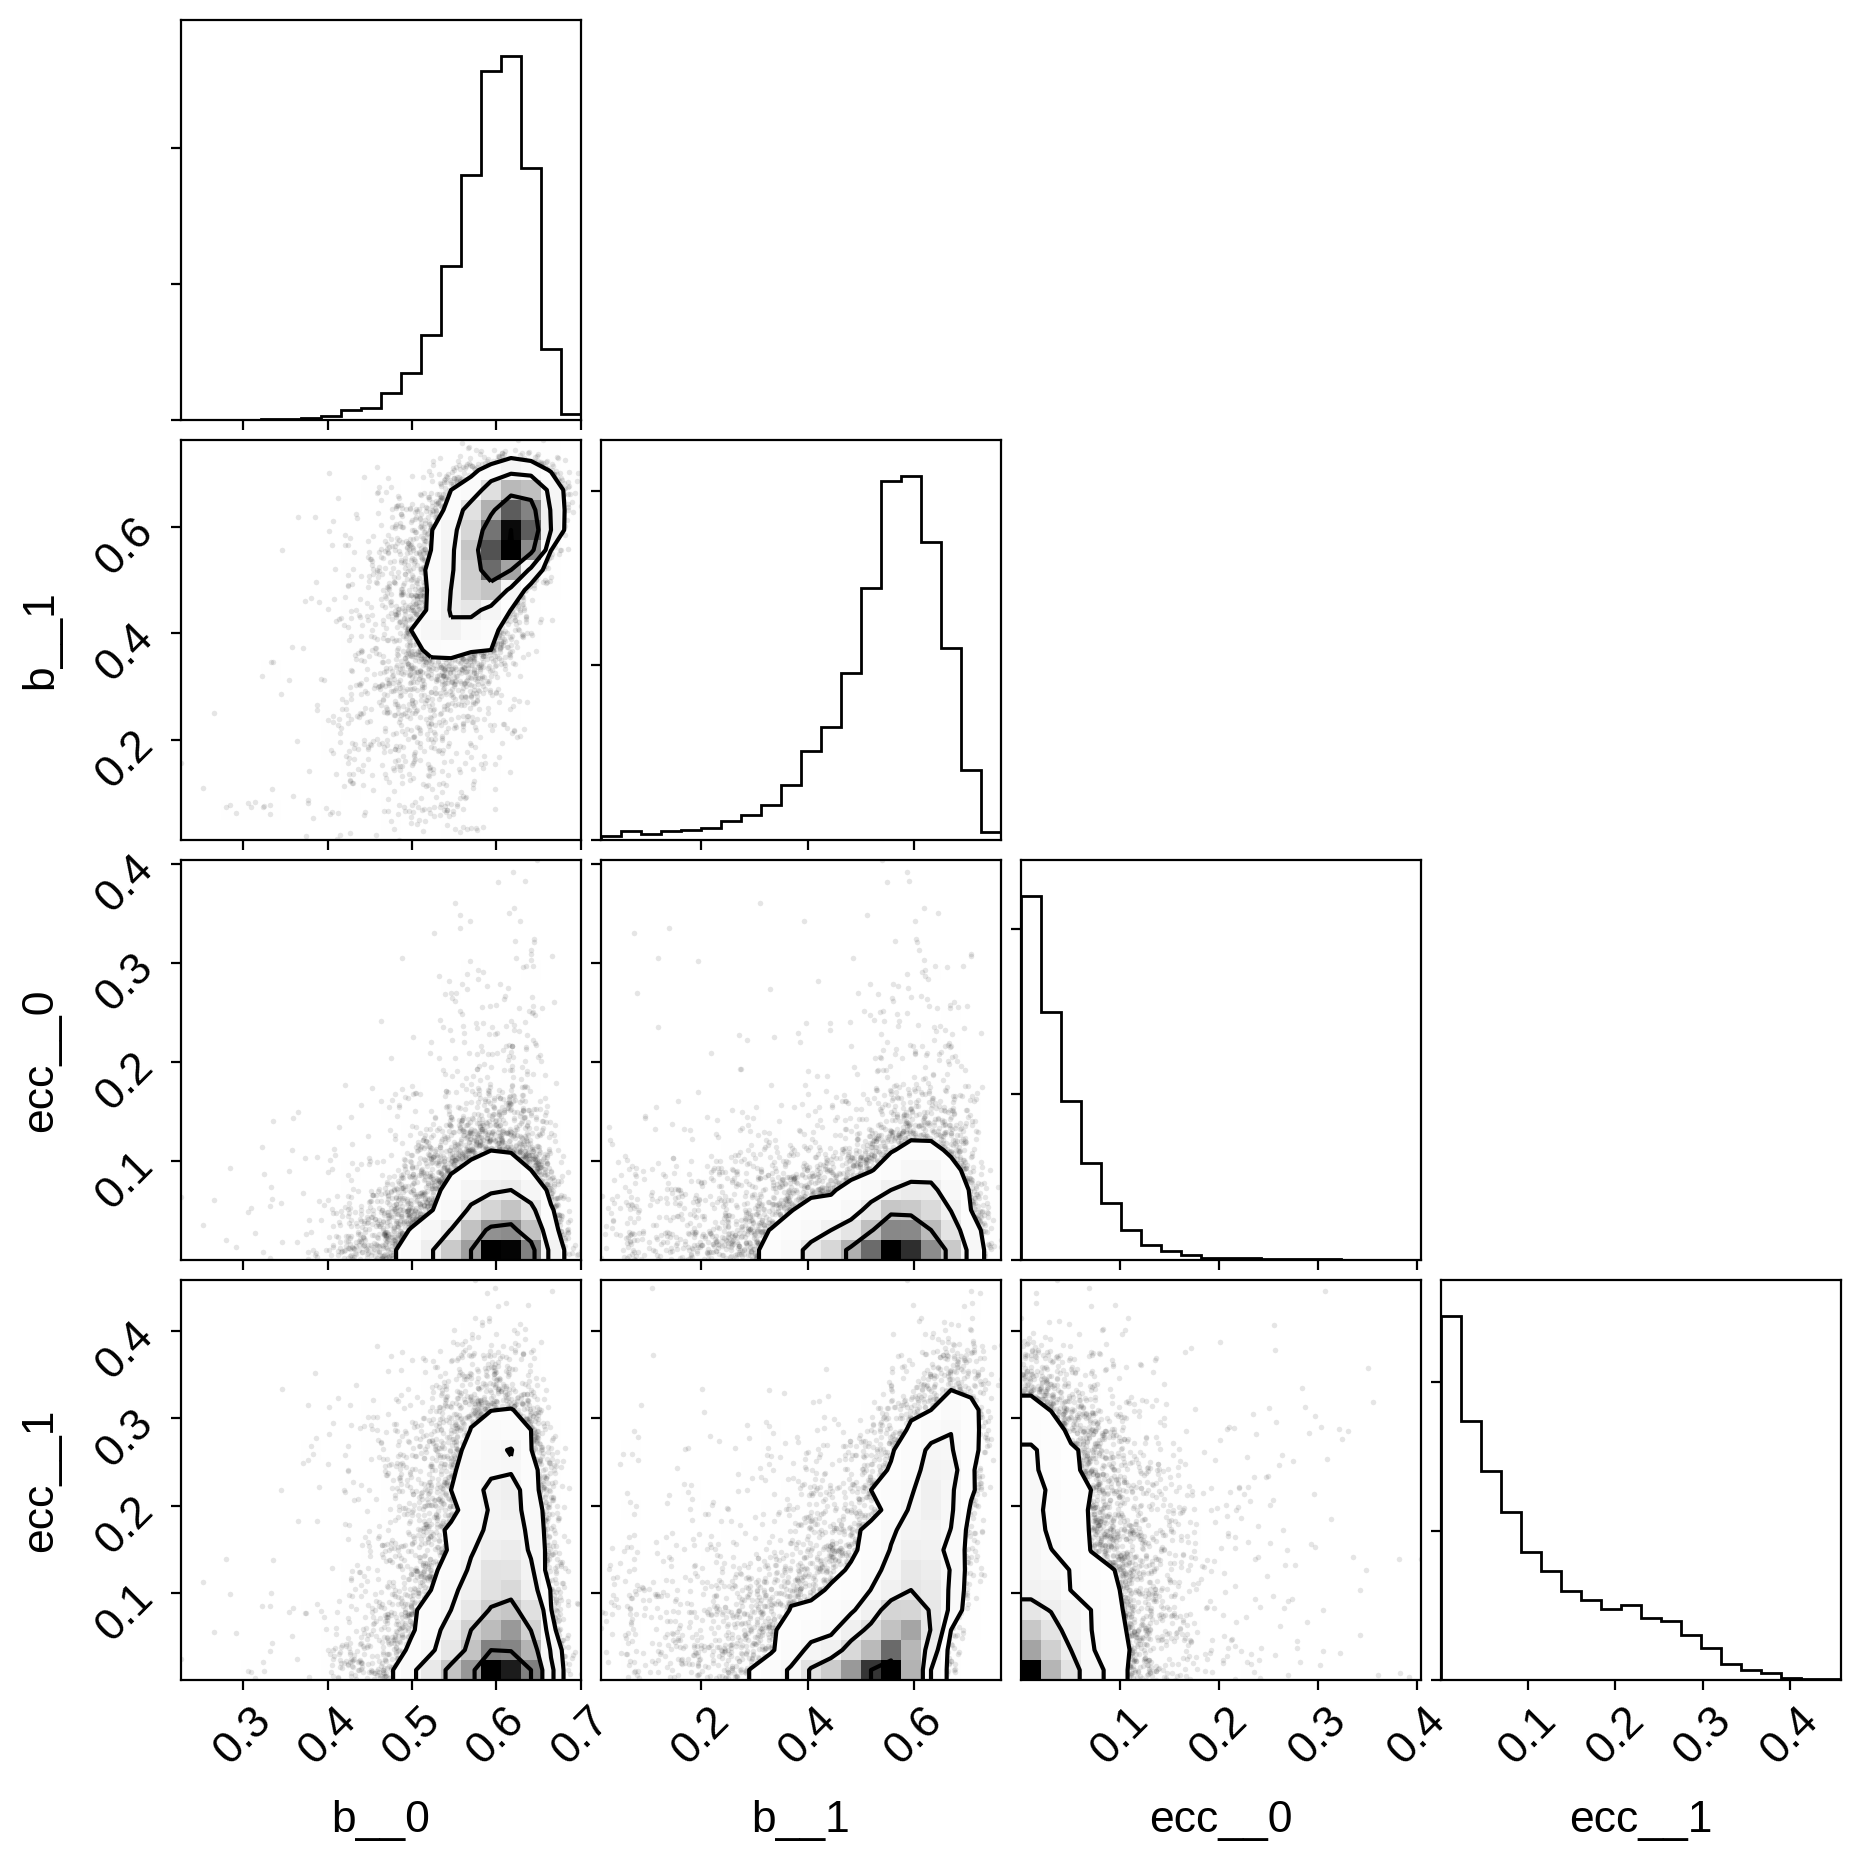

In [16]:
import corner

varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

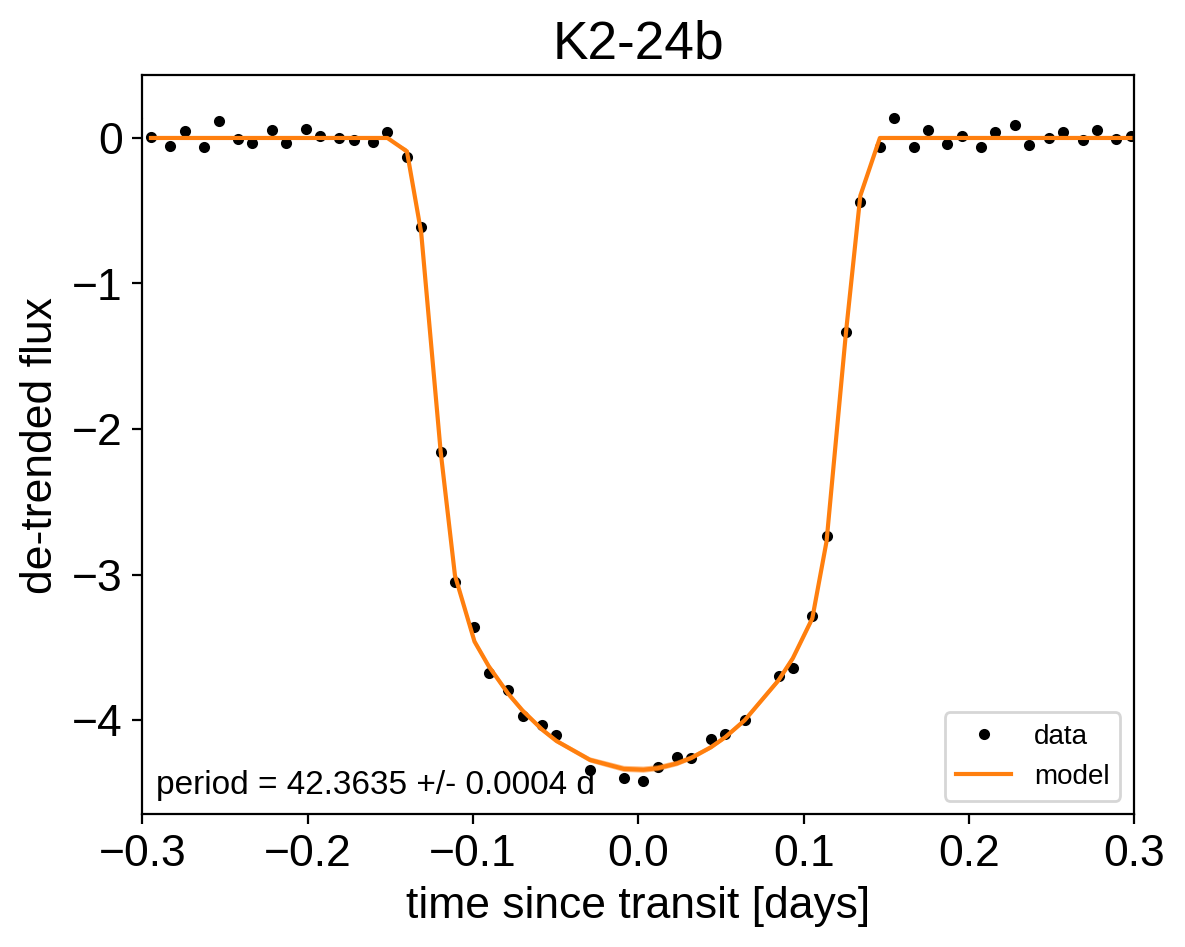

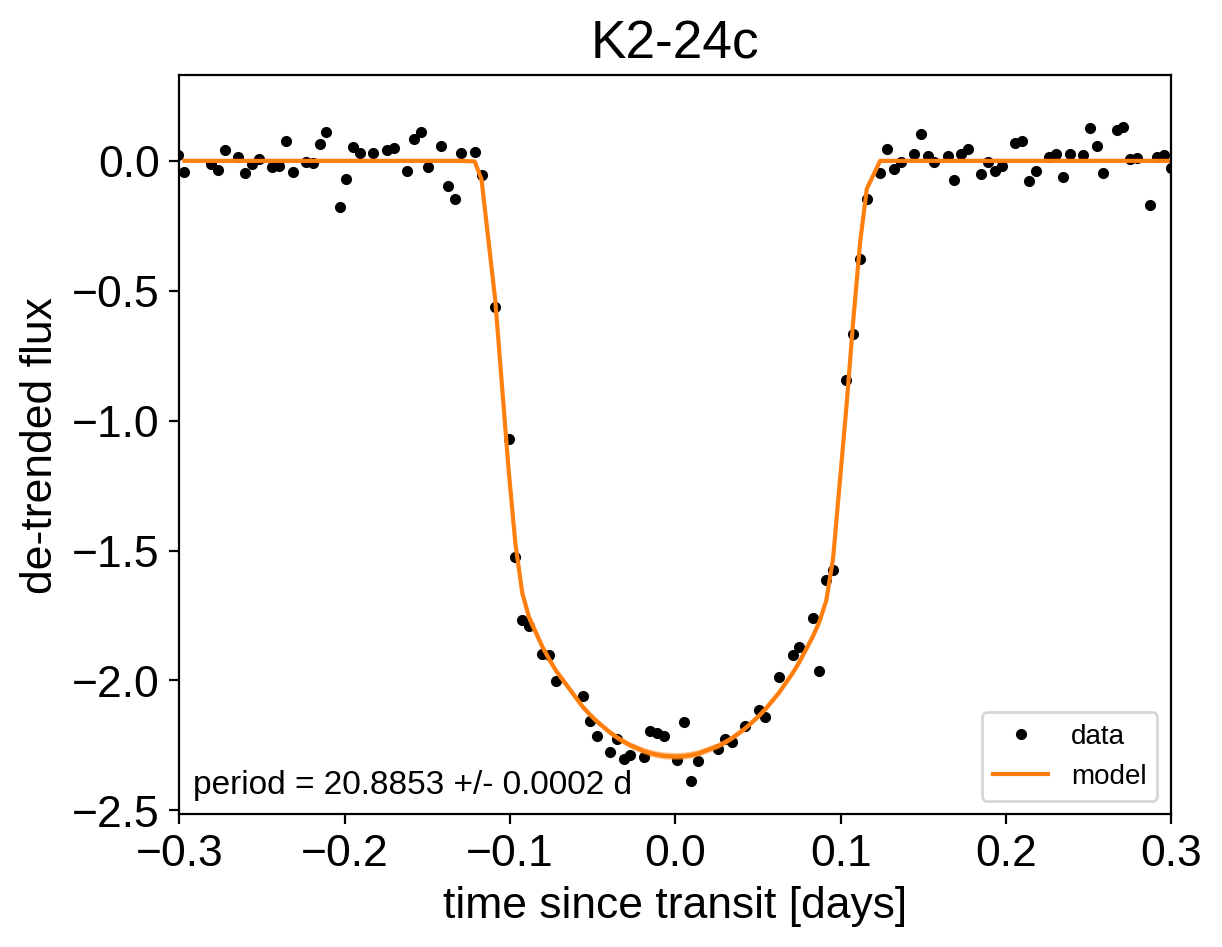

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

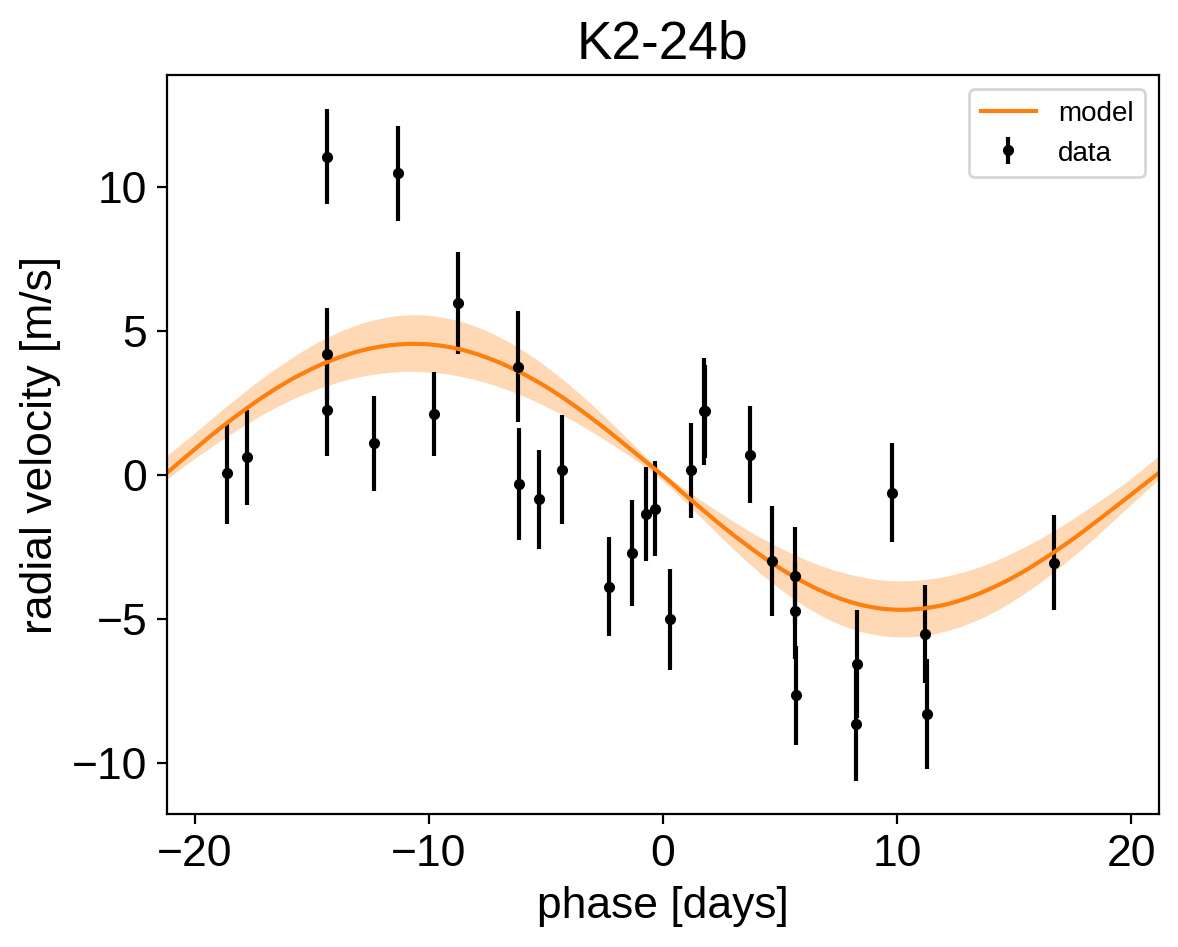

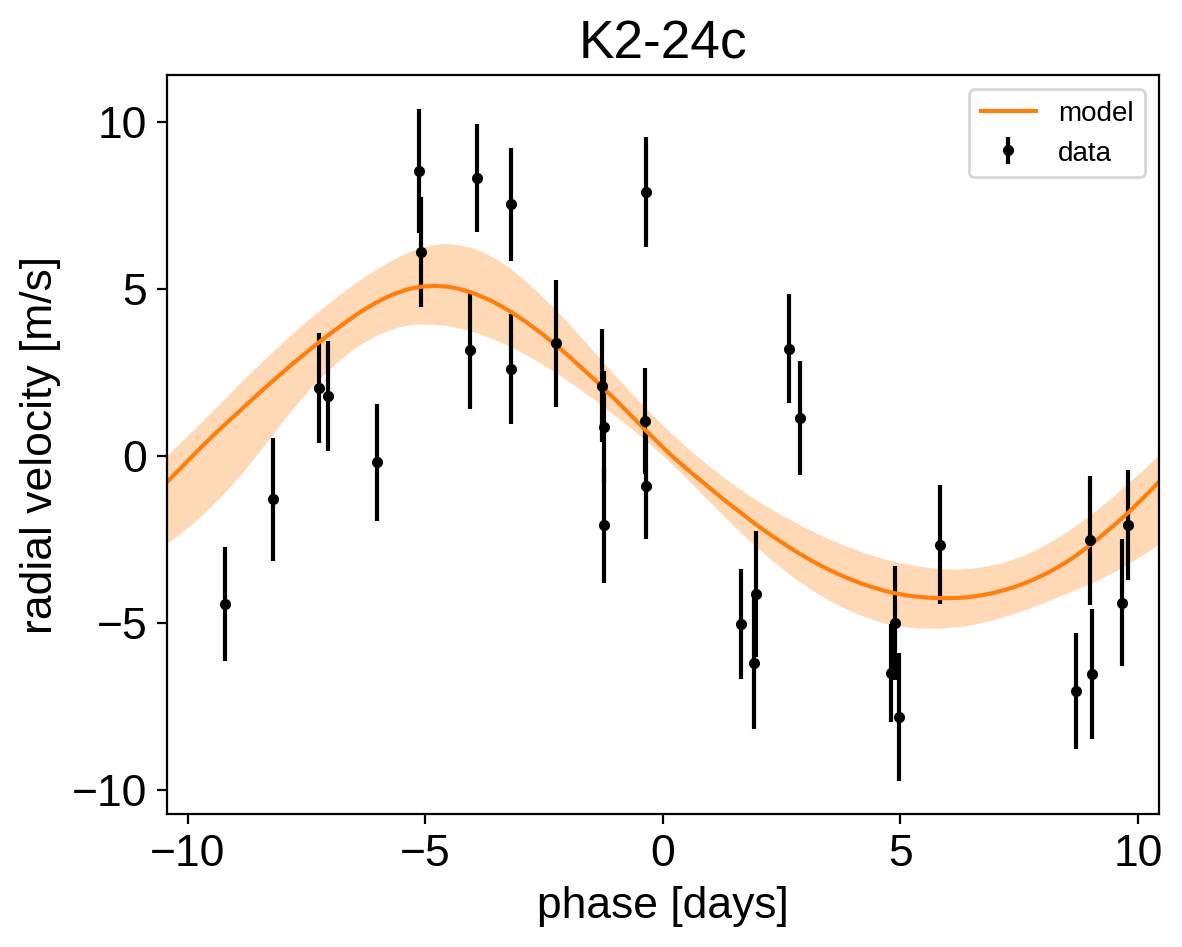

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

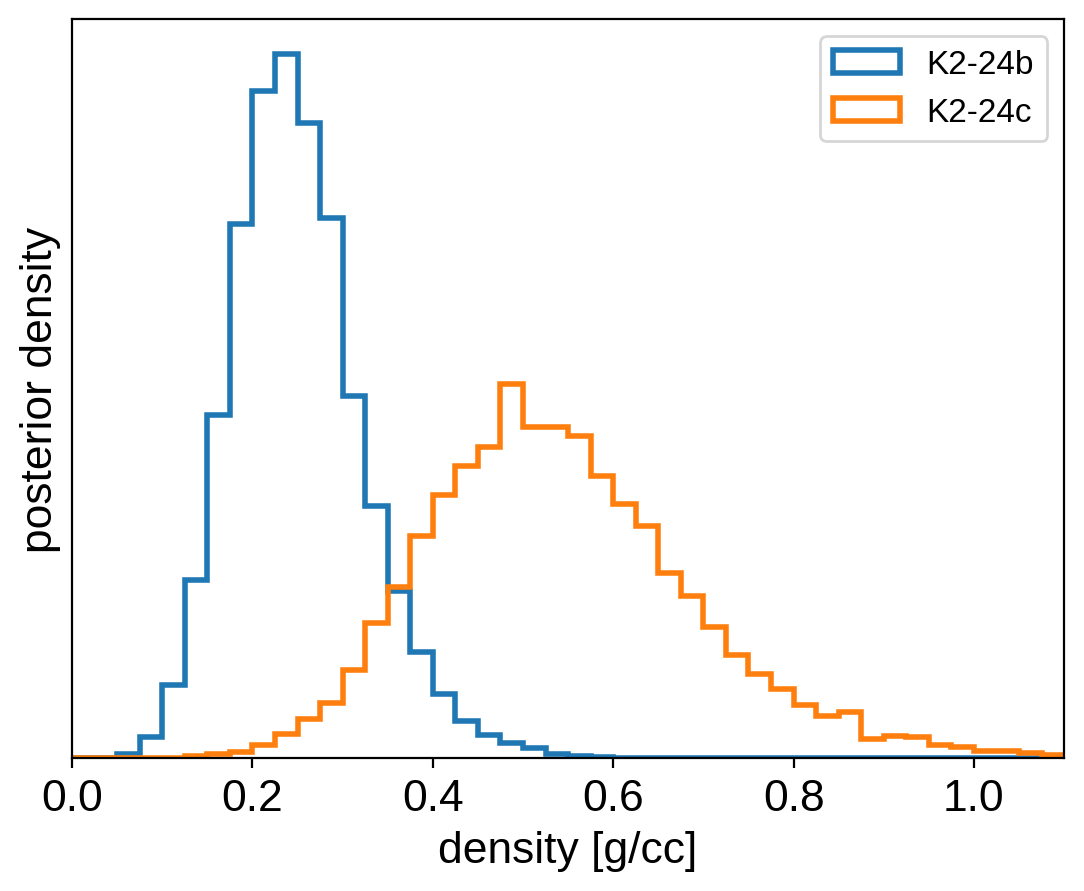

In [19]:
volume = 4 / 3 * np.pi * trace["r_pl"] ** 3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun ** 3)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[:, n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
